In [1]:
#%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sklearn
import sklearn.ensemble
from sklearn import cross_validation

In [3]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

In [4]:
pandas.set_option('display.max_rows', 500)
pandas.set_option('display.max_columns', 500)

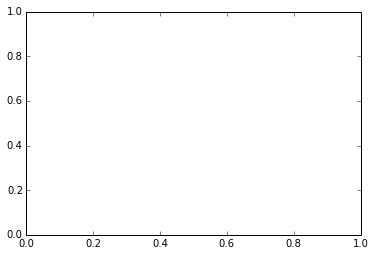

In [5]:
import sys
sys.path.append("/Users/george/Code")
import bamboo.plotting

In [6]:
df = pandas.read_csv('training.csv')
df.set_index('EventId')
grouped = df.groupby('Label')

## Define our evaluation metrics

In [7]:
def create_solution_dictionary(soln):
    """ Read solution file, return a dictionary with key EventId and value (weight,label).
    Solution file headers: EventId, Label, Weight """
    
    solnDict = {}
    for index, row in soln.iterrows():
        if row[0] not in solnDict:
            solnDict[index] = (row['Label'], row['Weight'])
    return solnDict

In [8]:
# Create the truth dict for evaluation
truth_dict = create_solution_dictionary(df)

In [9]:
def AMS(s, b):
    """ Approximate Median Significance defined as:
        AMS = sqrt(
                2 { (s + b + b_r) log[1 + (s/(b+b_r))] - s}
              )        
    where b_r = 10, b = background, s = signal, log is natural logarithm """
    
    br = 10.0
    radicand = 2 *( (s+b+br) * math.log (1.0 + s/(b+br)) -s)
    if radicand < 0:
        print 'radicand is negative. Exiting'
        exit()
    else:
        return math.sqrt(radicand)

In [10]:
from collections import defaultdict

def ams_metric_threshold(submission, truth_dict, threshold=0.5, verbose=False, confusion=False):
    """  Prints the AMS metric value to screen.
    Solution File header: EventId, Class, Weight
    Submission File header: EventId, RankOrder, Class
    """

    if confusion:
        confusion_matrix = defaultdict(lambda: 0)
    
    signal = 0.0
    background = 0.0
    for index, row in submission.iterrows():
        
        score = row['predict_proba_1']
        classification = target_to_label(score>threshold)
        try:
            truth = truth_dict[index][0]
        except:
            print "index %s not in signal dict" % index
            continue
        if verbose:
            print "Index: %s Score: %s Classification: %s Truth: %s" % (index, score, classification, truth)
           
        if confusion:
            confusion_matrix[(classification, truth)] += 1
        
        if classification == 's': # only events predicted to be signal are scored 
            if truth == 's':
                signal += float(truth_dict[index][1])
            elif truth == 'b':
                background += float(truth_dict[index][1])
            else:
                print "WTF"
    
    ams = AMS(signal, background)
    
    if verbose:  
        print 'signal = {0}, background = {1}'.format(signal, background)
        print 'AMS = ' + str(ams)
        if confusion:
            for key, val in confusion_matrix.iteritems():
                print key, val

    return ams

In [88]:
def plot_ams(prediction, truth_dict):
    thresholds = np.arange(0, 1, .05)
    metrics = [ams_metric_threshold(prediction, truth_dict, threshold) for threshold in thresholds]
    
    max_ams = max(metrics)
    plt.plot(thresholds, metrics, label='AMS vs threshold (max = %0.2f)' % max_ams)
    plt.xlabel('Threshold')
    plt.ylabel('AMS Metric')
    plt.legend(loc="upper left")

In [89]:
# All Evaluation Plots

def prediction_plots(prediction):
    fig = plt.figure(figsize=(16,8))

    plt.subplot(2, 2, 1)
    bamboo.modeling.plot_roc_curve(prediction['Label'], prediction['predict_proba_1'])

    plt.subplot(2, 2, 2)
    bamboo.modeling.plot_precision_recall_curve(prediction['Label'], prediction['predict_proba_1'])

    plt.subplot(2, 2, 3)
    plot_ams(prediction, truth_dict)
    
    plt.subplot(2, 2, 4)
    bamboo.plotting.hist(prediction.groupby('Label')['predict_proba_1'], autobin=True, alpha=0.5)
    
    return fig

## Initial Feature Extraction and Fitting

In [13]:
# TODO: Make this a modeling method
feature_names = [column for column in df.columns if column not in ('EventId', 'Label', 'Weight')]

In [14]:
def label_to_target(x):
    if x=='s':
        return 1.0
    else:
        return 0.0
    
def target_to_label(x):
    if round(x)==1.0:
        return 's'
    else:
        return 'b'

    
import bamboo.data
def get_features_and_targets(df, fillna=True):
    targets, features = bamboo.data.take(df, 'Label', exclude=['EventId', 'Weight'])
    targets = targets.map(label_to_target)
    return features, targets

In [15]:
features, targets = get_features_and_targets(df)

In [16]:
def score_summary(classifier, features, targets, scoring, **kwargs):
    print "Using %s features and %s rows\n" % (len(features.columns), len(features))
    for cv in scoring:
        scores = cross_validation.cross_val_score(classifier, features, targets, scoring=cv, **kwargs)
        print '----- %s -----' % cv
        print scores
        print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        print '\n'

In [17]:
def importance_summary(fitted, features):
    return sorted([(feature, importance) for (feature, importance) in zip(features.columns, fitted.feature_importances_)], 
           key = lambda x: -x[1])

## Initial Fit

In [18]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=10, n_jobs=-1)

In [19]:
score_summary(rf, features[::10], targets[::10], scoring=['accuracy', 'f1', 'roc_auc'], cv=5)

Using 30 features and 25000 rows

----- accuracy -----
[ 0.8142  0.815   0.811   0.8072  0.8144]
Accuracy: 0.81 (+/- 0.01)


----- f1 -----
[ 0.7020592   0.69729554  0.69261214  0.68211921  0.67969526]
Accuracy: 0.69 (+/- 0.02)


----- roc_auc -----
[ 0.87362396  0.86221016  0.8606828   0.87004611  0.86850845]
Accuracy: 0.87 (+/- 0.01)




In [20]:
fitted = rf.fit(features[::10], targets[::10])
importance_summary(fitted, features)

[('DER_mass_MMC', 0.17516602987385654),
 ('DER_mass_transverse_met_lep', 0.078669597112753842),
 ('DER_mass_vis', 0.076094388486392522),
 ('PRI_tau_pt', 0.058364823966010101),
 ('DER_pt_ratio_lep_tau', 0.047749125506371524),
 ('DER_met_phi_centrality', 0.044560897733988185),
 ('PRI_met', 0.040238315564702316),
 ('DER_deltar_tau_lep', 0.040082533434414411),
 ('DER_pt_h', 0.035937437066944695),
 ('PRI_lep_pt', 0.033076274894469036),
 ('DER_sum_pt', 0.031958474624797423),
 ('DER_pt_tot', 0.031391482674058675),
 ('PRI_met_sumet', 0.030320117840780824),
 ('PRI_lep_eta', 0.026789249992852537),
 ('PRI_tau_eta', 0.026057493395820253),
 ('PRI_tau_phi', 0.025122600303676485),
 ('DER_lep_eta_centrality', 0.025050772961148011),
 ('PRI_lep_phi', 0.023643025216866797),
 ('PRI_met_phi', 0.022417227008747598),
 ('PRI_jet_leading_eta', 0.019624837768217371),
 ('DER_deltaeta_jet_jet', 0.017170252636633285),
 ('PRI_jet_all_pt', 0.016959634367963383),
 ('PRI_jet_leading_pt', 0.015612063613678654),
 ('PRI_

# Add Momentum Features

In [21]:
from math import sin, cos, sinh

def px(pt, eta, phi):
    return pt * np.cos(phi) 

def py(pt, eta, phi):
    return pt * np.sin(phi)

def pz(pt, eta, phi):
    return pt * np.sinh(eta)

def p_tot(pt, eta, phi):
    x = px(pt, eta, phi)
    y = py(pt, eta, phi)
    z = pz(pt, eta, phi)
    return np.sqrt(x*x + y*y + z*z)

In [22]:
def _calculate_momenta(df, prefix):
    pt = df[prefix+'pt']
    eta = df[prefix+'eta']
    phi = df[prefix+'phi']
    
    return pandas.DataFrame({prefix+'px' : px(pt, eta, phi),
                      prefix+'py' : py(pt, eta, phi),
                      prefix+'pz' : pz(pt, eta, phi),
                      prefix+'p_tot' : p_tot(pt, eta, phi)})

In [23]:
def get_momentum_features(df):
    lep = _calculate_momenta(df, 'PRI_lep_')
    jet_leading = _calculate_momenta(df, 'PRI_jet_leading_')
    jet_subleading = _calculate_momenta(df, 'PRI_jet_subleading_')
    tau = _calculate_momenta(df, 'PRI_tau_')
    met = pandas.DataFrame({"PRI_met_px" : px(df['PRI_met'], None, df['PRI_met_phi']),
                           "PRI_met_py" : py(df['PRI_met'], None, df['PRI_met_phi'])})

    return lep.join(tau).join(jet_leading).join(jet_subleading).join(met)

In [24]:
def with_momentum_features(df):
    return df.join(get_momentum_features(df)).replace([np.inf, -np.inf], np.nan).fillna(0)

In [25]:
df_momentum_features = with_momentum_features(df)

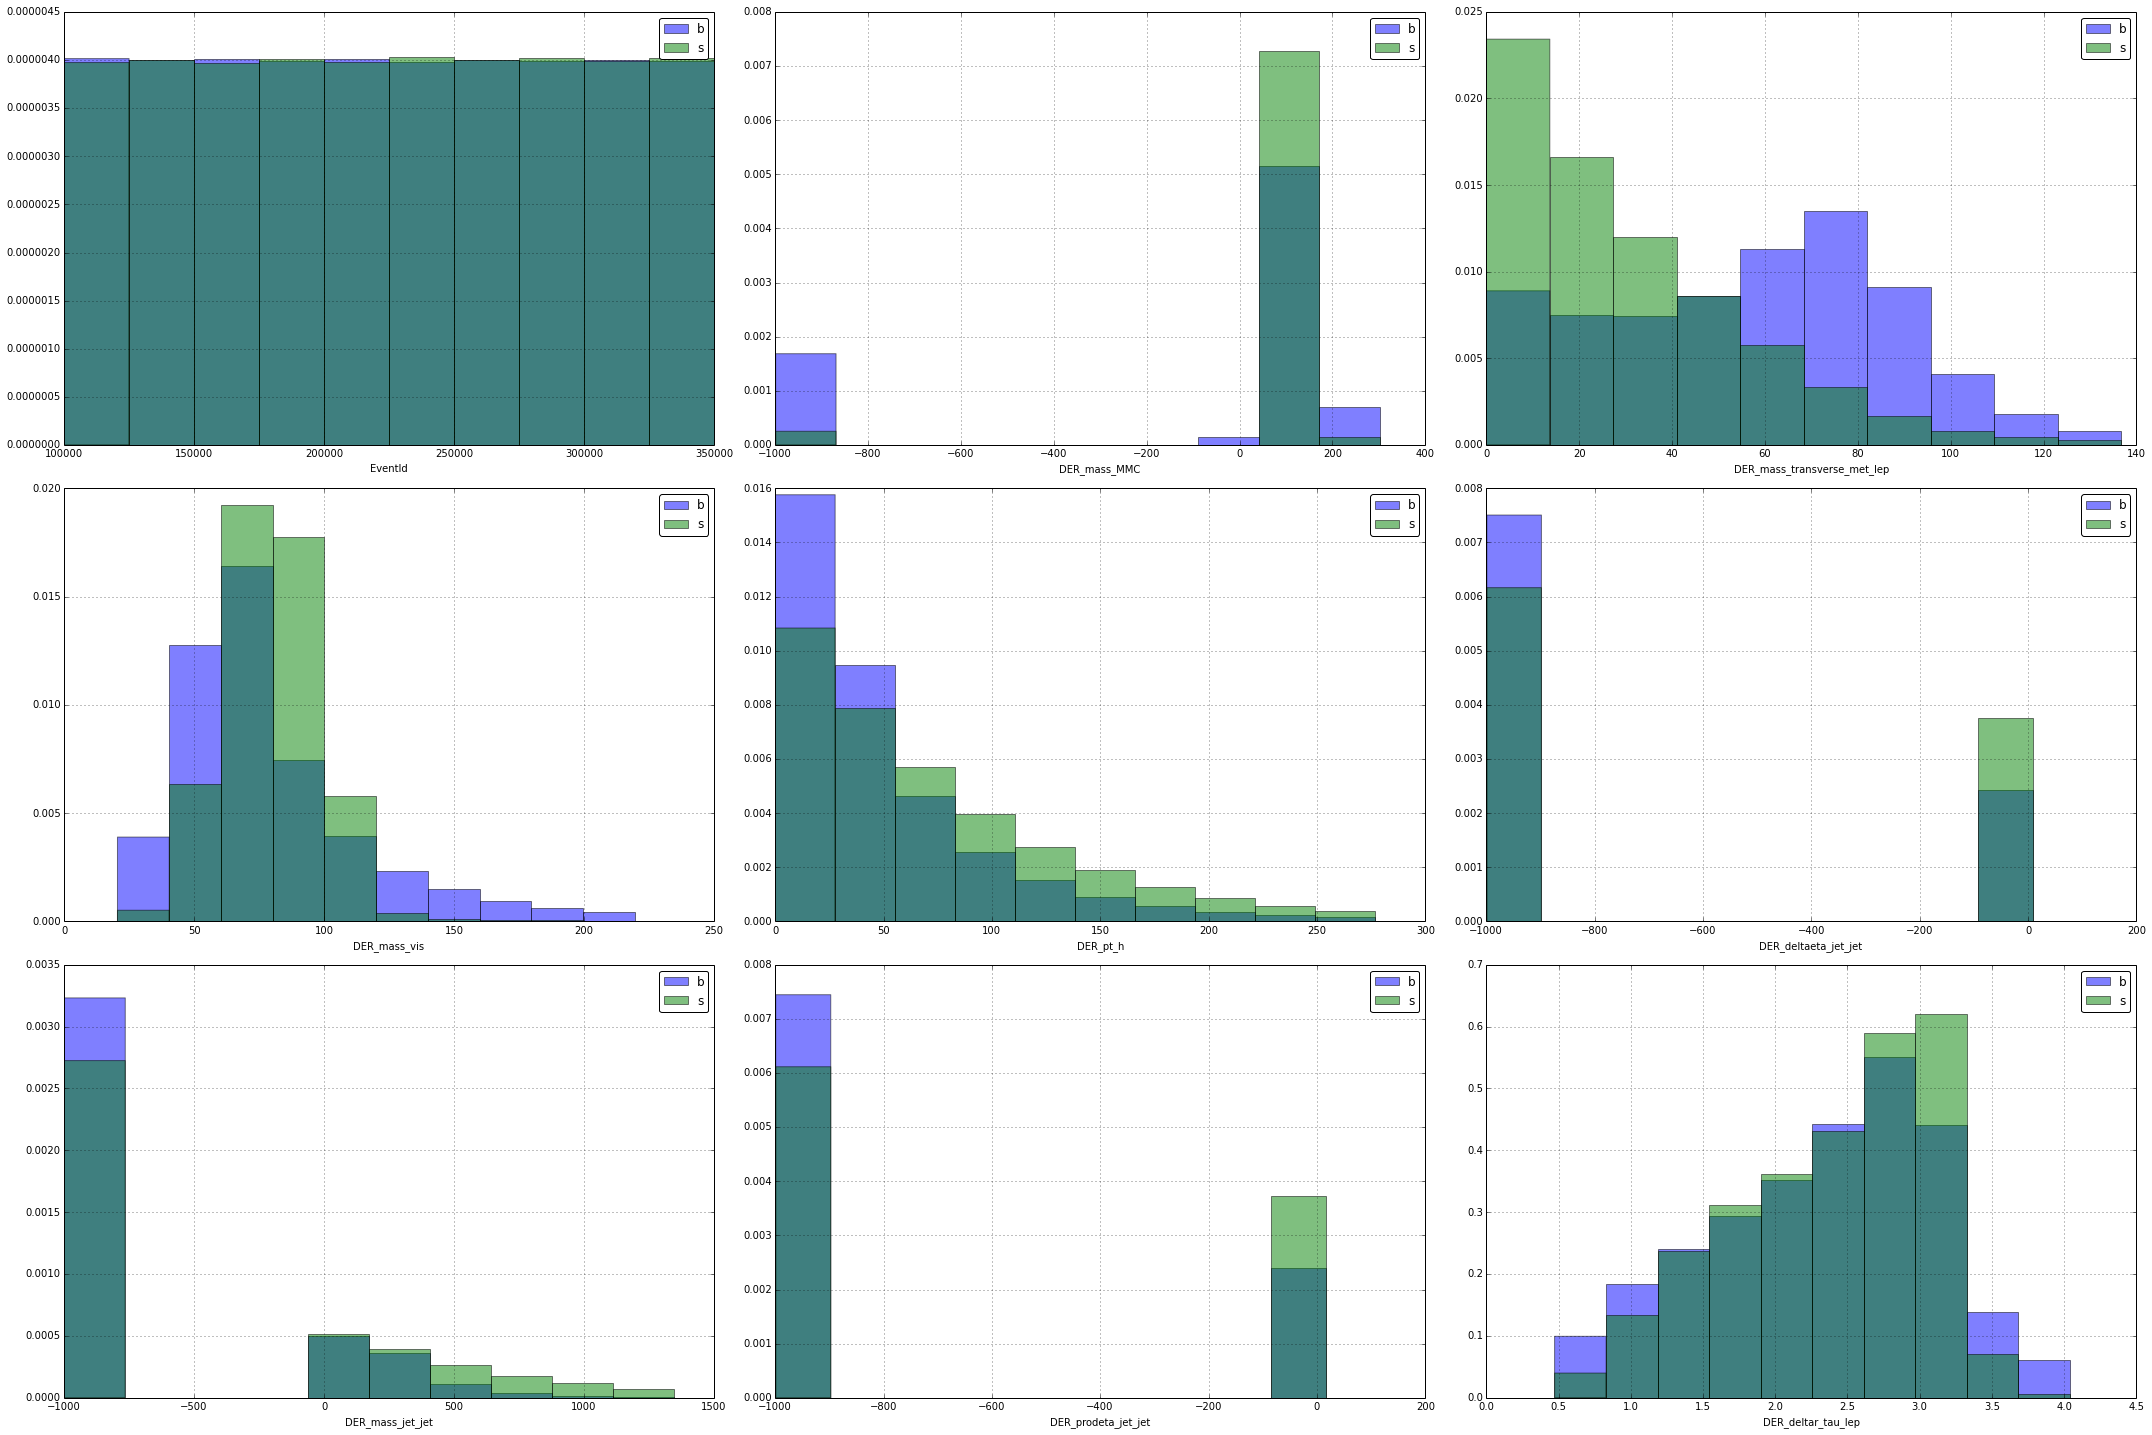

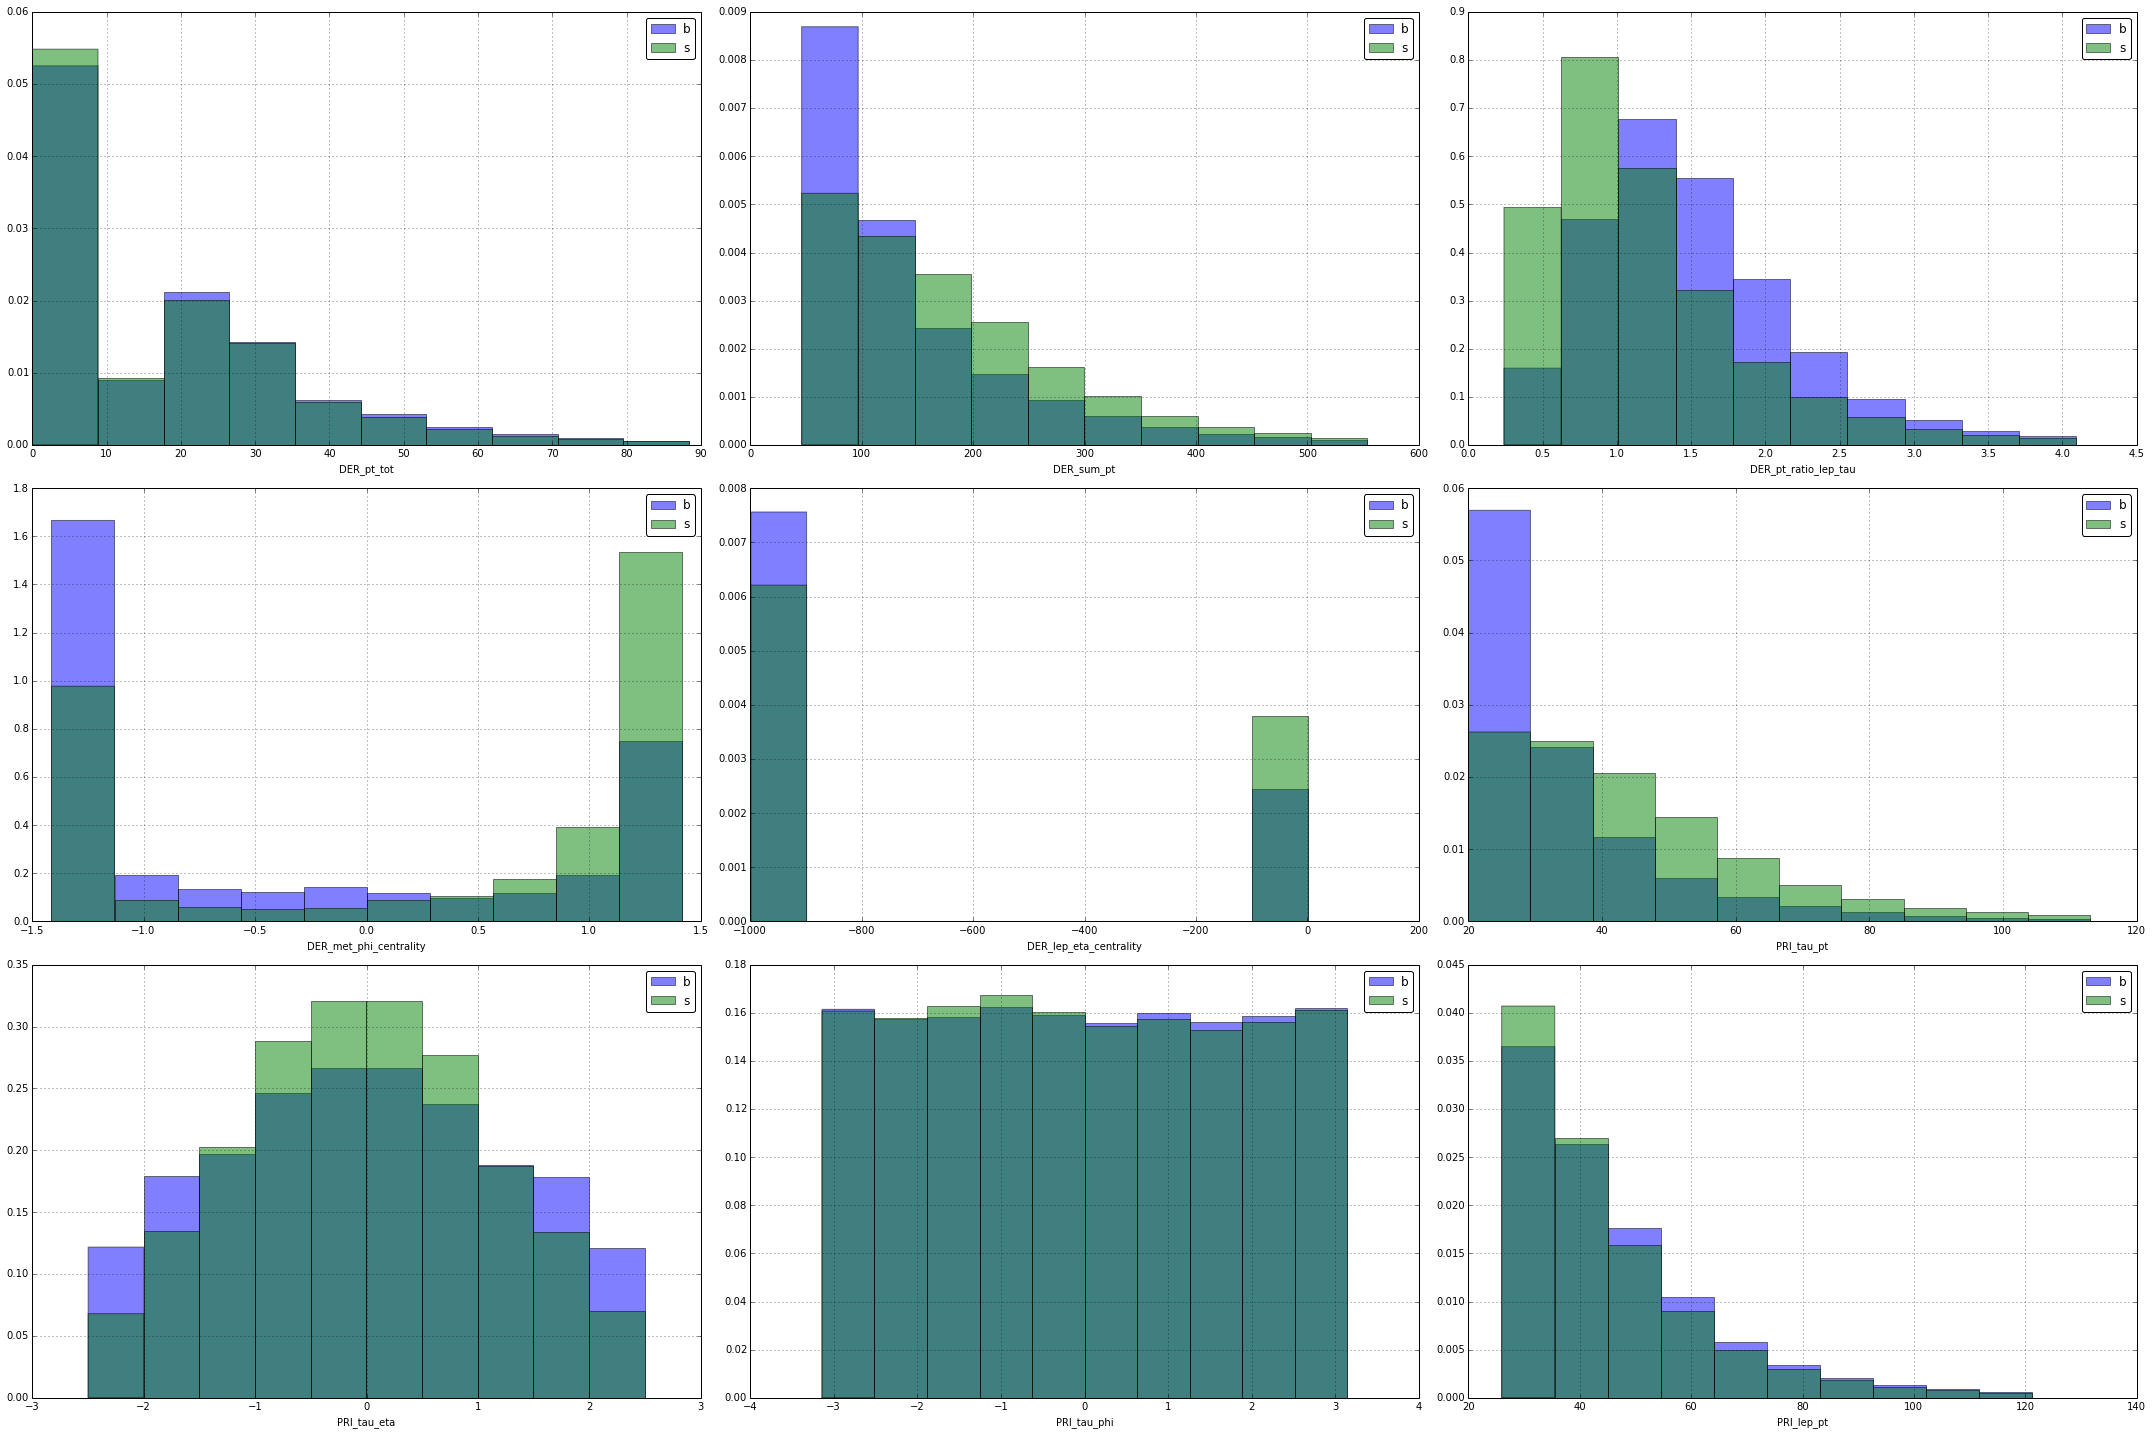

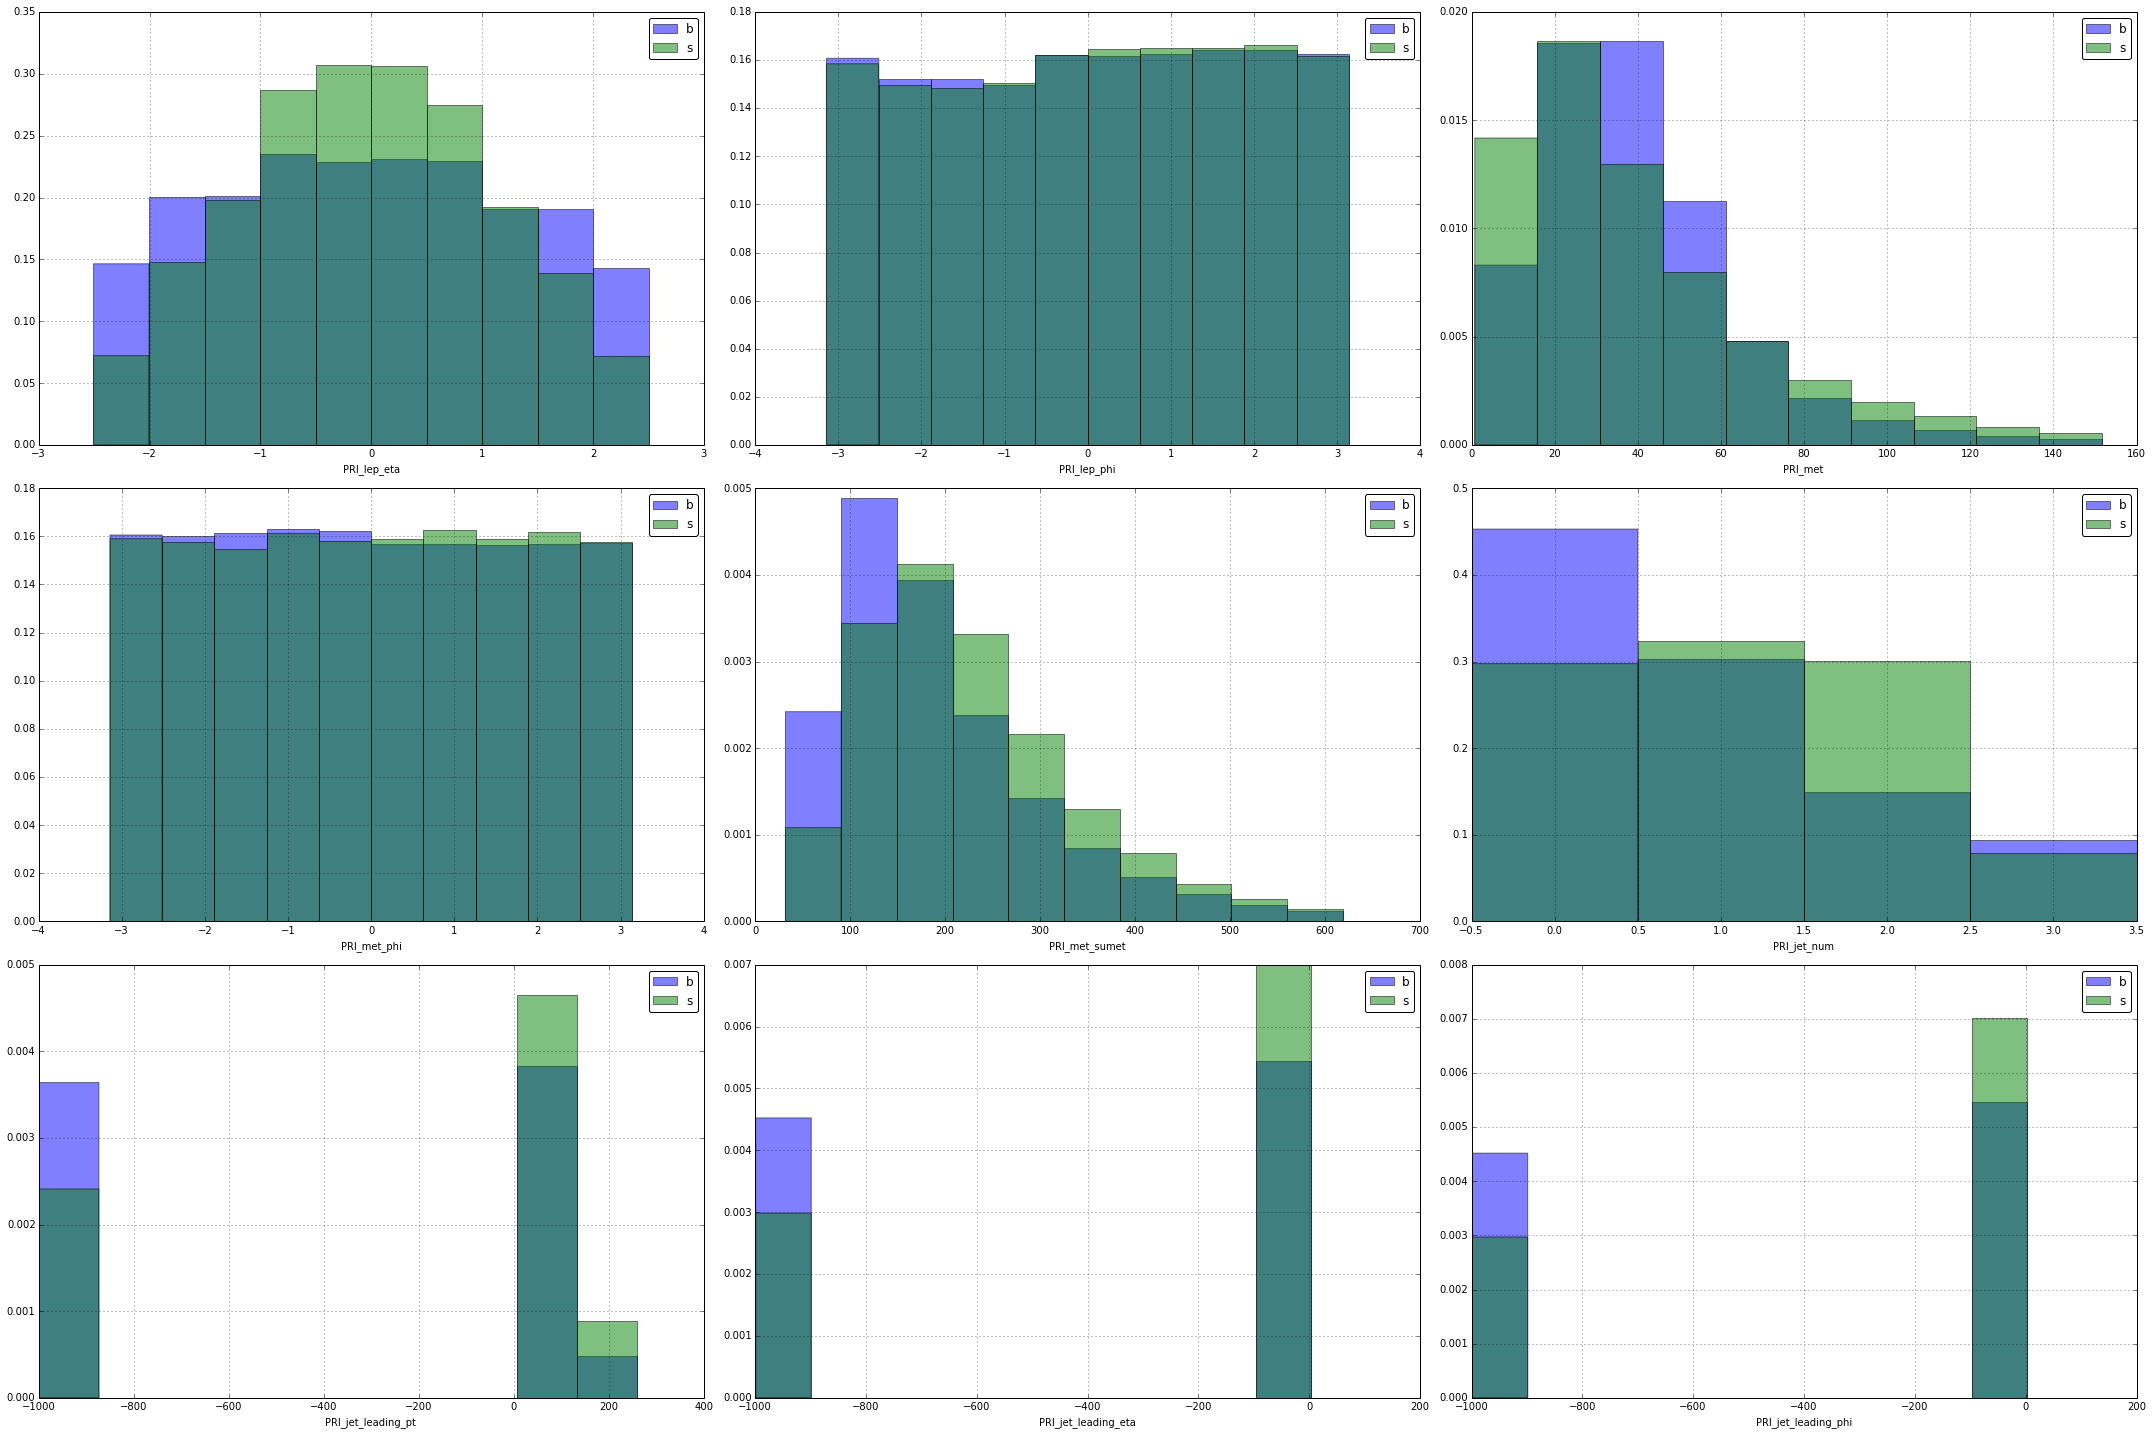

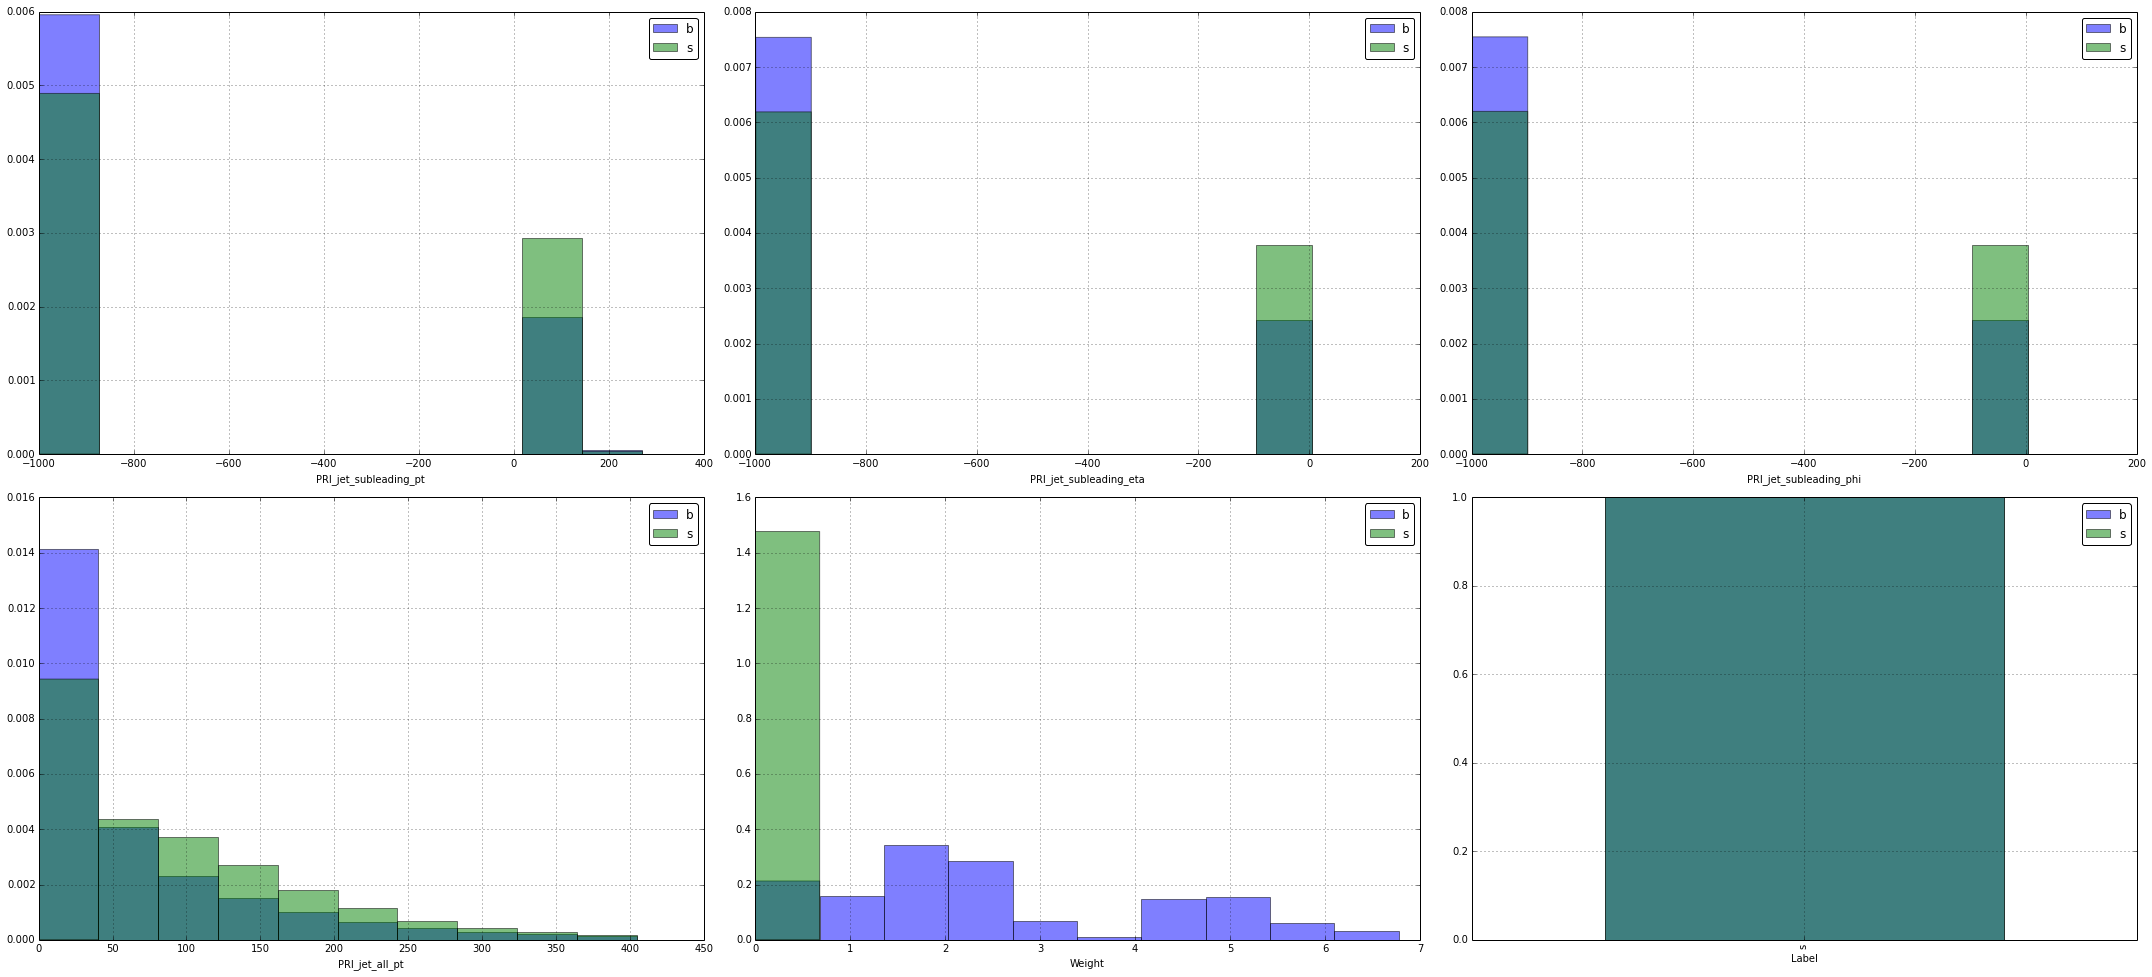

In [26]:
bamboo.plotting.save_grouped_hists(df.groupby('Label'),
                                   output_file='original_features.pdf', autobin=True, alpha=0.5, normed=True)

In [27]:
multi_jet = with_momentum_features(df[df['PRI_jet_num']>1])

# New Features

In [28]:
new_features = []

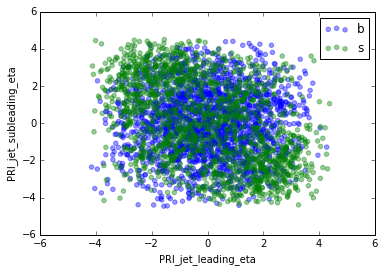

In [29]:
bamboo.plotting.scatter(multi_jet[::20].groupby('Label'), 'PRI_jet_leading_eta', 'PRI_jet_subleading_eta', alpha=0.4)

### Rapidity Features

In [30]:
# The distance from the x=y line in jet eta0, eta1 space
def eta_plus(x, y):
    return np.sqrt(x*x/2 + 2*y*y - 2*x*y)

In [31]:
def jet_eta_plus(row):
    x = row['PRI_jet_leading_eta']
    y = row['PRI_jet_subleading_eta']
    return eta_plus(x, y)

# Do the same with the lepton and jet
def lep_tau_eta_plus(row):
    x = row['PRI_lep_eta']
    y = row['PRI_tau_eta']
    return eta_plus(x, y)

rapidity_features = [jet_eta_plus, lep_tau_eta_plus]
new_features.extend(rapidity_features)

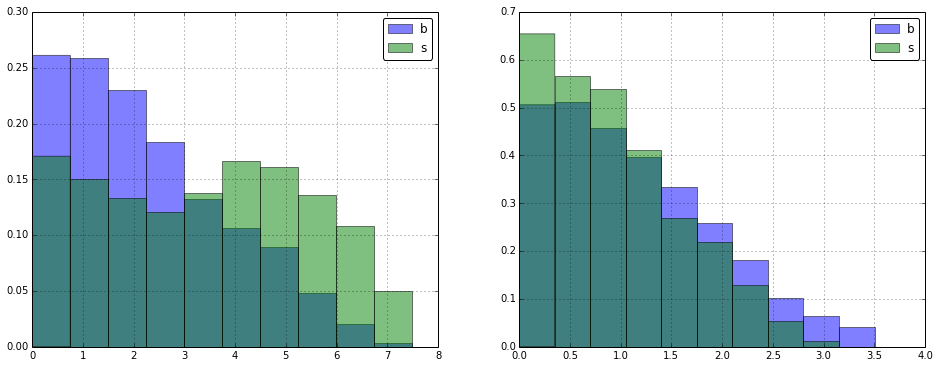

In [32]:
from bamboo.functions import groupmap

plt.figure(figsize=(16,6))

plt.subplot(1, 2, 1)
bamboo.plotting.hist(groupmap(multi_jet[::20].groupby('Label'), jet_eta_plus),
                     alpha=0.5, autobin=True, normed=True)
    
plt.subplot(1, 2, 2)
bamboo.plotting.hist(groupmap(multi_jet[::20].groupby('Label'), lep_tau_eta_plus),
                     alpha=0.5, autobin=True, normed=True)

### Z Momentum features

In [33]:
# Do the same with the lepton and jet
def lep_z_momentum(row):
    return row['PRI_lep_pz'] + row['PRI_tau_pz']

def jet_z_momentum(row):
    return row['PRI_jet_leading_pz'] + row['PRI_jet_subleading_pz']

def jet_lep_sum_z_momentum(row):
    return lep_z_momentum(row) + jet_z_momentum(row)

def jet_lep_diff_z_momentum(row):
    return lep_z_momentum(row) - jet_z_momentum(row)

z_momentum_features = [lep_z_momentum, jet_z_momentum, jet_lep_sum_z_momentum, jet_lep_diff_z_momentum]
new_features.extend(z_momentum_features)

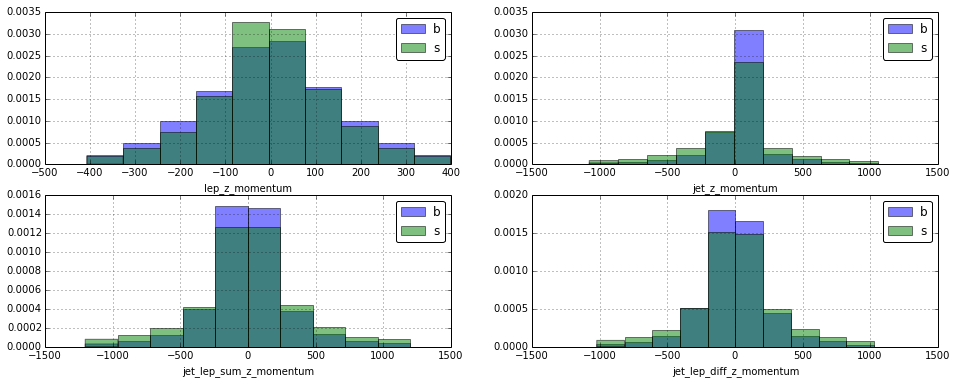

In [34]:
plt.figure(figsize=(16,6))

bamboo.plotting.hist_functions(df_momentum_features[::20].groupby('Label'), z_momentum_features,
                   alpha=0.5, autobin=True, normed=True)

### Transverse Momentum Features

In [35]:
def max_jet_pt(row):
    return max(row['PRI_jet_leading_pt'], row['PRI_jet_subleading_pt'])  

def min_jet_pt(row):
    return min(row['PRI_jet_leading_pt'], row['PRI_jet_subleading_pt'])  

def max_lep_pt(row):
    return max(row['PRI_tau_pt'], row['PRI_lep_pt'])  

def min_lep_pt(row):
    return min(row['PRI_tau_pt'], row['PRI_lep_pt'])  

def max_pt(row):
    return max(max_jet_pt(row), max_lep_pt(row))

def min_pt(row):
    return min(min_jet_pt(row), min_lep_pt(row))

def sum_jet_pt(row):
    return row['PRI_jet_leading_pt'] + row['PRI_jet_subleading_pt']

def sum_lep_pt(row):
    return row['PRI_tau_pt'] + row['PRI_lep_pt']


transverse_momentum_features = [max_jet_pt, min_jet_pt, max_lep_pt, min_lep_pt,
                                max_pt, min_pt, sum_jet_pt, sum_lep_pt]
new_features.extend(transverse_momentum_features)

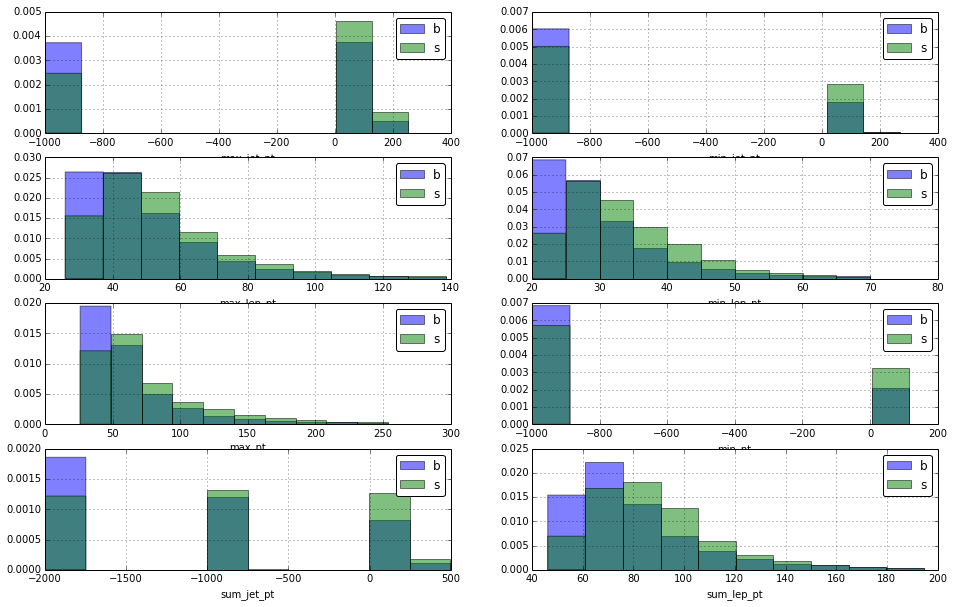

In [36]:
plt.figure(figsize=(16,10))

bamboo.plotting.hist_functions(df_momentum_features[::20].groupby('Label'), transverse_momentum_features,
                   alpha=0.5, autobin=True, normed=True)

In [37]:
def frac_tau_pt(row):
    tau_pt = row['PRI_tau_pt']
    lep_pt = row['PRI_lep_pt']
    return tau_pt / (tau_pt + lep_pt)

def frac_lep_pt(row):
    tau_pt = row['PRI_tau_pt']
    lep_pt = row['PRI_lep_pt']
    return lep_pt / (tau_pt + lep_pt)

def frac_tau_p(row):
    tau_p = row['PRI_tau_p_tot']
    lep_p = row['PRI_lep_p_tot']
    return tau_p / (tau_p + lep_p)

def frac_lep_p(row):
    tau_p = row['PRI_tau_p_tot']
    lep_p = row['PRI_lep_p_tot']
    return lep_p / (tau_p + lep_p)

def prijet_subjet_pt_ratio(row):
    return row['PRI_jet_leading_pt'] / (row['PRI_jet_leading_pt'] + row['PRI_jet_subleading_pt'])

def subjet_prijet_pt_ratio(row):
    return row['PRI_jet_subleading_pt'] / (row['PRI_jet_leading_pt'] + row['PRI_jet_subleading_pt'])


momentum_ratio_features = [frac_tau_pt, frac_lep_pt, frac_tau_p, frac_lep_p,
                           prijet_subjet_pt_ratio, subjet_prijet_pt_ratio]
new_features.extend(momentum_ratio_features)

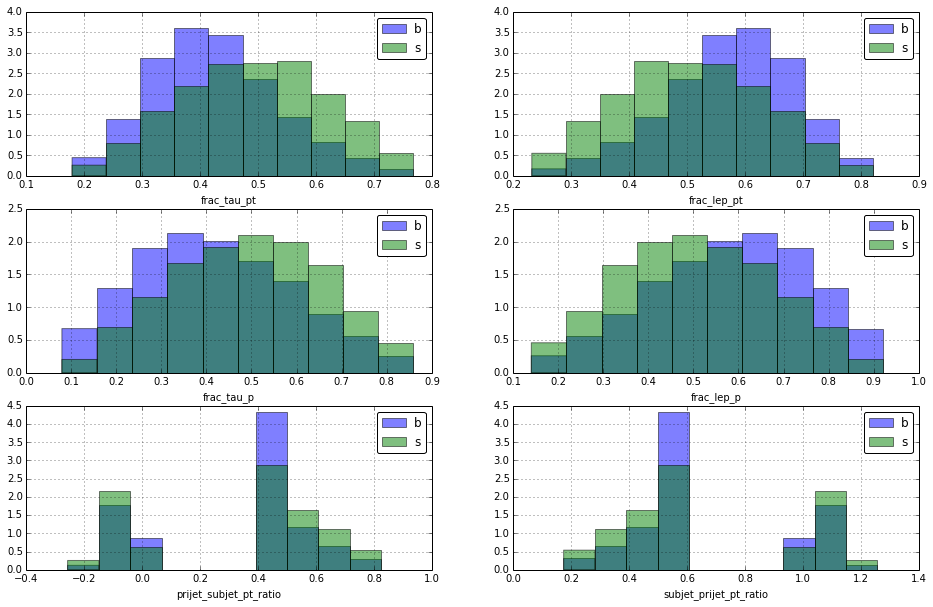

In [38]:
plt.figure(figsize=(16,10))

bamboo.plotting.hist_functions(df_momentum_features[::20].groupby('Label'), momentum_ratio_features,
                   alpha=0.5, autobin=True, normed=True)

In [39]:
import math

def ht(row):
    return sum_jet_pt(row) + sum_lep_pt(row)

def ht_met(row):
    return ht(row) + row['PRI_met']

def met_sig(row):
    return row['PRI_met'] / np.sqrt(row['PRI_met_sumet'])

def sumet_sum_pt_ratio(row):
    return row['PRI_met_sumet'] / row['DER_sum_pt']

def met_pt_total_ratio(row):
    if (row['DER_pt_tot']==0):
        return 0.0
    return row['PRI_met'] / row['DER_pt_tot']

met_features = [ht, ht_met, met_sig, sumet_sum_pt_ratio, met_pt_total_ratio]
new_features.extend(met_features)

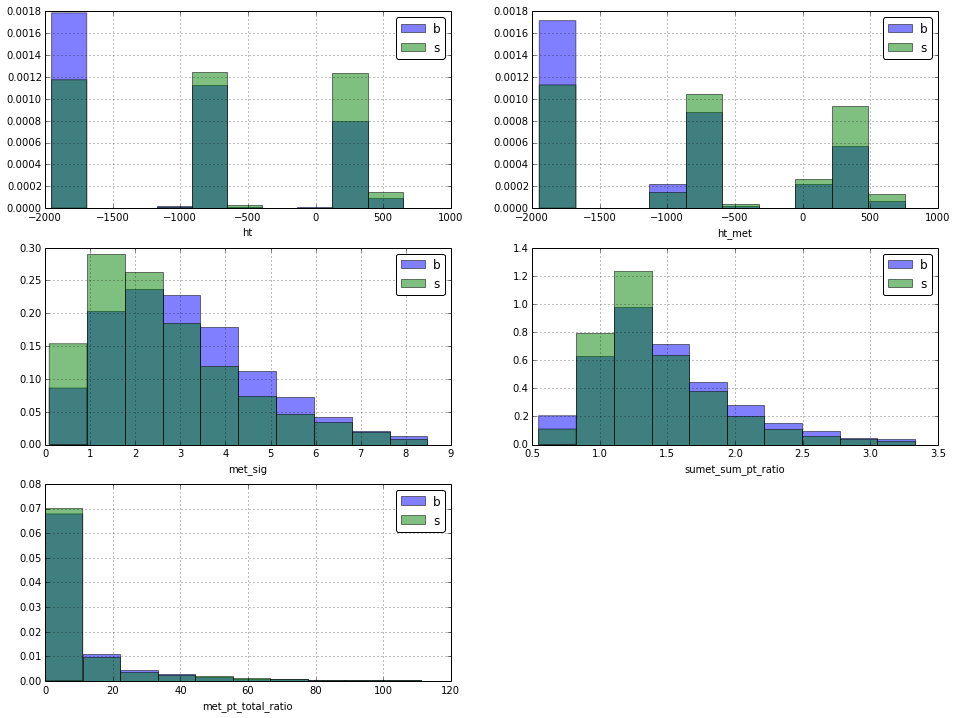

In [40]:
plt.figure(figsize=(16,12))

bamboo.plotting.hist_functions(df_momentum_features[::20].groupby('Label'), met_features,
                   alpha=0.5, autobin=True, normed=True)

In [41]:
def tau_met_cos_phi(row):
    return math.cos(row['PRI_met_phi'] - row['PRI_tau_phi'])

def lep_met_cos_phi(row):
    return math.cos(row['PRI_met_phi'] - row['PRI_lep_phi'])

def jet_leading_met_cos_phi(row):
    return math.cos(row['PRI_jet_leading_phi'] - row['PRI_lep_phi'])

def jet_subleading_met_cos_phi(row):
    return math.cos(row['PRI_jet_subleading_phi'] - row['PRI_lep_phi'])

def min_met_cos_phi(row):
    return min(tau_met_cos_phi(row), lep_met_cos_phi(row),
               jet_leading_met_cos_phi(row), jet_subleading_met_cos_phi(row))

def max_met_cos_phi(row):
    return max(tau_met_cos_phi(row), lep_met_cos_phi(row),
               jet_leading_met_cos_phi(row), jet_subleading_met_cos_phi(row))

met_phi_features = [tau_met_cos_phi, lep_met_cos_phi, jet_leading_met_cos_phi, jet_subleading_met_cos_phi,
                min_met_cos_phi, max_met_cos_phi,]
new_features.extend(met_phi_features)

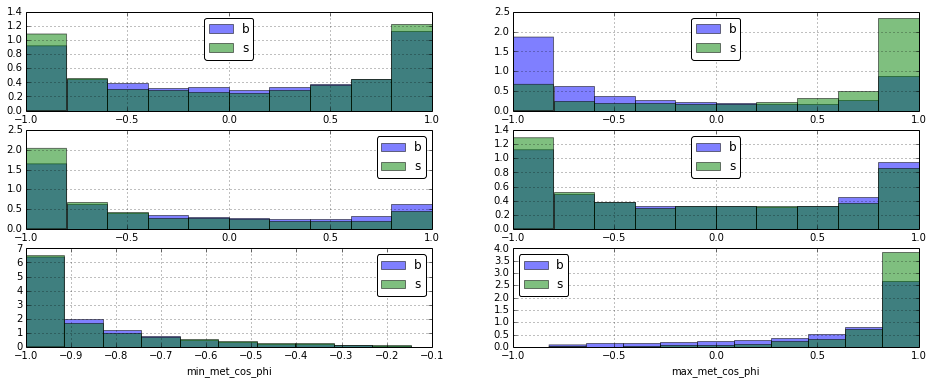

In [42]:
plt.figure(figsize=(16,6))

bamboo.plotting.hist_functions(df_momentum_features[::20].groupby('Label'), met_phi_features,
                   alpha=0.5, autobin=True, normed=True)

In [43]:
def prijet_subjet_delta_cos_phi(row):
    return cos(row['PRI_jet_leading_phi'] - row['PRI_jet_subleading_phi'])

def prijet_tau_delta_cos_phi(row):
    return cos(row['PRI_jet_leading_phi'] - row['PRI_tau_phi'])

def prijet_lep_delta_cos_phi(row):
    return cos(row['PRI_jet_leading_phi'] - row['PRI_lep_phi'])

def subjet_lep_delta_cos_phi(row):
    return cos(row['PRI_jet_subleading_phi'] - row['PRI_tau_phi'])

def subjet_lep_delta_cos_phi(row):
    return cos(row['PRI_jet_subleading_phi'] - row['PRI_lep_phi'])

def lep_tau_delta_cos_phi(row):
    return cos(row['PRI_lep_phi'] - row['PRI_tau_phi'])


obj_obj_phi_features = [prijet_subjet_delta_cos_phi, prijet_tau_delta_cos_phi, prijet_lep_delta_cos_phi,
                        subjet_lep_delta_cos_phi, subjet_lep_delta_cos_phi, lep_tau_delta_cos_phi]
new_features.extend(obj_obj_phi_features)

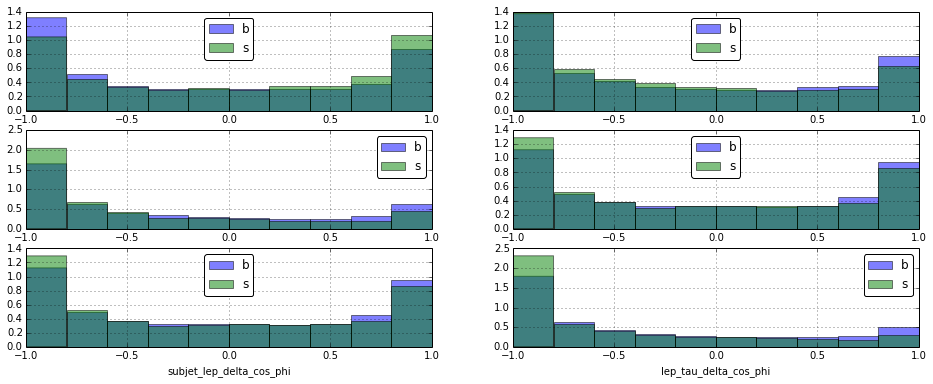

In [44]:
plt.figure(figsize=(16,6))

bamboo.plotting.hist_functions(df_momentum_features[::20].groupby('Label'), obj_obj_phi_features,
                   alpha=0.5, autobin=True, normed=True)

In [45]:
def prijet_subjet_delta_eta(row):
    return cos(row['PRI_jet_leading_eta'] - row['PRI_jet_subleading_eta'])

def prijet_tau_delta_eta(row):
    return cos(row['PRI_jet_leading_eta'] - row['PRI_tau_eta'])

def prijet_lep_delta_eta(row):
    return cos(row['PRI_jet_leading_eta'] - row['PRI_lep_eta'])

def subjet_lep_delta_eta(row):
    return cos(row['PRI_jet_subleading_eta'] - row['PRI_tau_eta'])

def subjet_lep_delta_eta(row):
    return cos(row['PRI_jet_subleading_eta'] - row['PRI_lep_eta'])

def lep_tau_delta_eta(row):
    return cos(row['PRI_lep_eta'] - row['PRI_tau_eta'])


obj_obj_eta_features = [prijet_subjet_delta_eta, prijet_tau_delta_eta, prijet_lep_delta_eta,
                        subjet_lep_delta_eta, subjet_lep_delta_eta, lep_tau_delta_eta]
new_features.extend(obj_obj_eta_features)

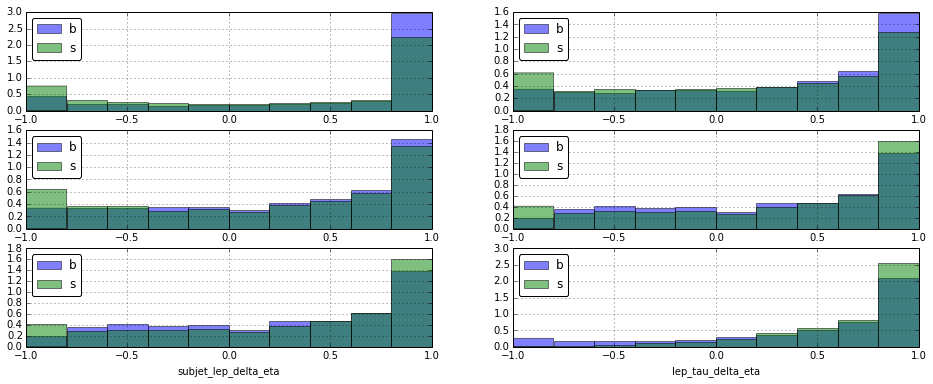

In [46]:
plt.figure(figsize=(16,6))

bamboo.plotting.hist_functions(df_momentum_features[::20].groupby('Label'), obj_obj_eta_features,
                   alpha=0.5, autobin=True, normed=True)

In [47]:
def lep_momentum(row):
    return np.sqrt(row['PRI_lep_px']*row['PRI_lep_px'] + row['PRI_lep_py']*row['PRI_lep_py'] + row['PRI_lep_pz']*row['PRI_lep_pz'])

def tau_momentum(row):
    return np.sqrt(row['PRI_tau_px']*row['PRI_tau_px'] + row['PRI_tau_py']*row['PRI_tau_py'] + row['PRI_tau_pz']*row['PRI_tau_pz'])

def prijet_momentum(row):
    return np.sqrt(row['PRI_jet_leading_px']*row['PRI_jet_leading_px'] + row['PRI_jet_leading_py']*row['PRI_jet_leading_py'] + row['PRI_jet_leading_pz']*row['PRI_jet_leading_pz'])

def subjet_momentum(row):
    return np.sqrt(row['PRI_jet_subleading_px']*row['PRI_jet_subleading_px'] + row['PRI_jet_subleading_py']*row['PRI_jet_subleading_py'] + row['PRI_jet_subleading_pz']*row['PRI_jet_subleading_pz'])

object_momentum_features = [lep_momentum, tau_momentum, prijet_momentum, subjet_momentum]
new_features.extend(object_momentum_features)

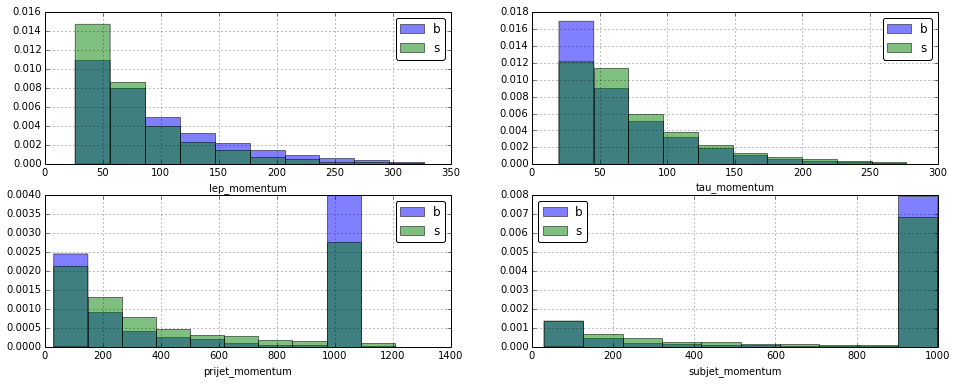

In [48]:
plt.figure(figsize=(16,6))

bamboo.plotting.hist_functions(df_momentum_features[::20].groupby('Label'), object_momentum_features,
                   alpha=0.5, autobin=True, normed=True)

In [49]:
def momentum_total_x(row):
    return row['PRI_lep_px'] + row['PRI_tau_px'] + row['PRI_jet_leading_px'] + row['PRI_jet_subleading_px']

def momentum_total_y(row):
    return row['PRI_lep_py'] + row['PRI_tau_py'] + row['PRI_jet_leading_py'] + row['PRI_jet_subleading_py']

def momentum_total_z(row):
    return row['PRI_lep_pz'] + row['PRI_tau_pz'] + row['PRI_jet_leading_pz'] + row['PRI_jet_subleading_pz']

def momentum_total(row):
    return np.sqrt(momentum_total_x(row)*momentum_total_x(row) \
                 + momentum_total_x(row)*momentum_total_x(row) \
                 + momentum_total_x(row)*momentum_total_x(row))

momentum_total_features = [momentum_total_x, momentum_total_y, momentum_total_z, momentum_total]
new_features.extend(momentum_total_features)

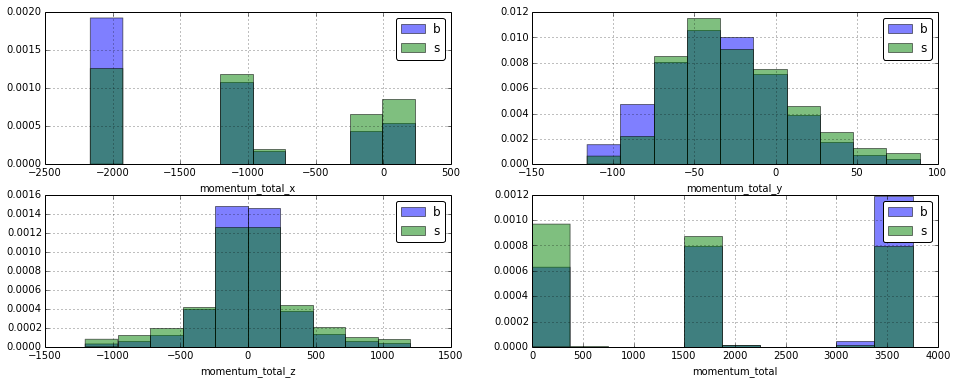

In [50]:
plt.figure(figsize=(16,6))

bamboo.plotting.hist_functions(df_momentum_features[::20].groupby('Label'), momentum_total_features,
                   alpha=0.5, autobin=True, normed=True)

In [51]:
def lep_mass(row):
    delta_cosh_eta = np.cosh(row['PRI_lep_eta'] - row['PRI_tau_eta'])
    delta_cos_phi = np.cos(row['PRI_lep_phi'] - row['PRI_tau_phi'])
    return 2*row['PRI_lep_pt']*row['PRI_tau_pt']*(delta_cosh_eta - delta_cos_phi)

mass_features = [lep_mass]
new_features.extend(mass_features)

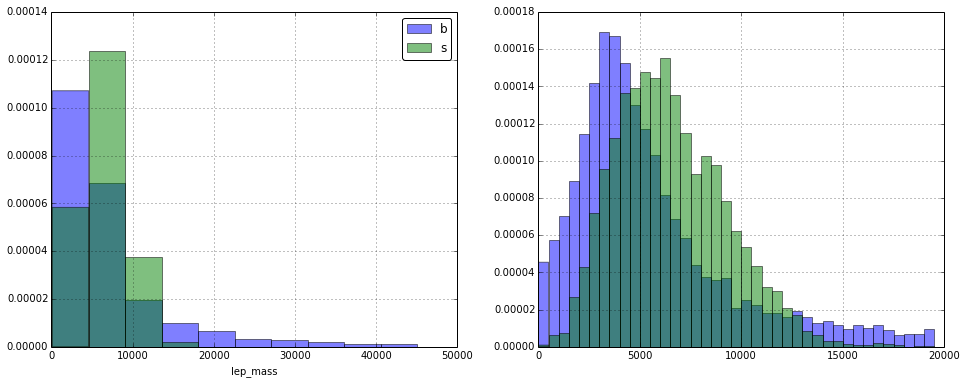

In [52]:
plt.figure(figsize=(16,6))

plt.subplot(1, 2, 1)
bamboo.plotting.hist_functions(df_momentum_features[::20].groupby('Label'), mass_features,
                   alpha=0.5, autobin=True, normed=True, ax=plt.gca())

plt.subplot(1, 2, 2)
bamboo.plotting.hist_functions(df_momentum_features[::20].groupby('Label'), mass_features,
                   alpha=0.5, bins=np.arange(0, 20000, 500), normed=True, ax=plt.gca())

In [53]:
"""
MET -          Missing transverse energy
dphi met lep - Delta phi between the missing transverse energy and lepton
dr tau lep -   Delta R between the tau and the lepton

leadJetP t -   Momentum of the leading jet

mass transverse met lep - Transverse mass from the lepton and missing transverse energy
mass transverse met tau - Transverse mass from the missing transverse energy and tau

mass vis tau lep -        The visible mass from the tau and lepton
pt ratio tau lep -        Ratio of the tau momentum to the lepton momentum
pt vector sum all -       Vector sum of all momentum in the decay

sumP t -           Sum of the momenta
tau fourvect:fE -  Energy of the tau
lep fourvect:fE -  Energy of the lepton
"""

'\nMET -          Missing transverse energy\ndphi met lep - Delta phi between the missing transverse energy and lepton\ndr tau lep -   Delta R between the tau and the lepton\n\nleadJetP t -   Momentum of the leading jet\n\nmass transverse met lep - Transverse mass from the lepton and missing transverse energy\nmass transverse met tau - Transverse mass from the missing transverse energy and tau\n\nmass vis tau lep -        The visible mass from the tau and lepton\npt ratio tau lep -        Ratio of the tau momentum to the lepton momentum\npt vector sum all -       Vector sum of all momentum in the decay\n\nsumP t -           Sum of the momenta\ntau fourvect:fE -  Energy of the tau\nlep fourvect:fE -  Energy of the lepton\n'

In [54]:
def transverse_mass_lep(row):
    lep_pt = np.sqrt(row['PRI_lep_px']*row['PRI_lep_px'] + row['PRI_lep_py']*row['PRI_lep_py'])
    return np.sqrt(2*lep_pt*row['PRI_met'] * (1 - (np.cos(row['PRI_met_phi'] - row['PRI_lep_phi']))))

def transverse_mass_tau(row):
    tau_pt = np.sqrt(row['PRI_tau_px']*row['PRI_tau_px'] + row['PRI_tau_py']*row['PRI_tau_py'])
    return np.sqrt(2*tau_pt*row['PRI_met'] * (1 - np.cos(row['PRI_met_phi'] - row['PRI_tau_phi'])))

def transverse_mass_jet_leading(row):
    lep_pt = np.sqrt(row['PRI_jet_leading_px']*row['PRI_jet_leading_px'] + row['PRI_jet_leading_py']*row['PRI_jet_leading_py'])
    return np.sqrt(2*lep_pt*row['PRI_met'] * (1 - (np.cos(row['PRI_met_phi'] - row['PRI_jet_leading_phi']))))

def transverse_mass_jet_subleading(row):
    lep_pt = np.sqrt(row['PRI_jet_subleading_px']*row['PRI_jet_subleading_px'] + row['PRI_jet_subleading_py']*row['PRI_jet_subleading_py'])
    return np.sqrt(2*lep_pt*row['PRI_met'] * (1 - (np.cos(row['PRI_met_phi'] - row['PRI_jet_subleading_phi']))))


tau_mass = 1.7

def tau_fourenergy(row):
    tau_2 = row['PRI_tau_px']*row['PRI_tau_px'] + row['PRI_tau_py']*row['PRI_tau_py'] + row['PRI_tau_pz']*row['PRI_tau_pz']
    return np.sqrt(tau_mass*tau_mass + tau_2)

def lep_fourenergy(row):
    lep_2 = row['PRI_lep_px']*row['PRI_lep_px'] + row['PRI_lep_py']*row['PRI_lep_py'] + row['PRI_lep_pz']*row['PRI_lep_pz']
    return np.sqrt(tau_mass*tau_mass + lep_2)

transverse_mass_features = [transverse_mass_lep, transverse_mass_tau, transverse_mass_jet_leading, transverse_mass_jet_subleading, 
                            tau_fourenergy, lep_fourenergy]
new_features.extend(transverse_mass_features)

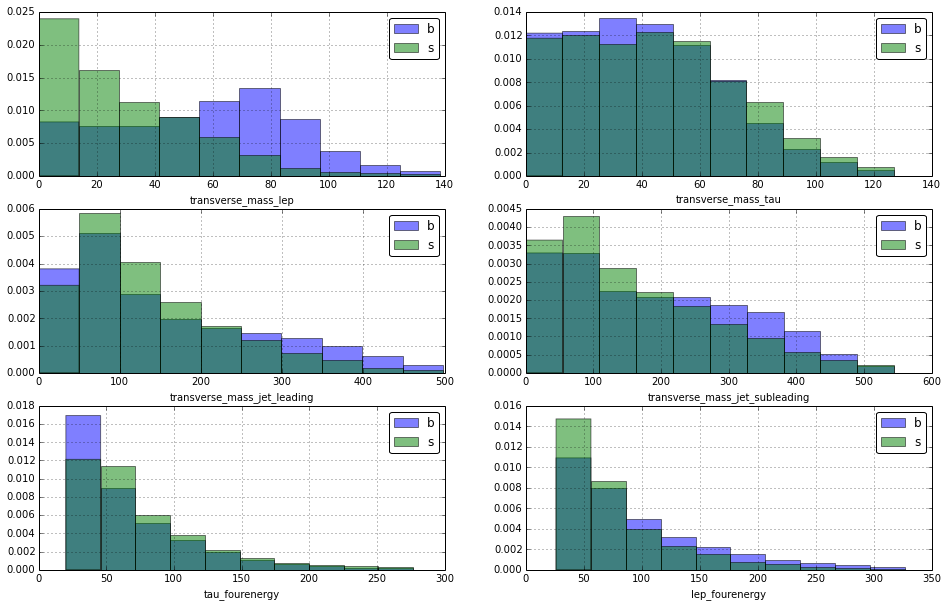

In [55]:
plt.figure(figsize=(16,10))

bamboo.plotting.hist_functions(df_momentum_features[::20].groupby('Label'), transverse_mass_features,
                   alpha=0.5, autobin=True, normed=True)

# Running With All Features

In [56]:
print [feature.__name__ for feature in new_features]

['jet_eta_plus', 'lep_tau_eta_plus', 'lep_z_momentum', 'jet_z_momentum', 'jet_lep_sum_z_momentum', 'jet_lep_diff_z_momentum', 'max_jet_pt', 'min_jet_pt', 'max_lep_pt', 'min_lep_pt', 'max_pt', 'min_pt', 'sum_jet_pt', 'sum_lep_pt', 'frac_tau_pt', 'frac_lep_pt', 'frac_tau_p', 'frac_lep_p', 'prijet_subjet_pt_ratio', 'subjet_prijet_pt_ratio', 'ht', 'ht_met', 'met_sig', 'sumet_sum_pt_ratio', 'met_pt_total_ratio', 'tau_met_cos_phi', 'lep_met_cos_phi', 'jet_leading_met_cos_phi', 'jet_subleading_met_cos_phi', 'min_met_cos_phi', 'max_met_cos_phi', 'prijet_subjet_delta_cos_phi', 'prijet_tau_delta_cos_phi', 'prijet_lep_delta_cos_phi', 'subjet_lep_delta_cos_phi', 'subjet_lep_delta_cos_phi', 'lep_tau_delta_cos_phi', 'prijet_subjet_delta_eta', 'prijet_tau_delta_eta', 'prijet_lep_delta_eta', 'subjet_lep_delta_eta', 'subjet_lep_delta_eta', 'lep_tau_delta_eta', 'lep_momentum', 'tau_momentum', 'prijet_momentum', 'subjet_momentum', 'momentum_total_x', 'momentum_total_y', 'momentum_total_z', 'momentum_tota

In [57]:
from bamboo.data import map_functions

def with_new_features(df):
    return df.join(map_functions(df, new_features))

In [58]:
from bamboo.bamboo import threading
df_all_features = threading(df,
                            with_momentum_features,
                            with_new_features)

In [59]:
all_features, _ = get_features_and_targets(df_all_features)

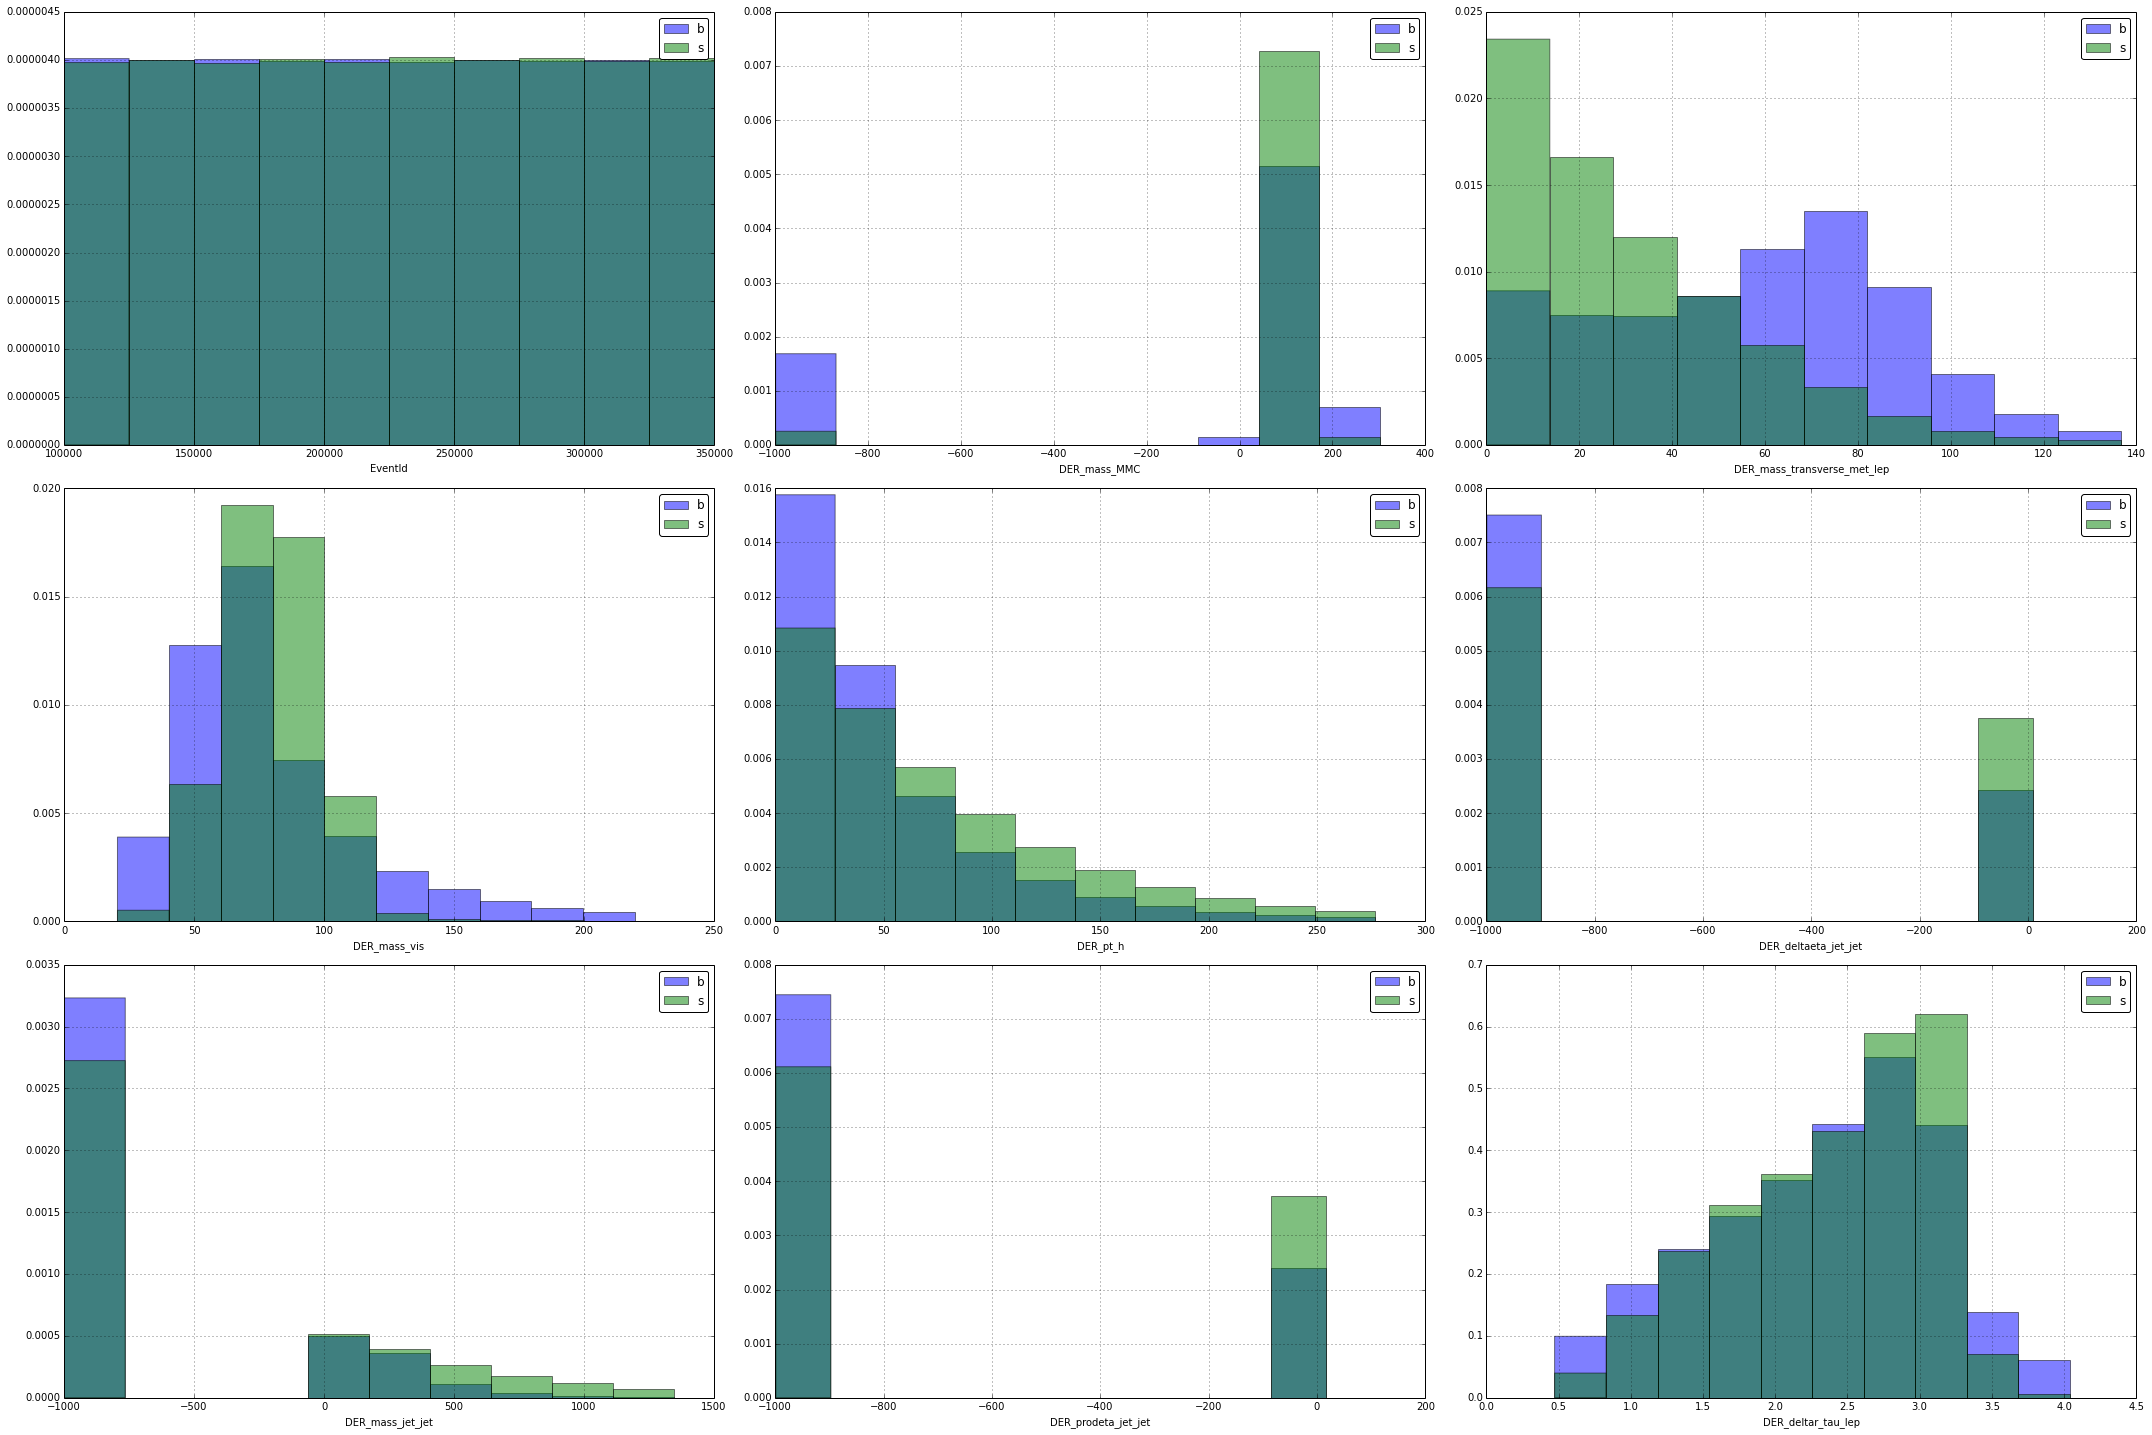

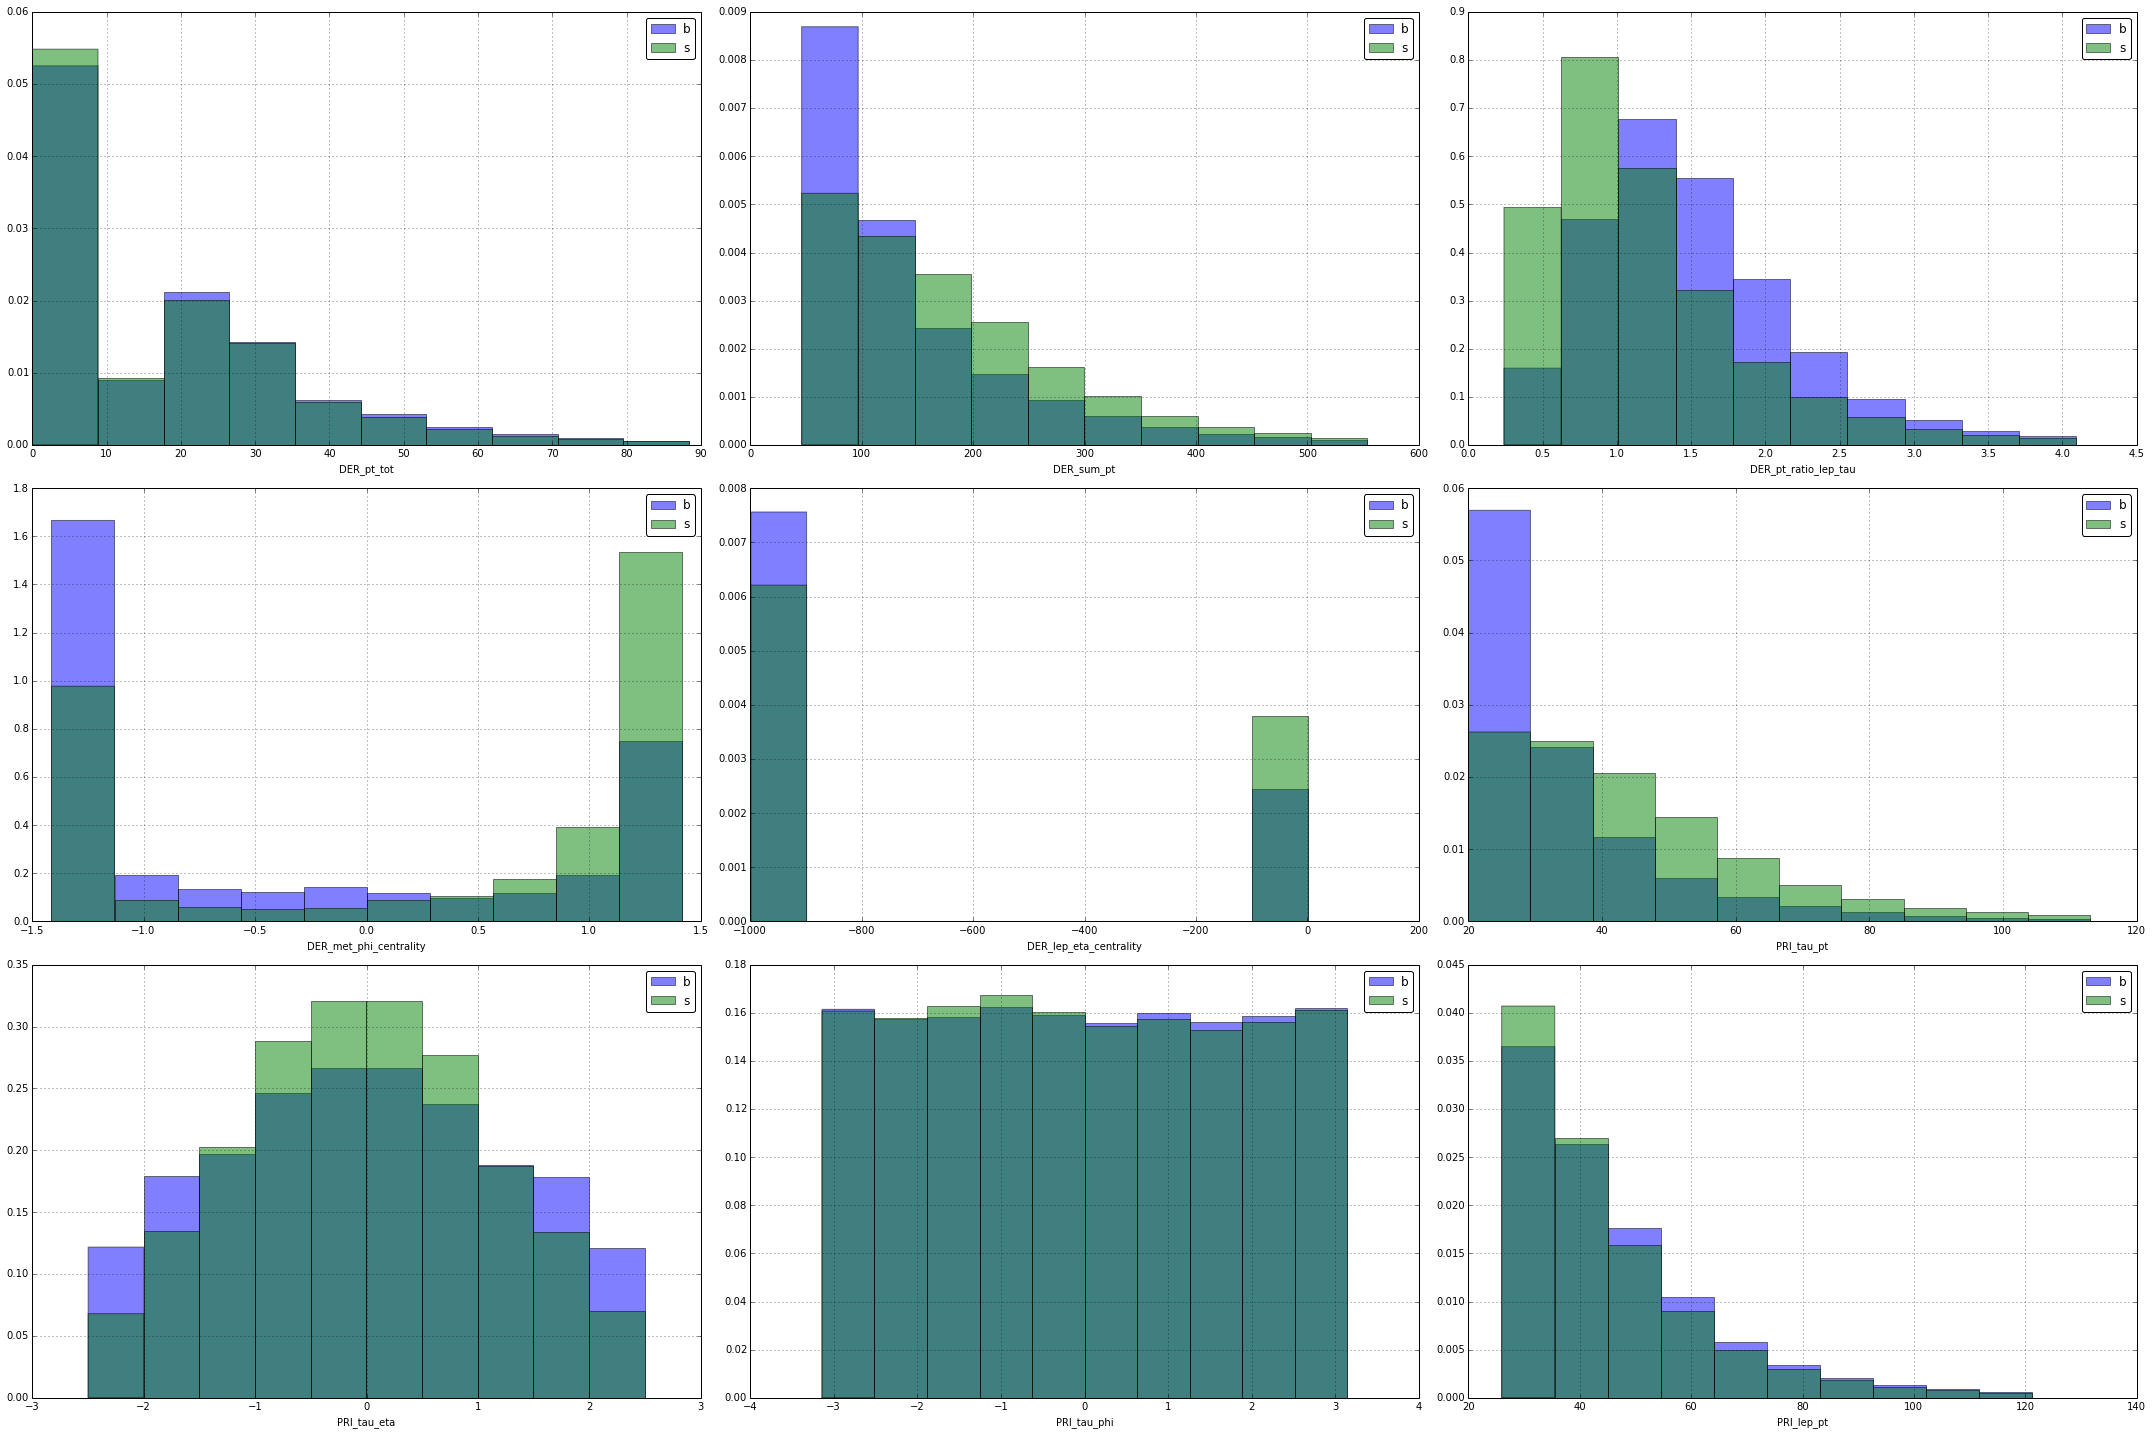

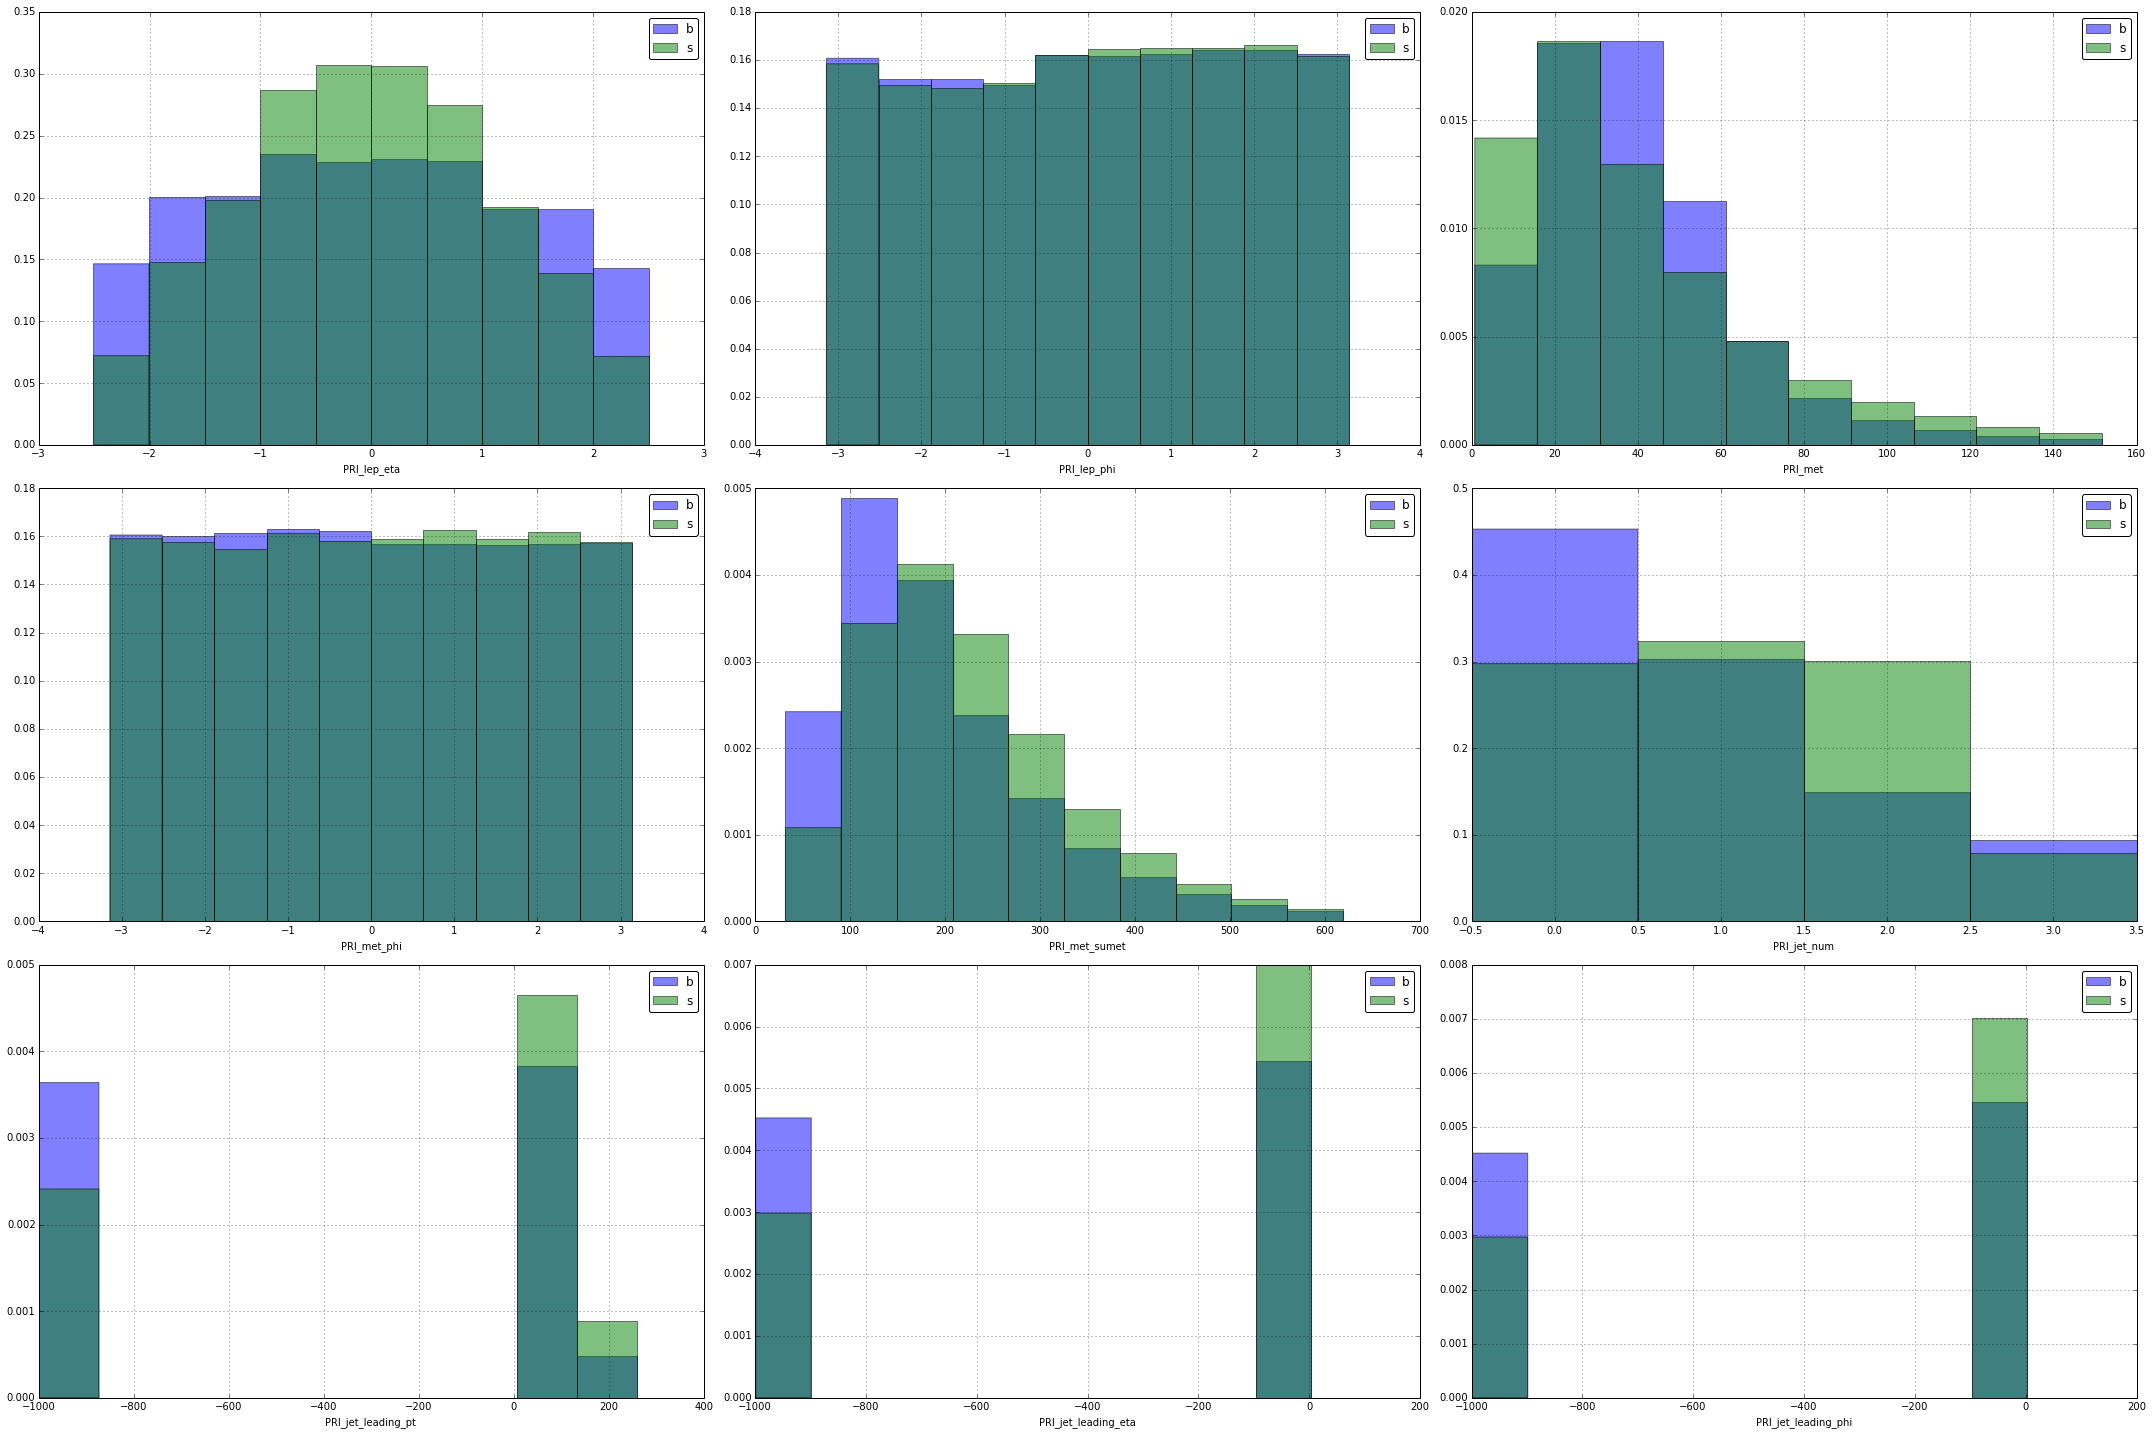

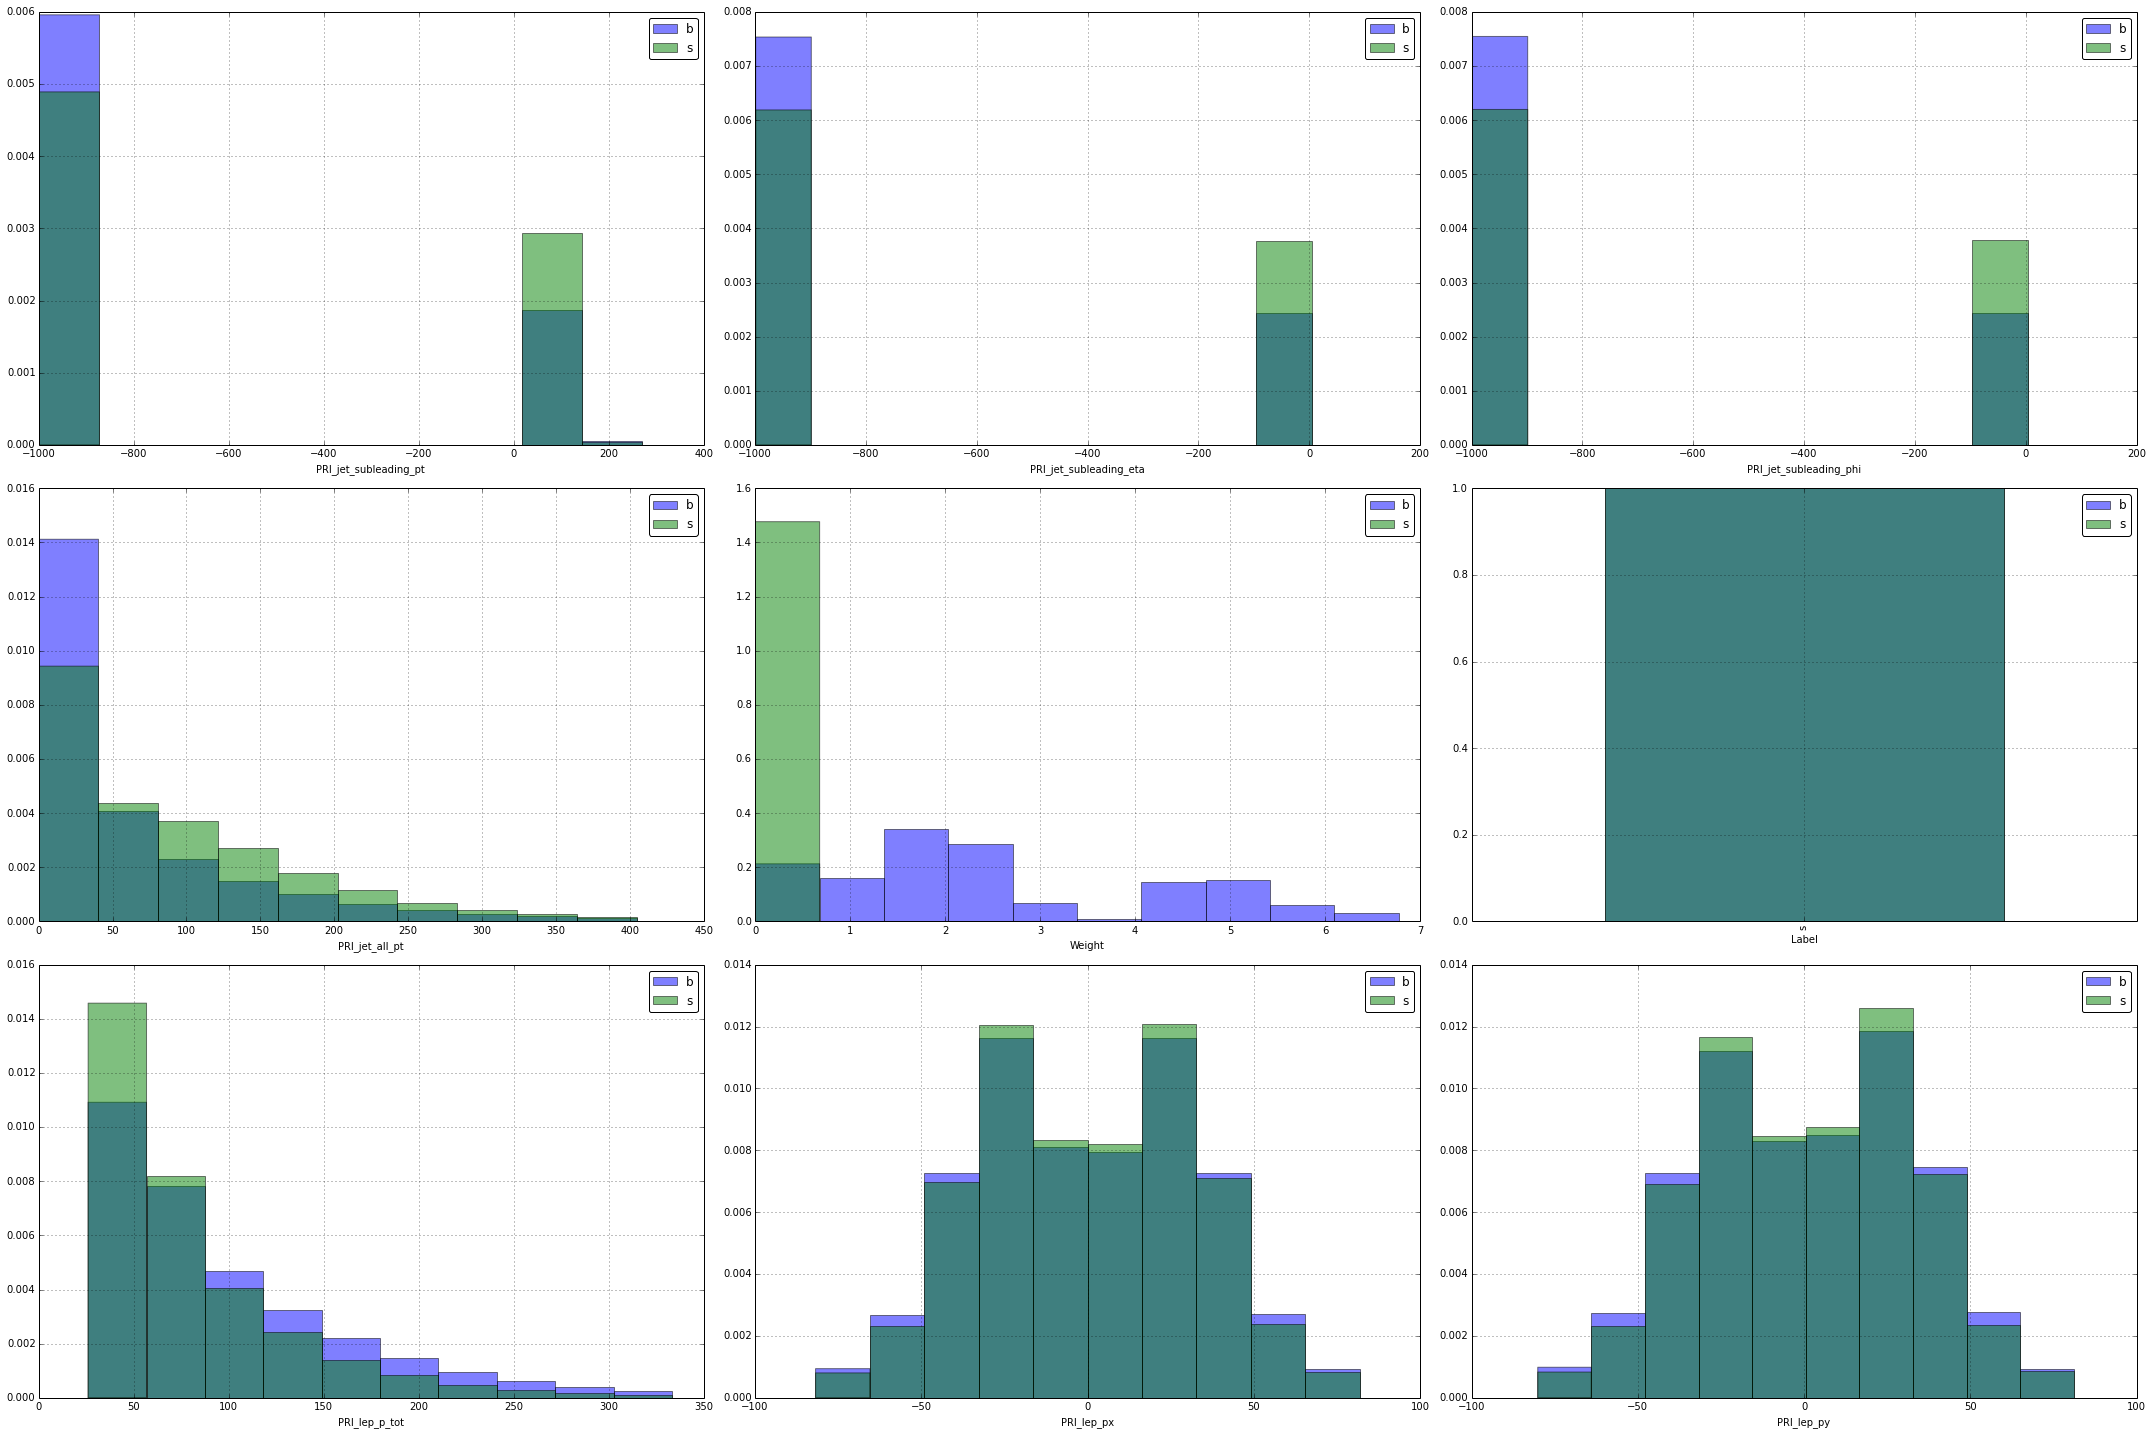

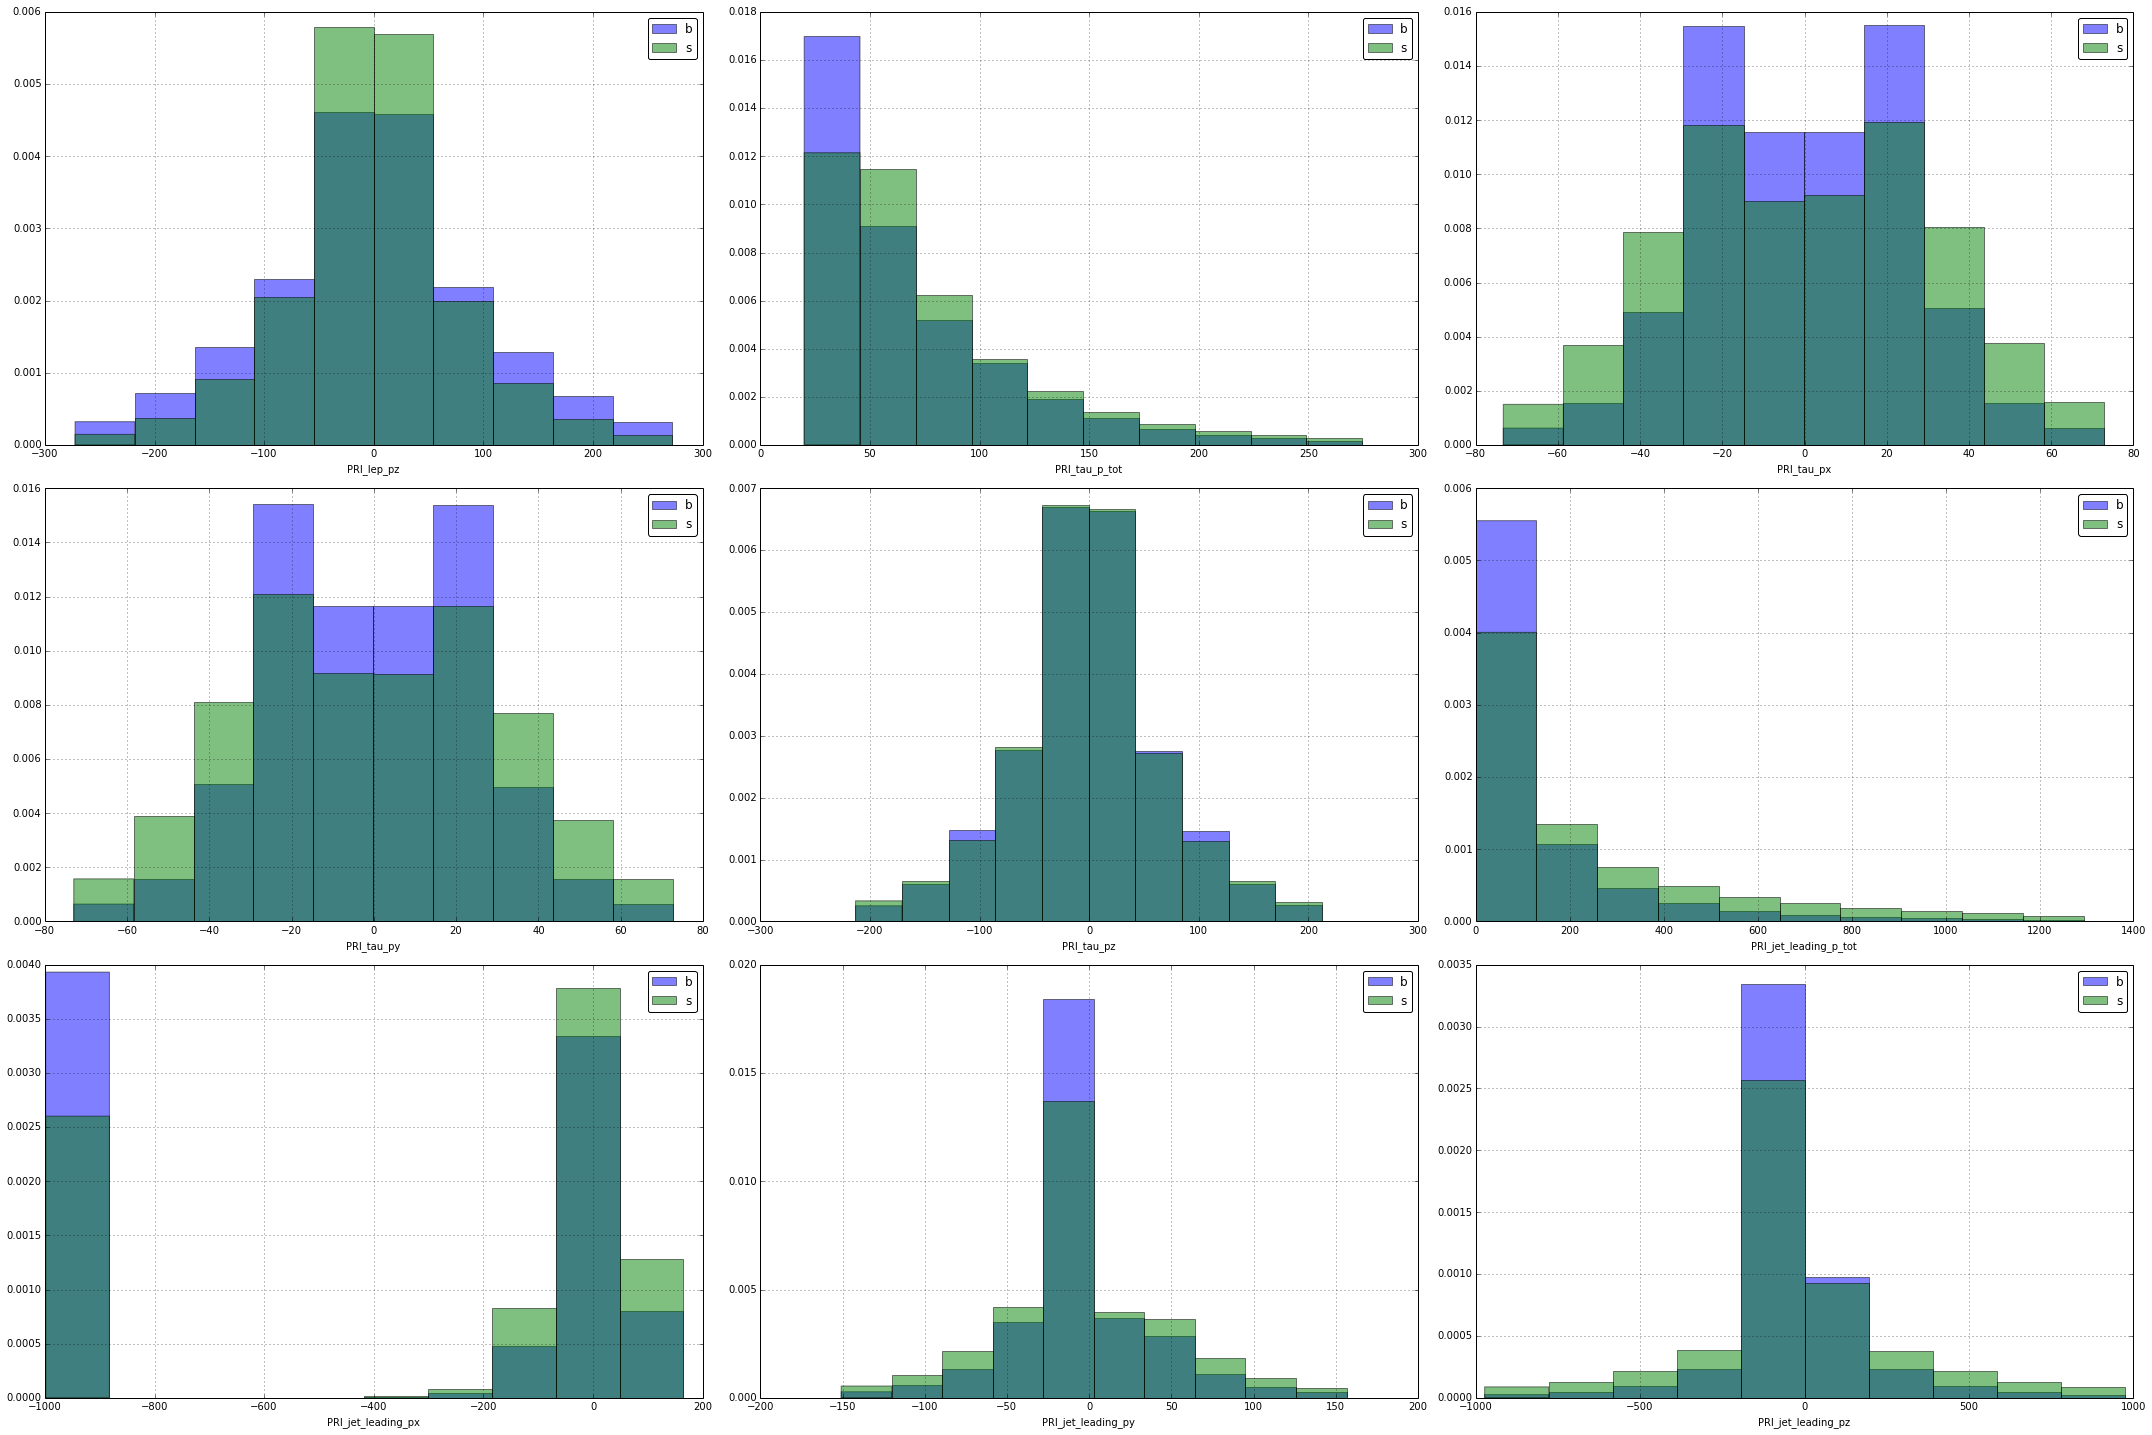

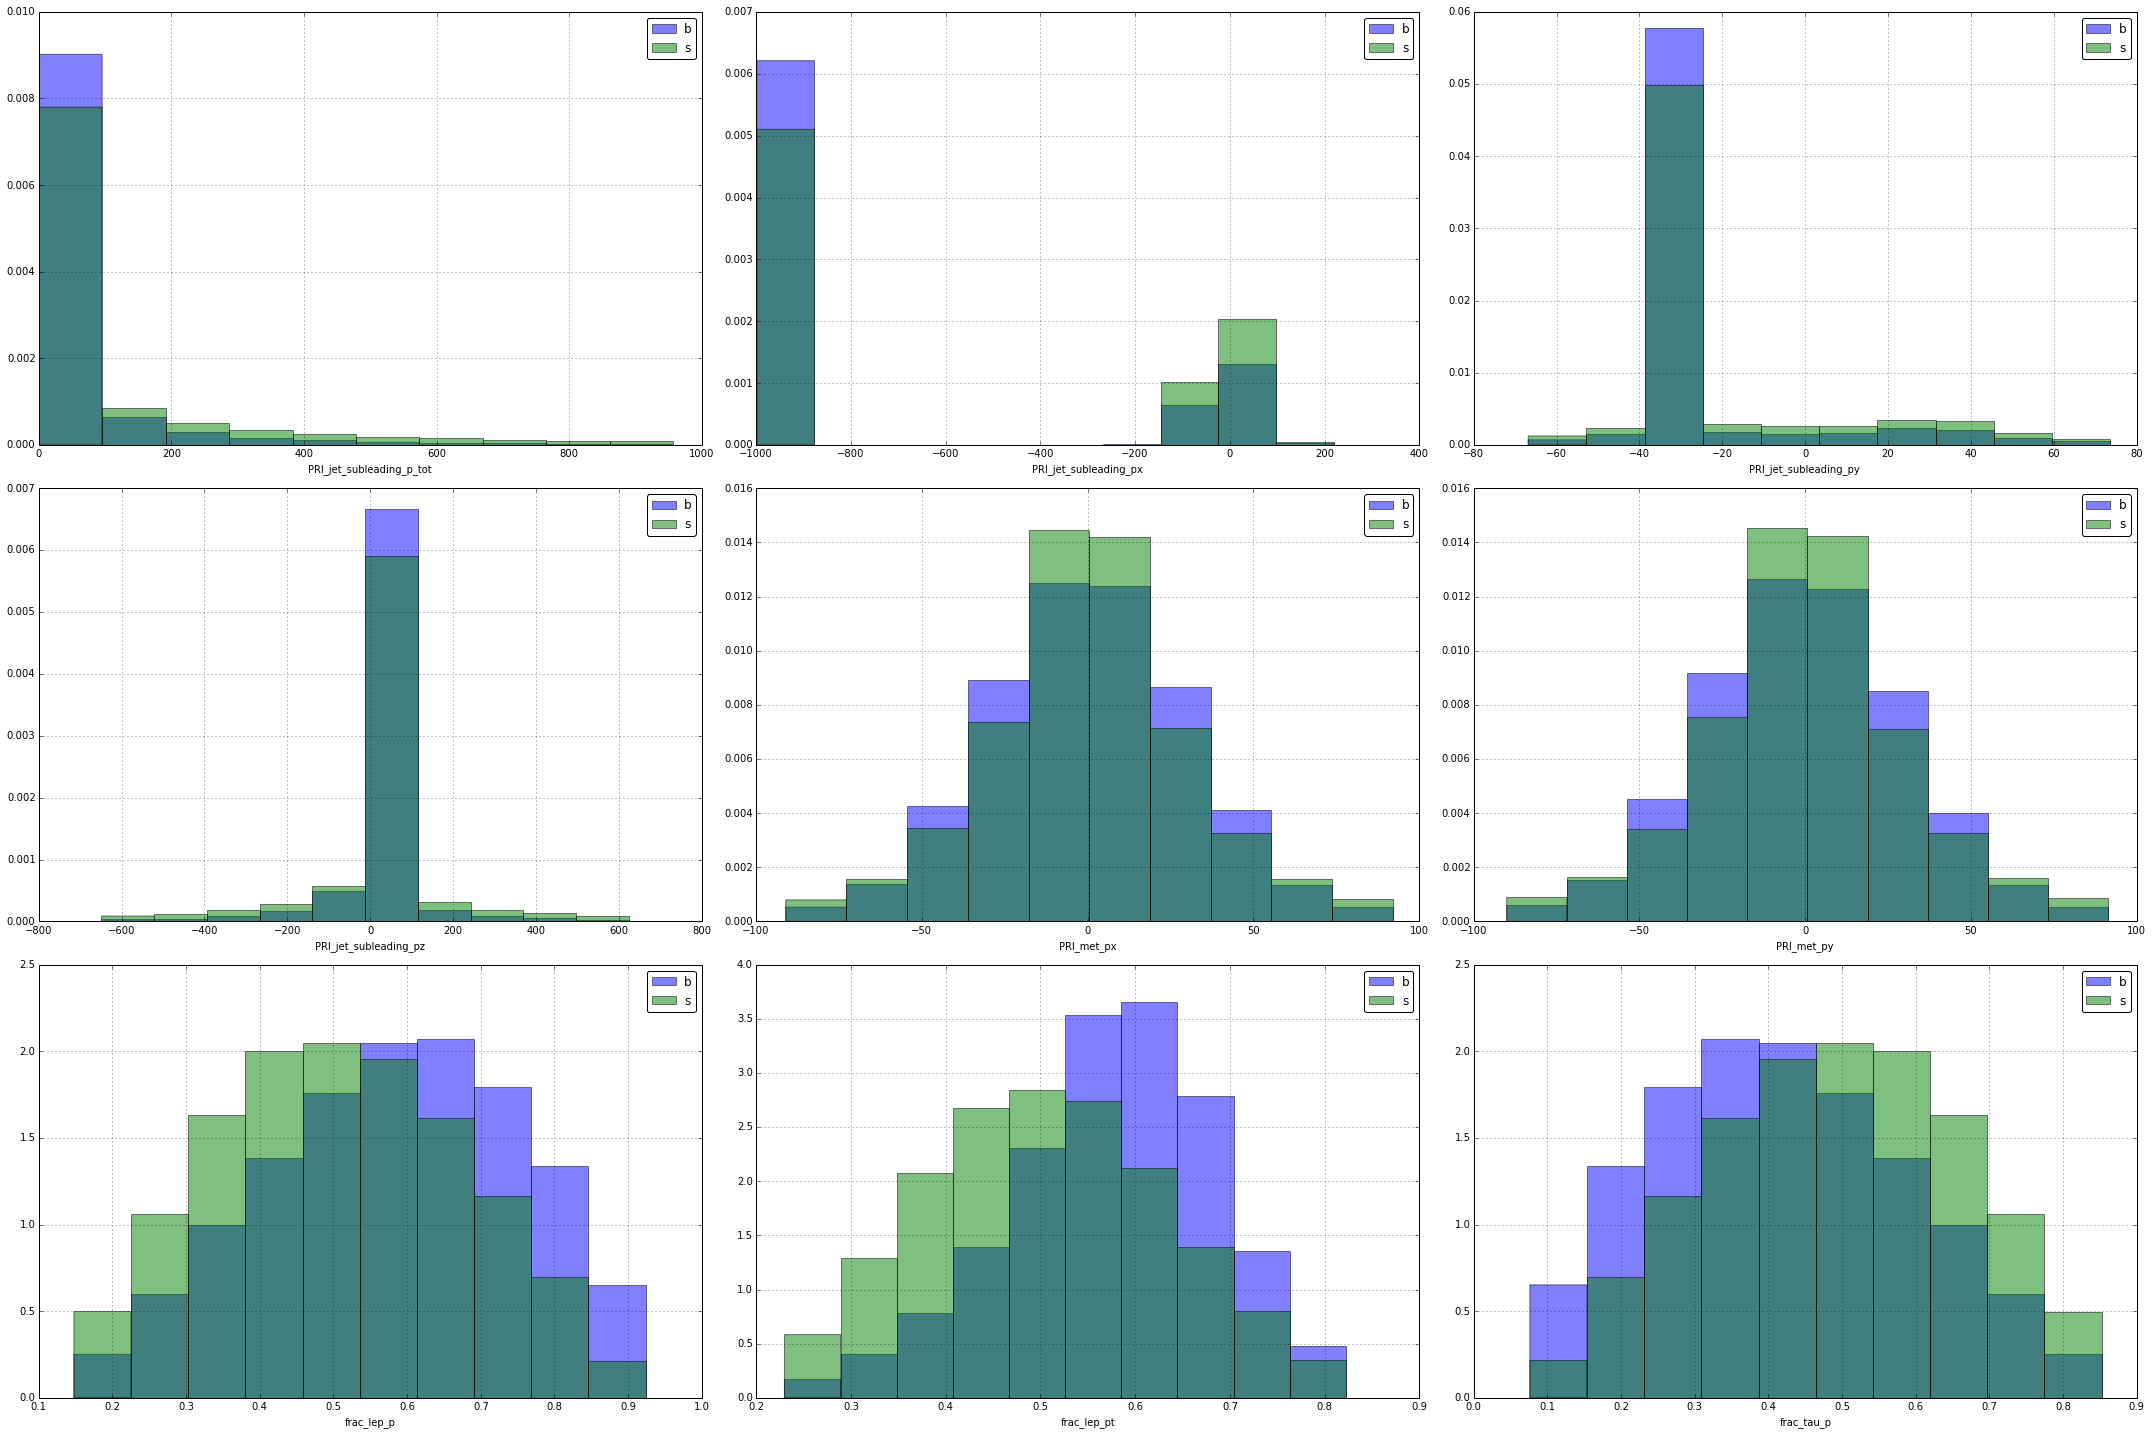

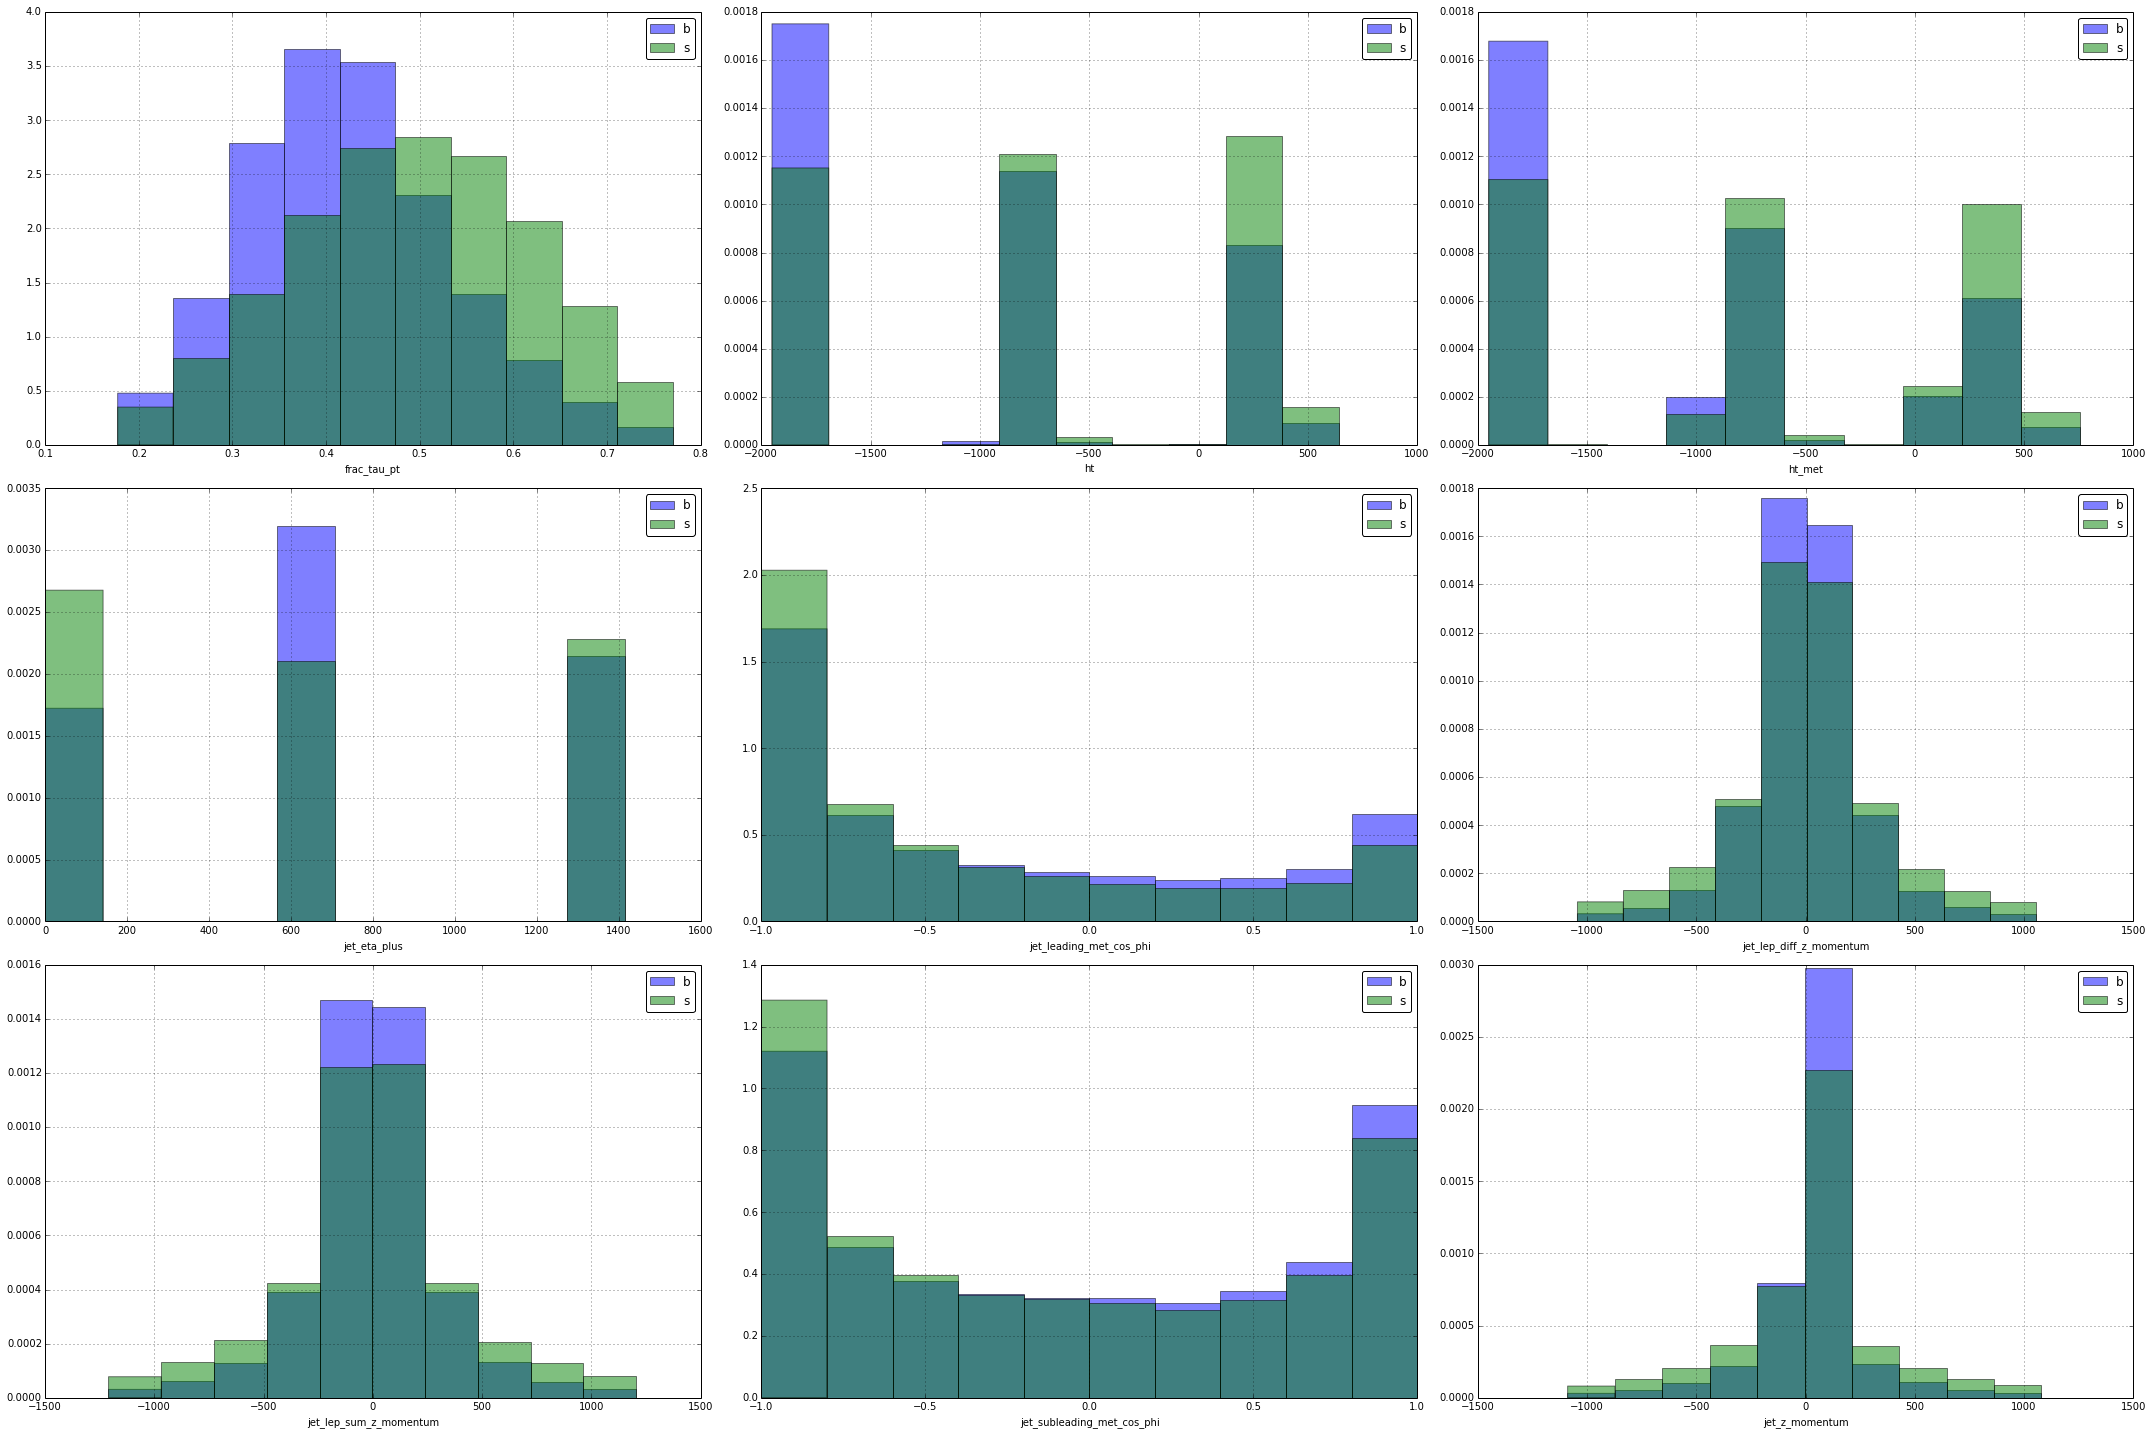

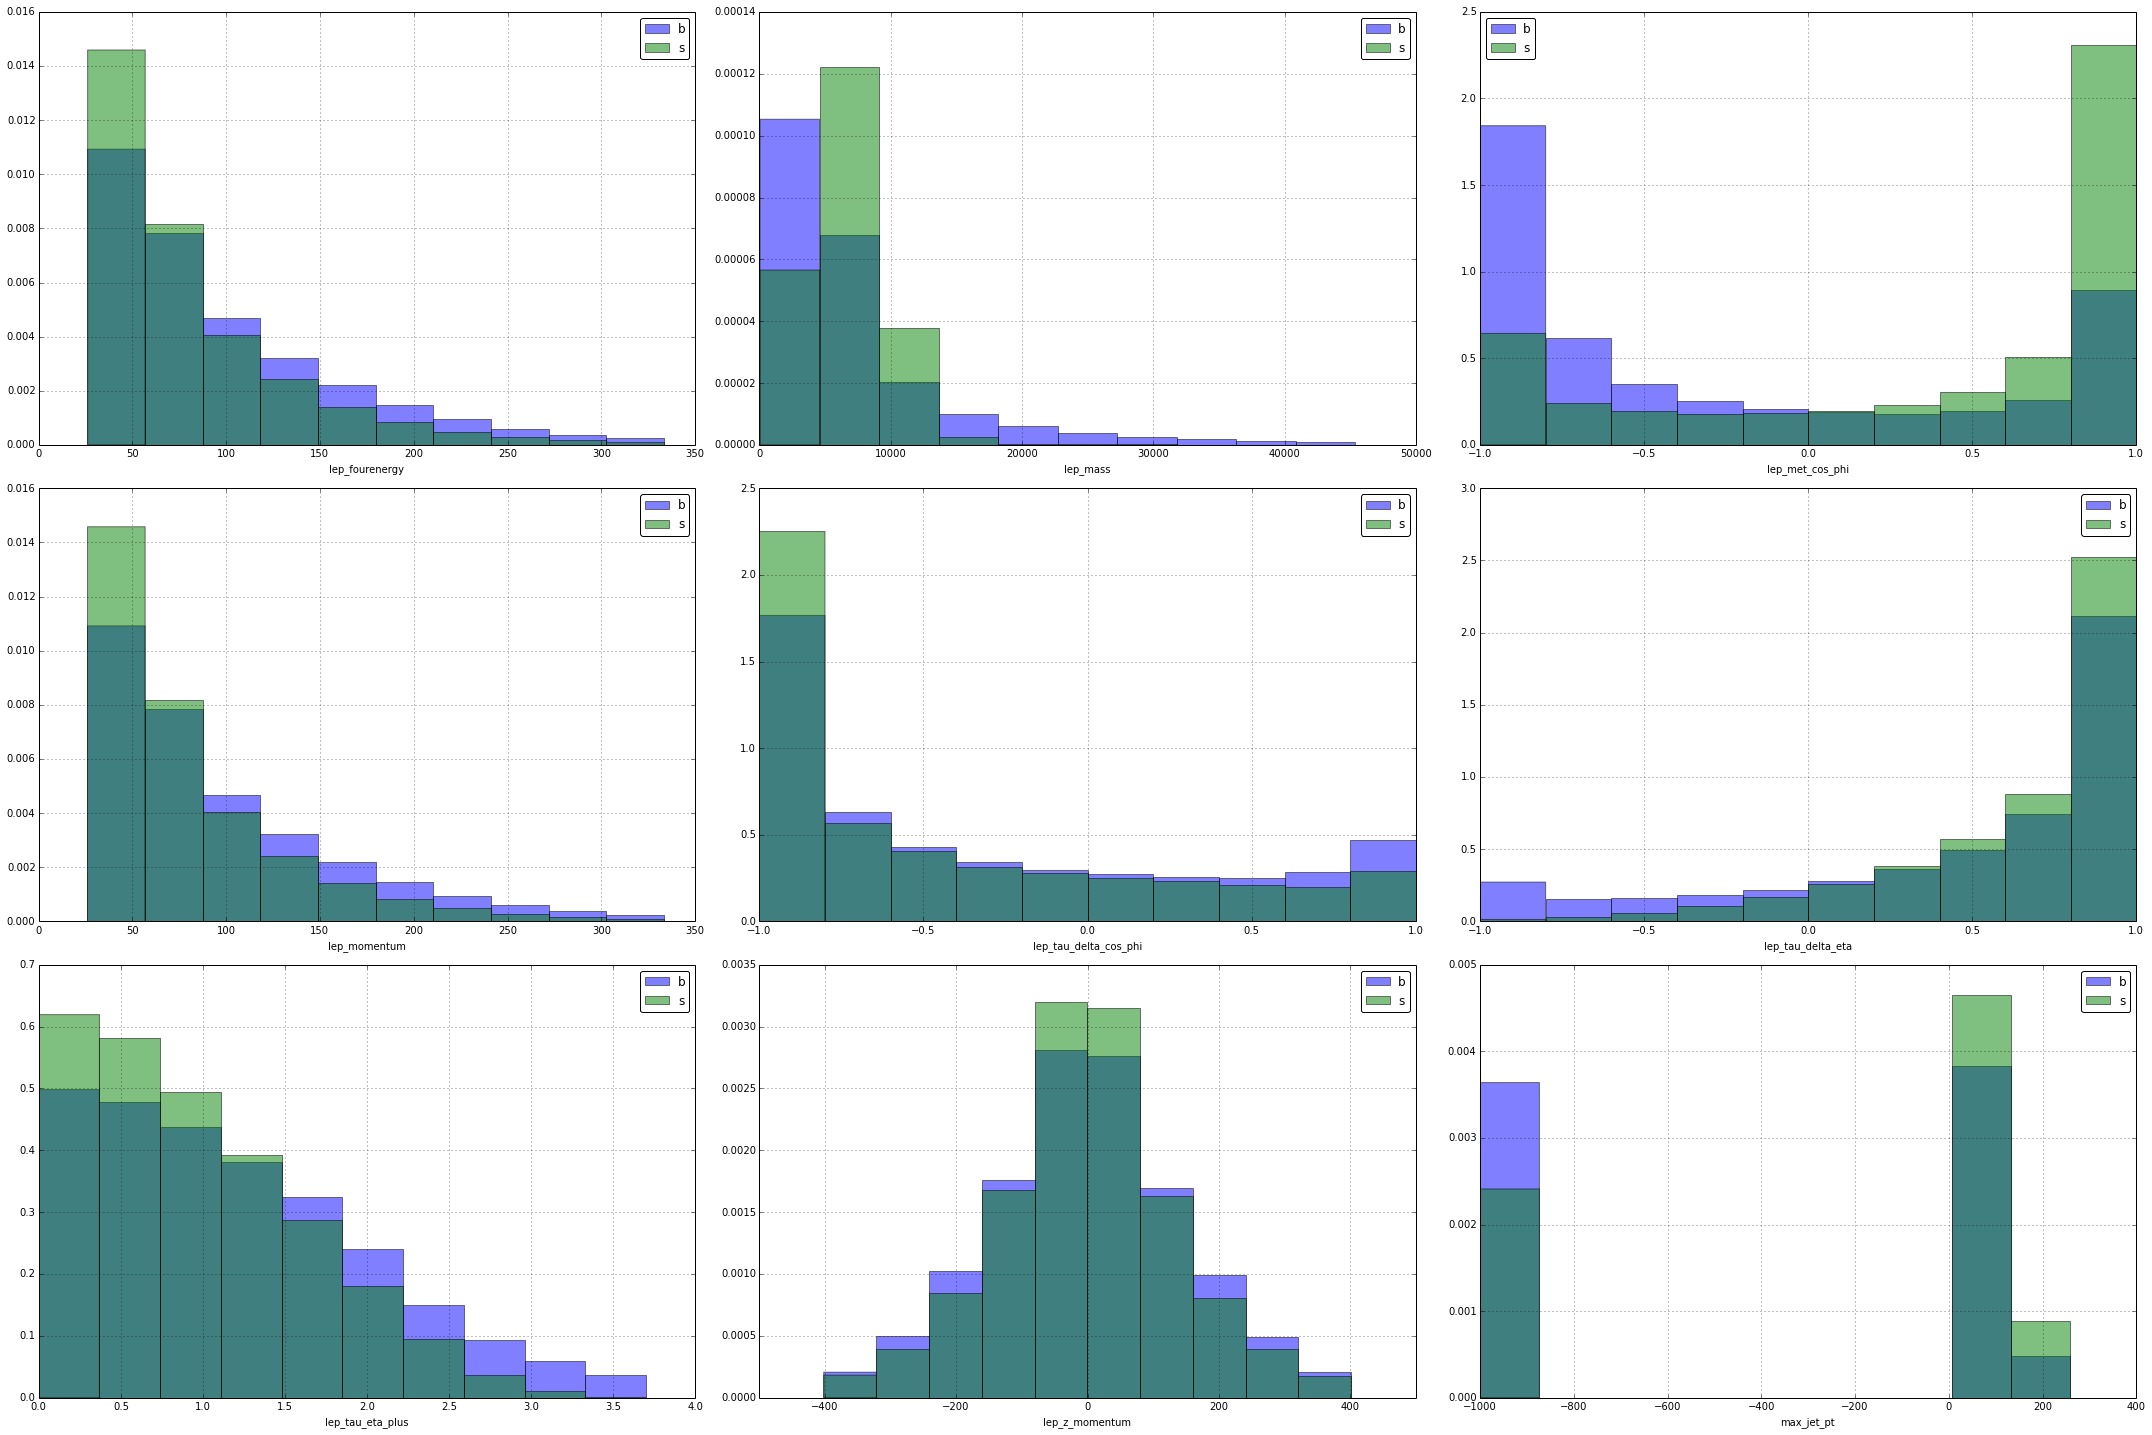

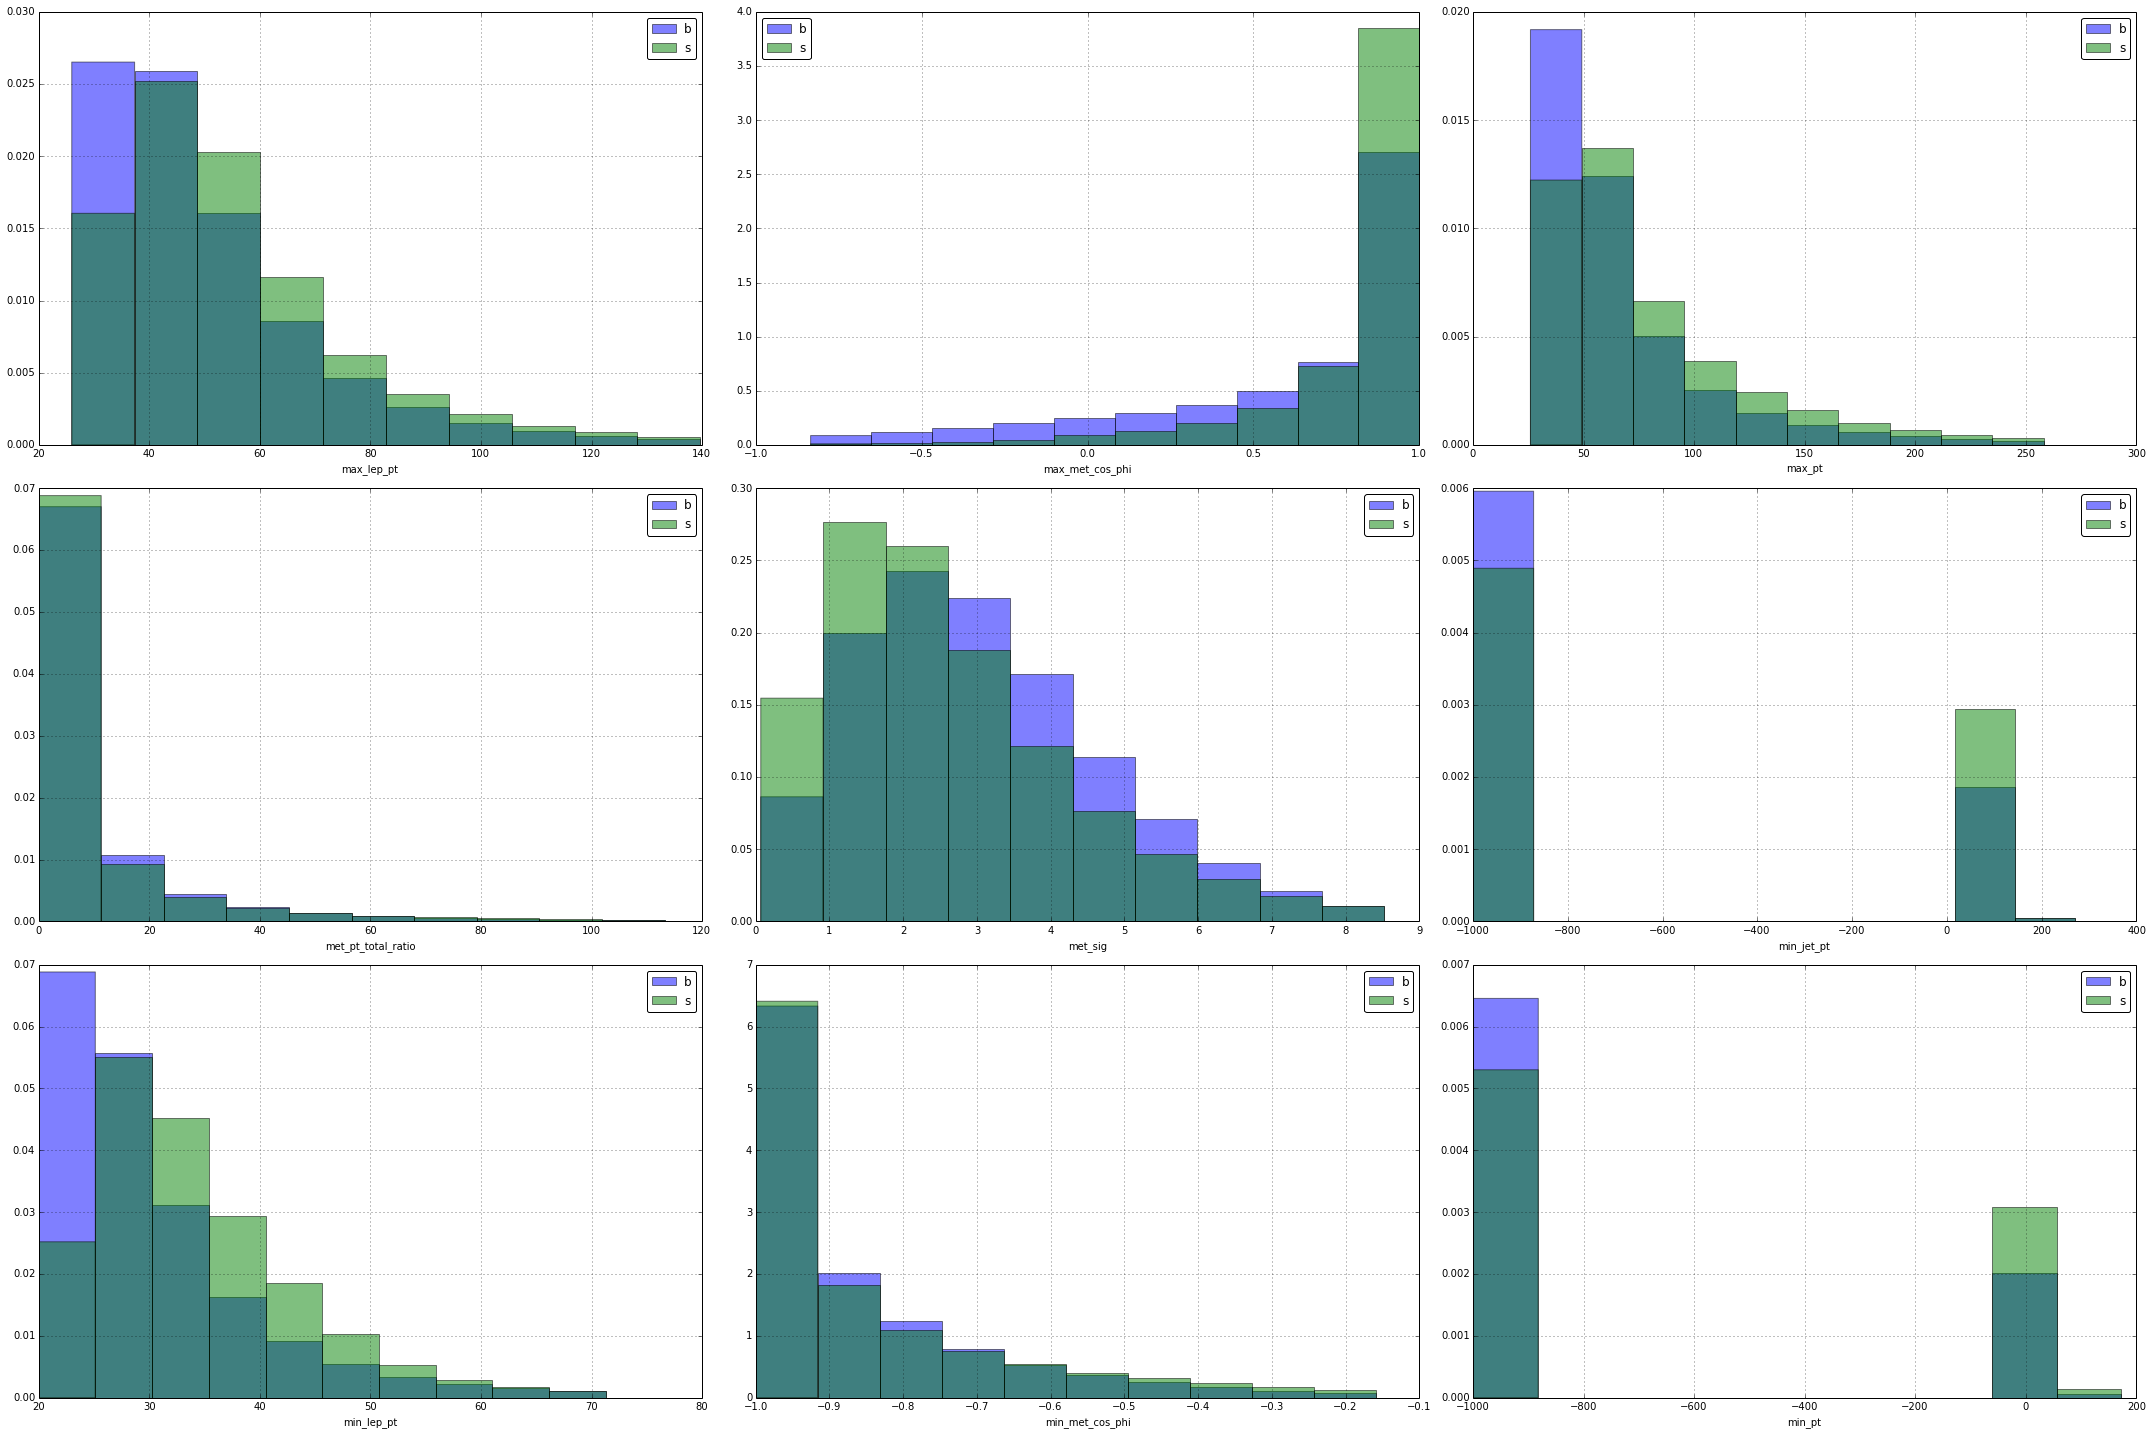

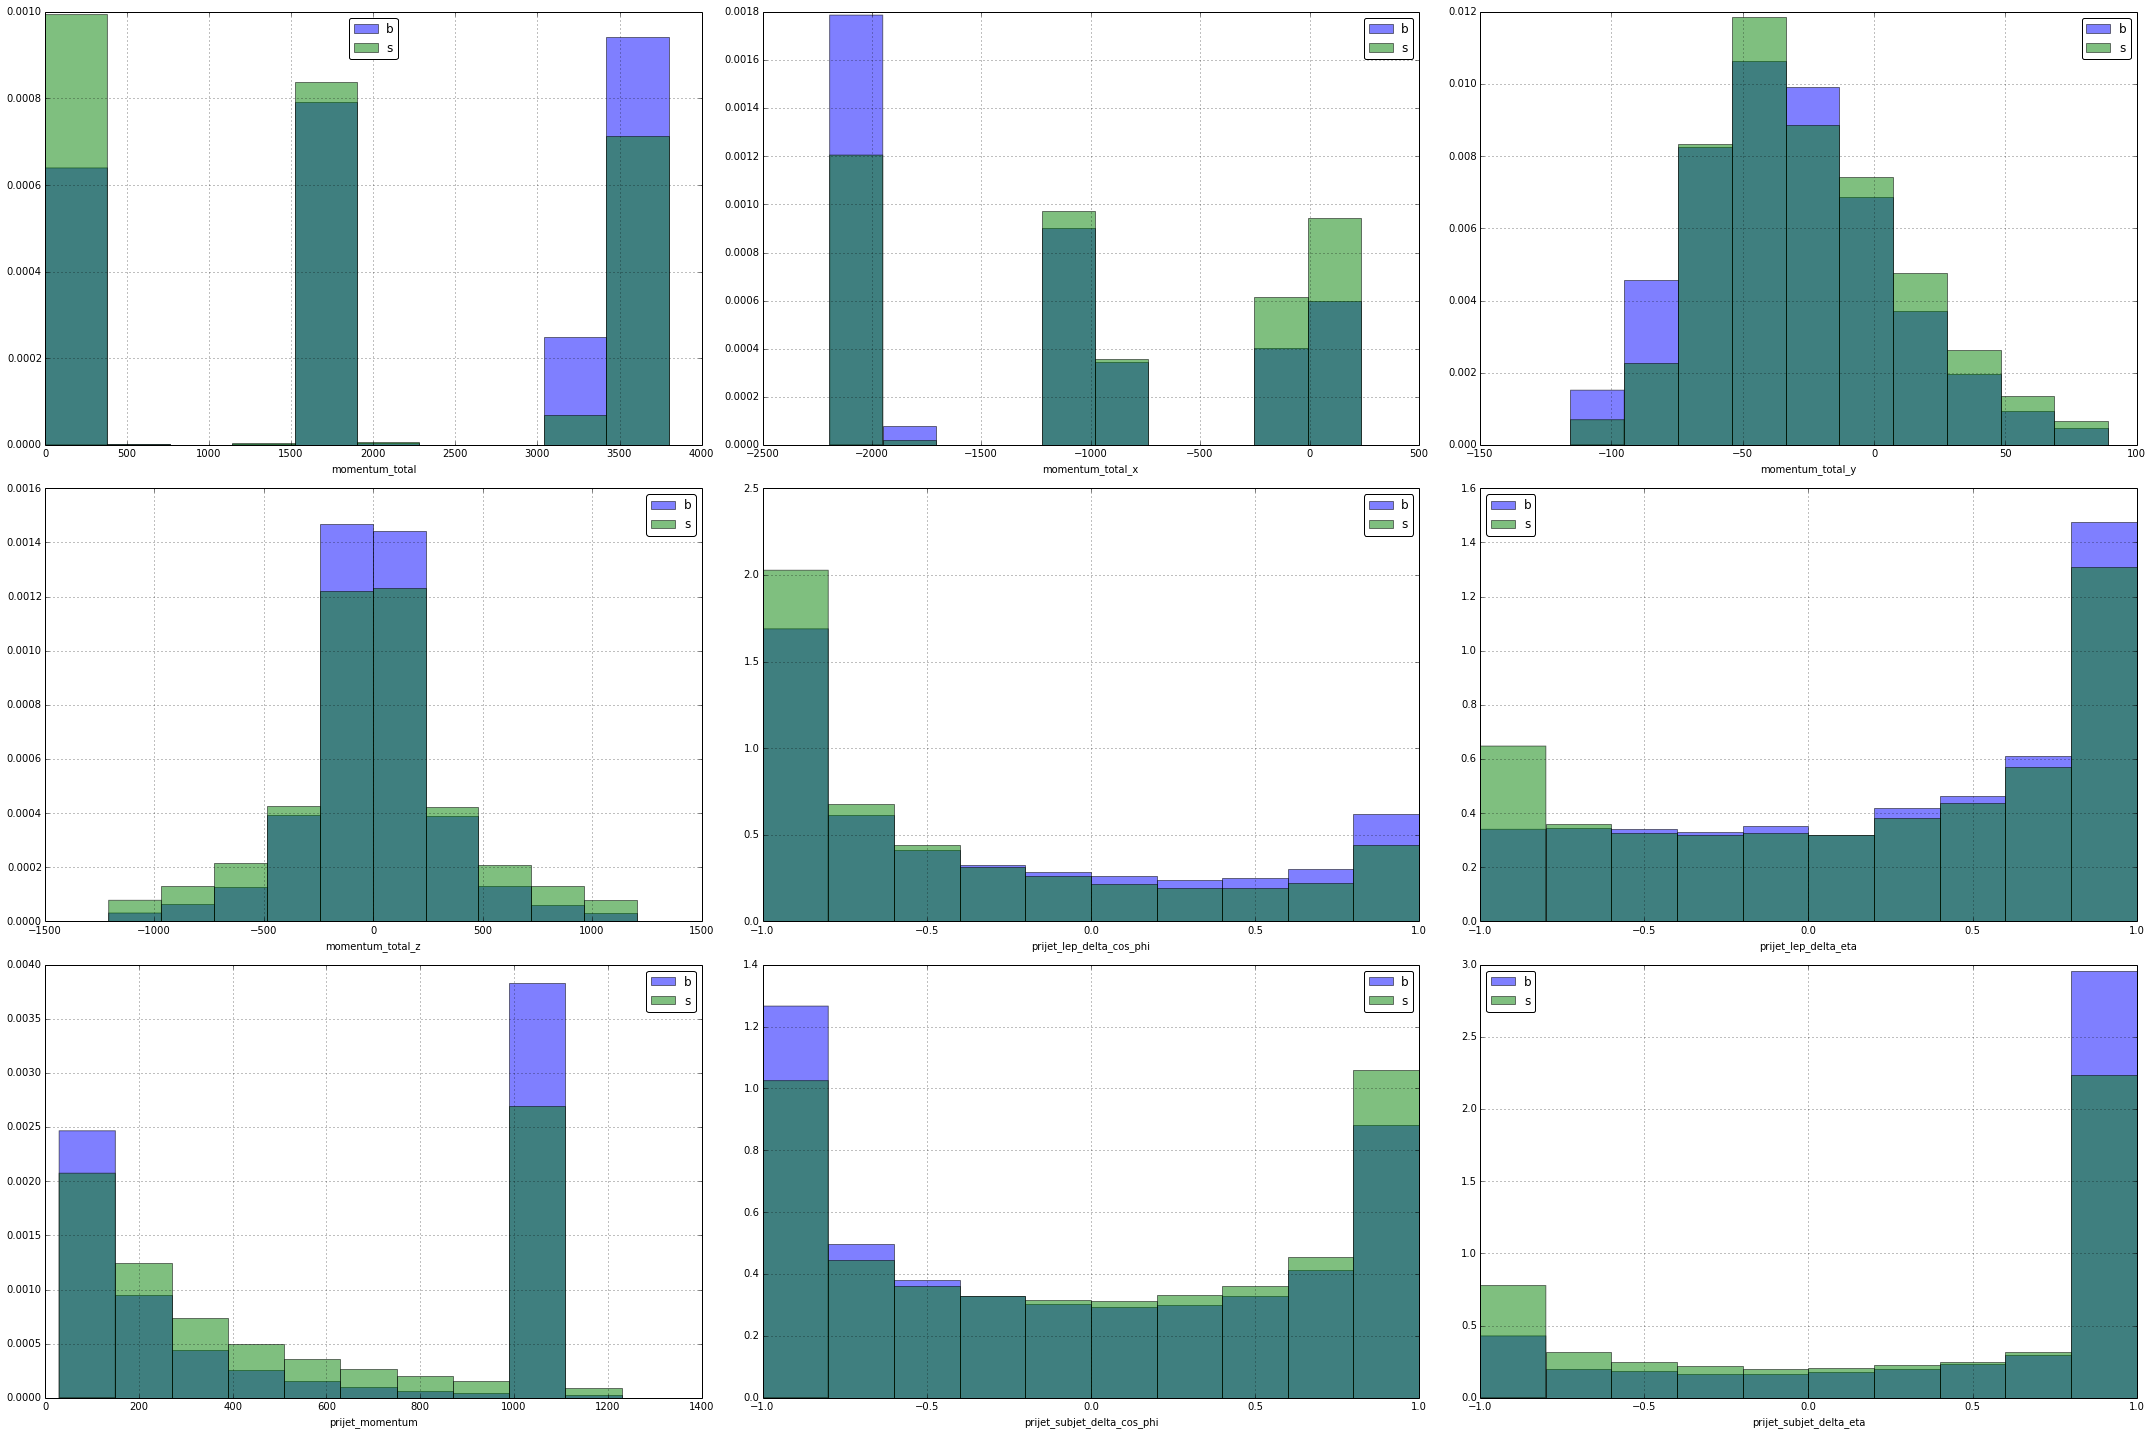

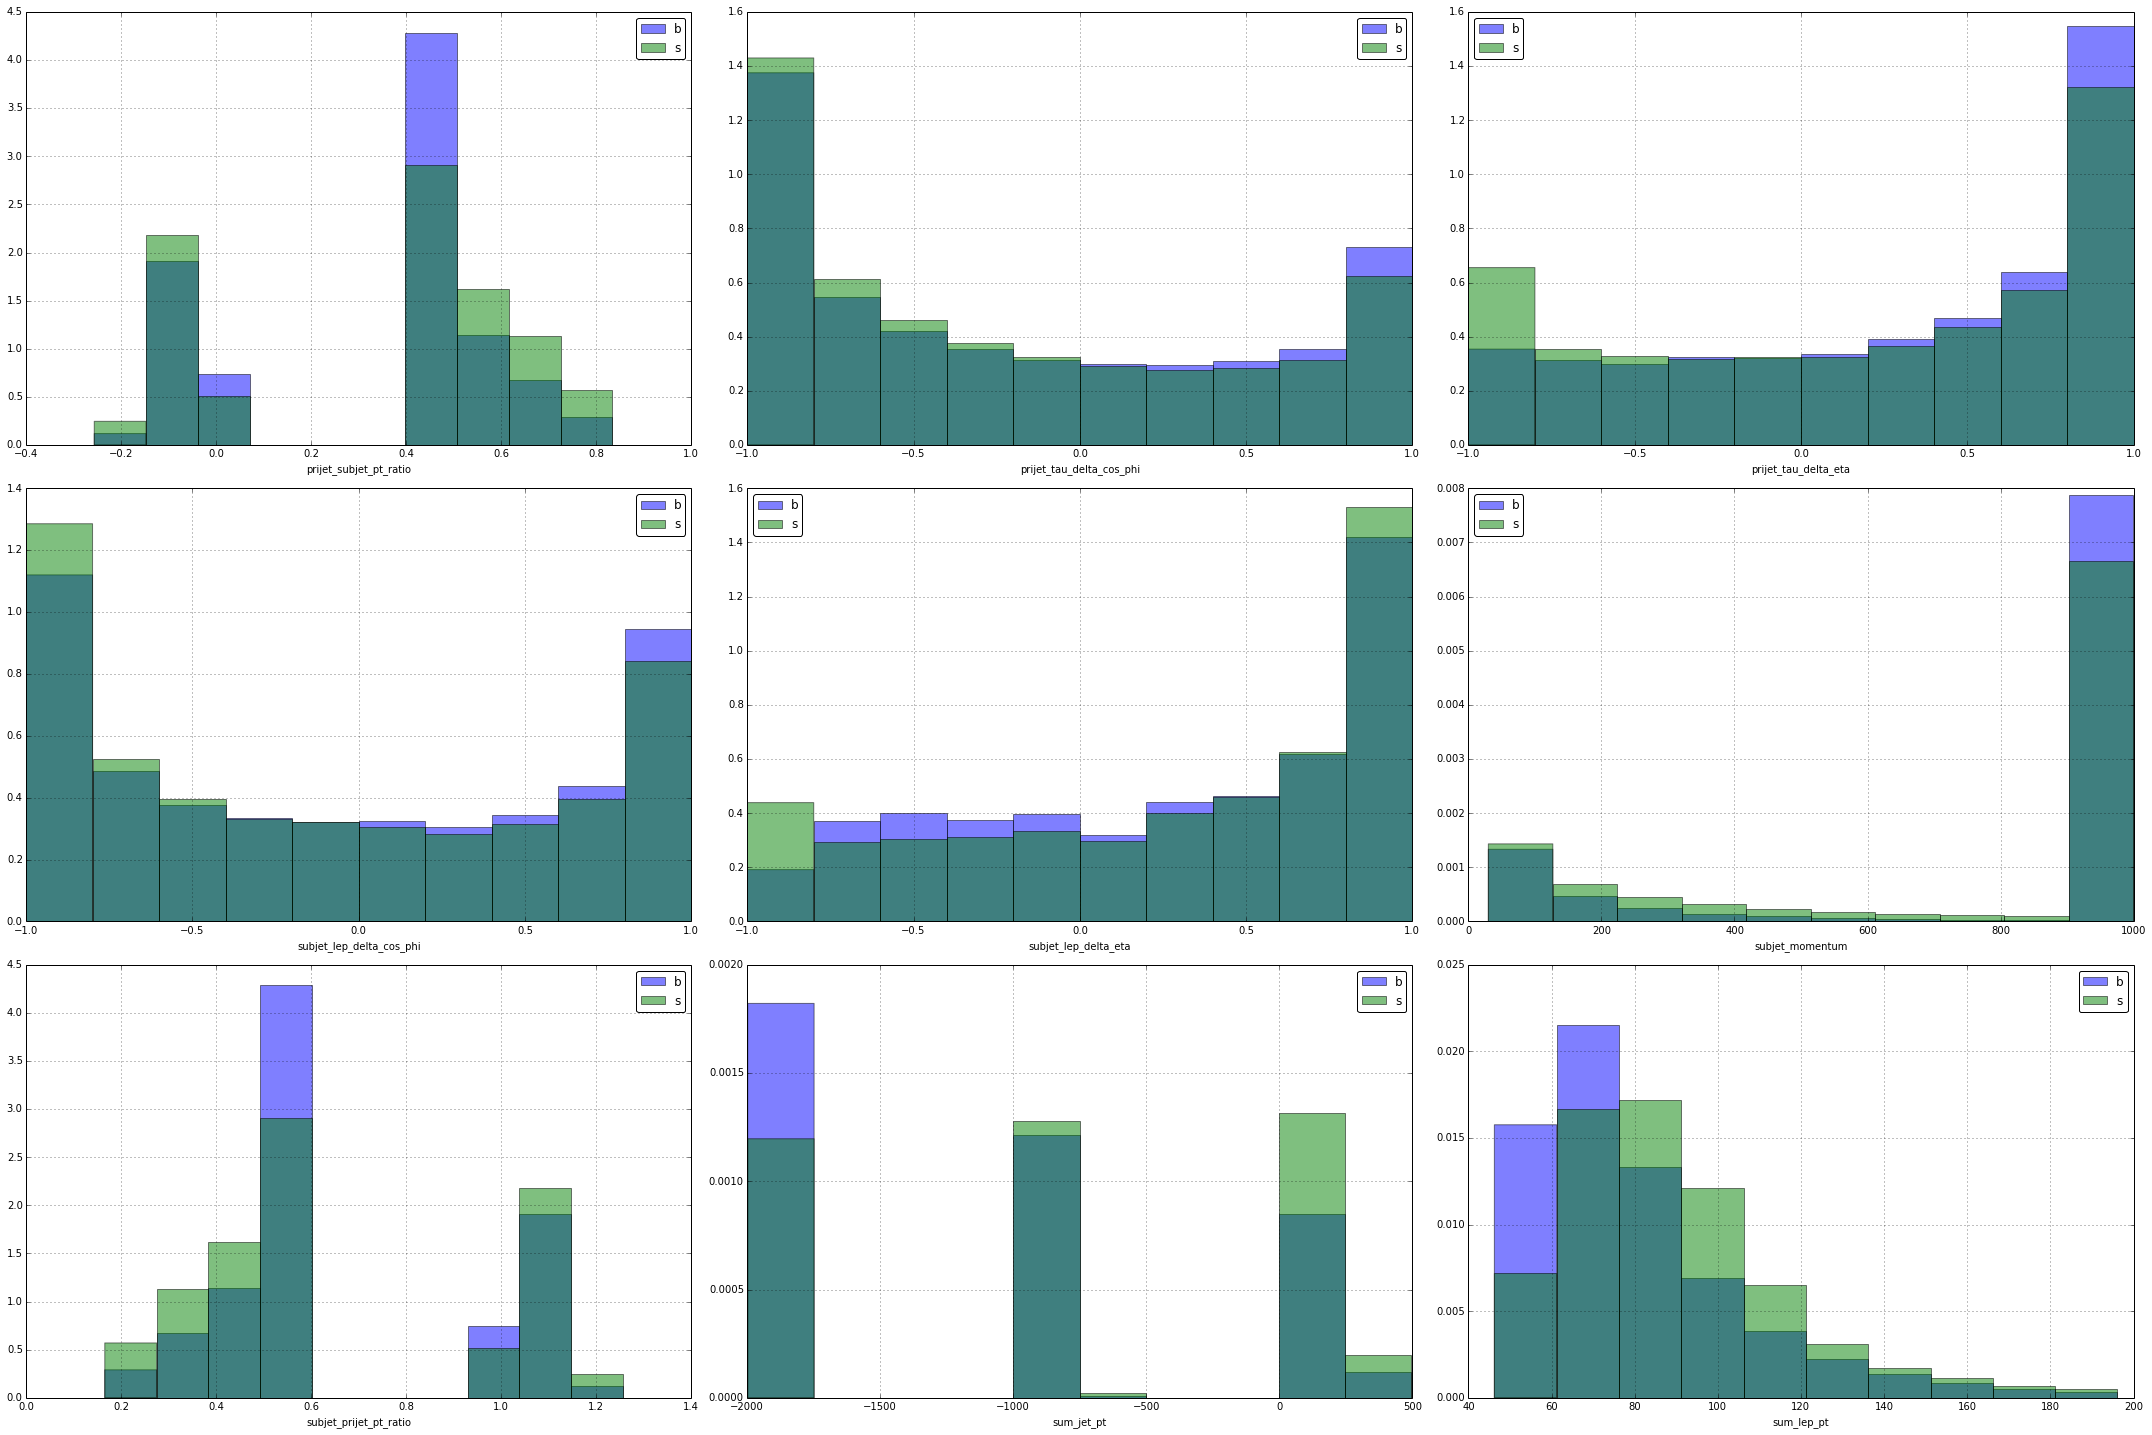

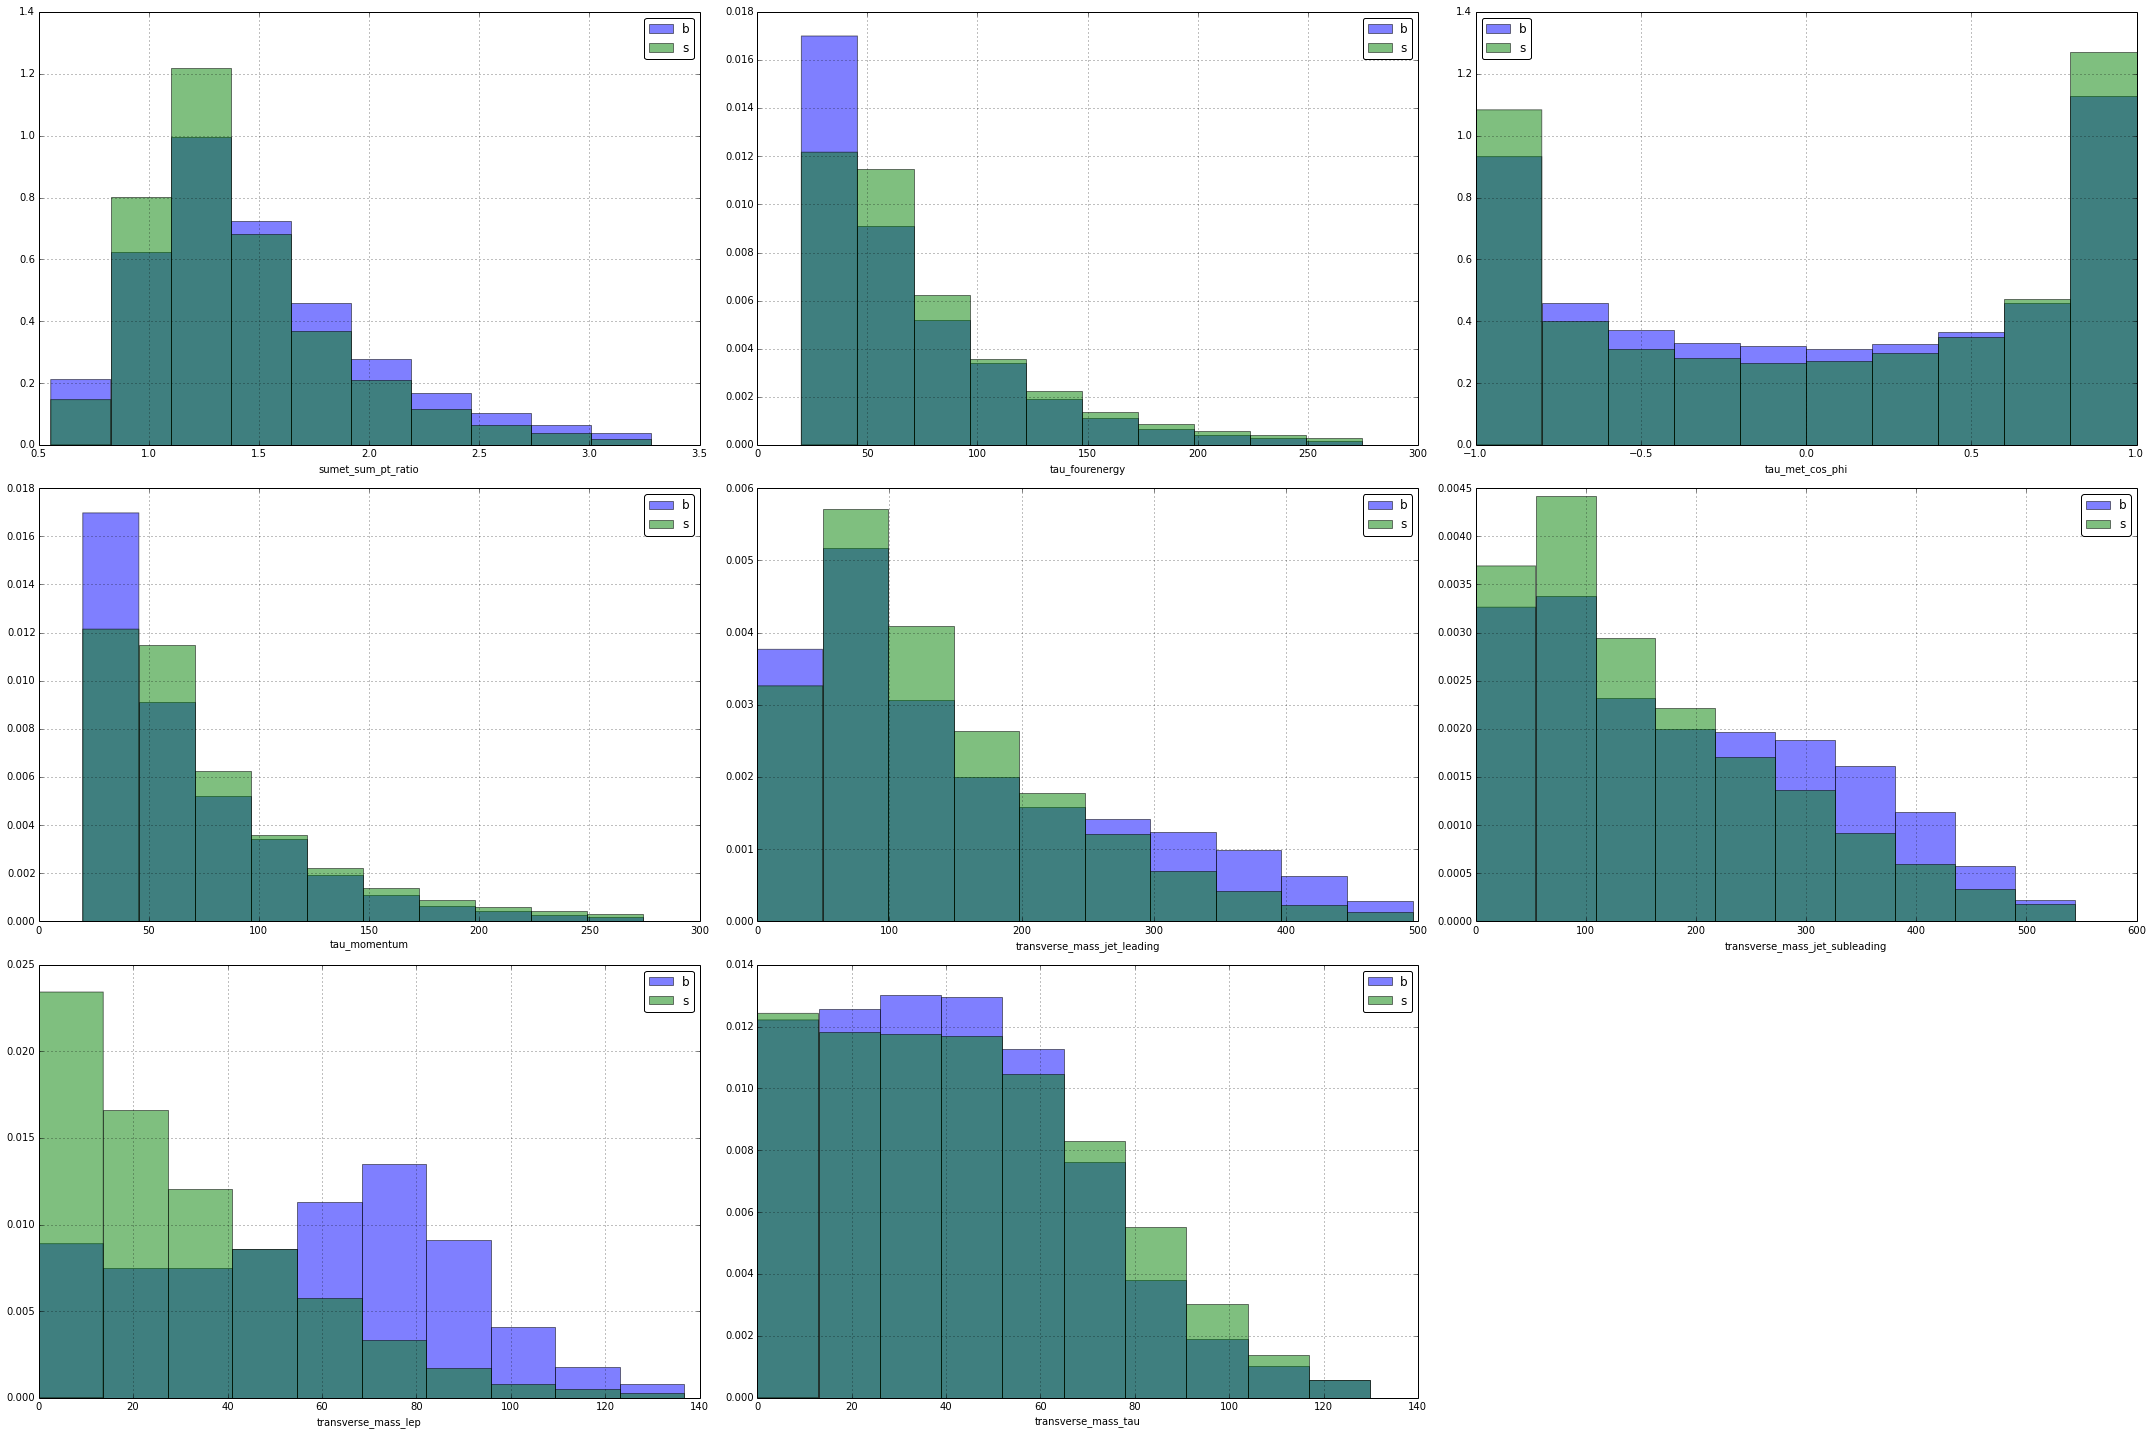

In [60]:
# Save to output file for viewing
bamboo.plotting.save_grouped_hists(df_all_features.groupby('Label'),
                                   output_file='features.pdf', autobin=True, alpha=0.5, normed=True)

## Partitioning by Jet Number

In [61]:
def jet_partition(row):
    jet_num = row['PRI_jet_num']
    if jet_num==0:
        return 'zero_jet'
    elif jet_num==1:
        return 'one_jet'
    else:
        return 'multi_jet'

In [62]:
import bamboo.data
jet_partitioned = bamboo.data.partition(df_all_features, jet_partition)

zero_jet = jet_partitioned.get_group('zero_jet')
one_jet = jet_partitioned.get_group('one_jet')
multi_jet = jet_partitioned.get_group('multi_jet')

In [63]:
# Split into training and testing PER JET NUMBER
zero_jet_features, zero_jet_targets = get_features_and_targets(zero_jet)
one_jet_features, one_jet_targets = get_features_and_targets(one_jet)
multi_jet_features, multi_jet_targets = get_features_and_targets(multi_jet)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/pyplot.py:412: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_num_figures`).
  max_open_warning, RuntimeWarning)


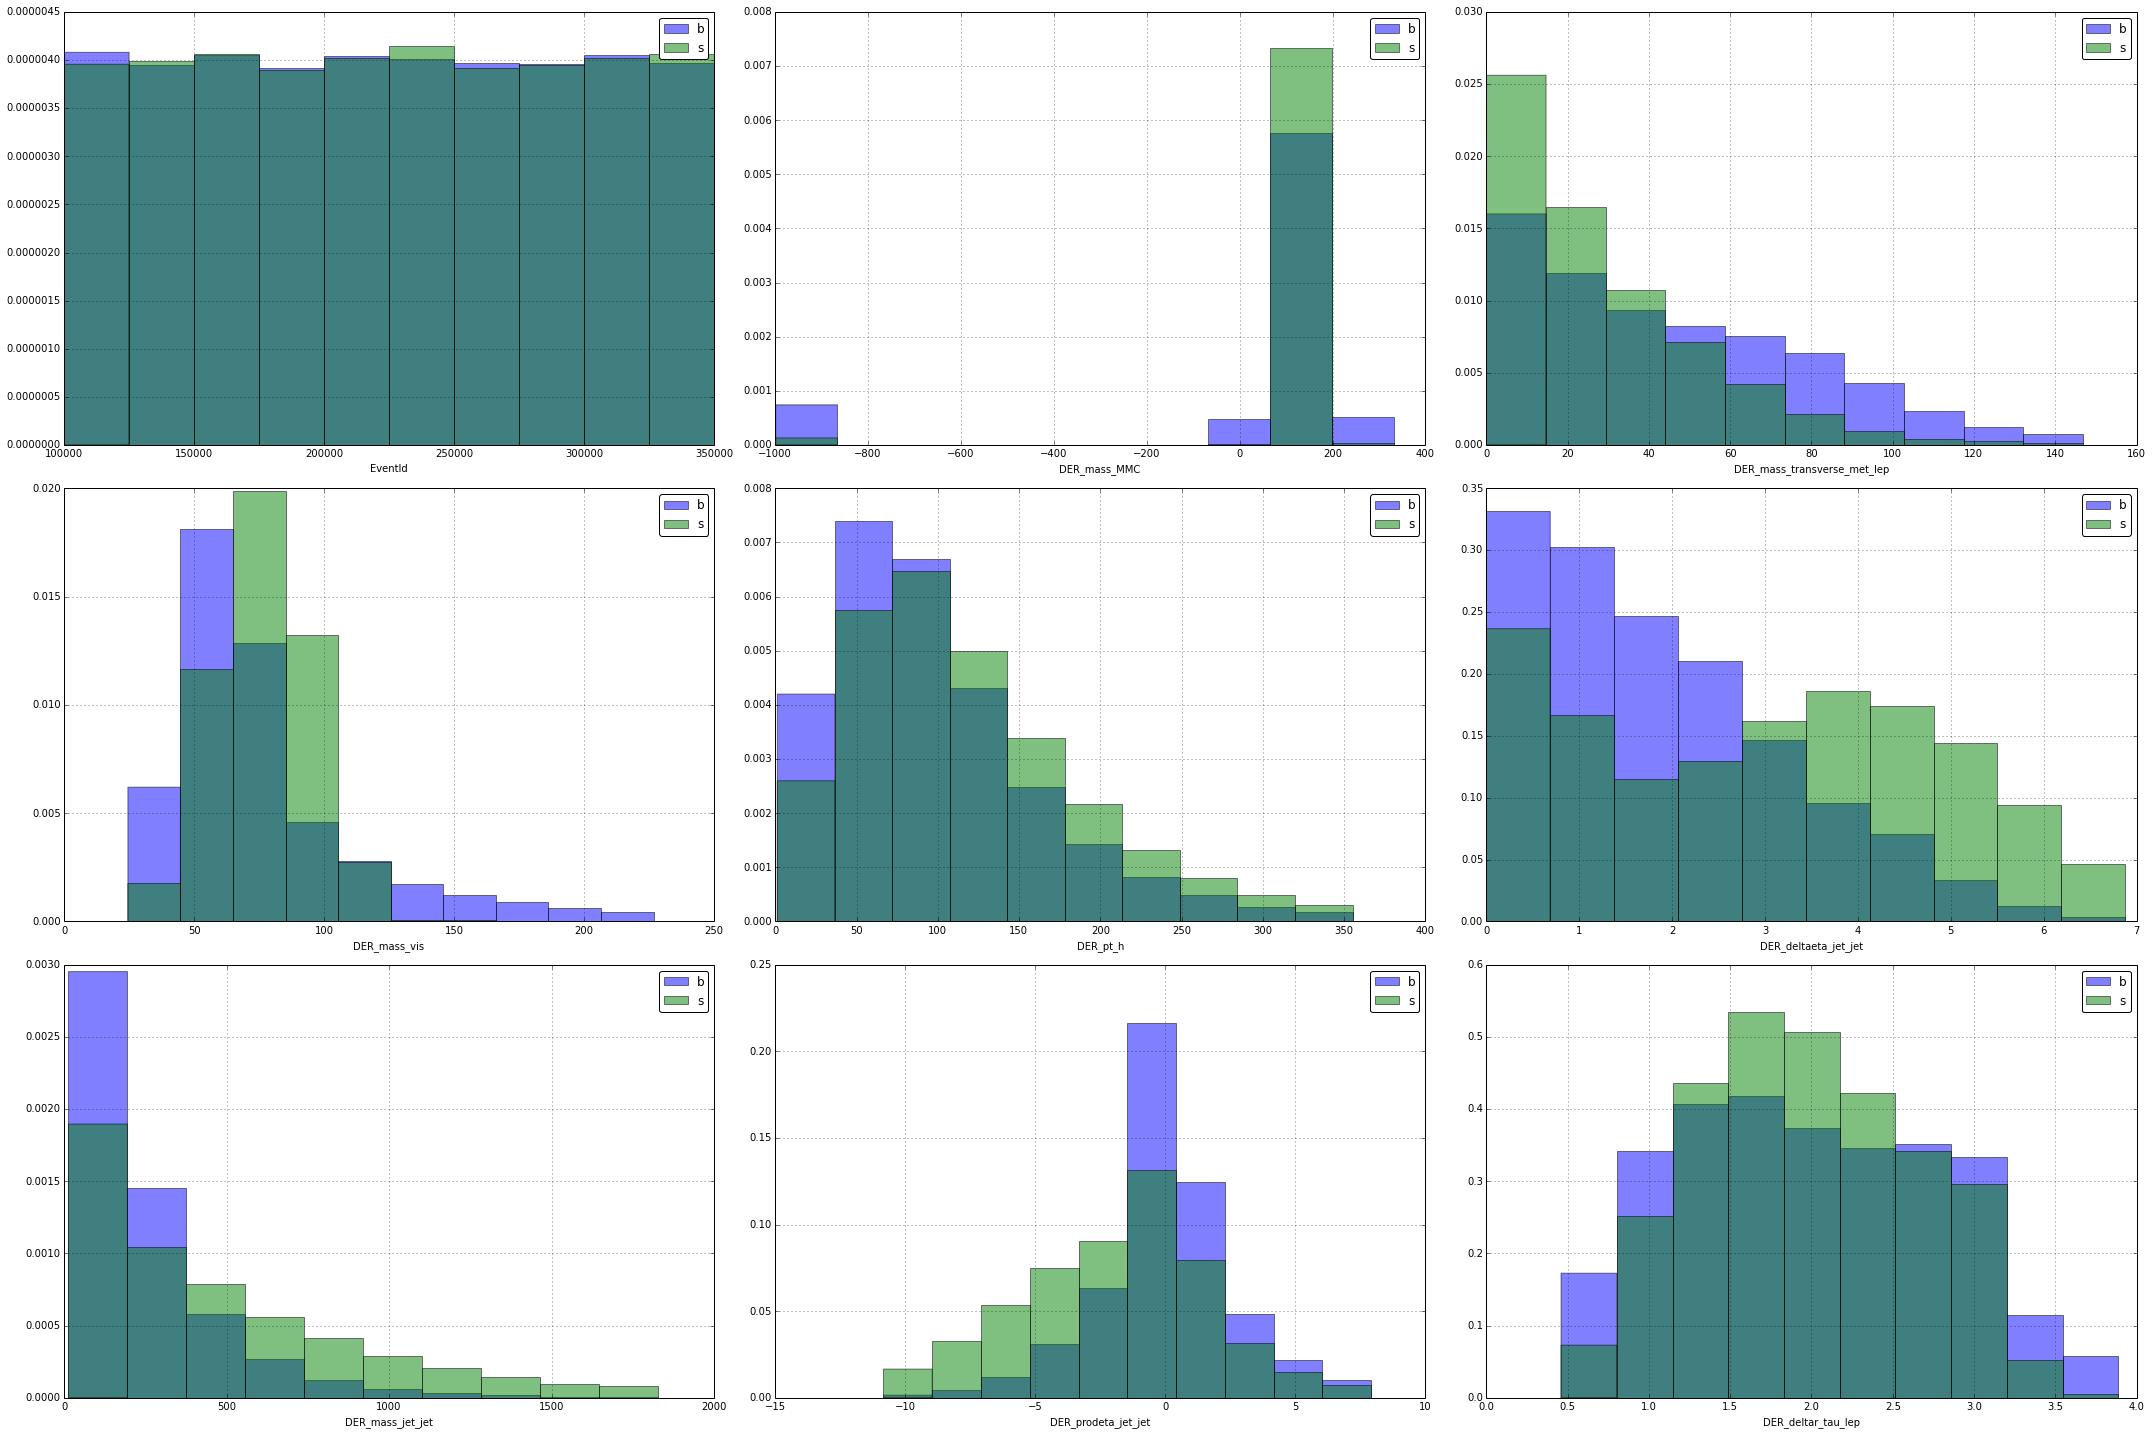

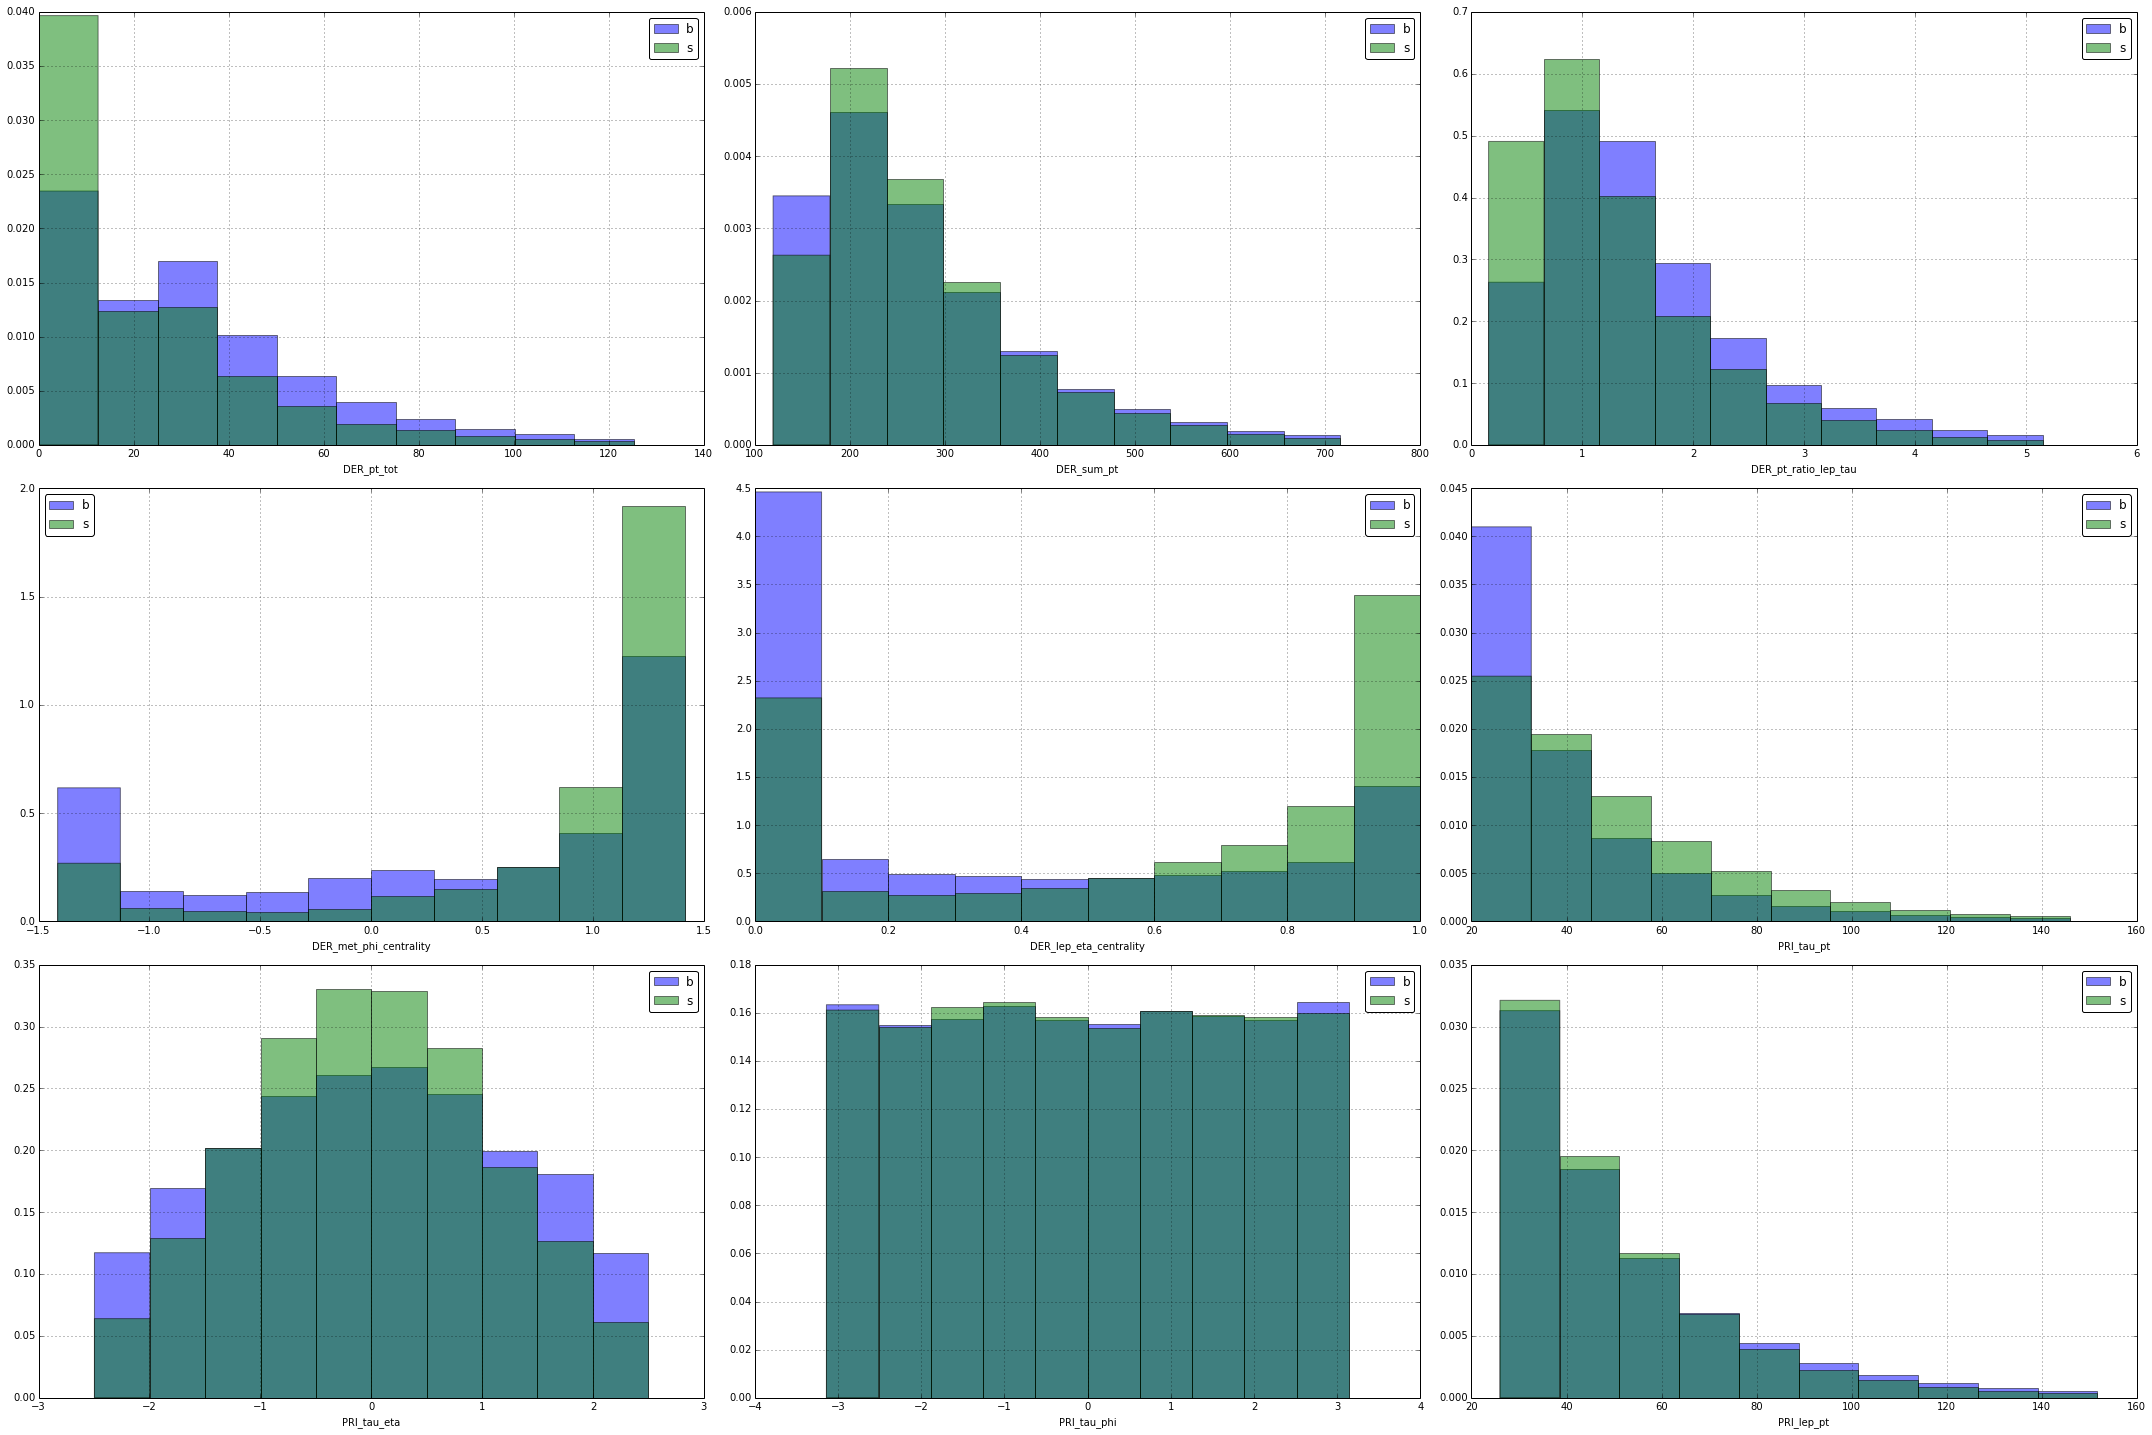

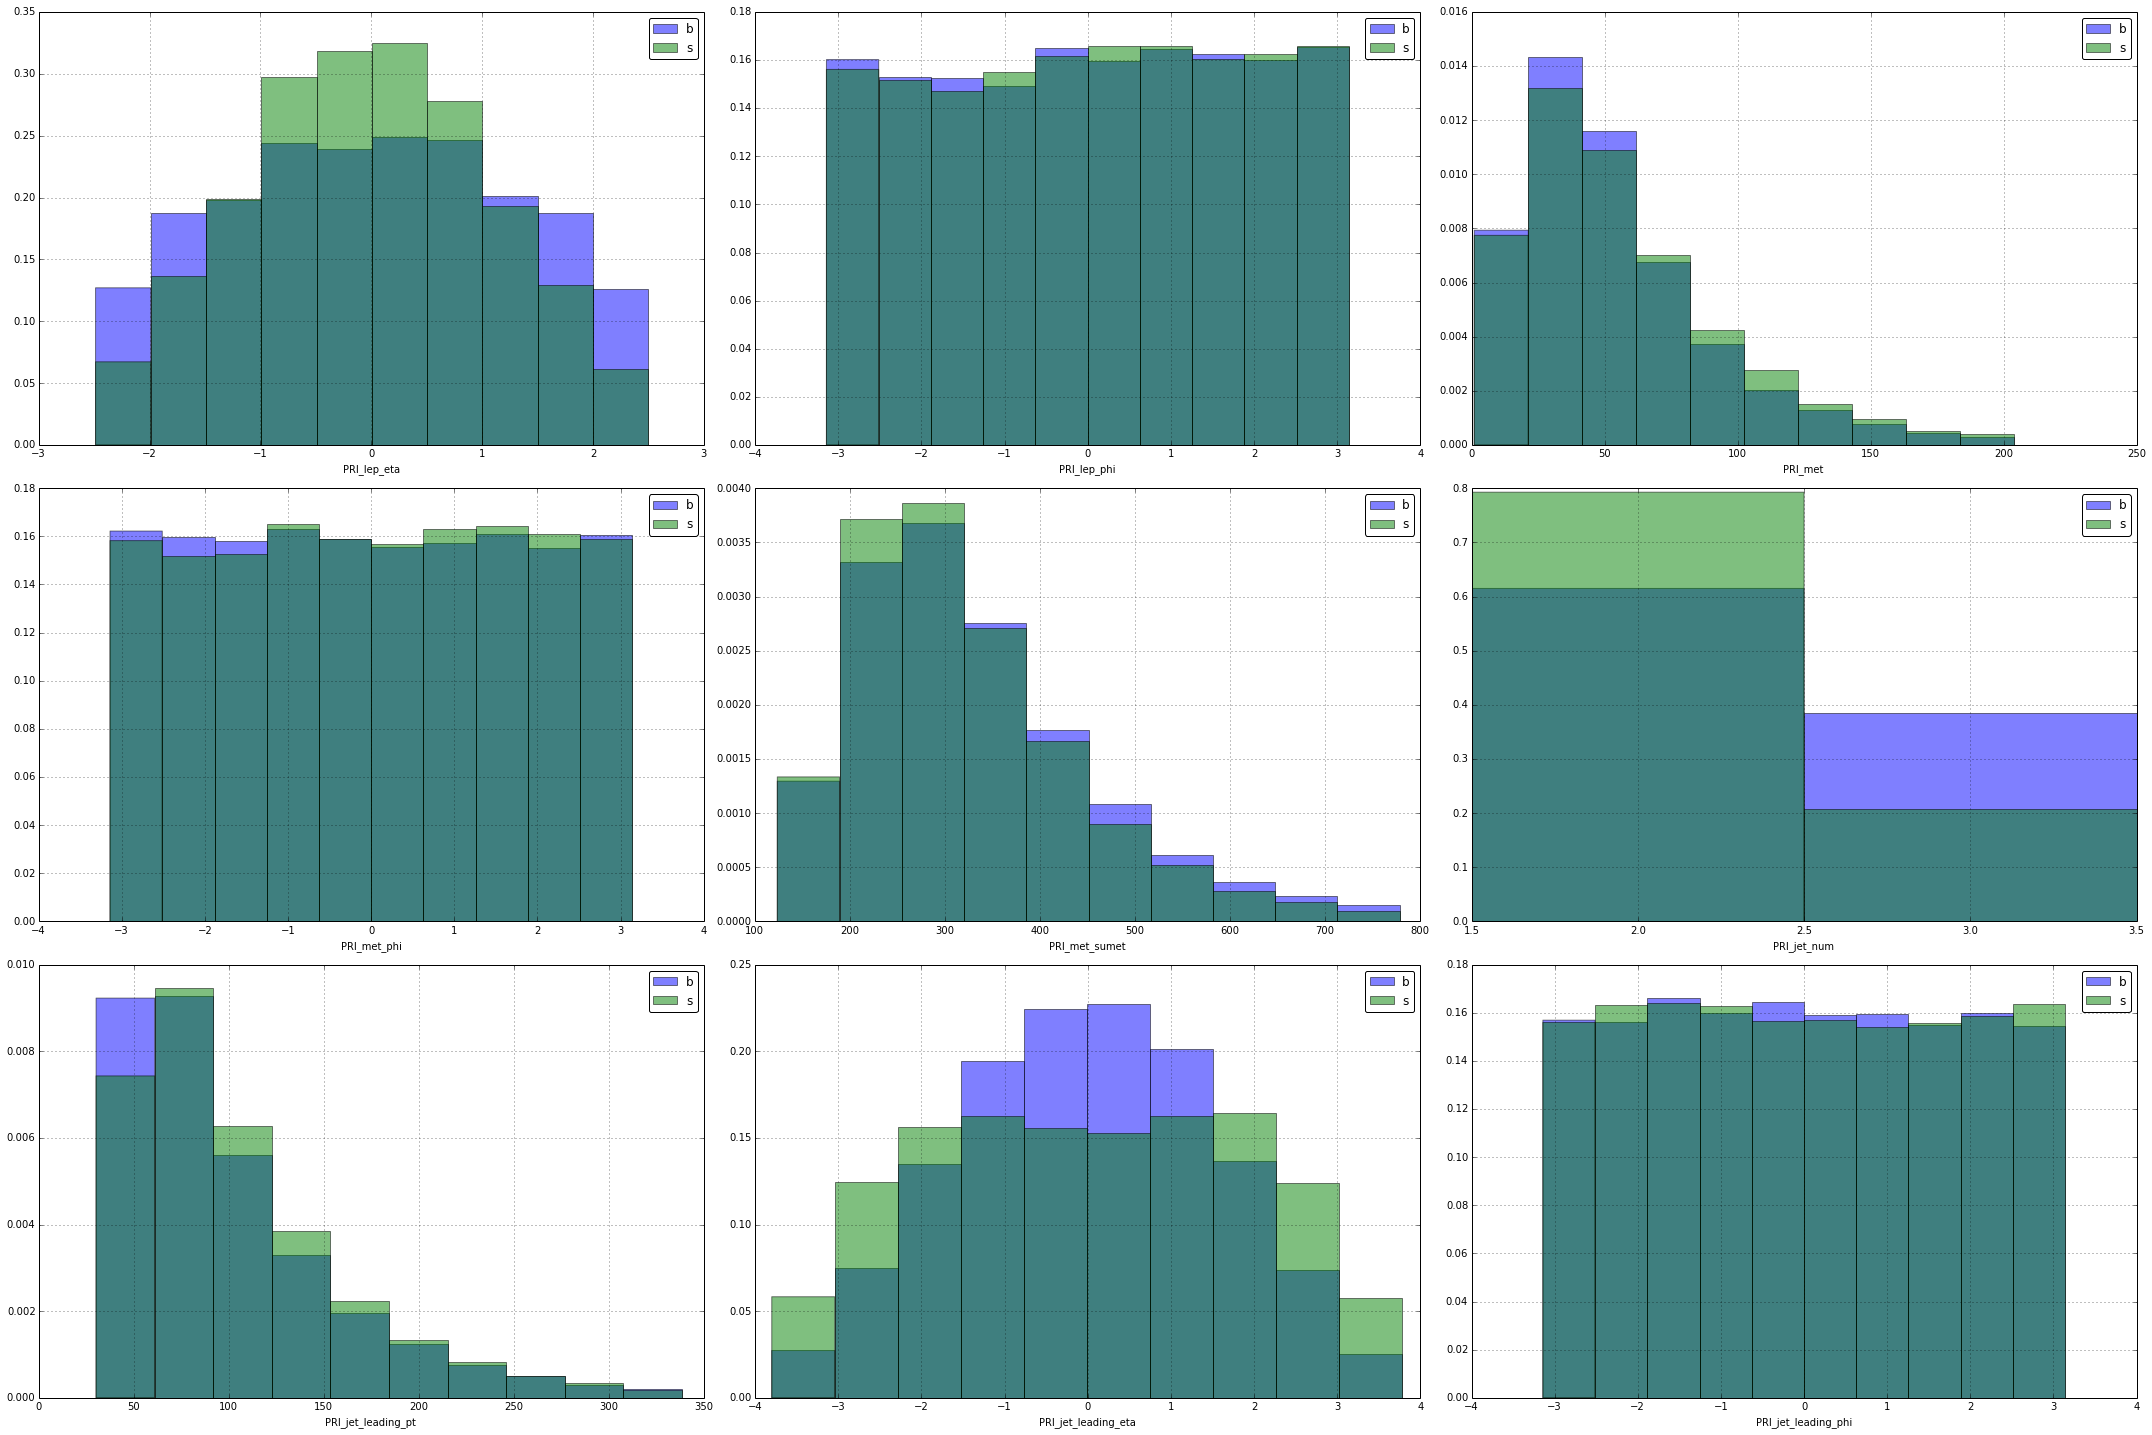

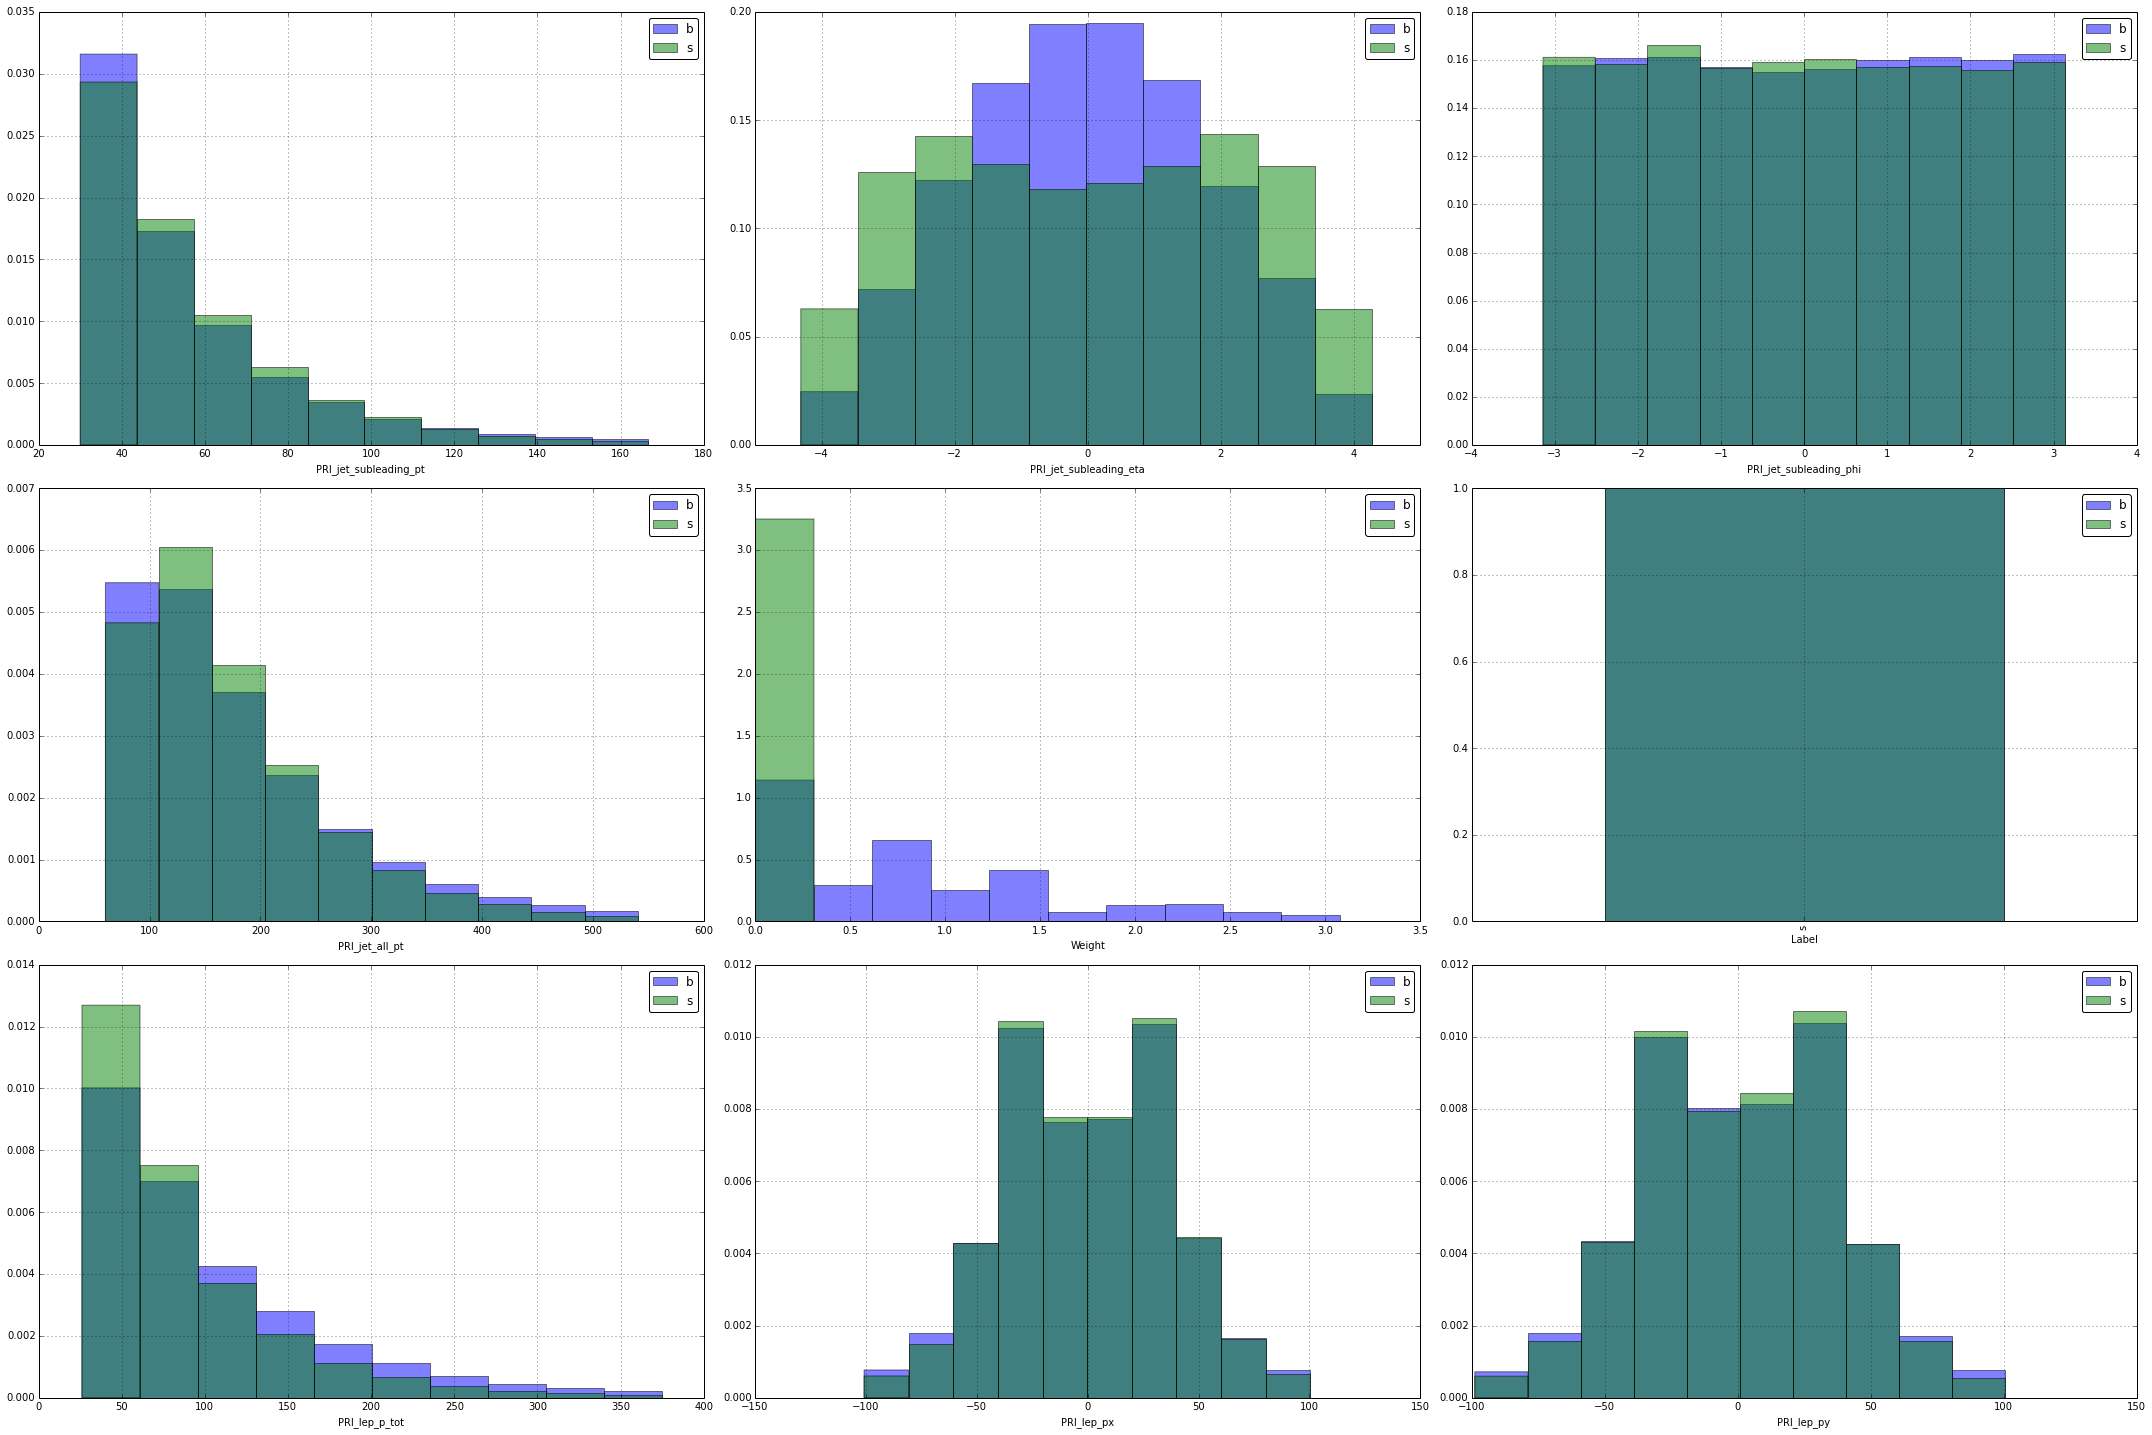

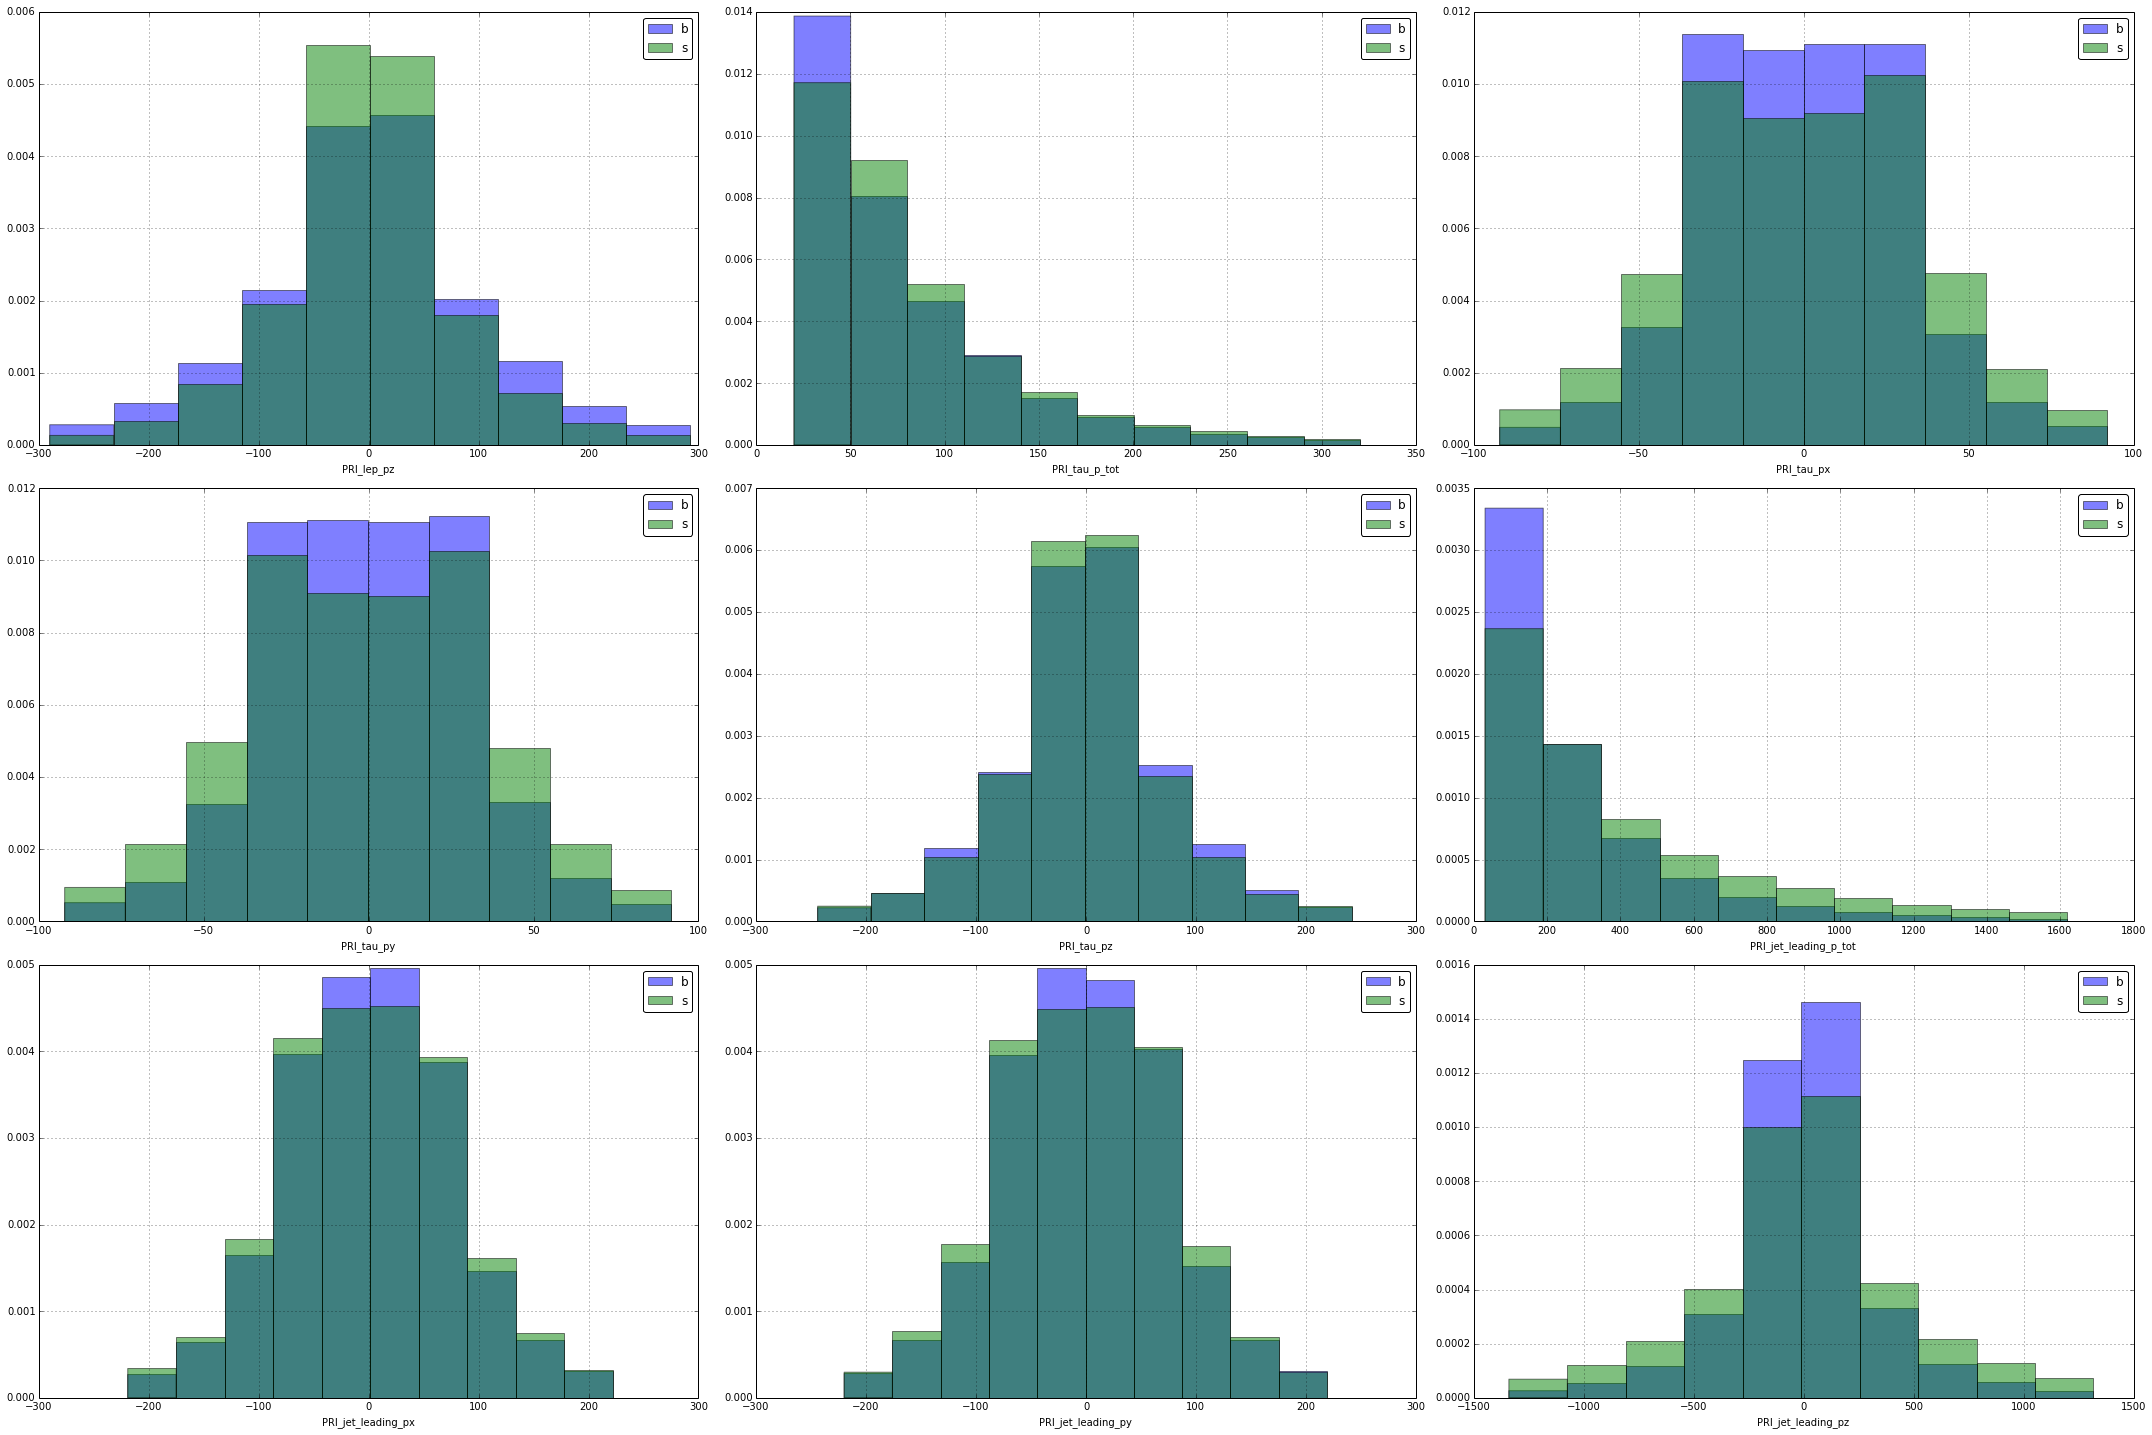

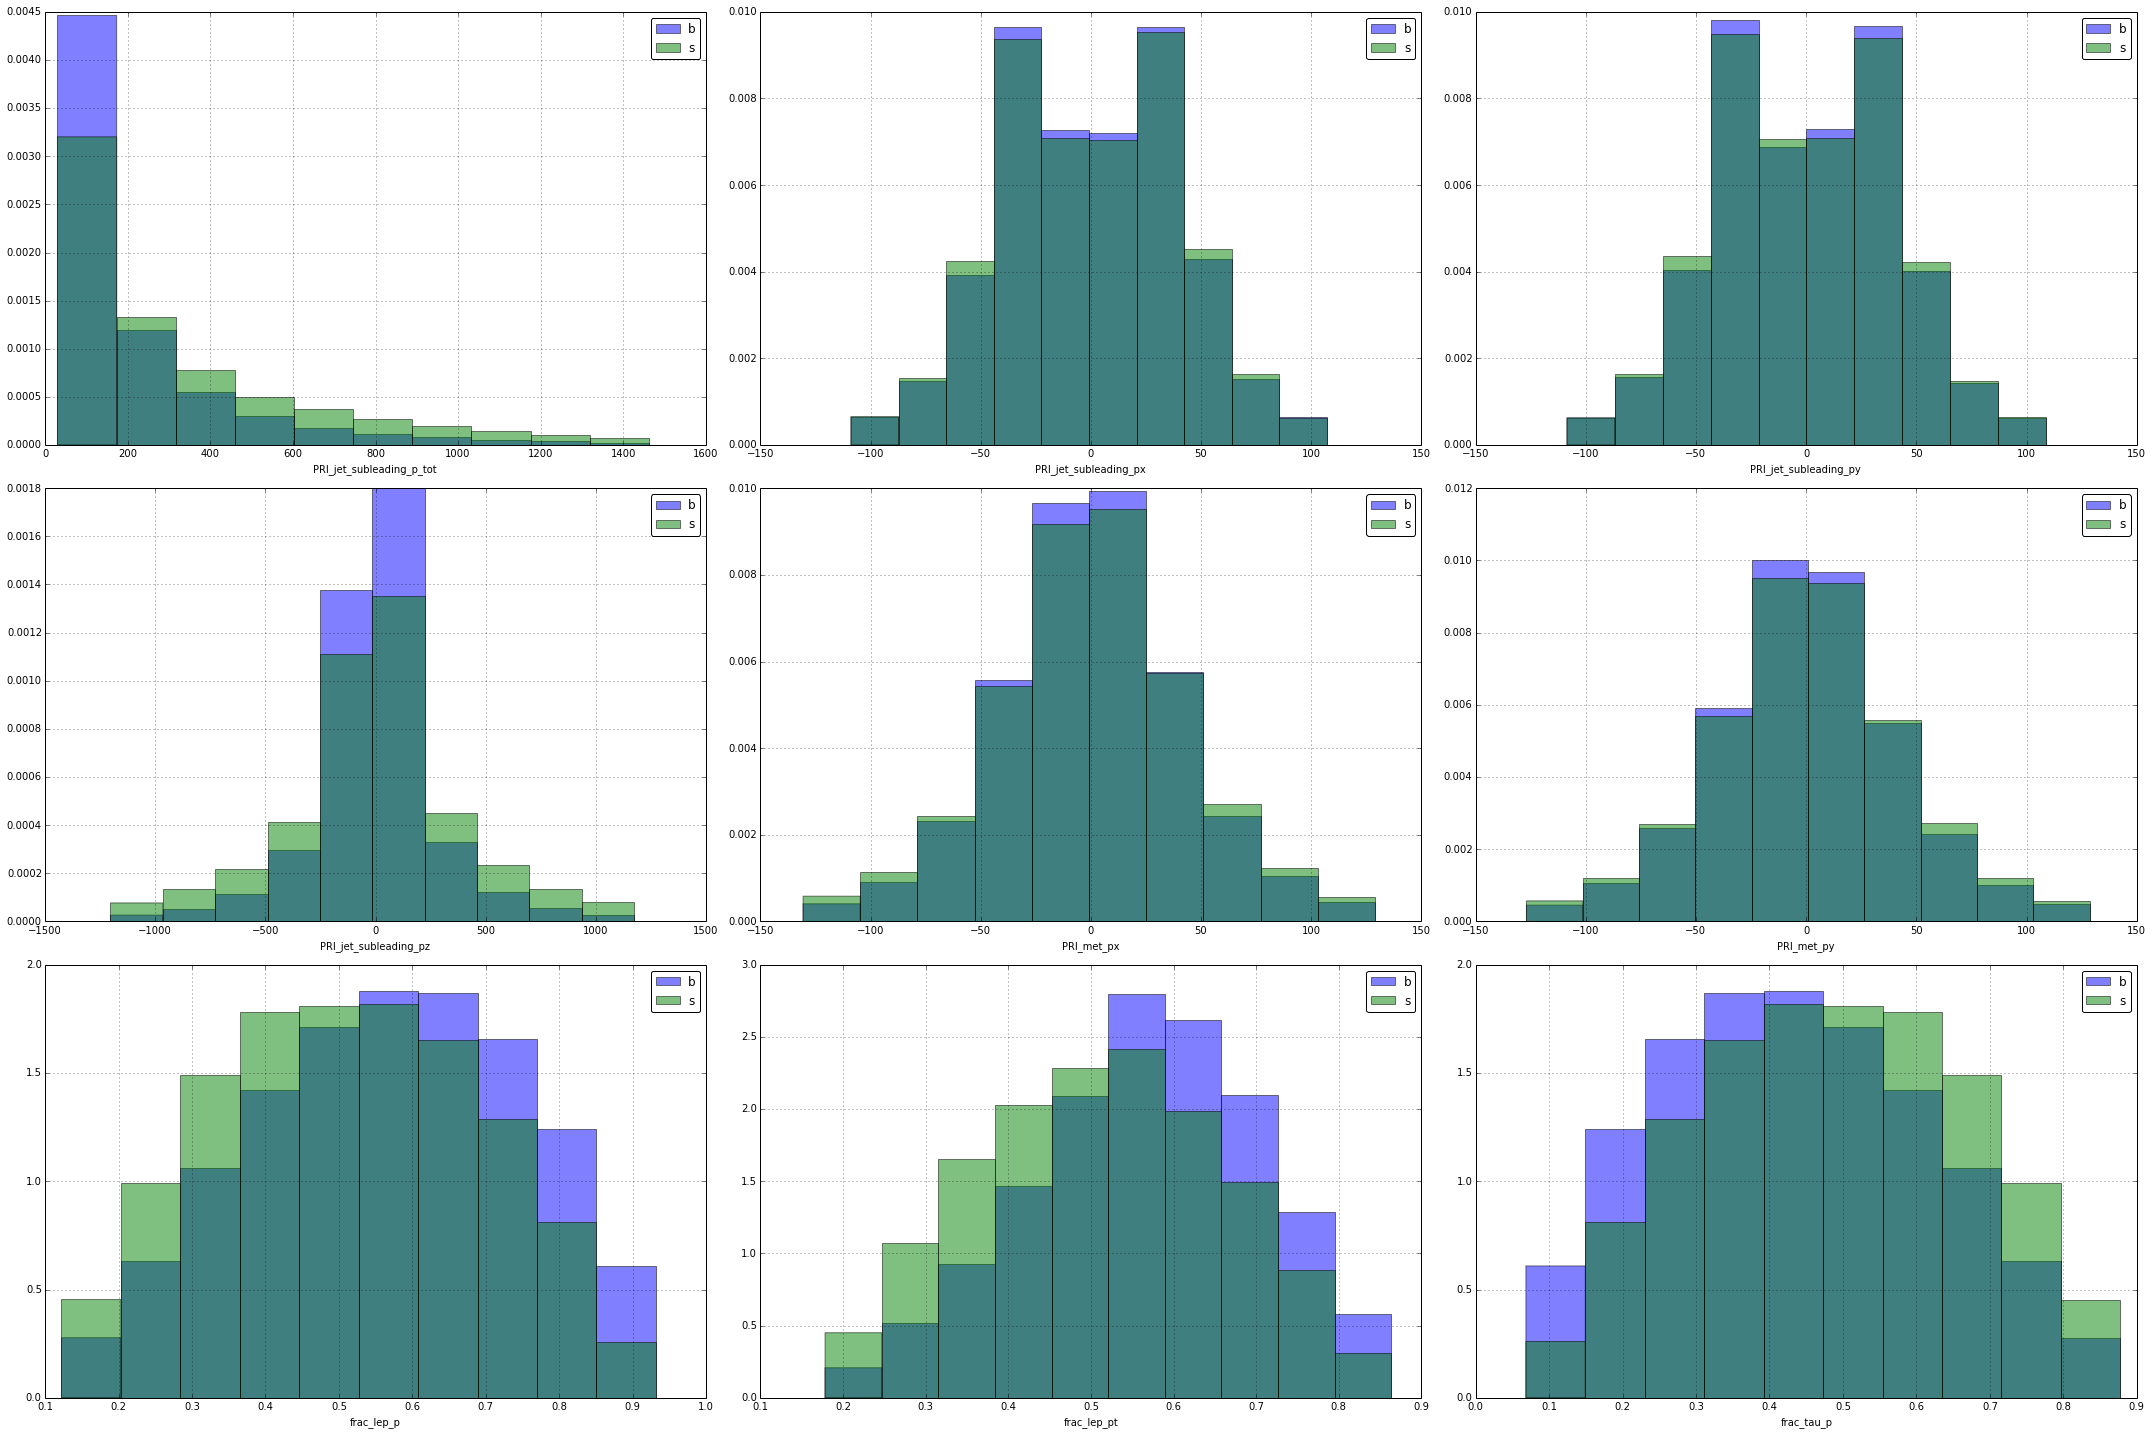

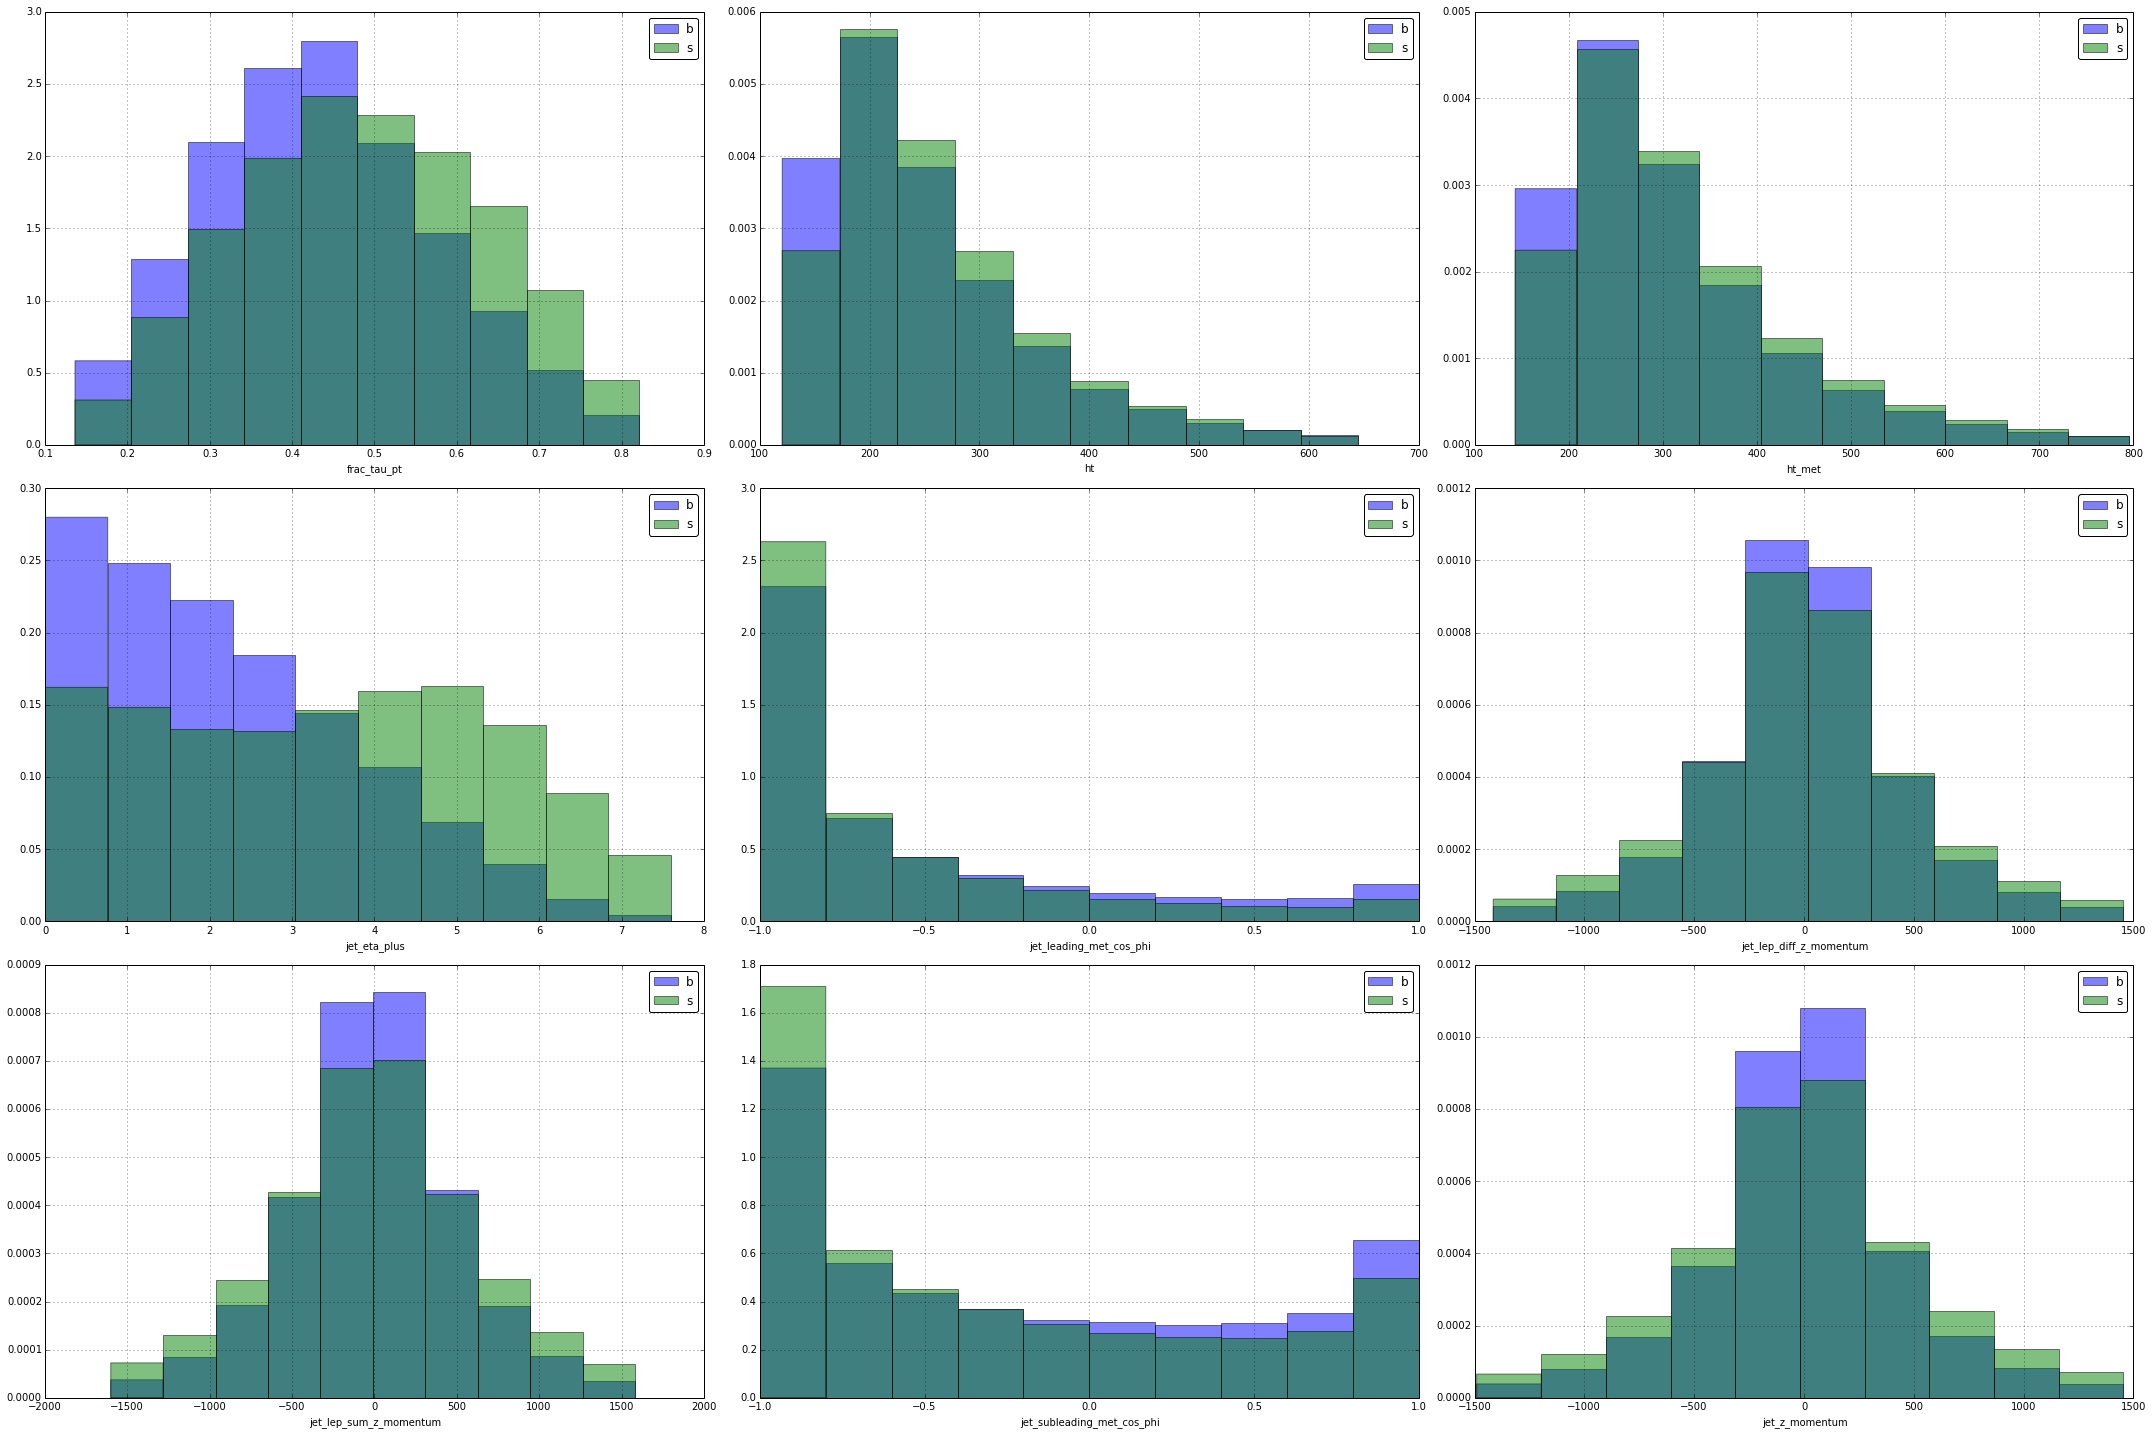

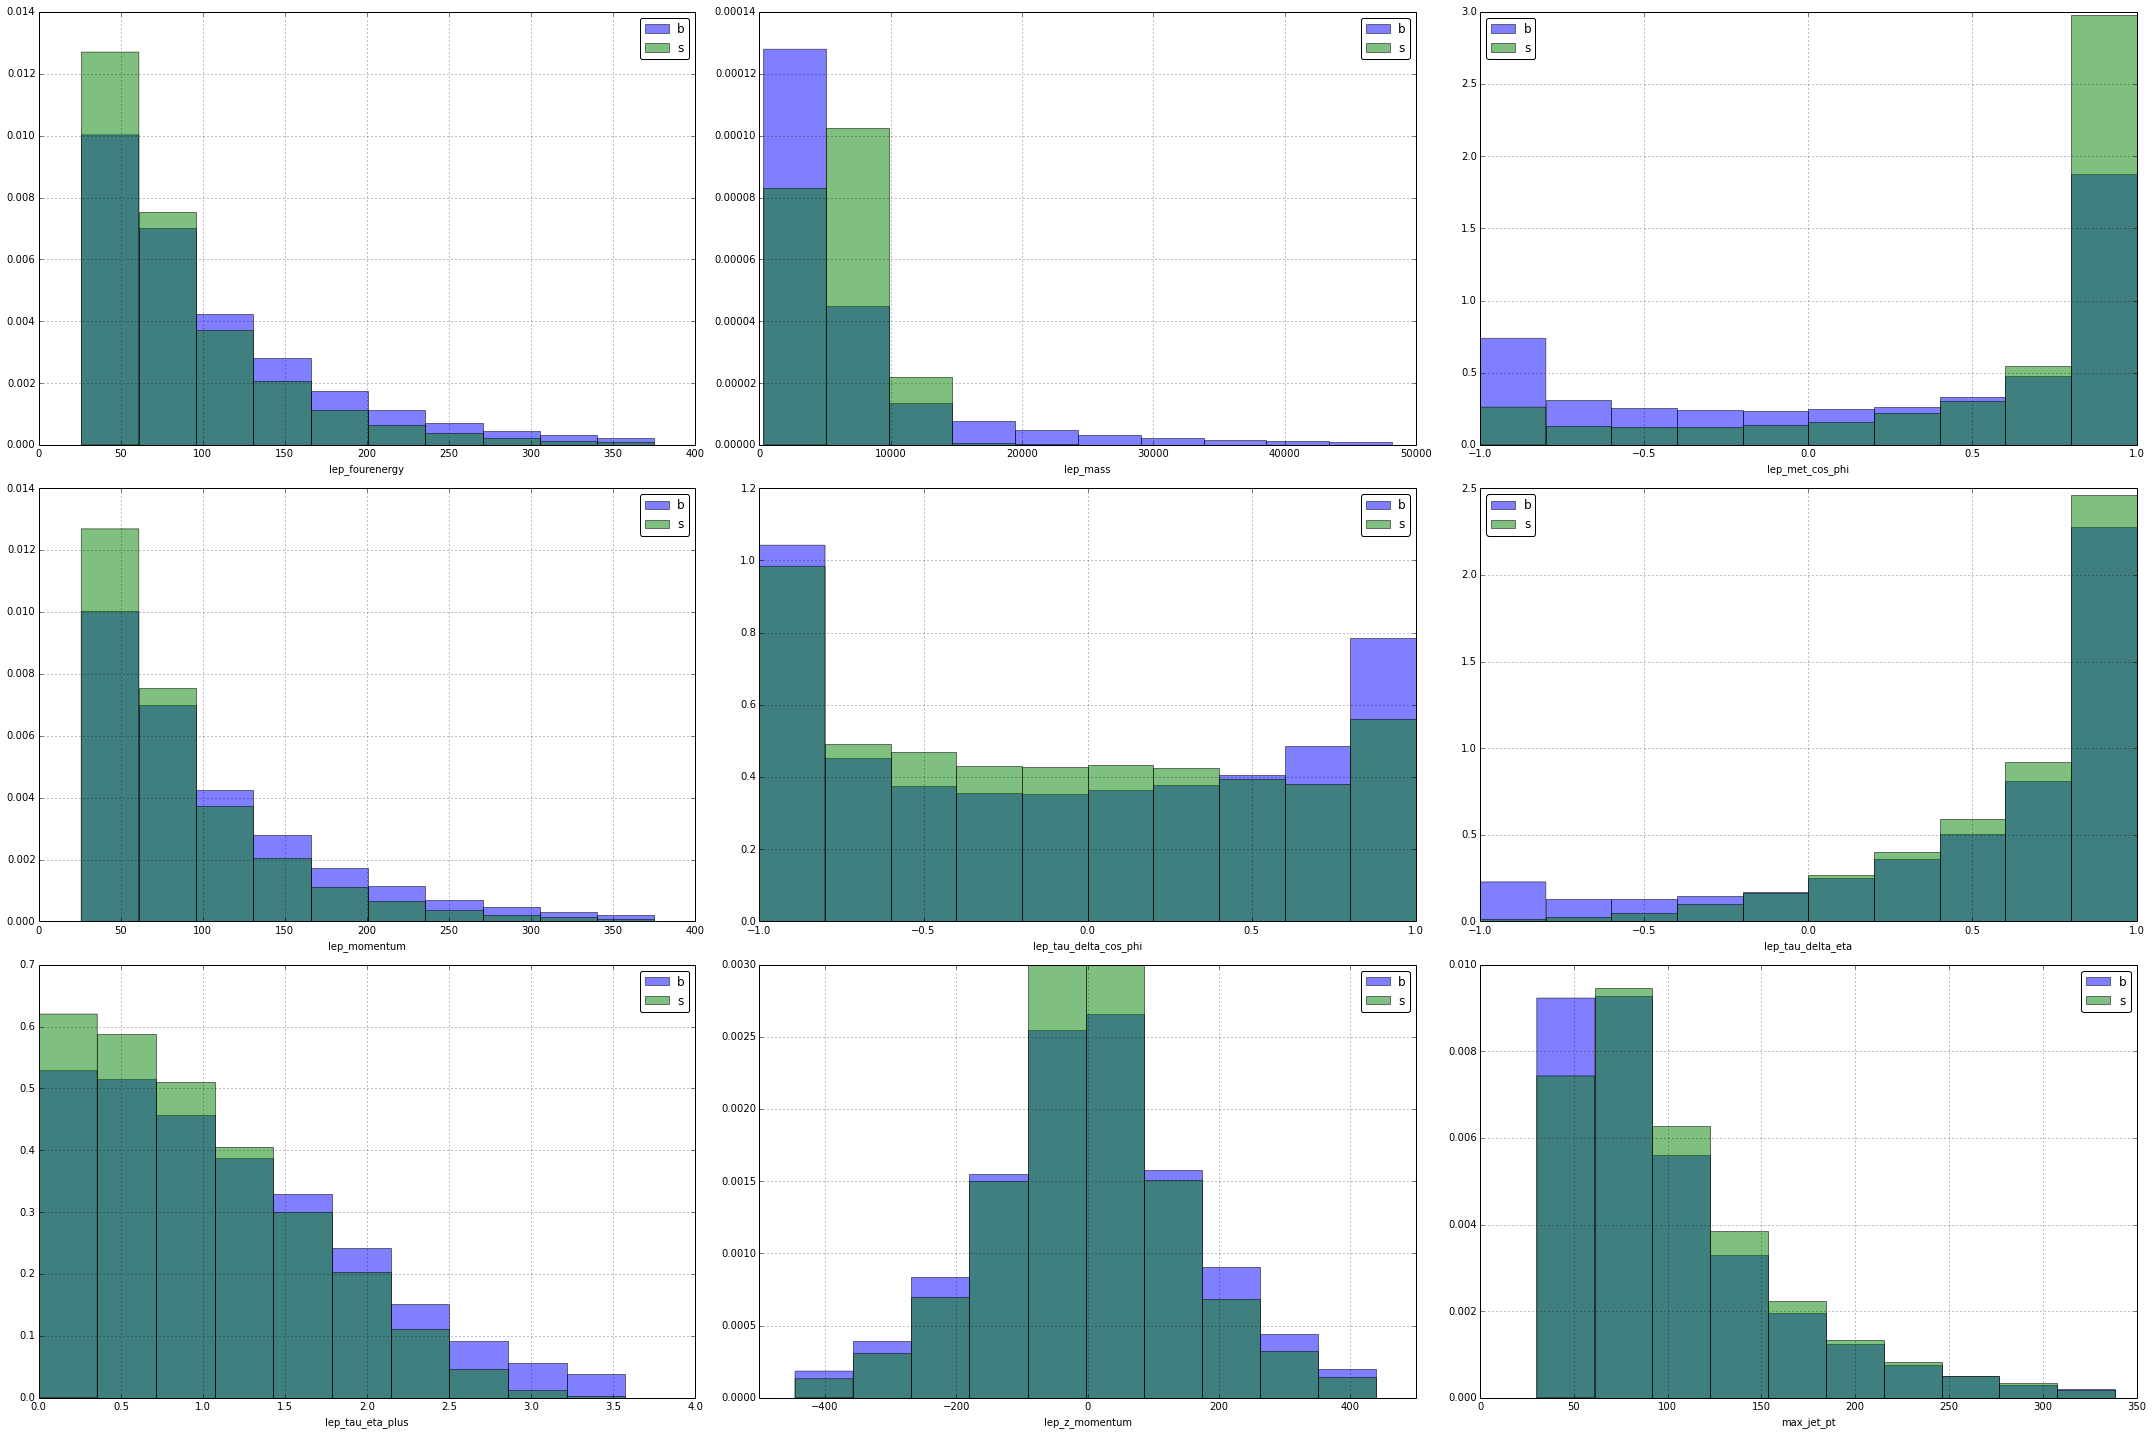

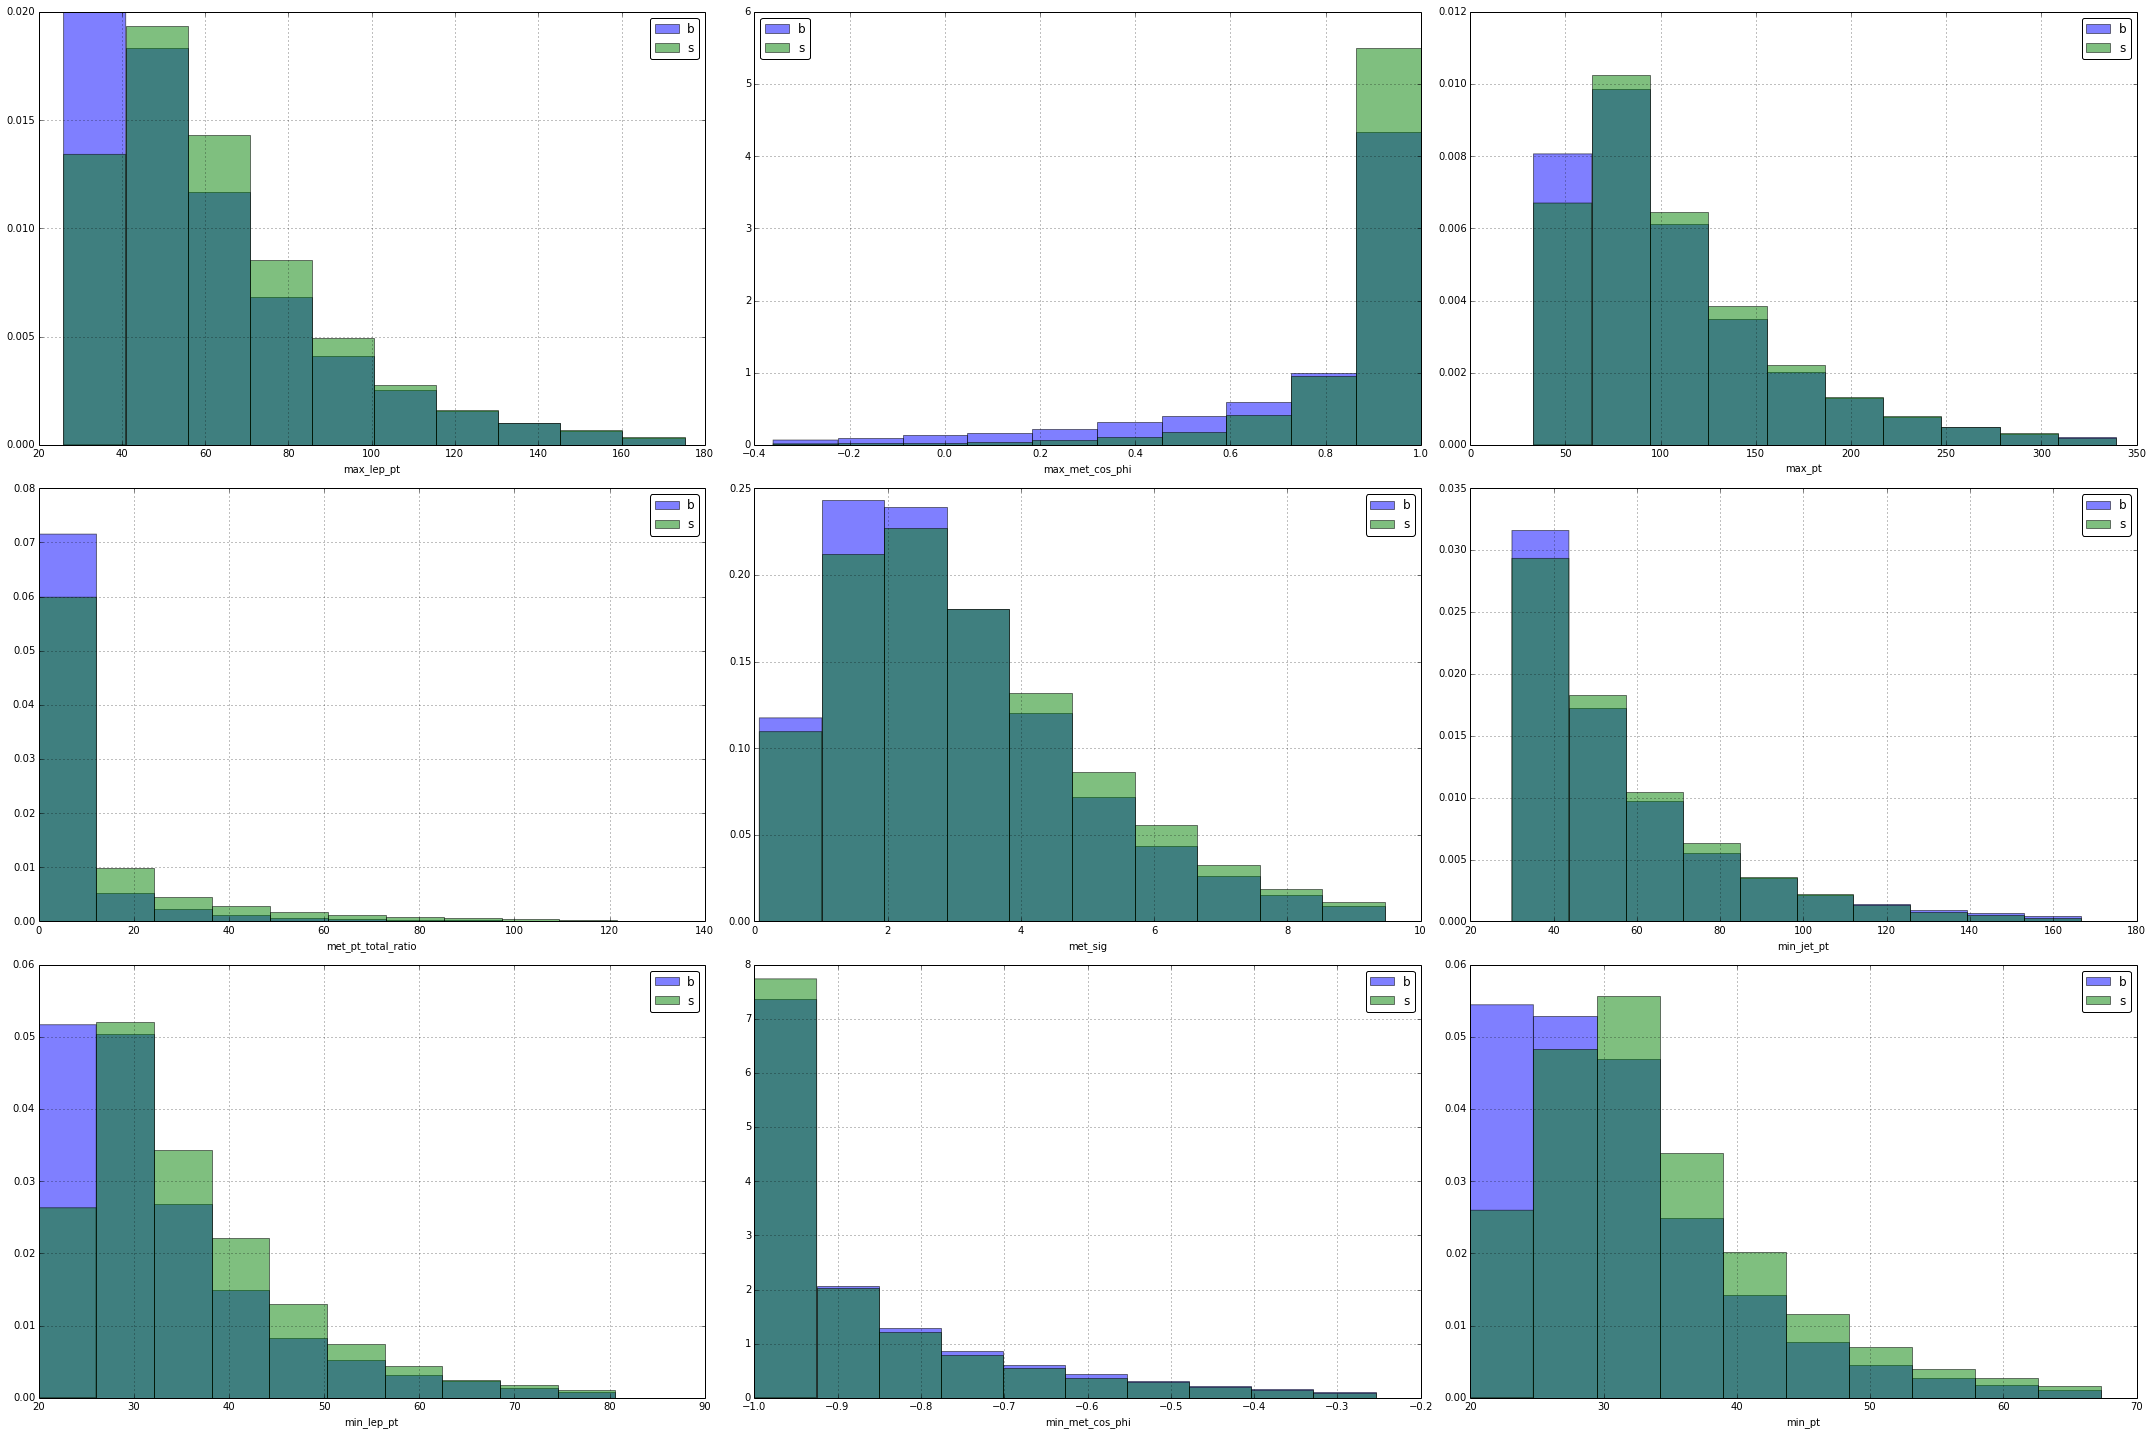

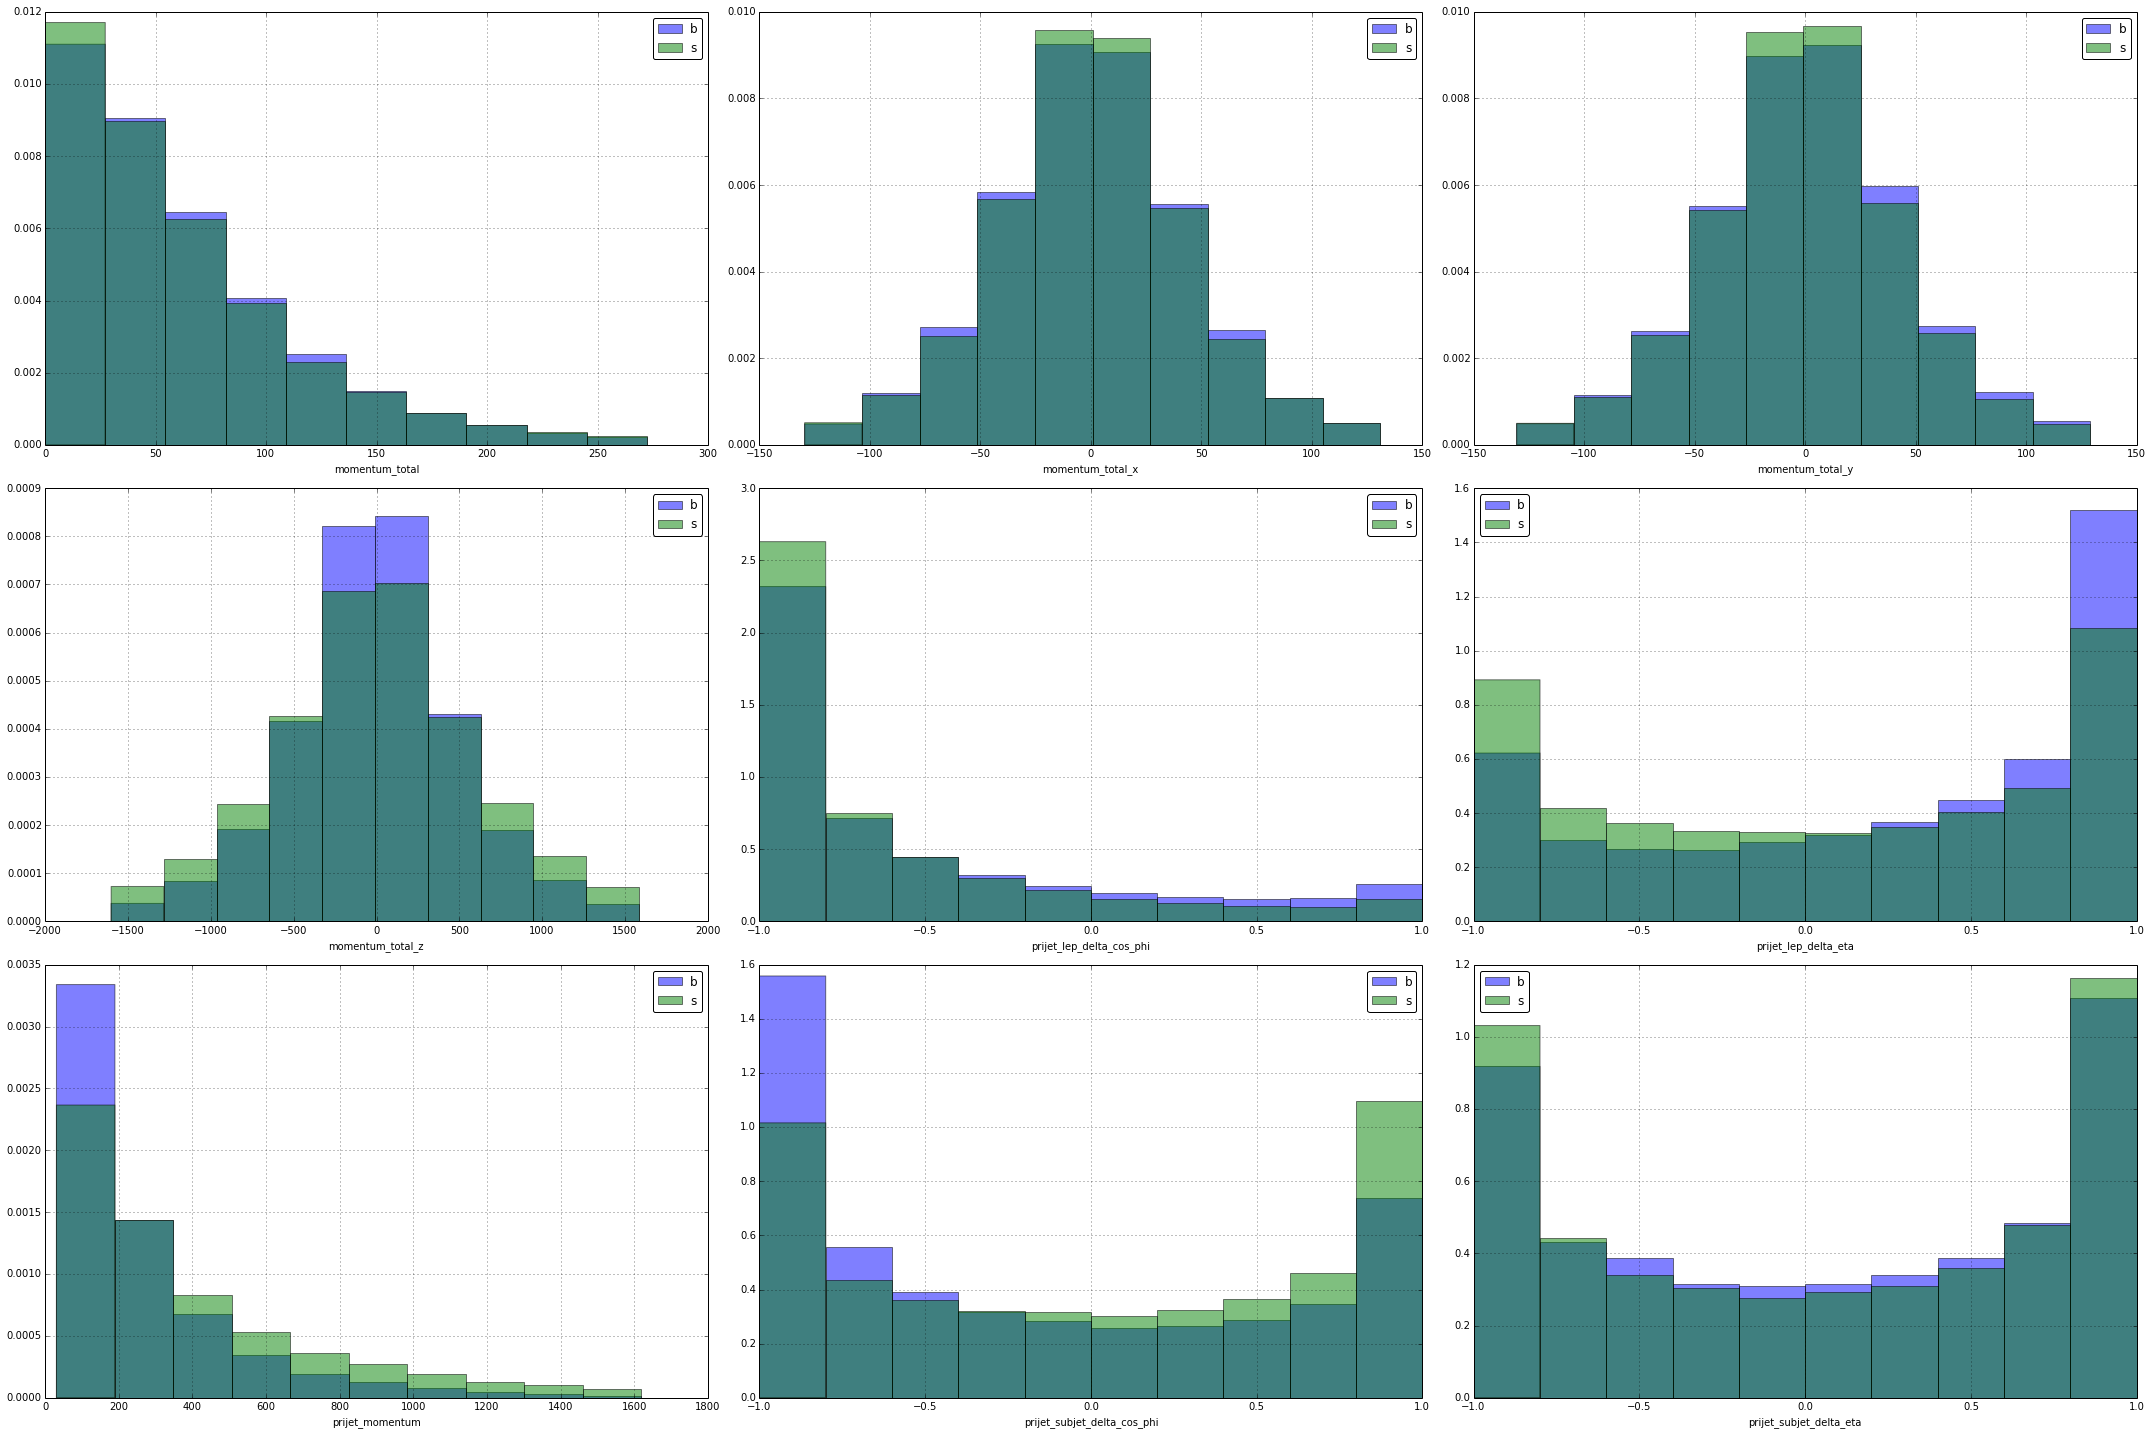

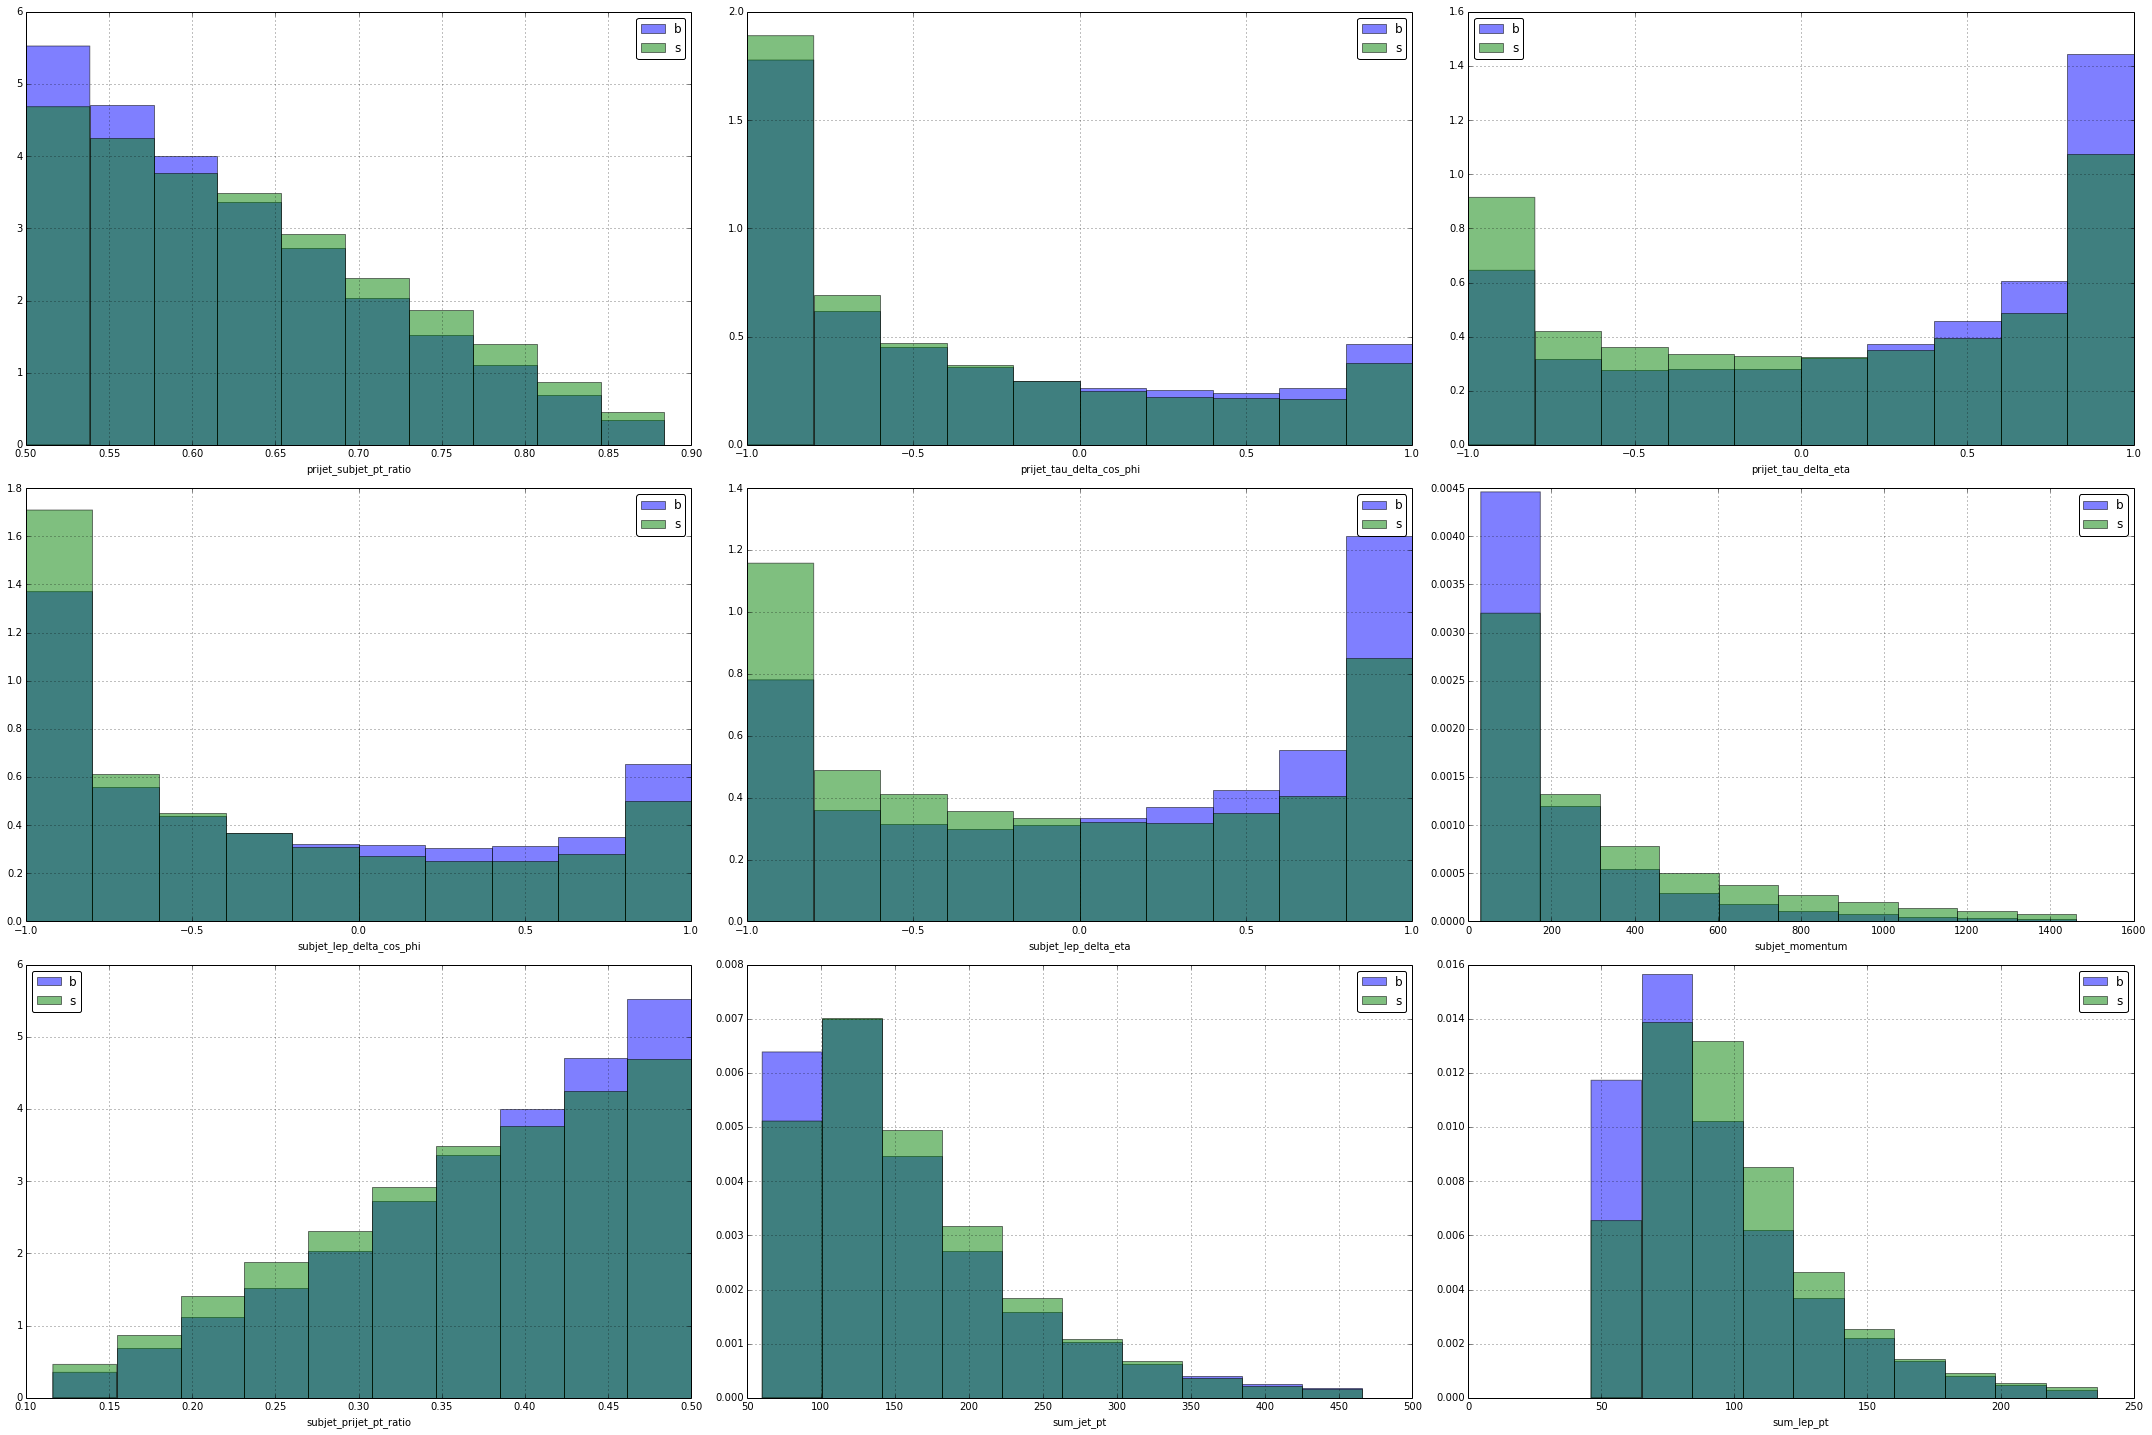

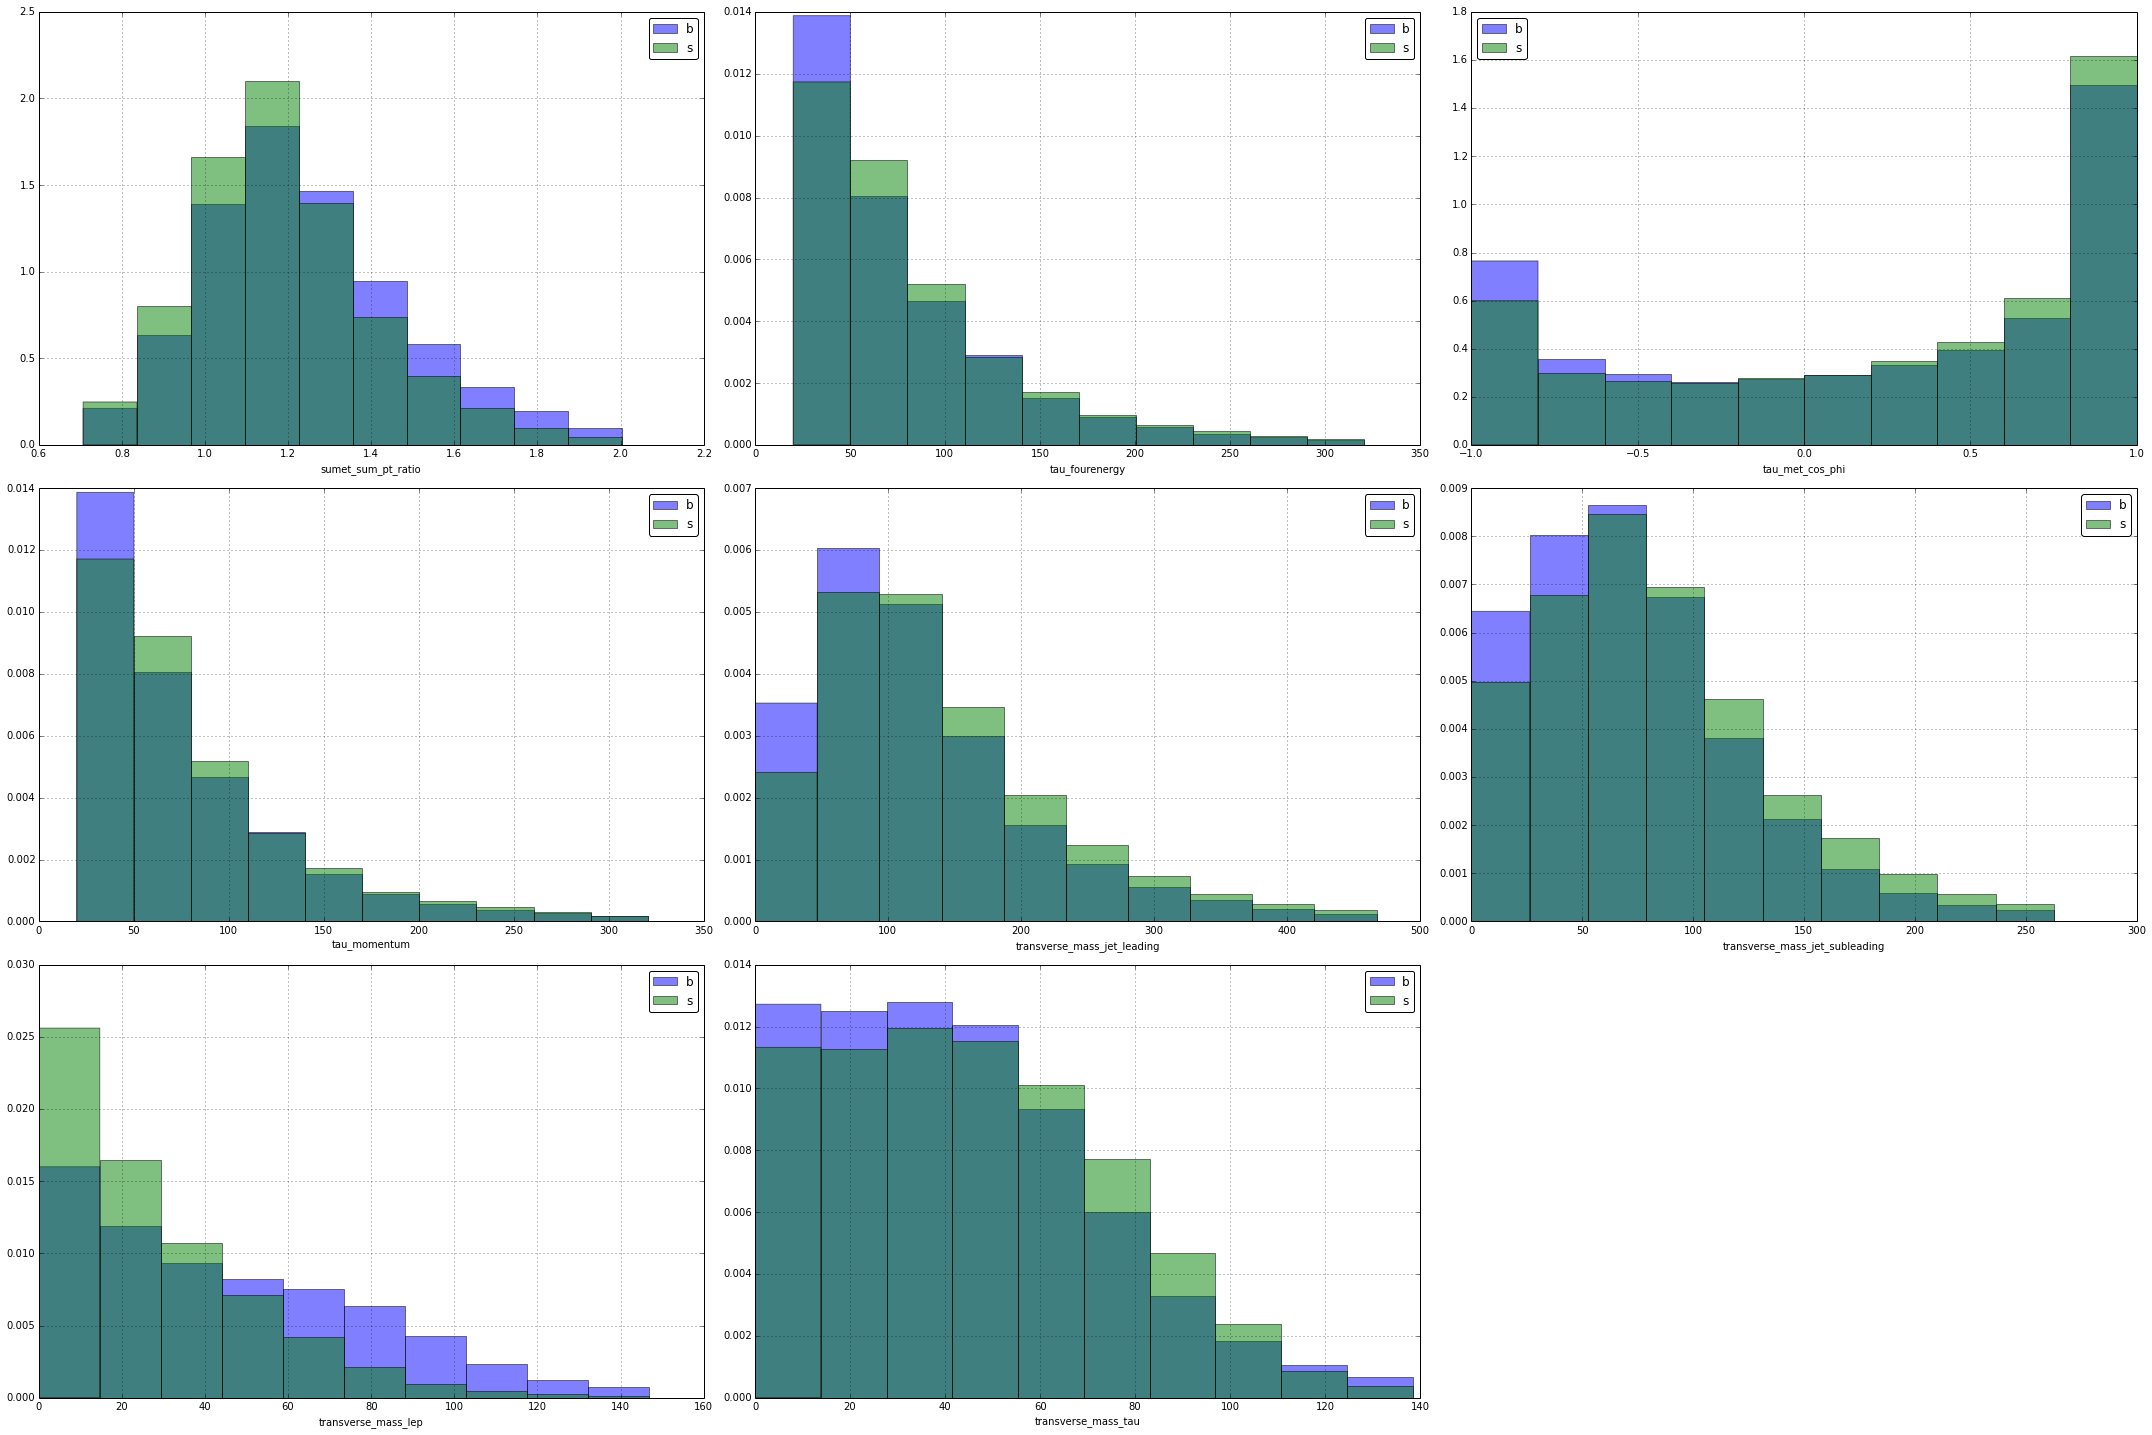

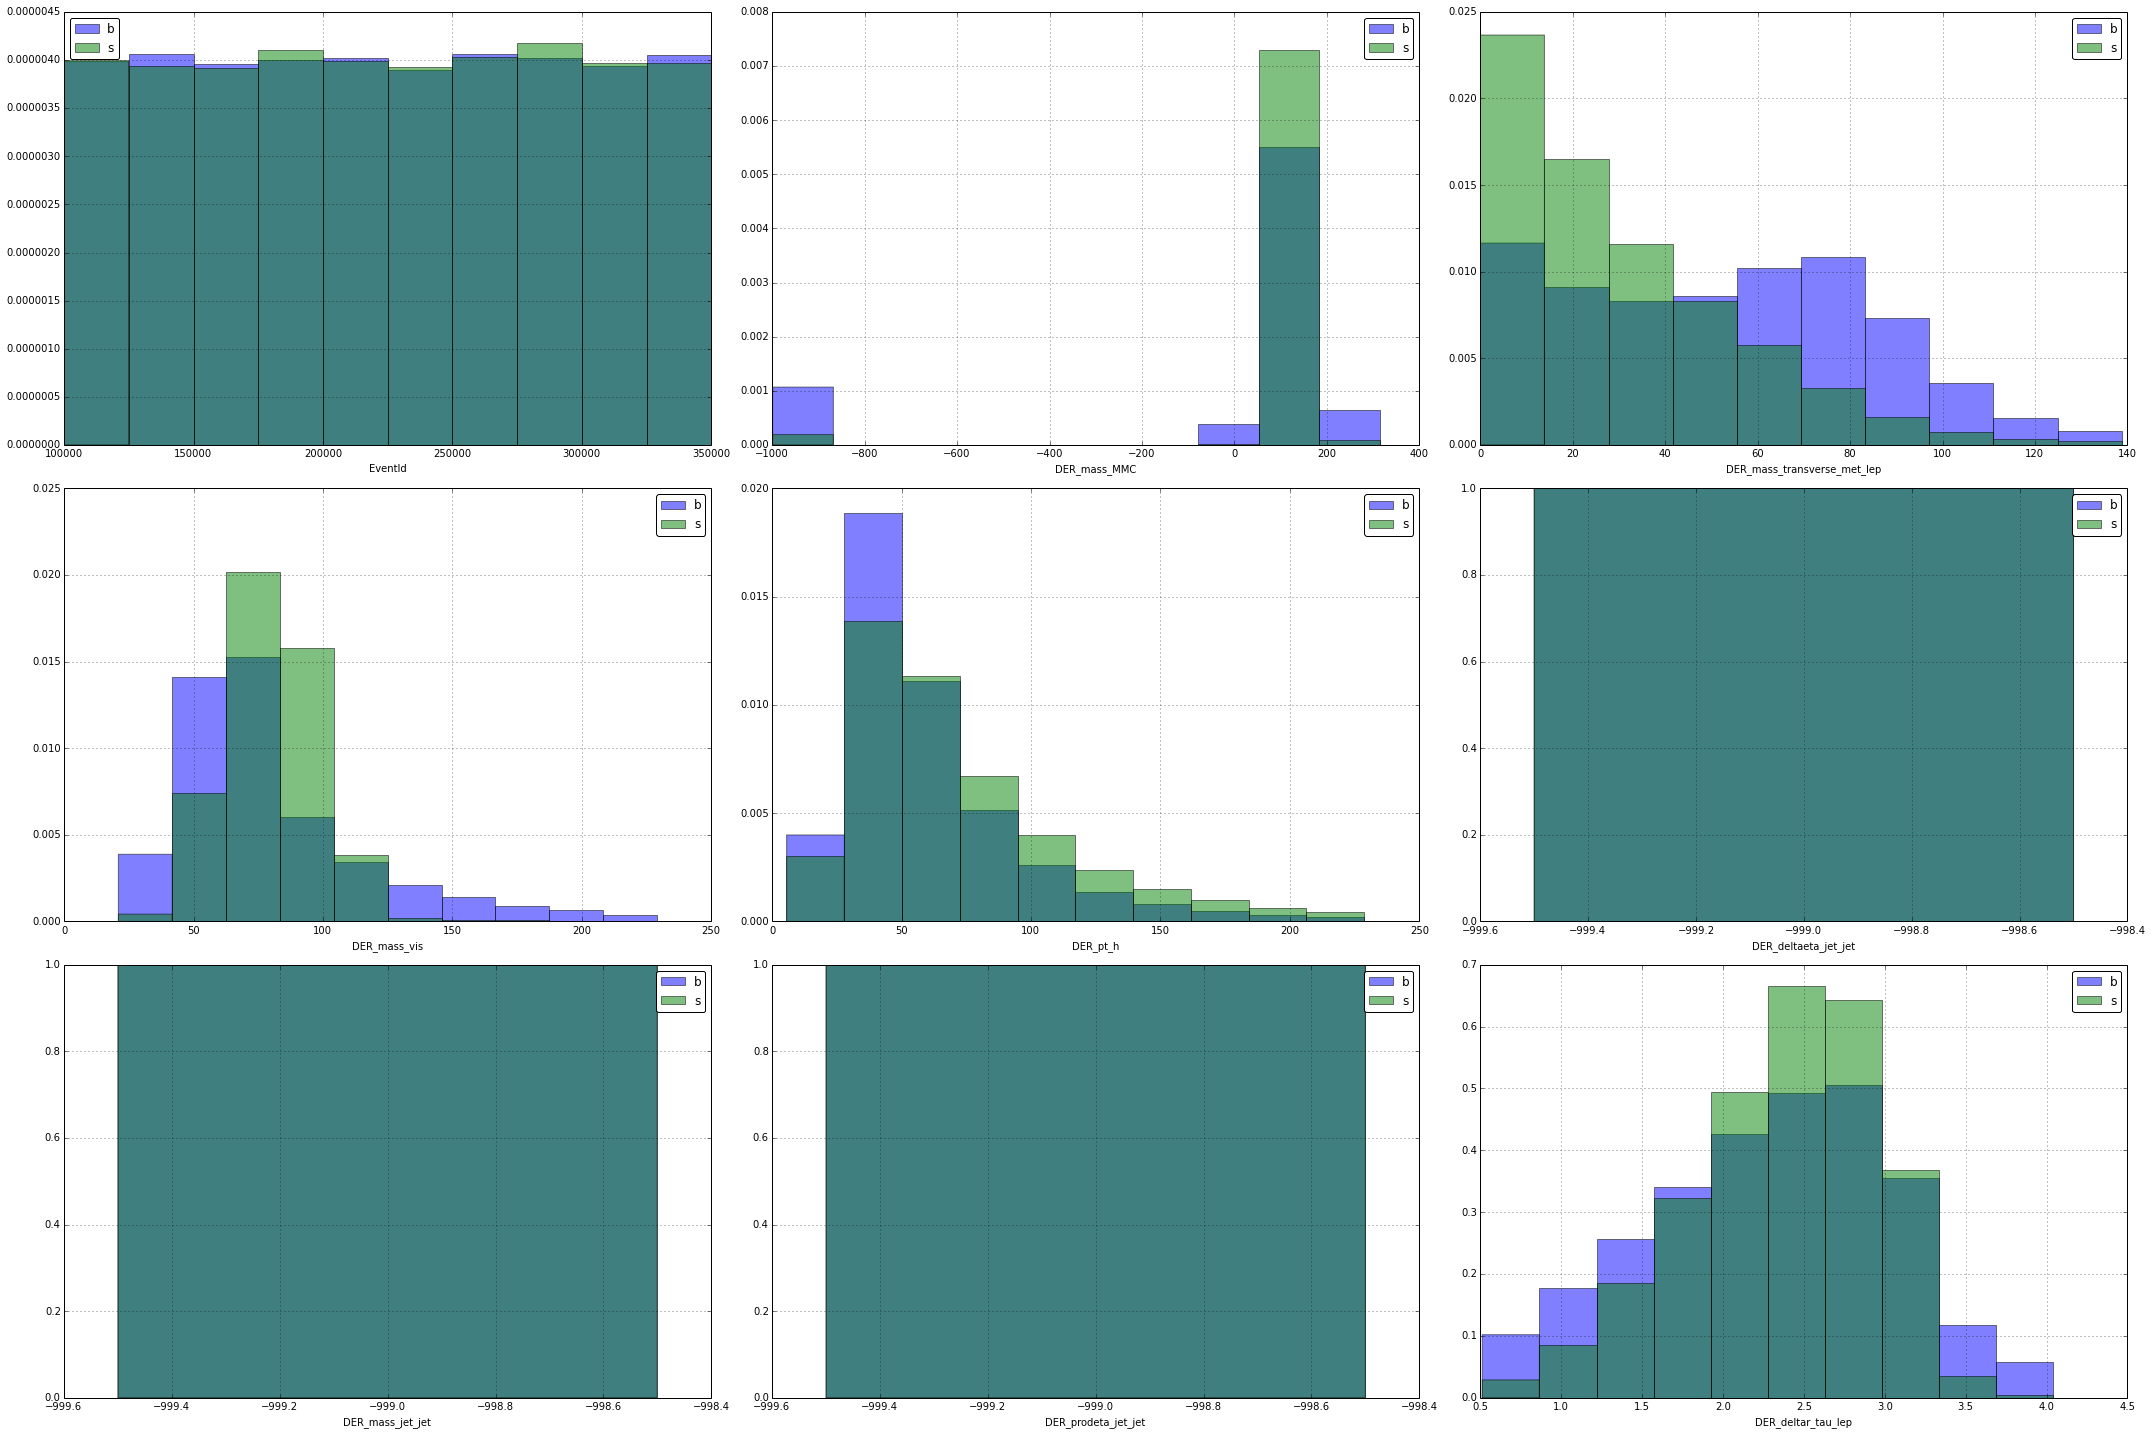

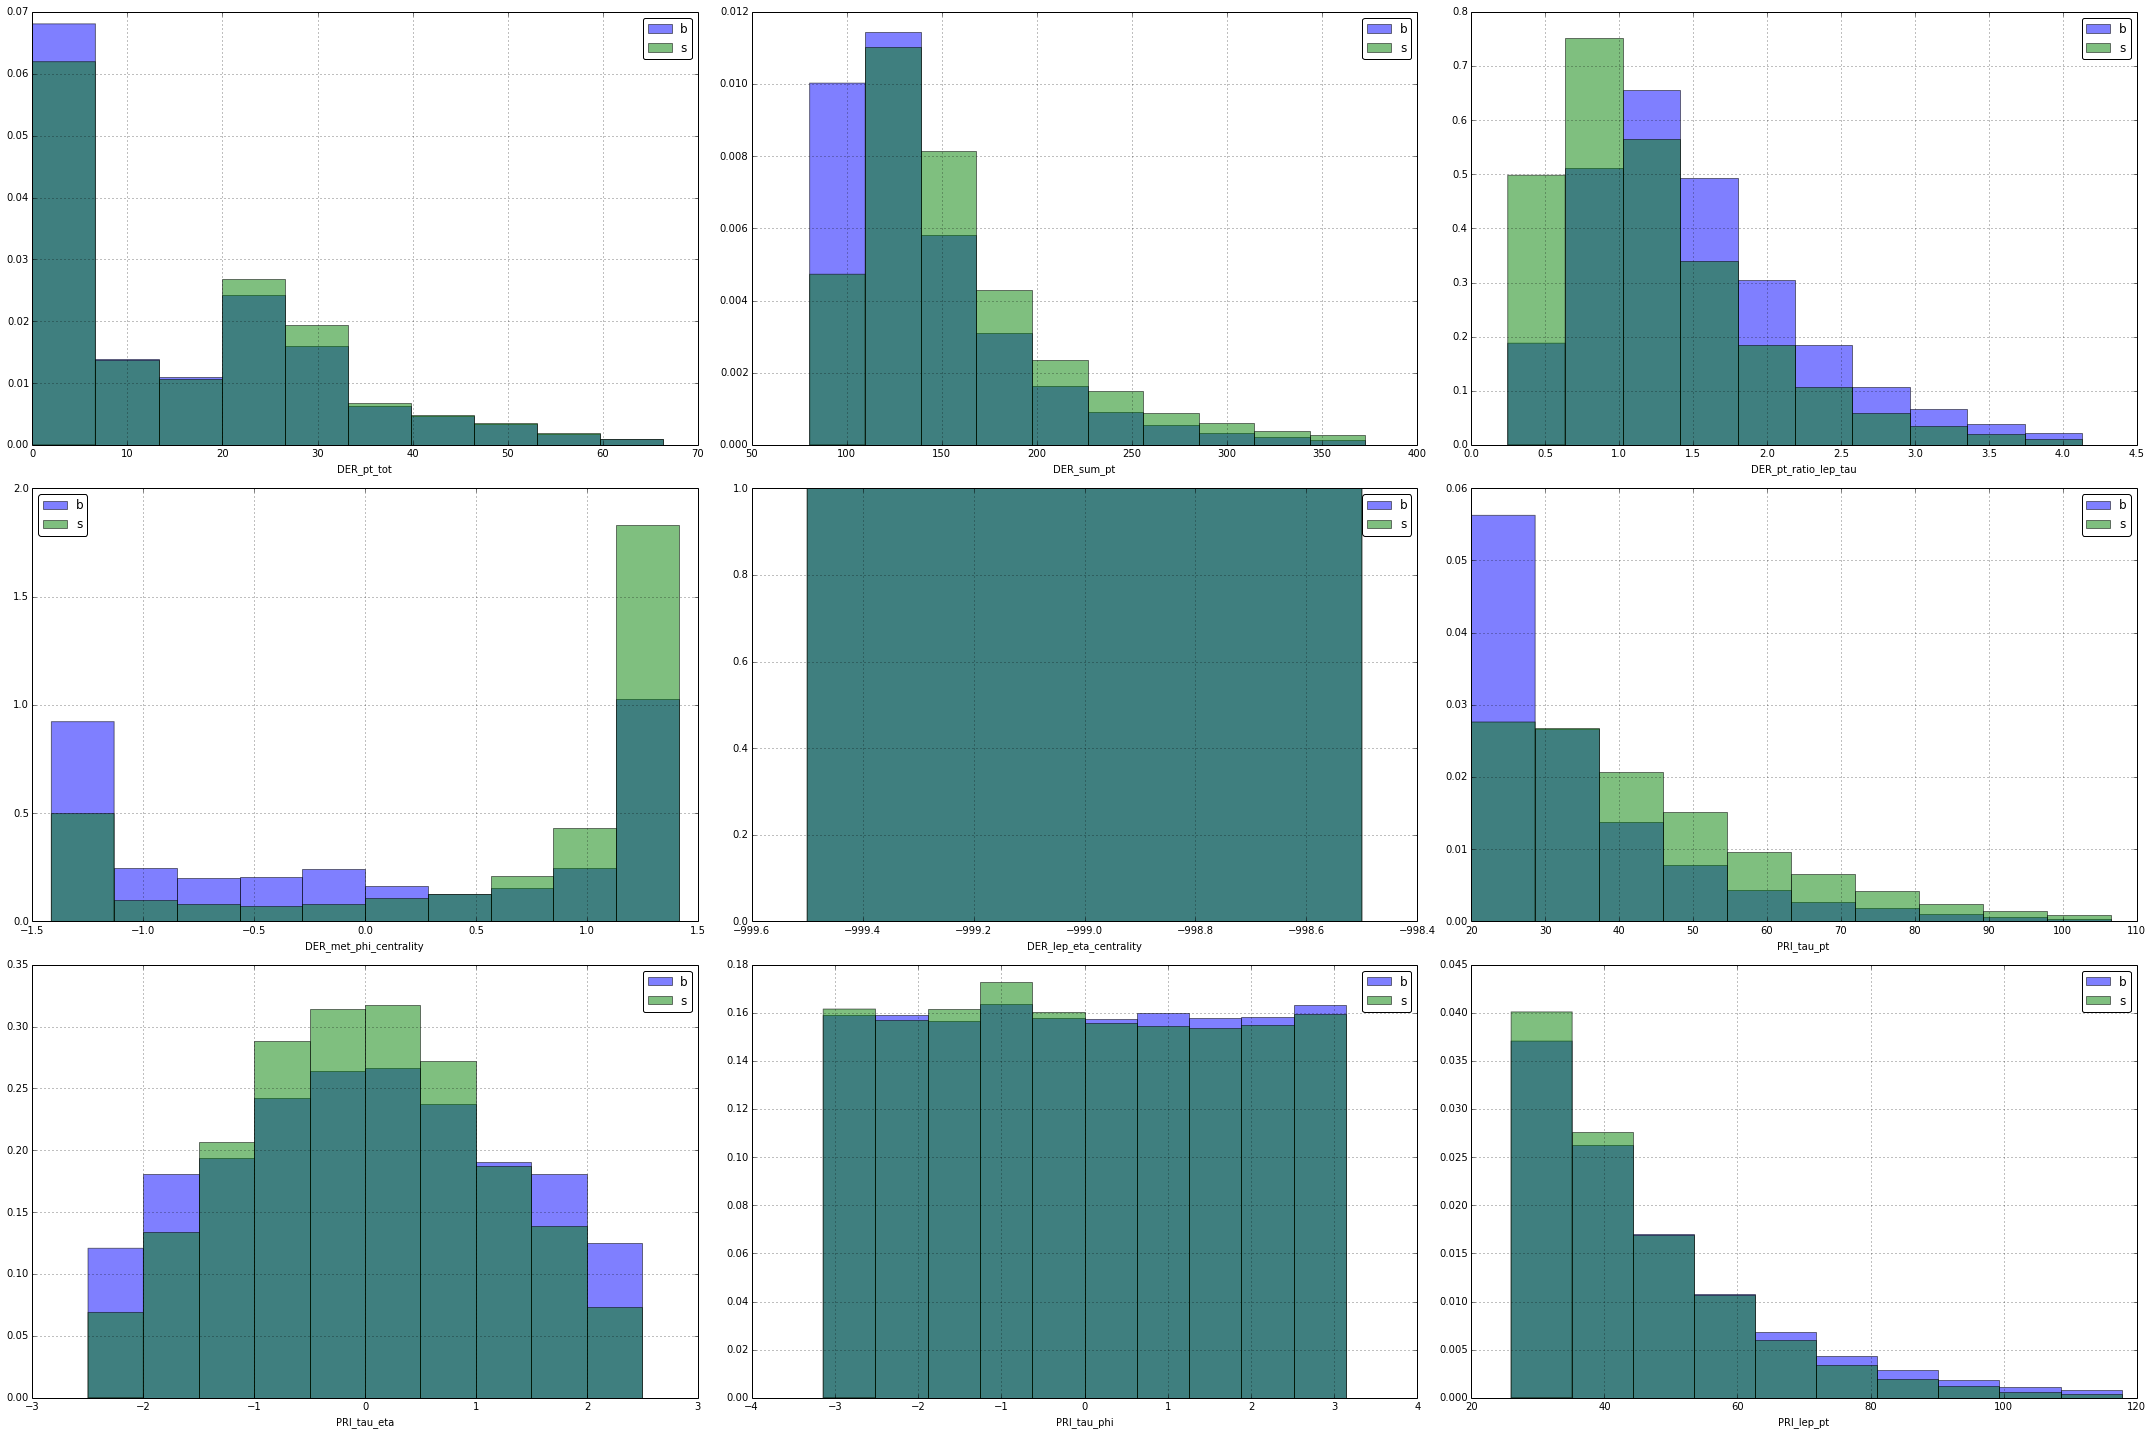

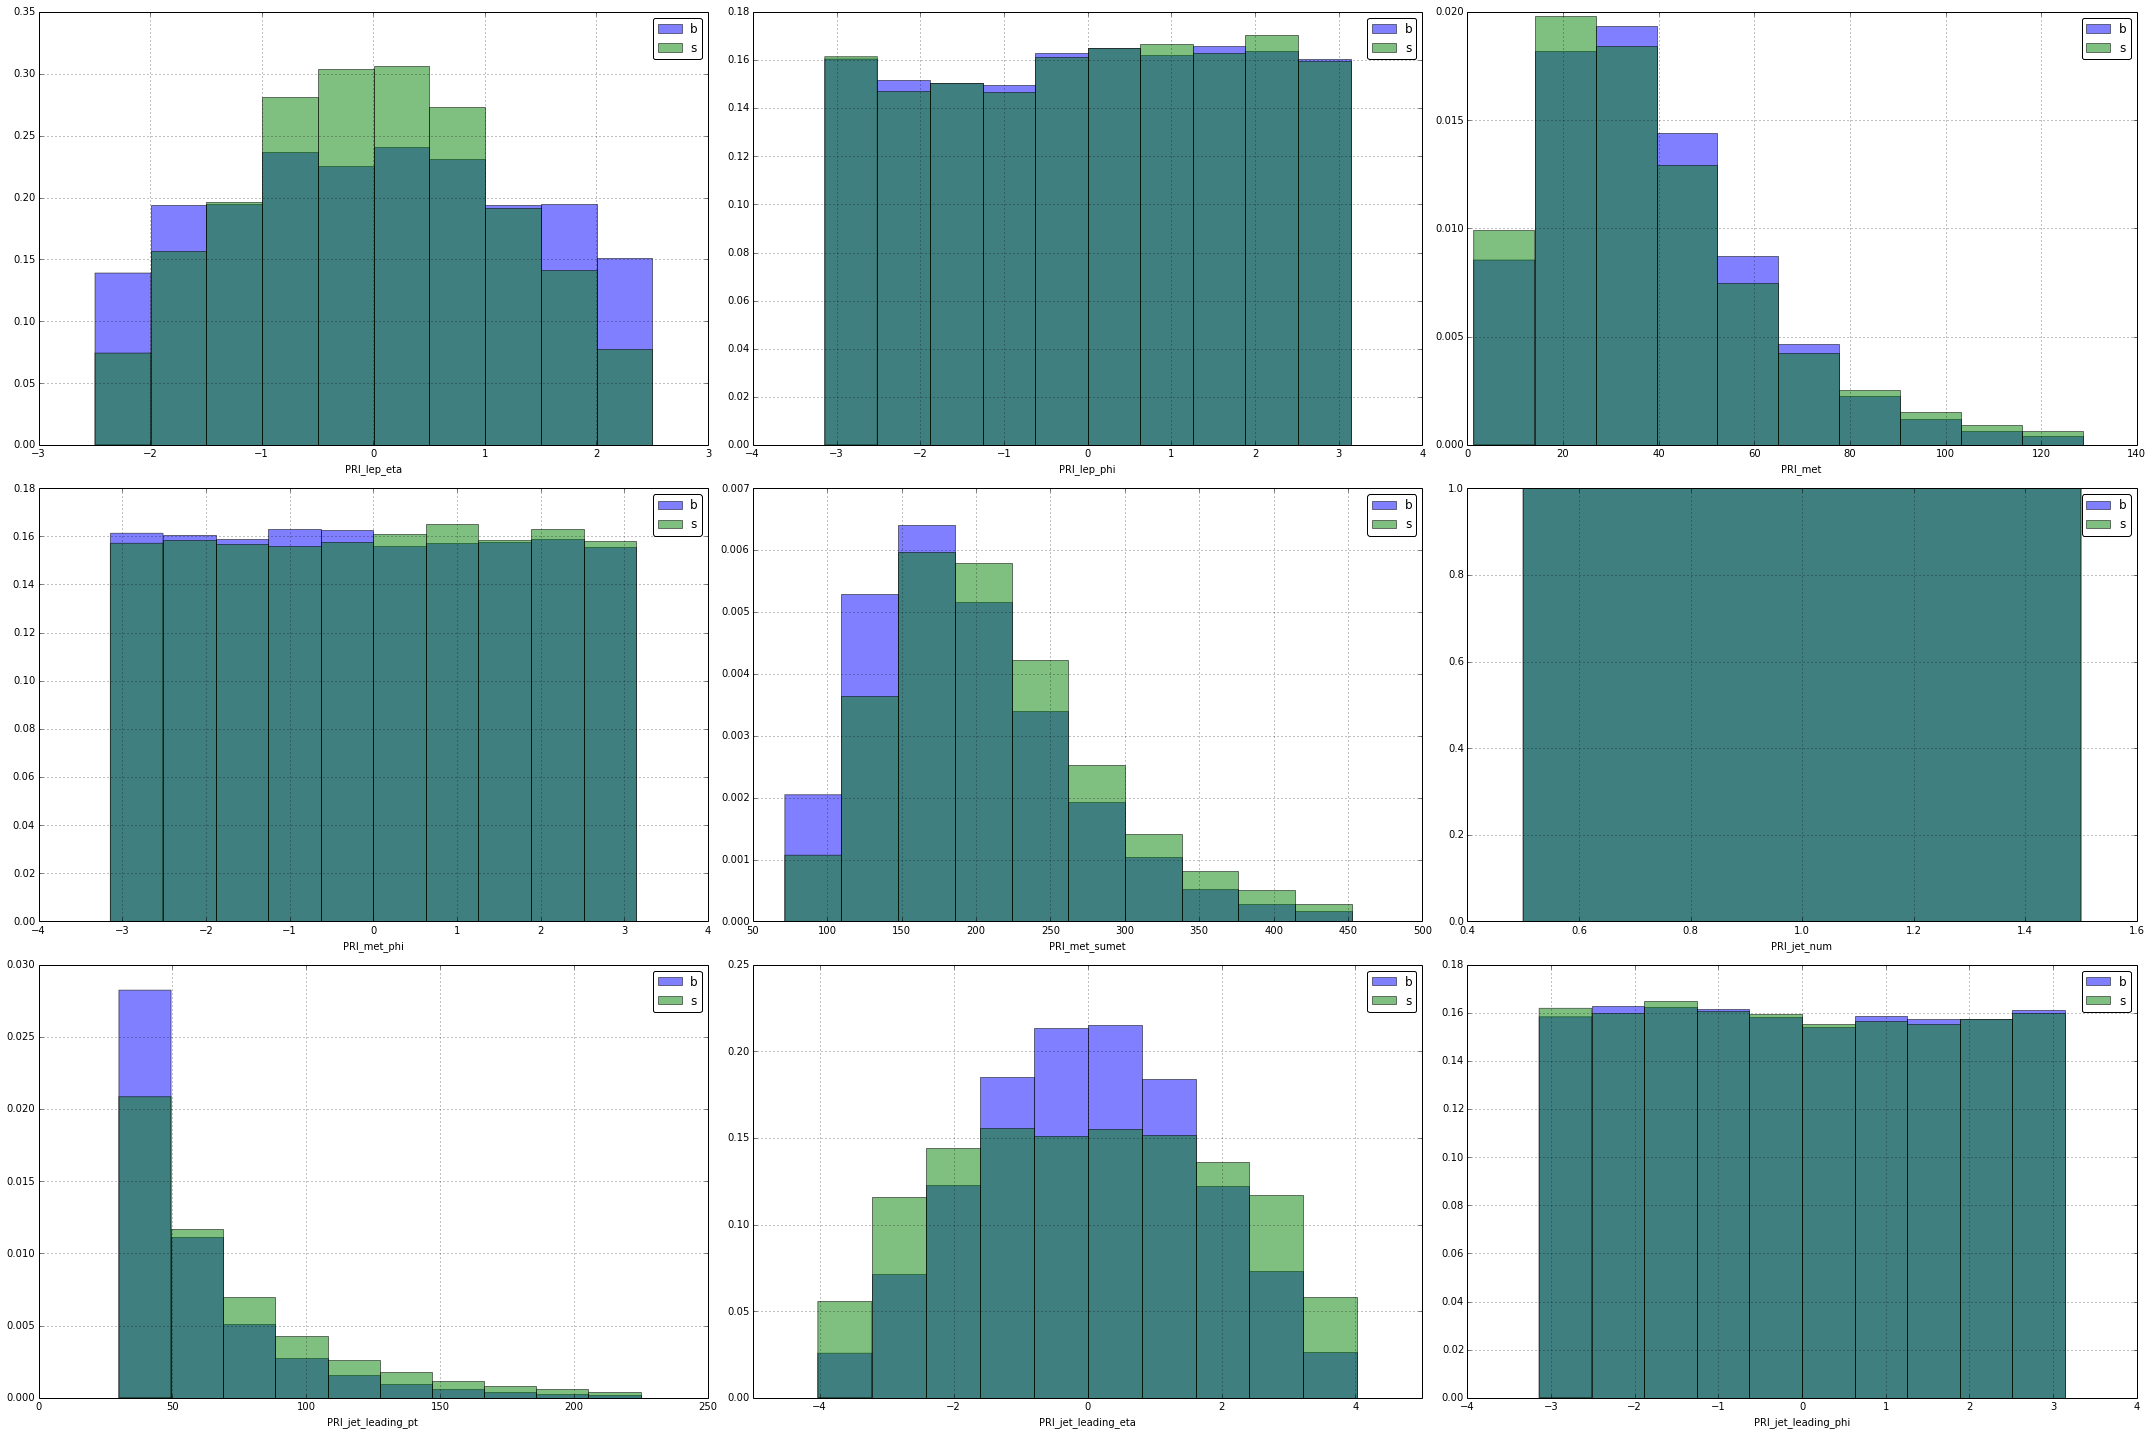

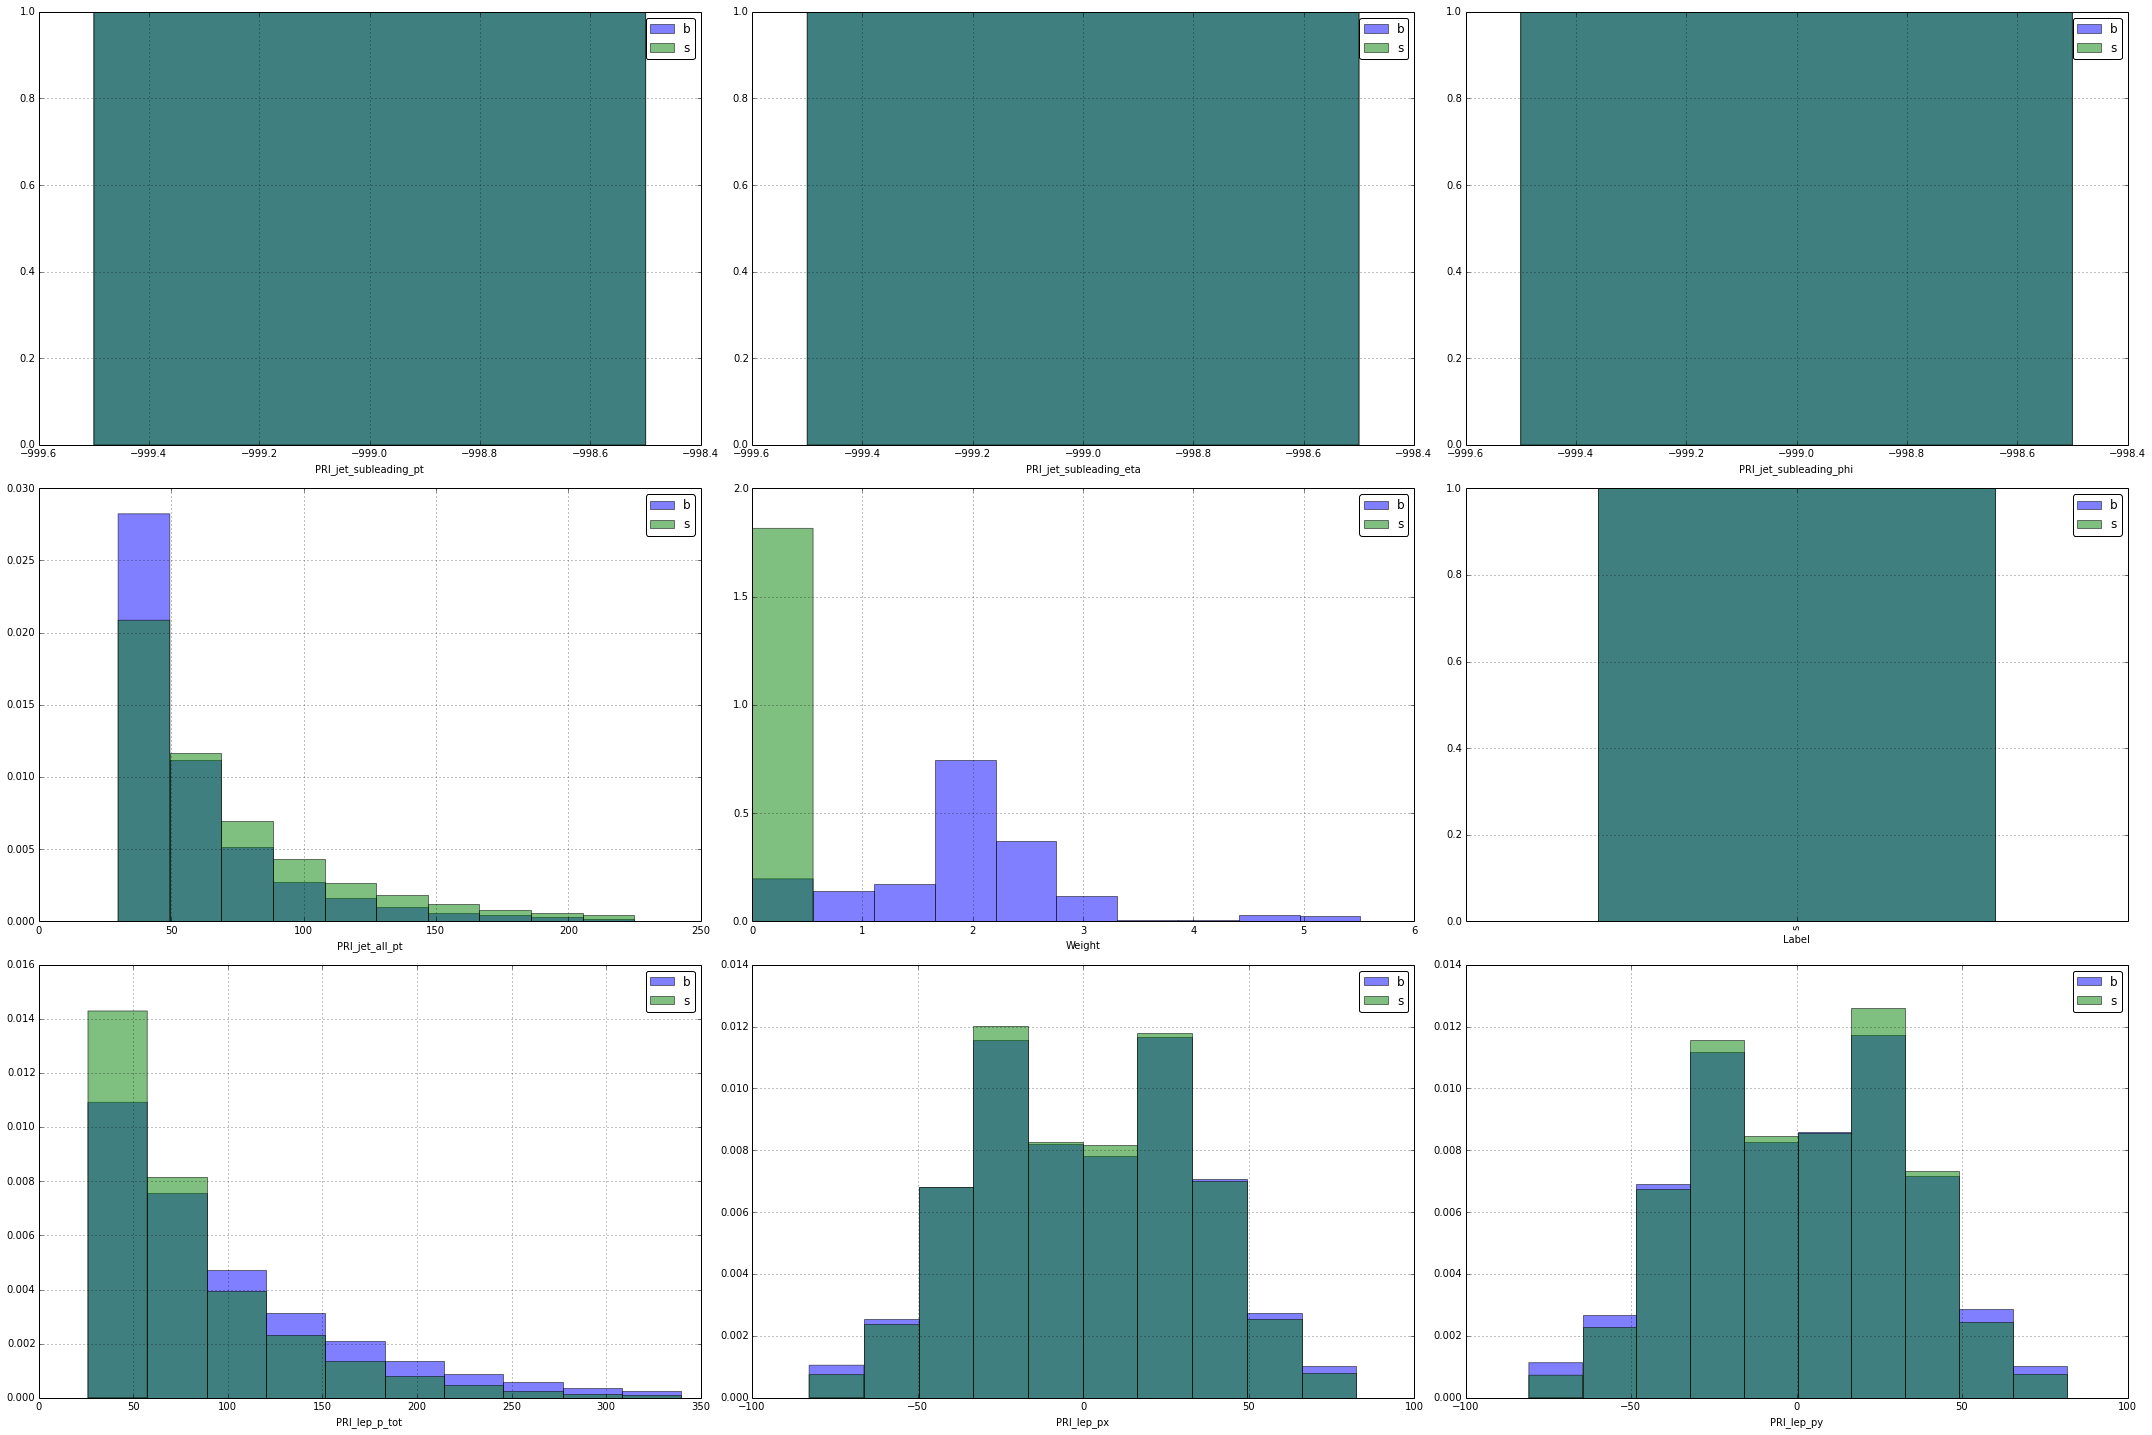

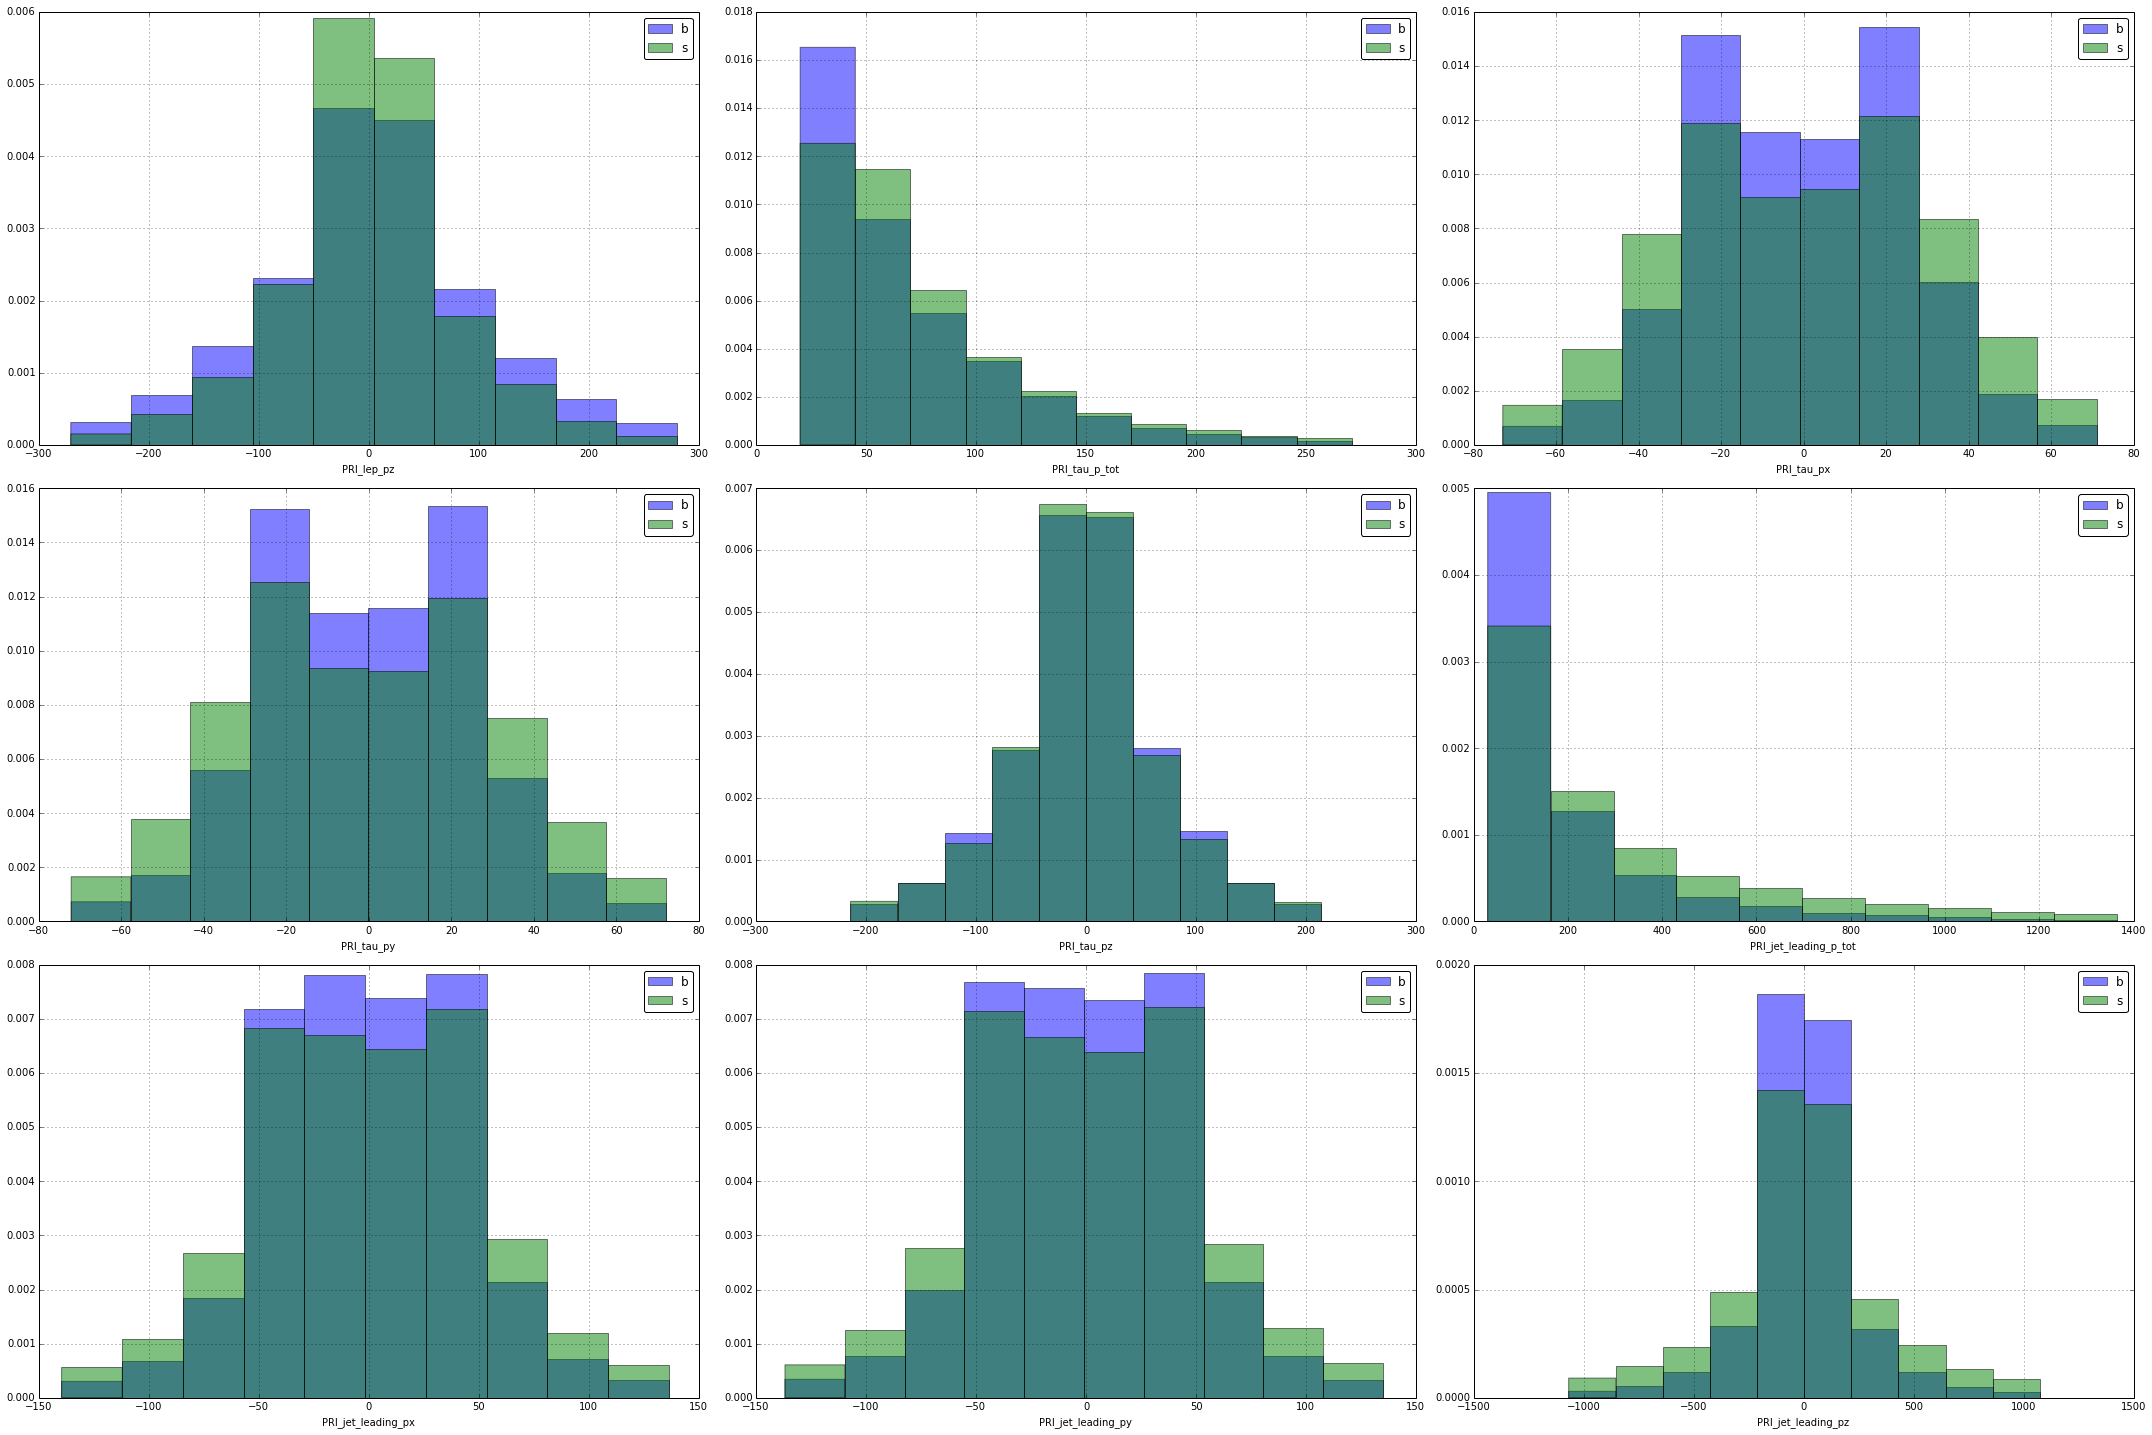

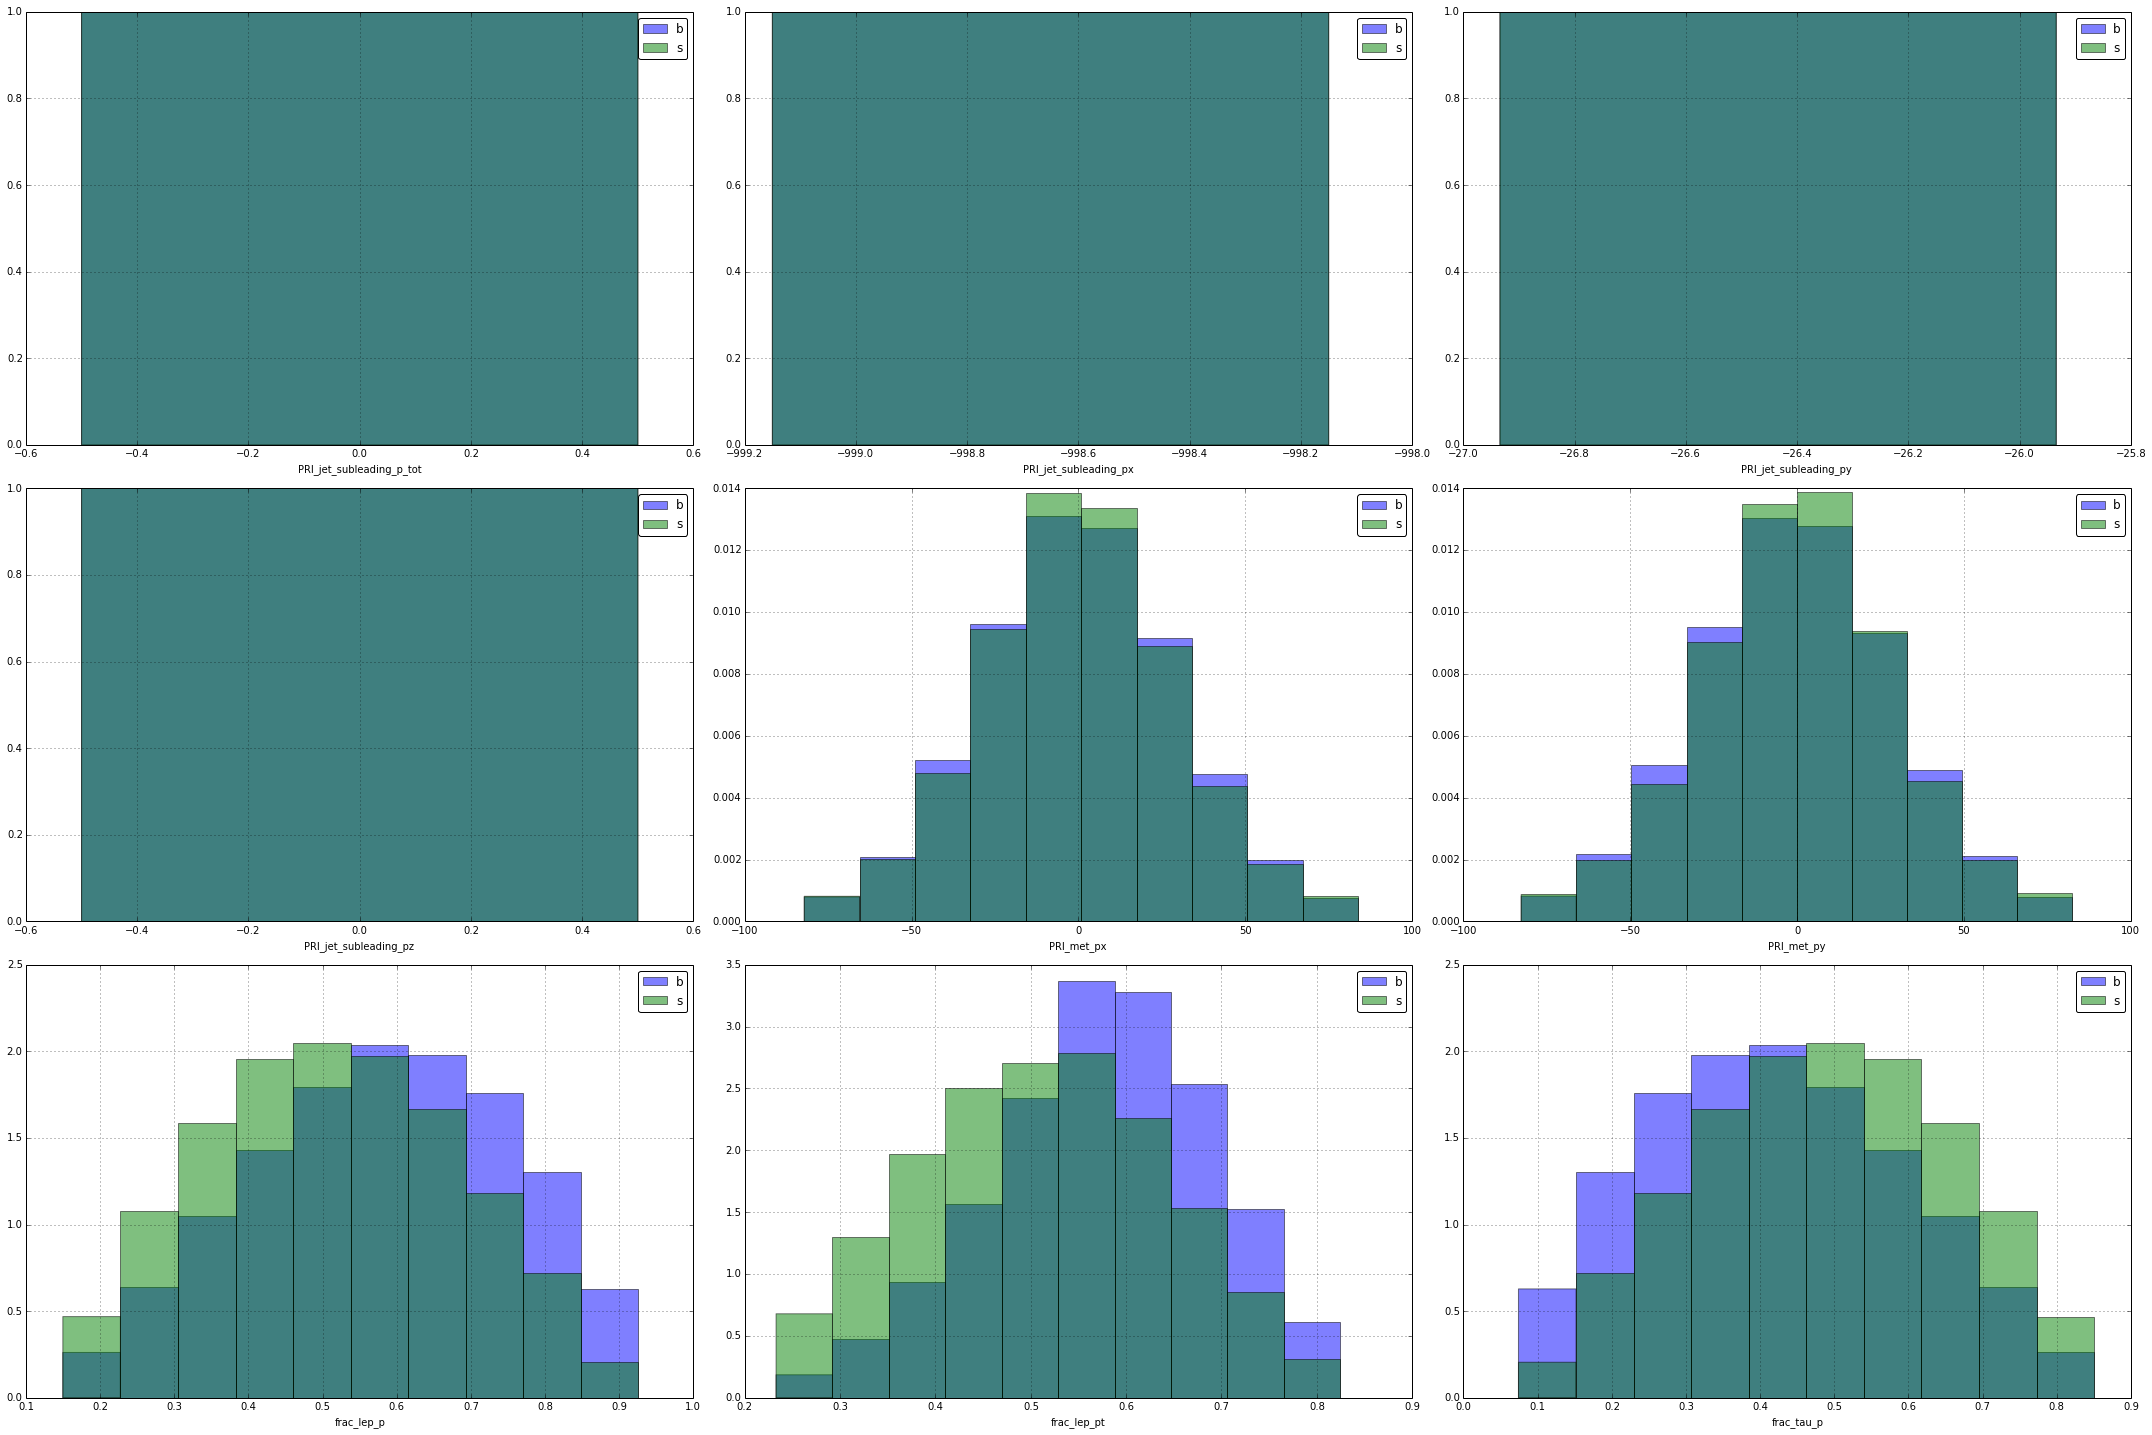

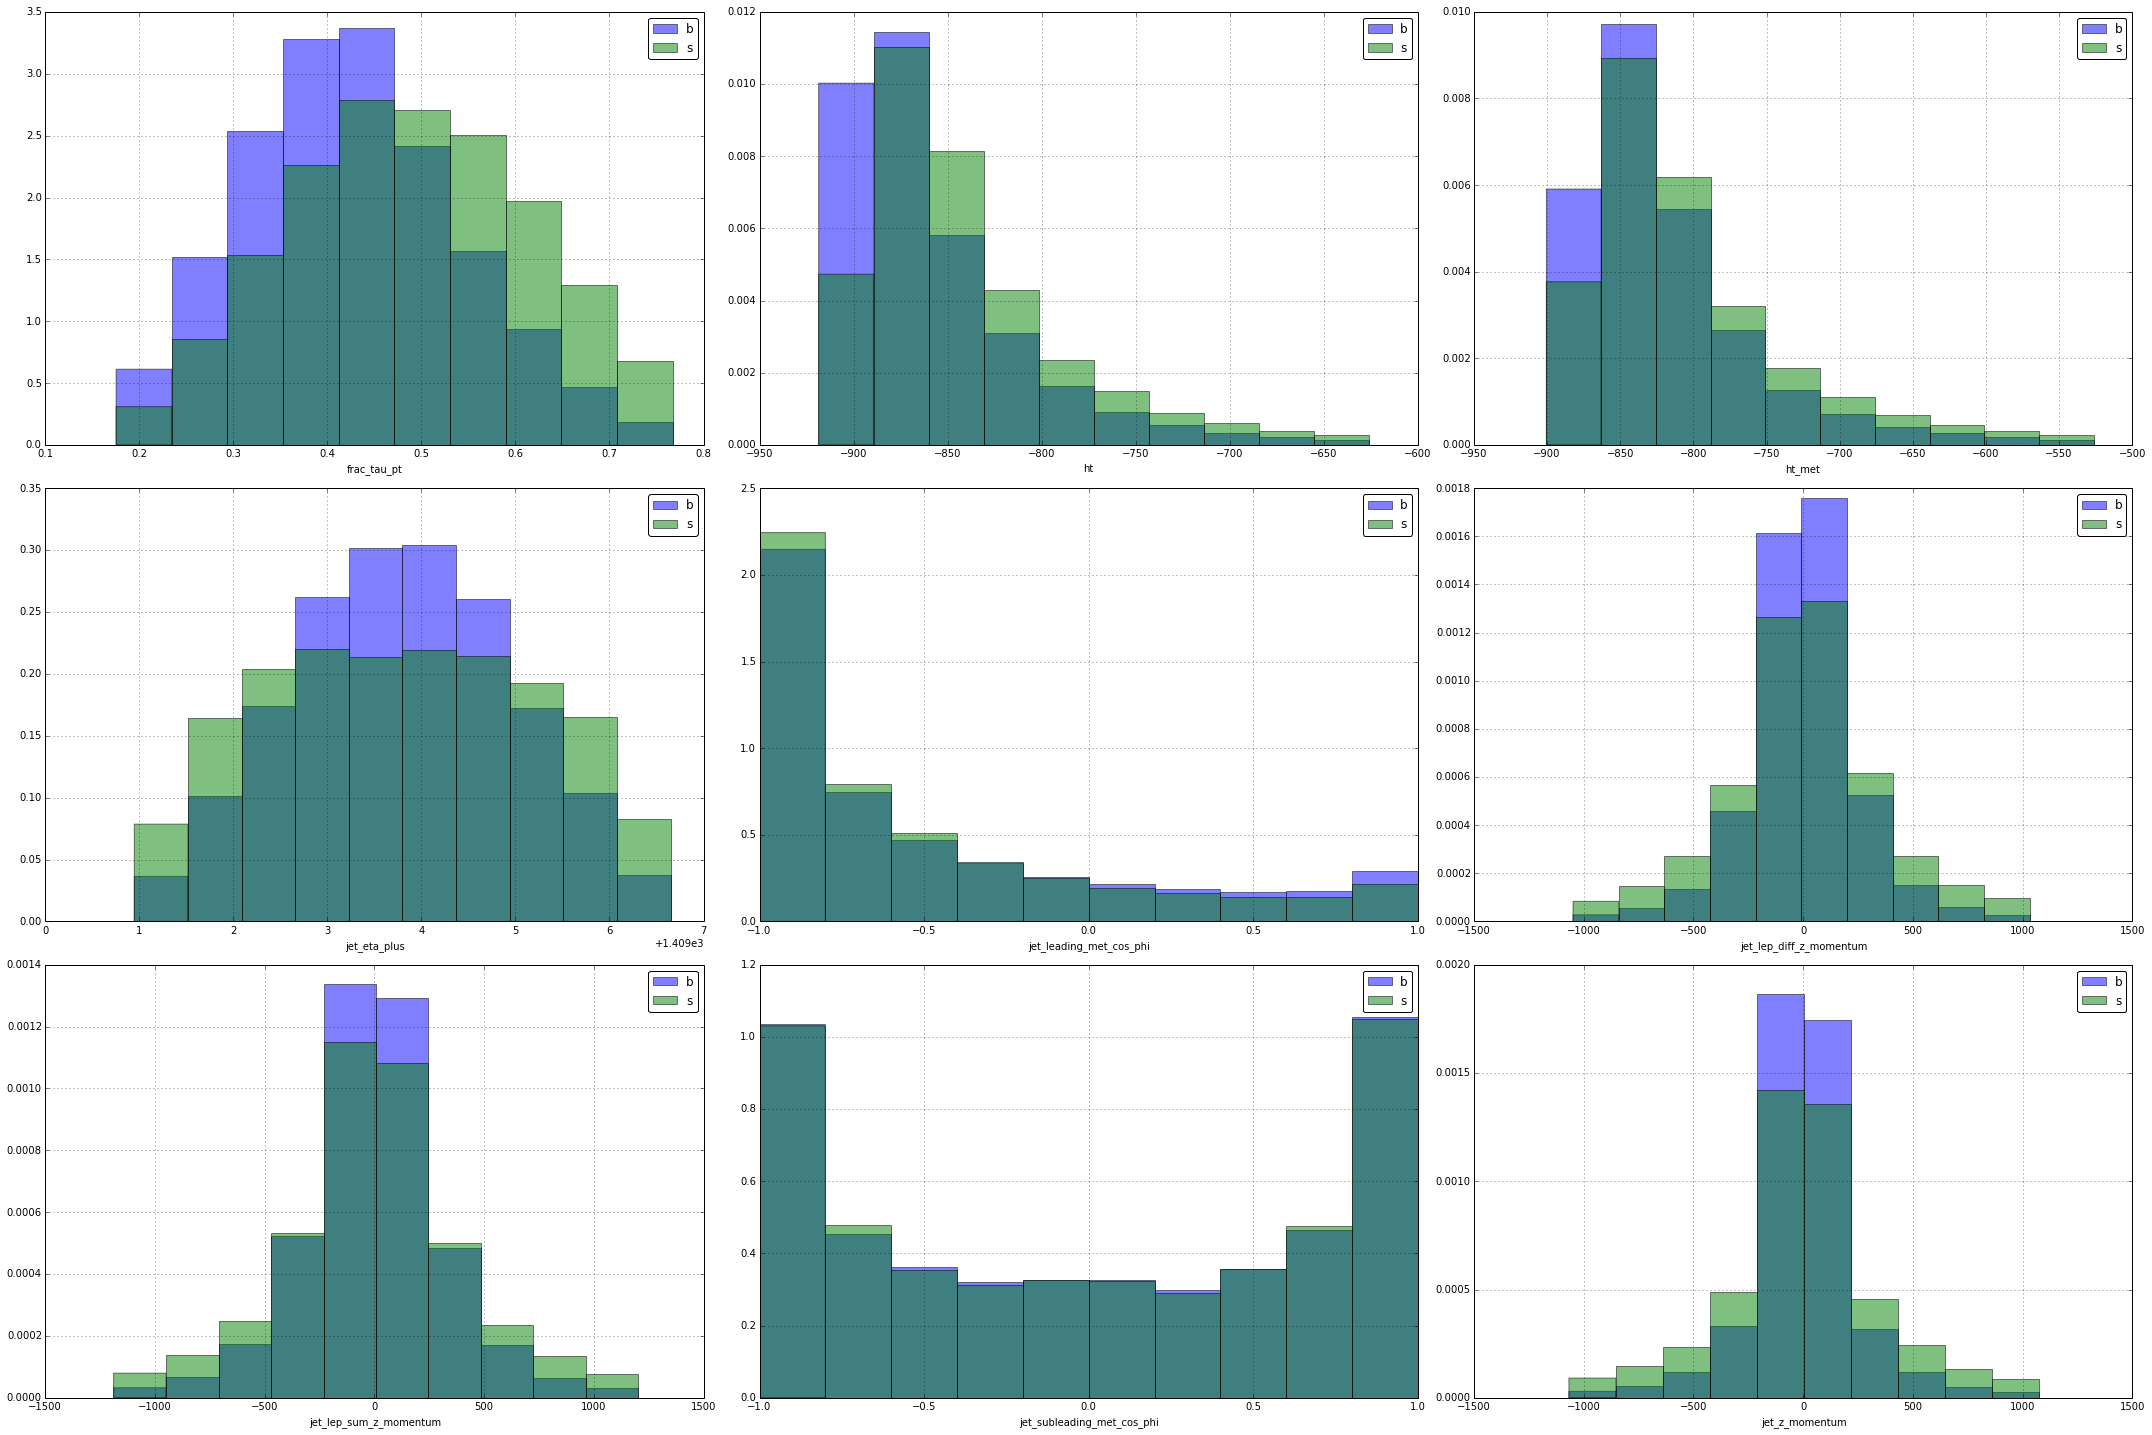

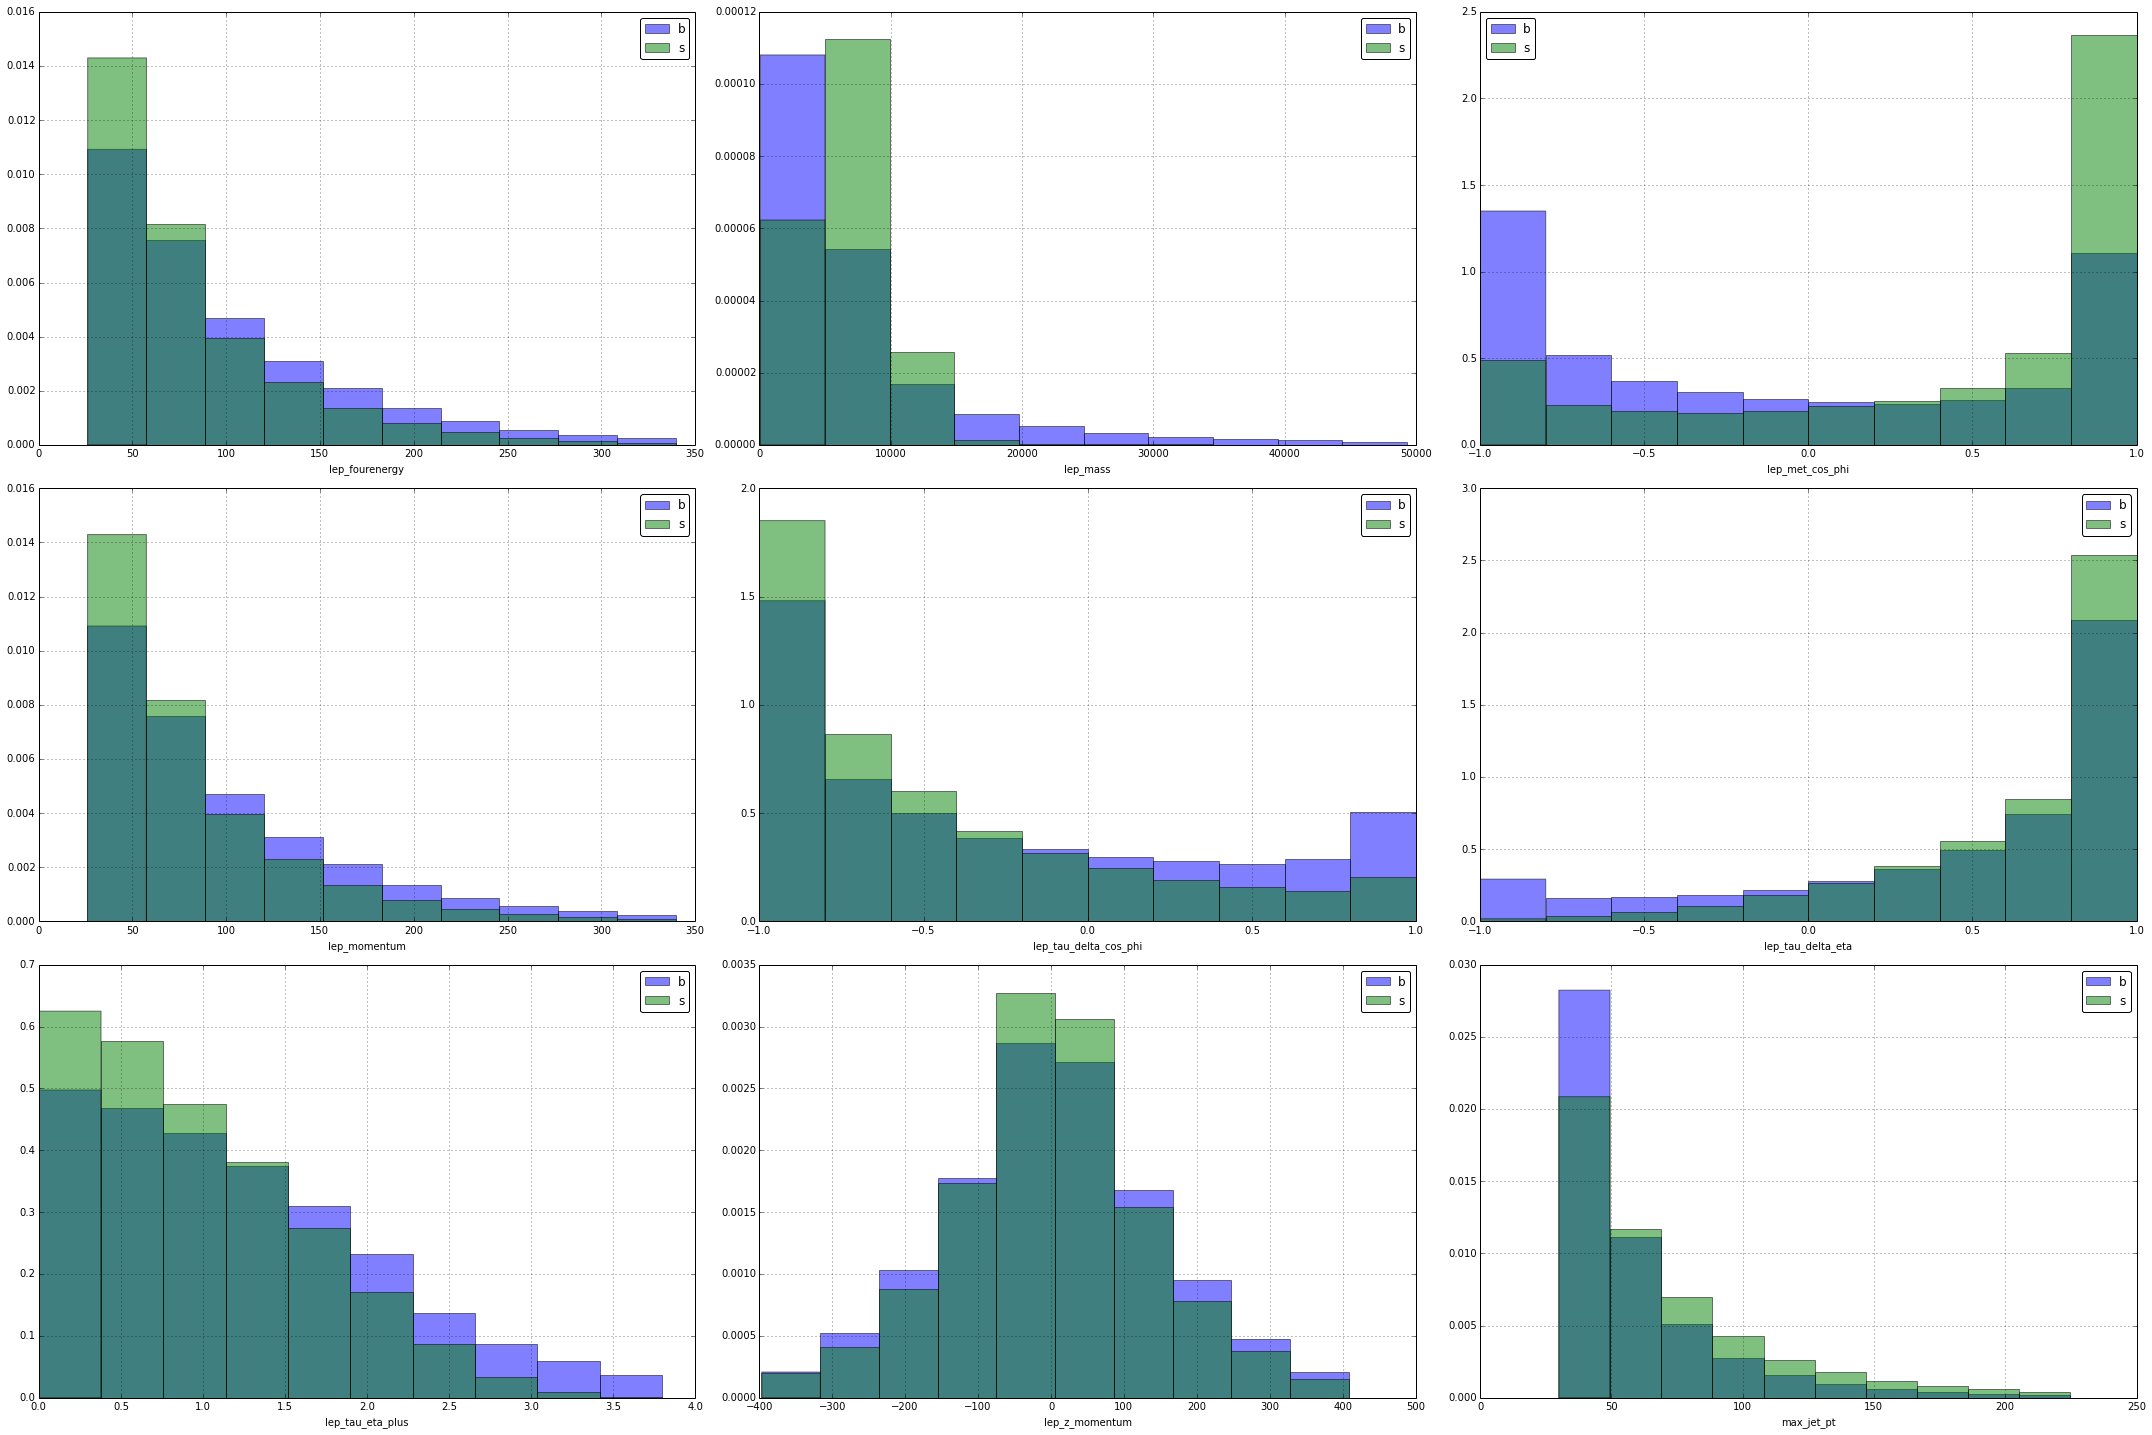

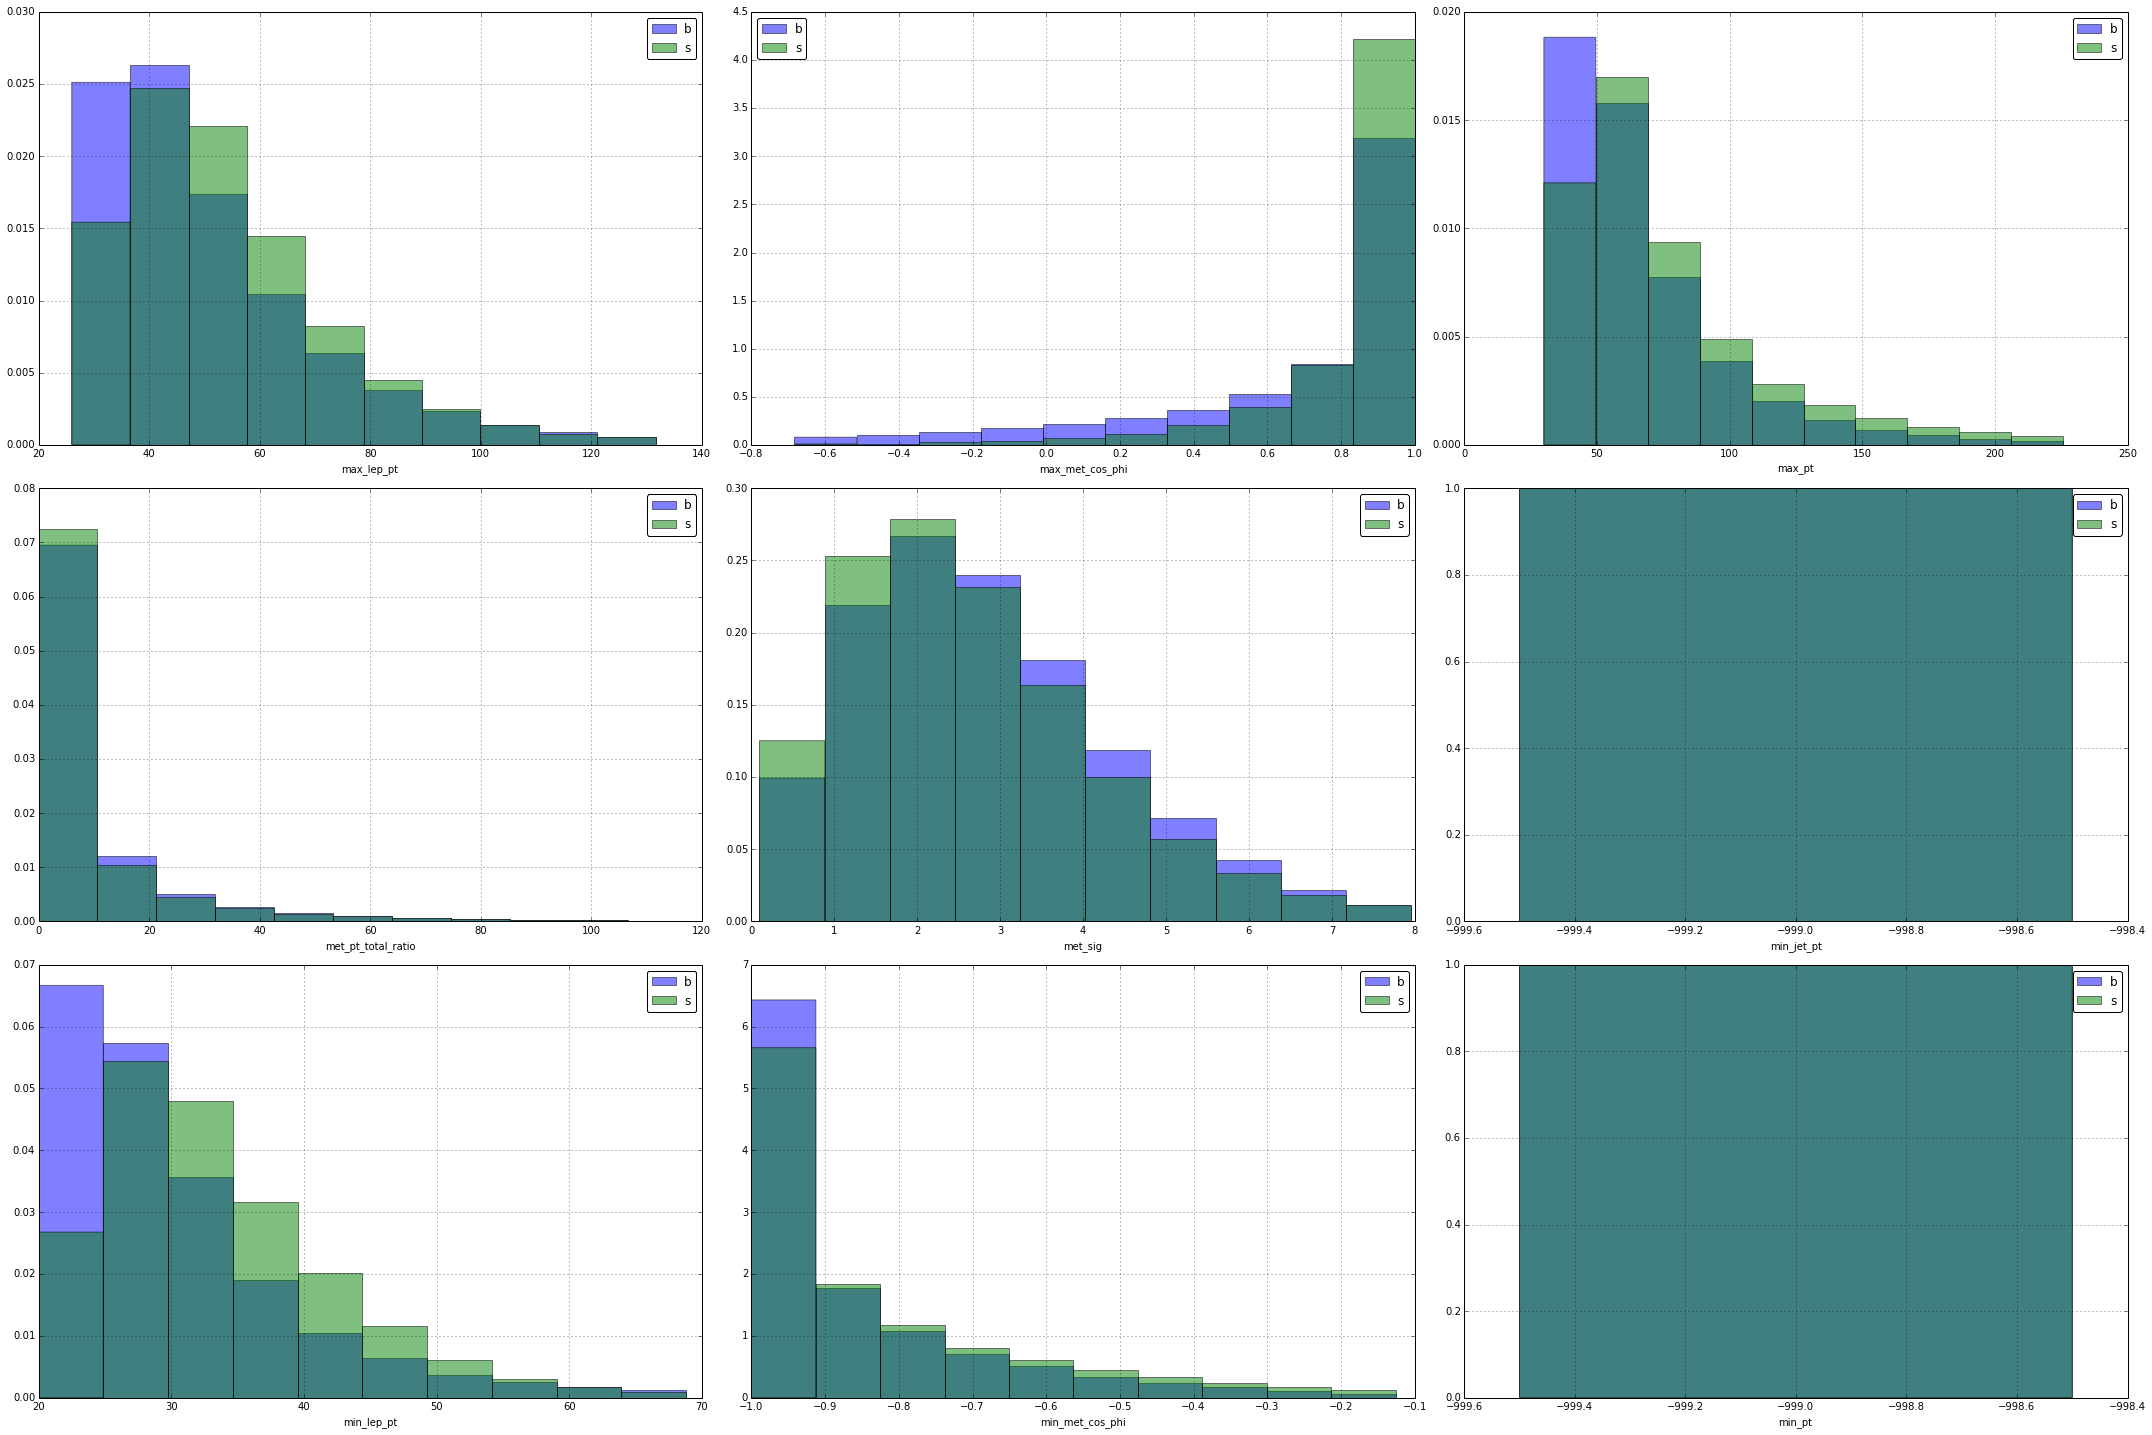

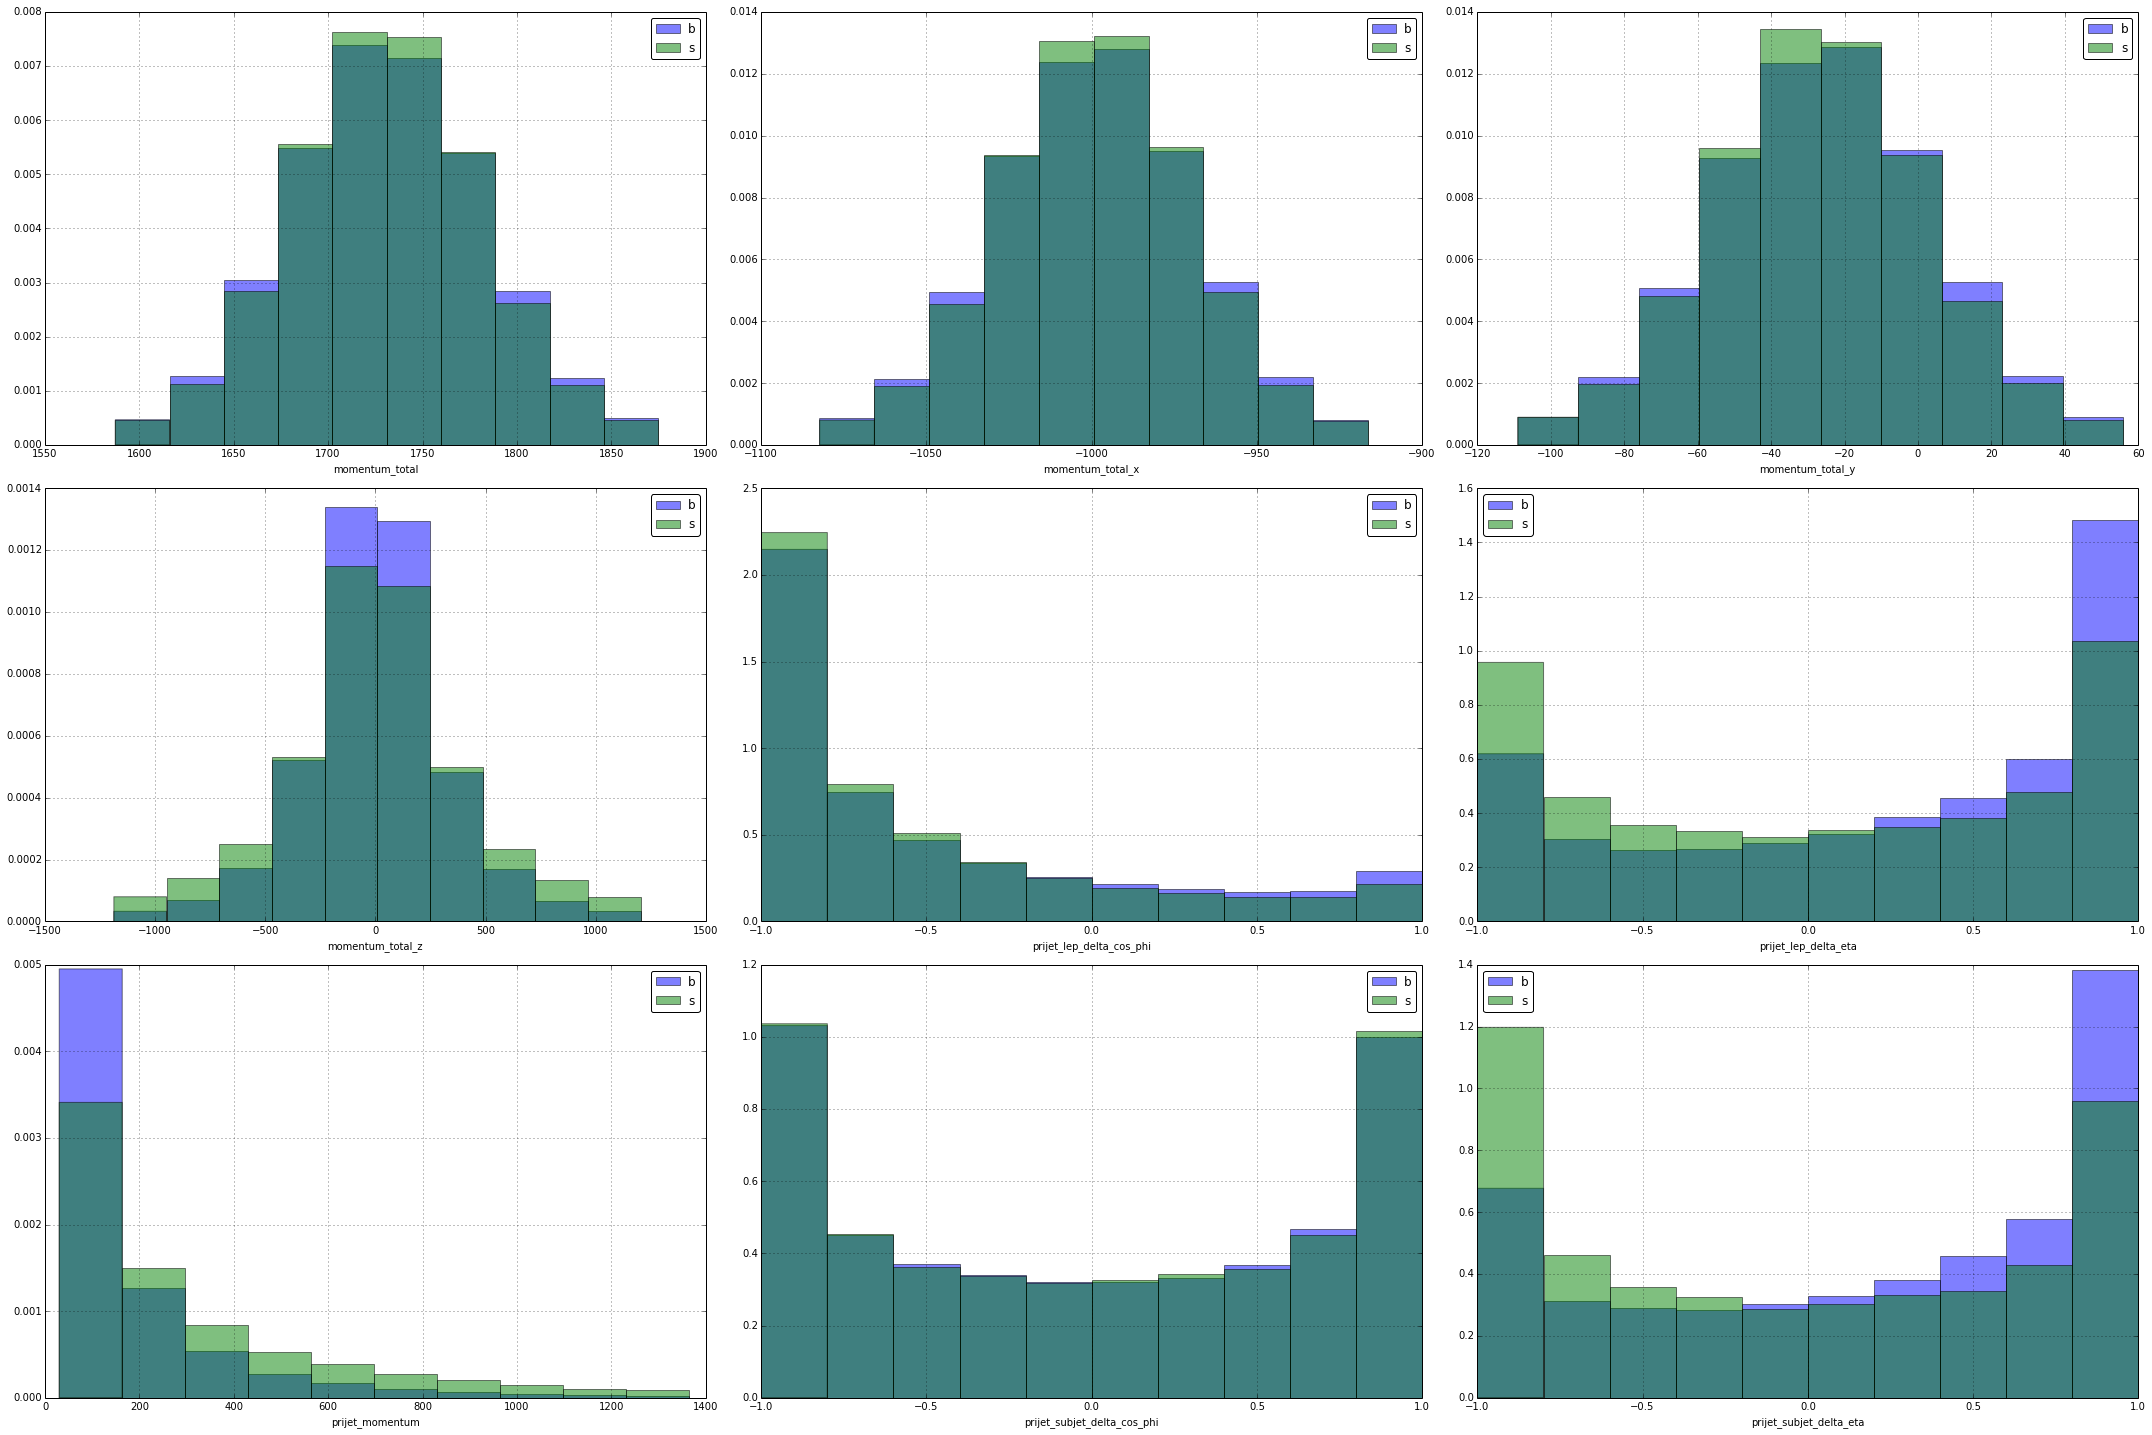

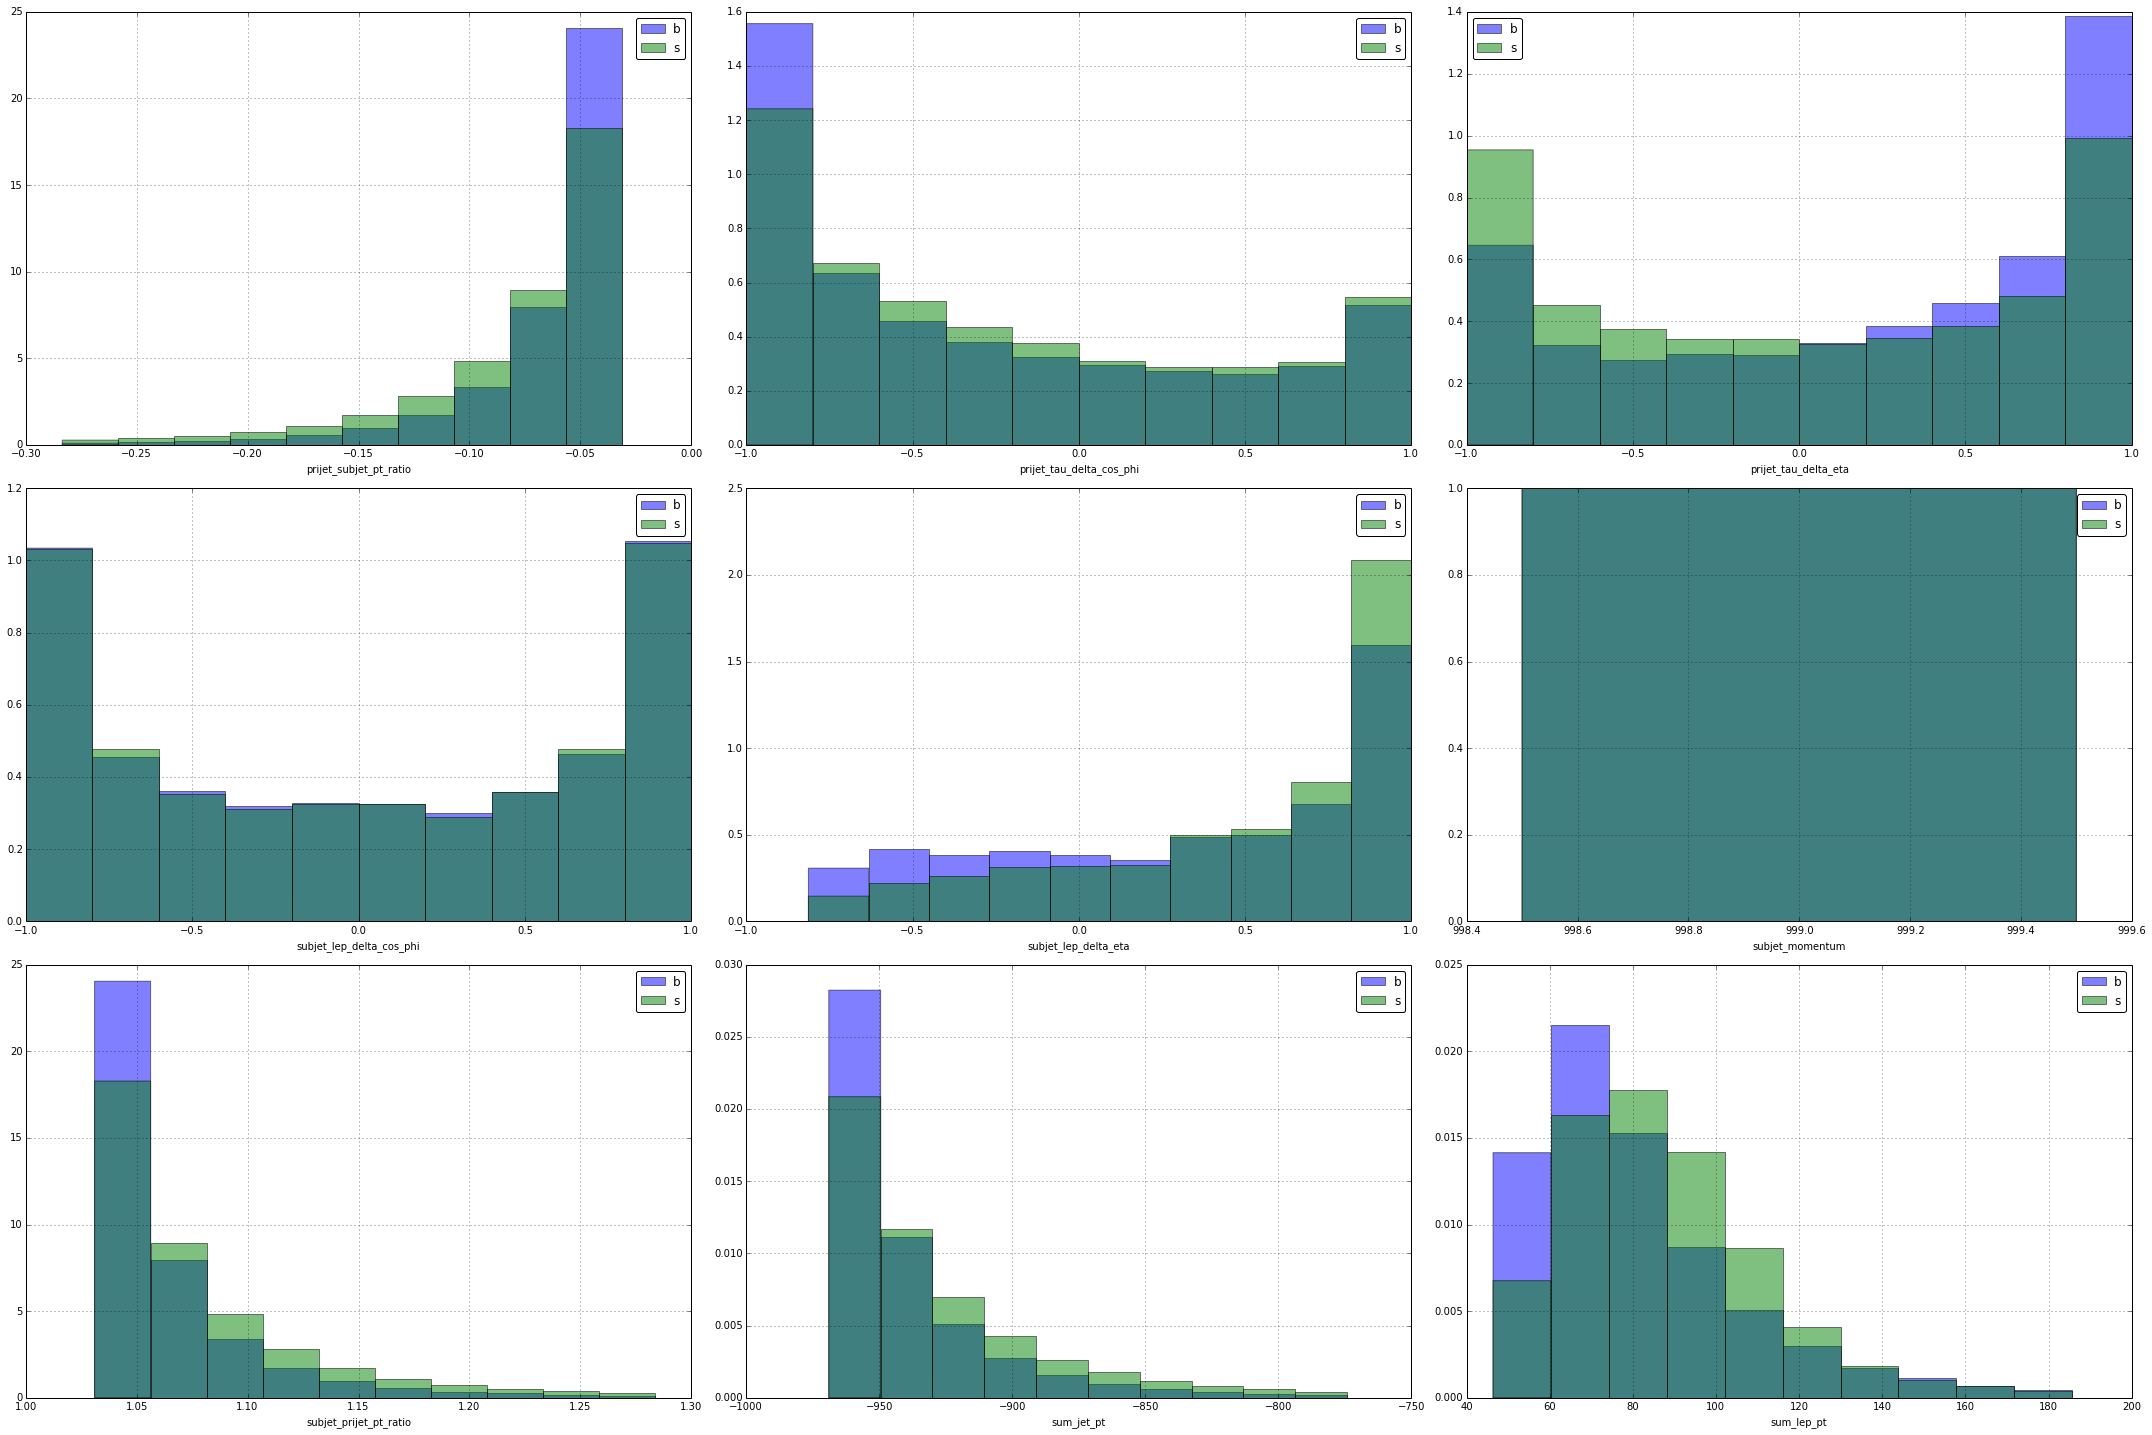

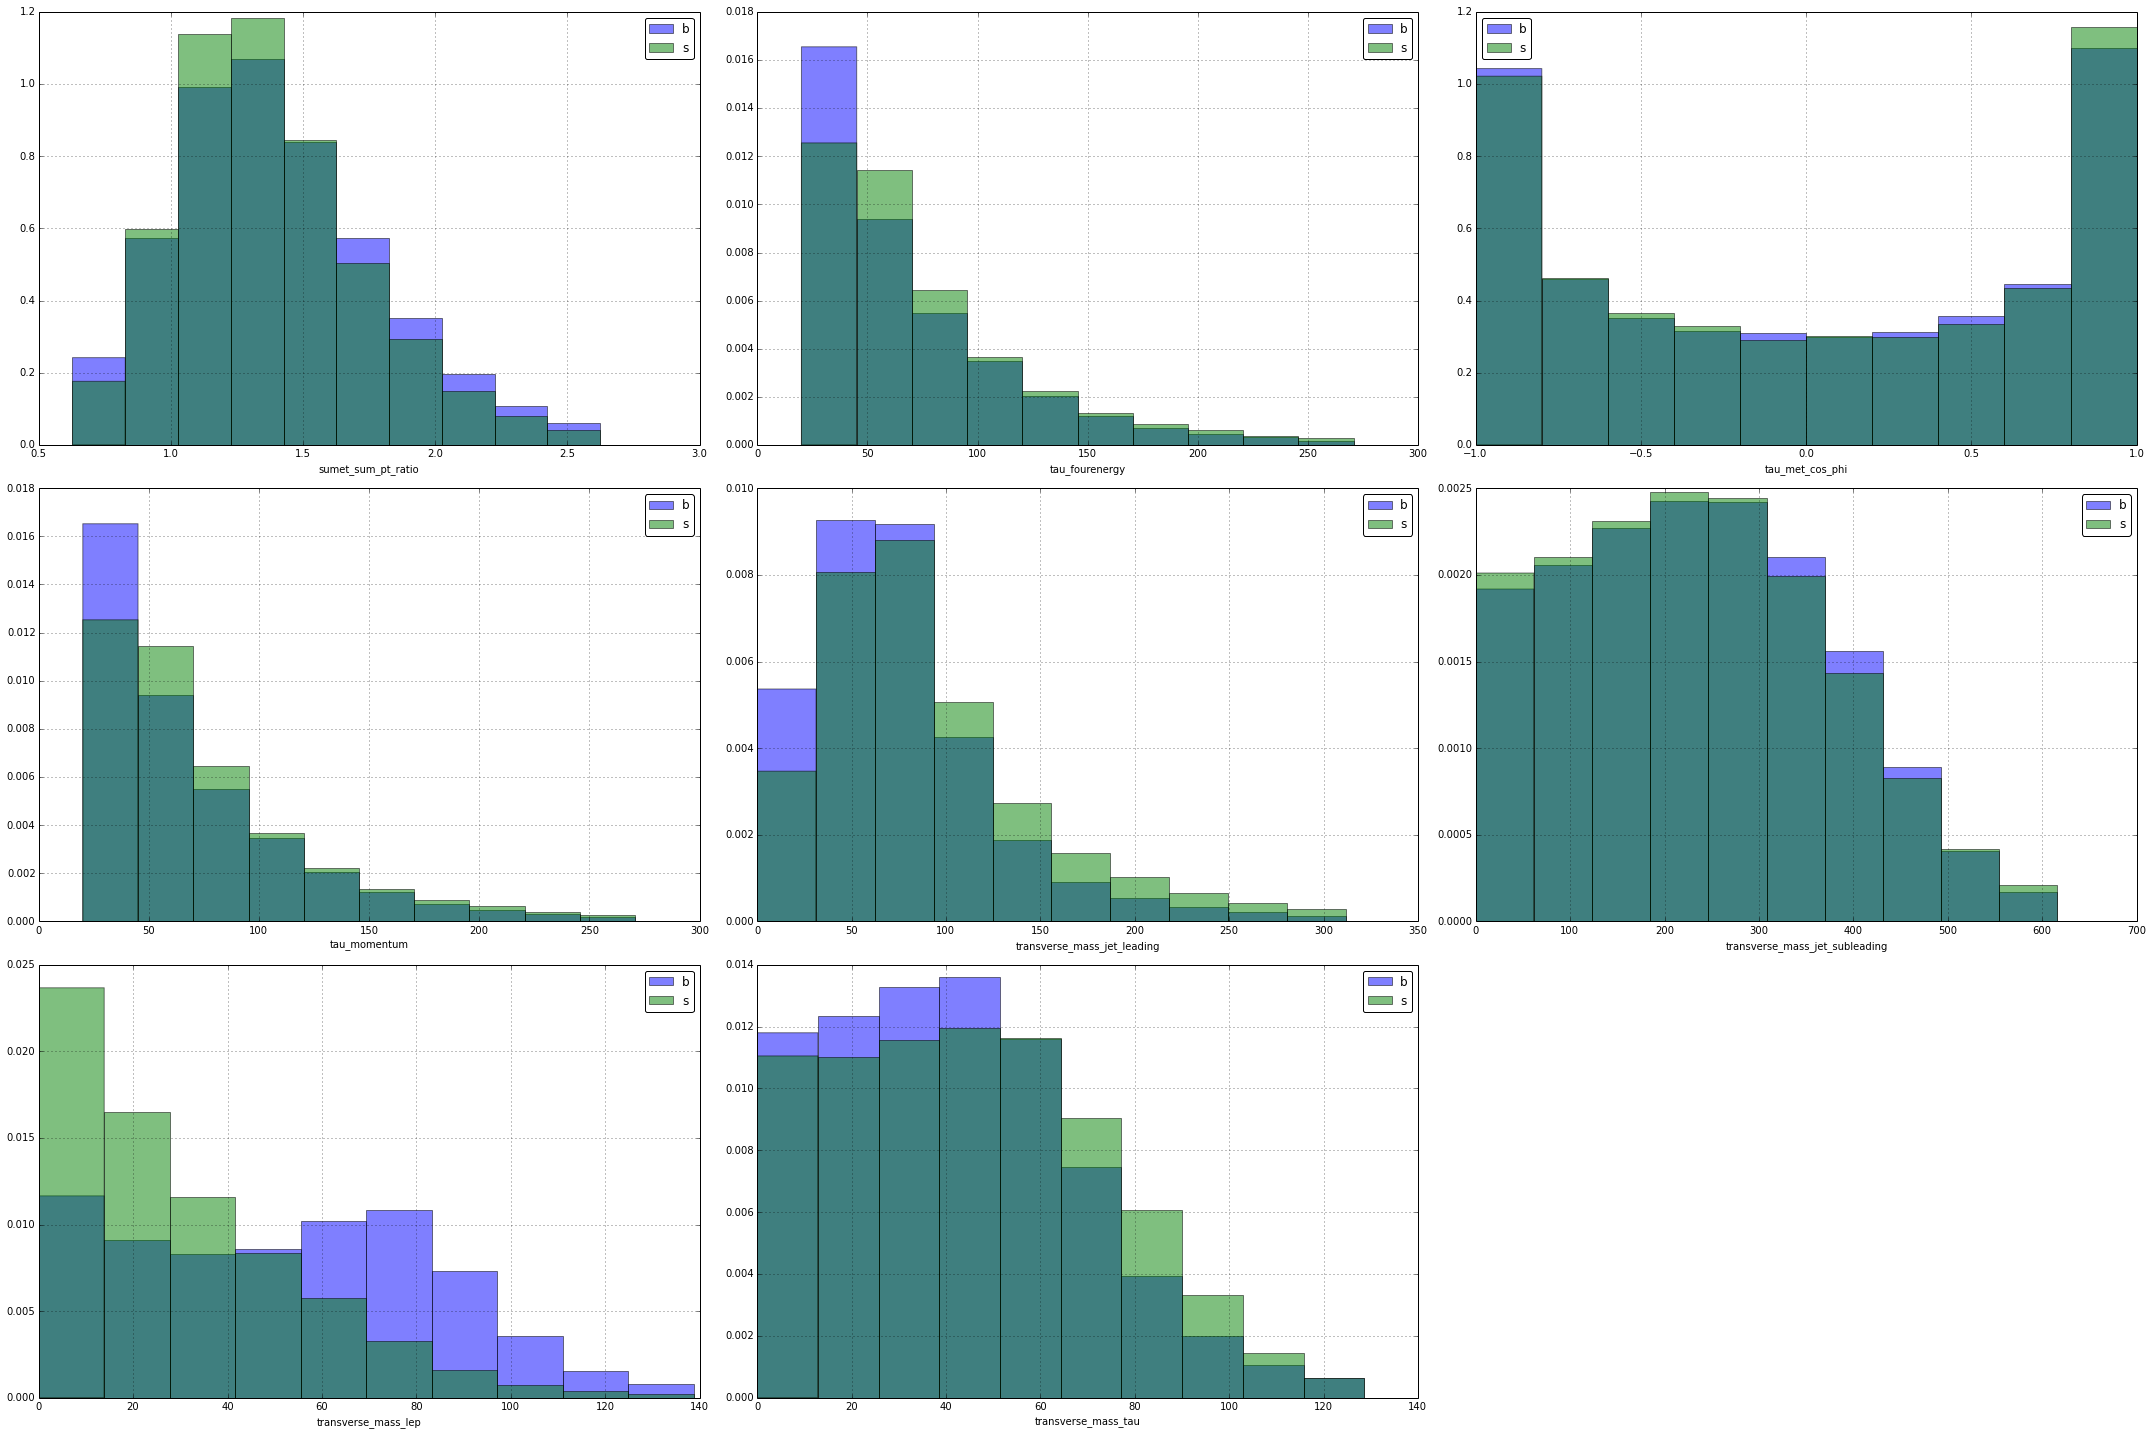

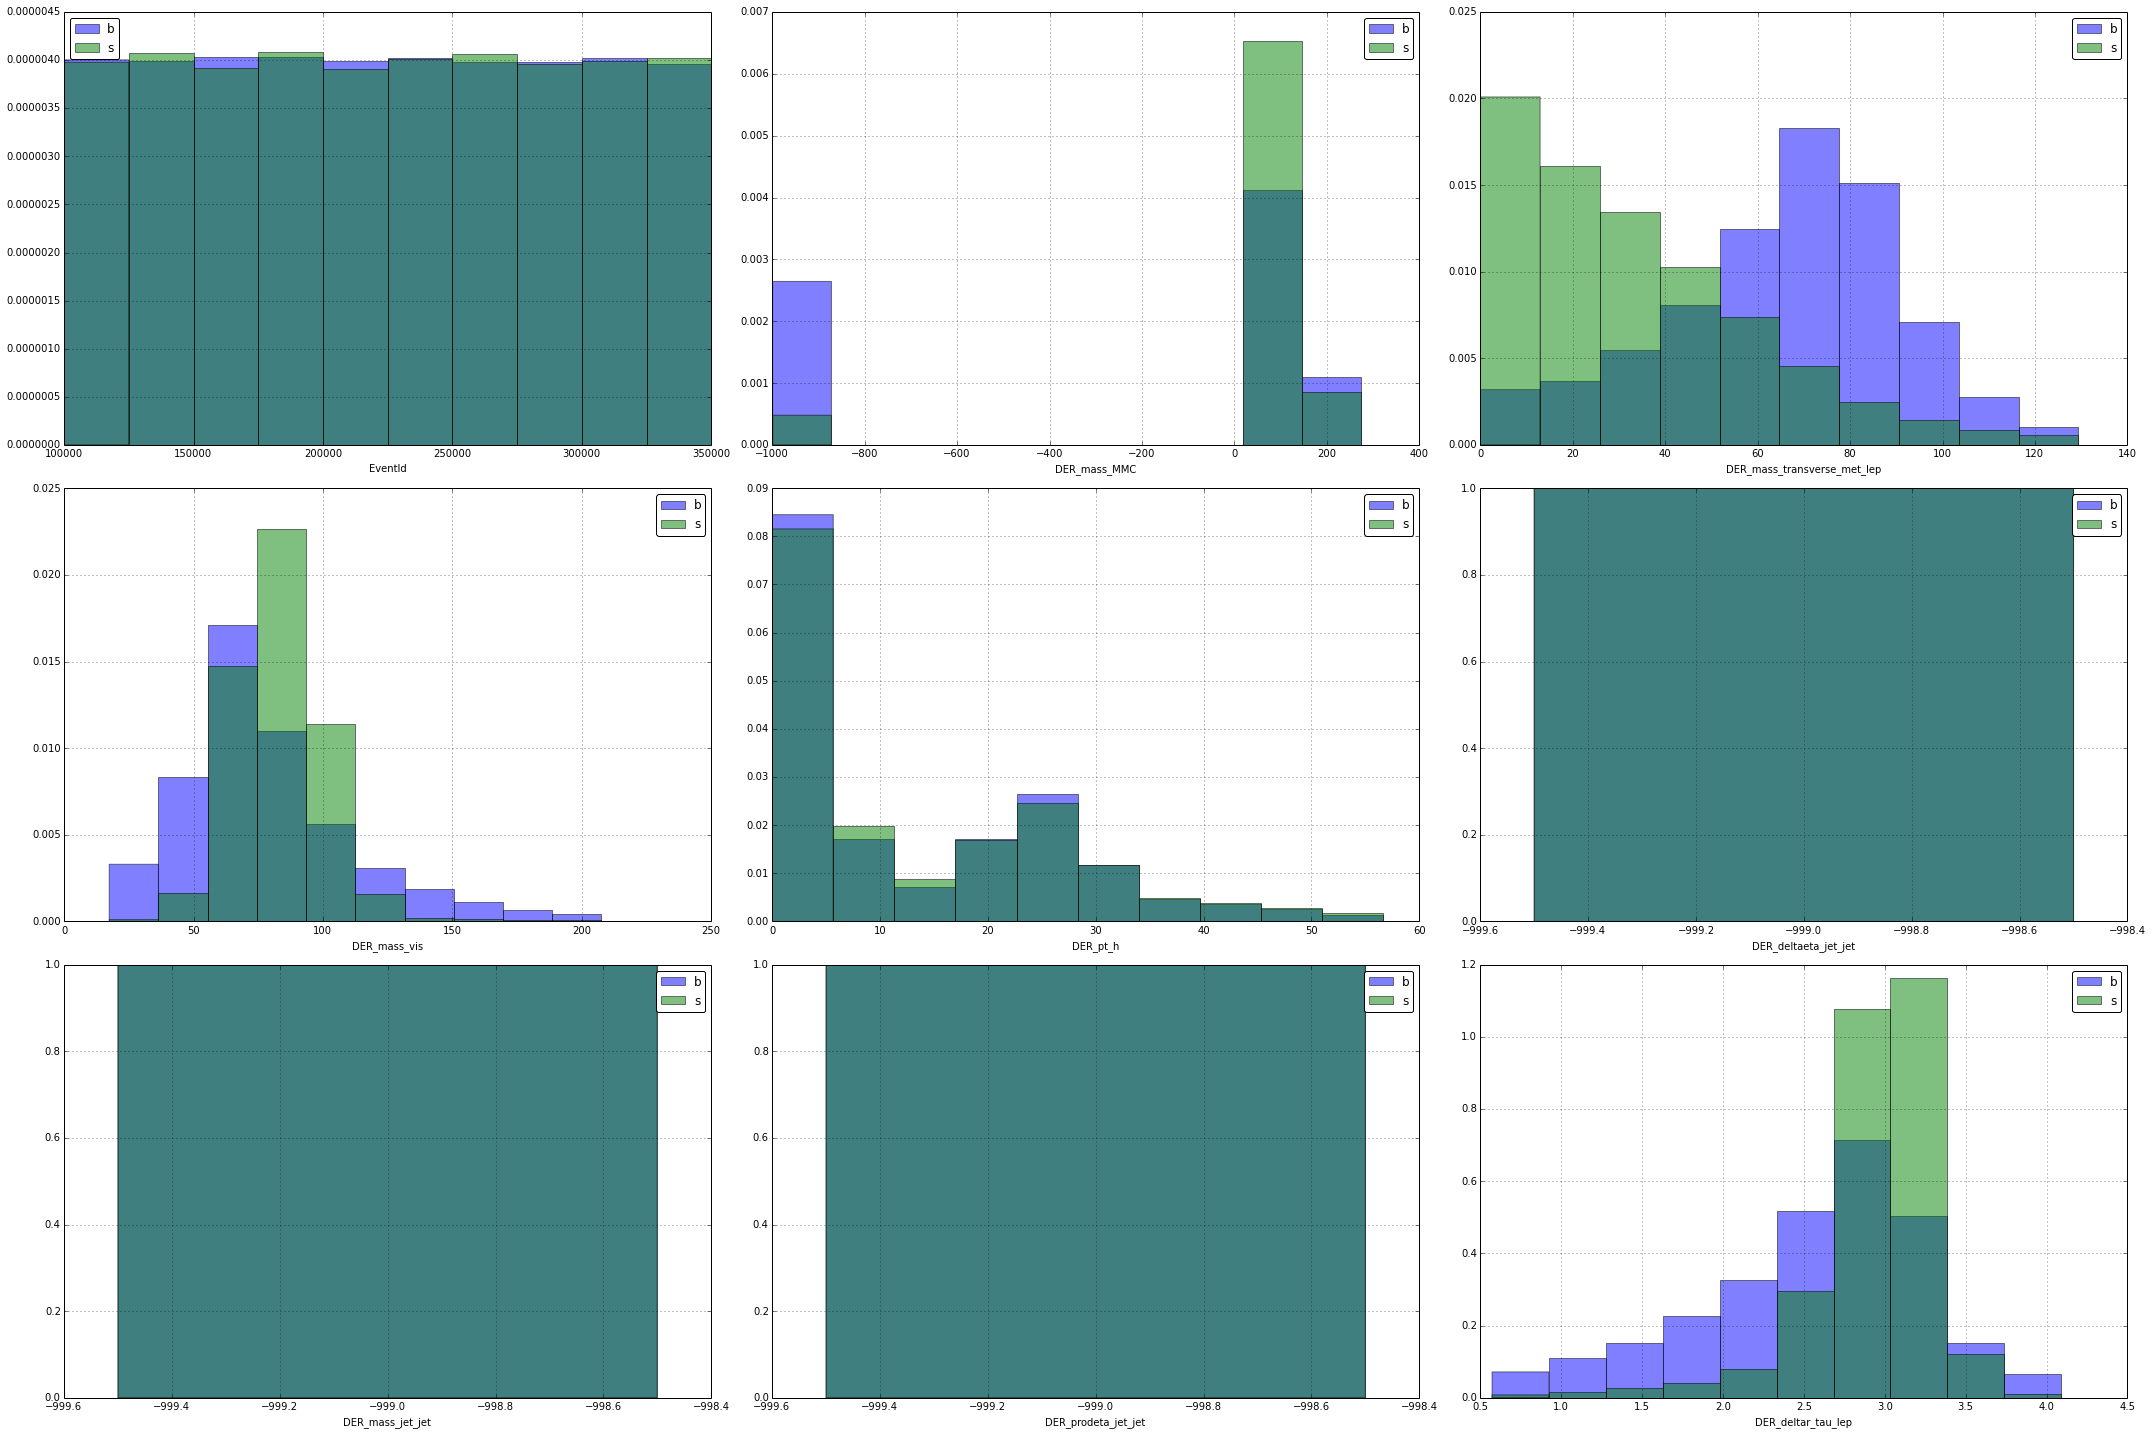

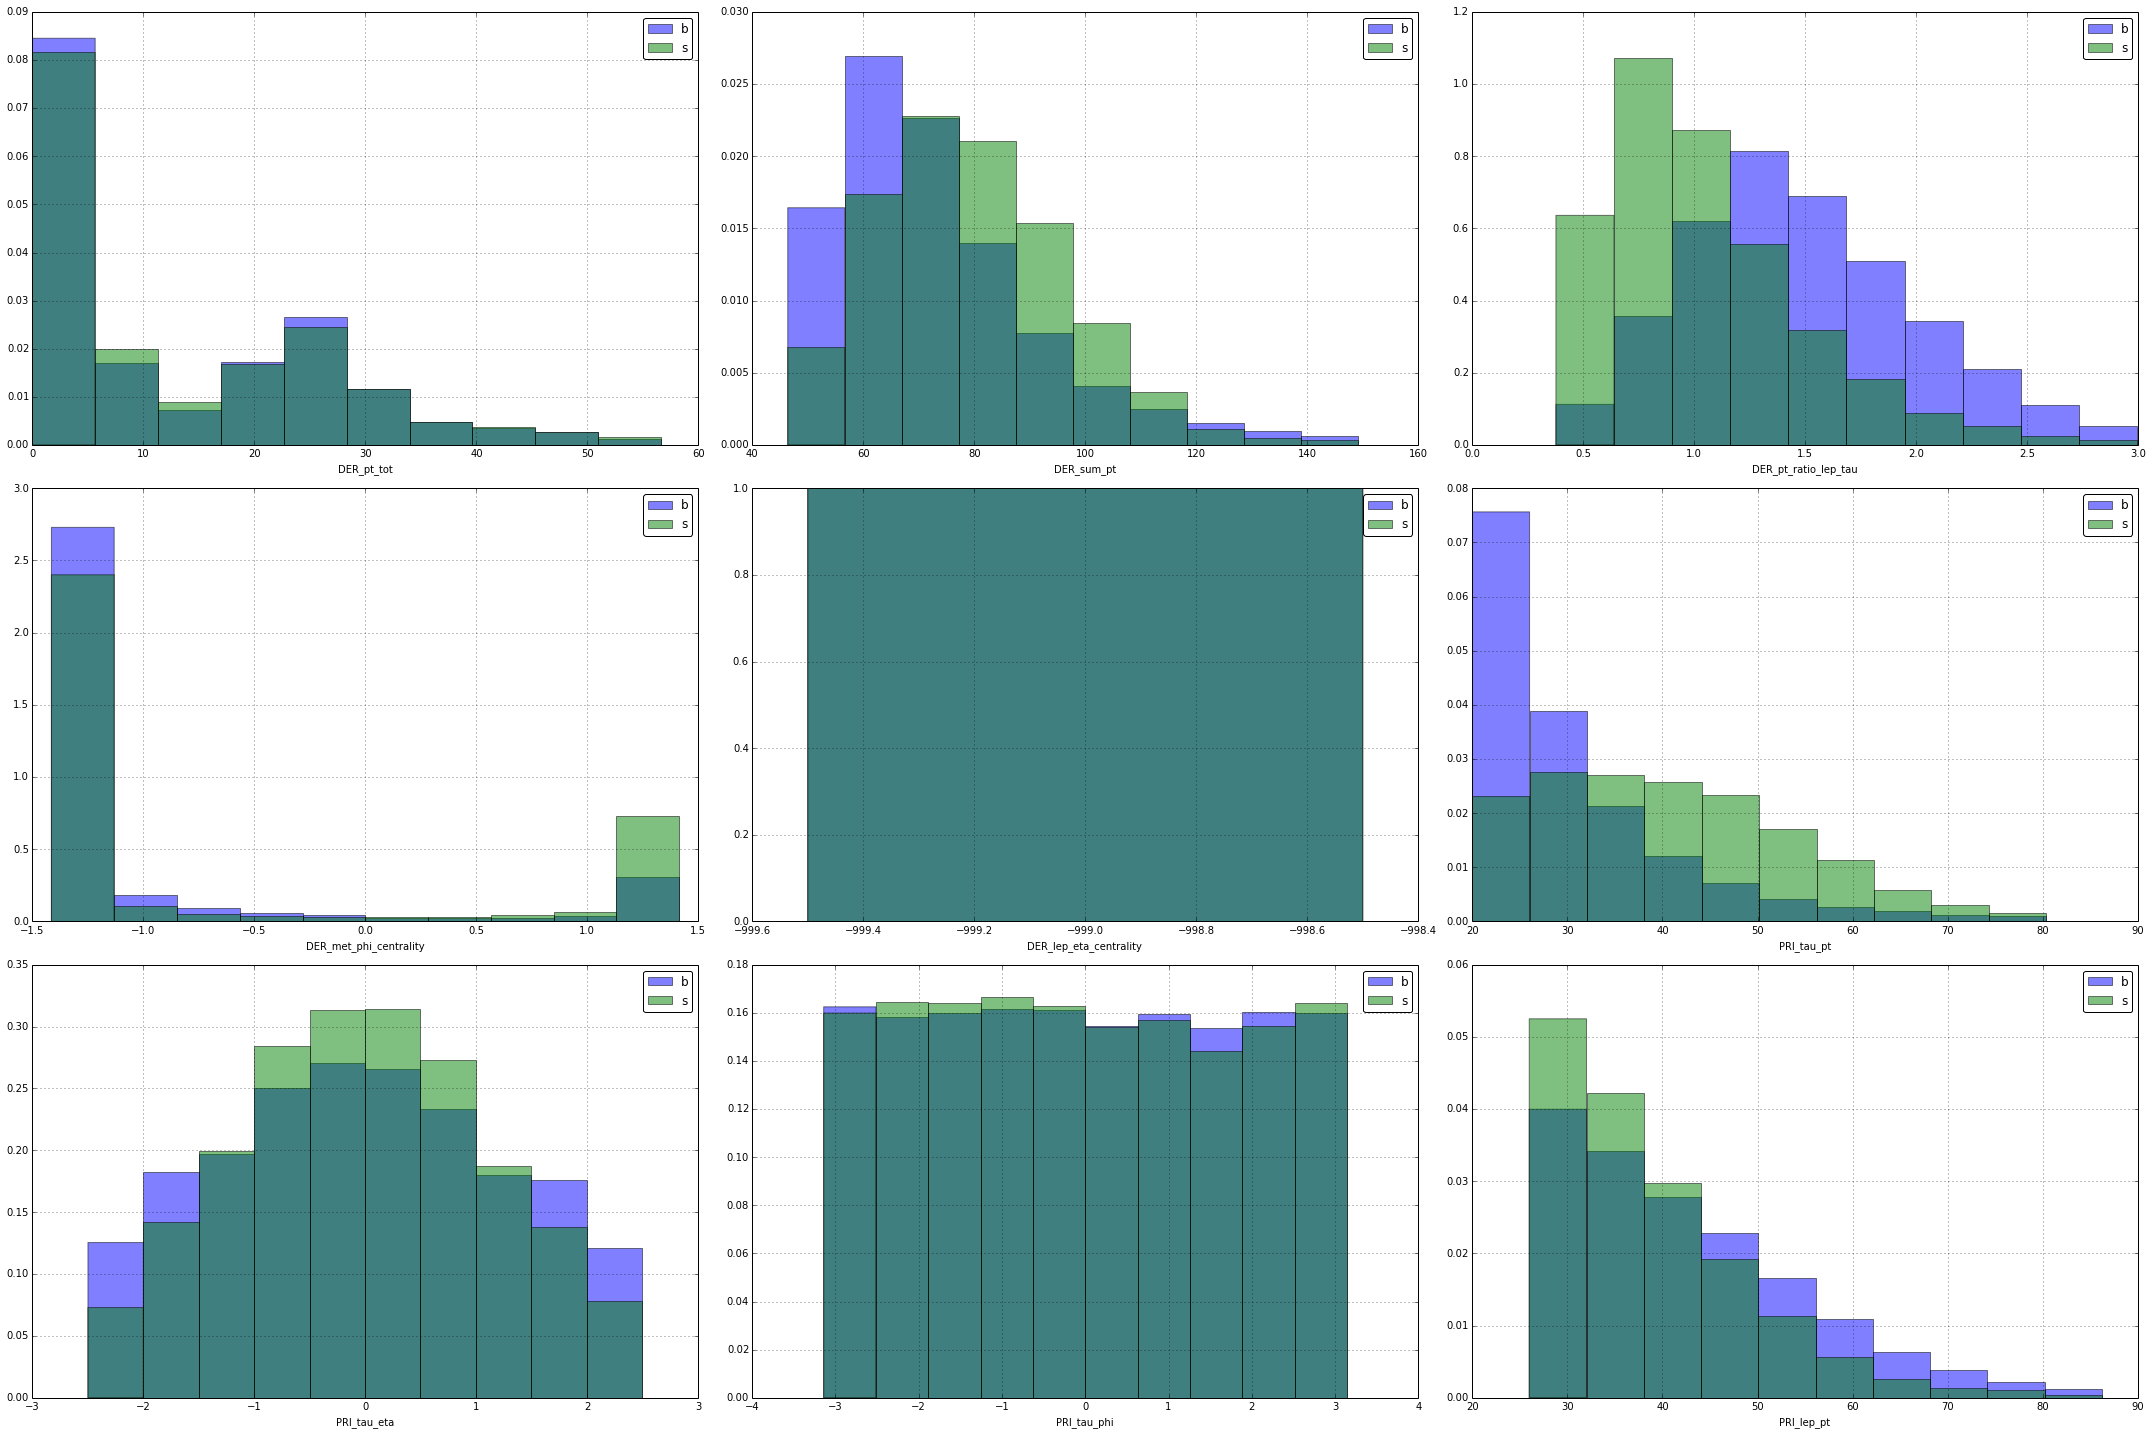

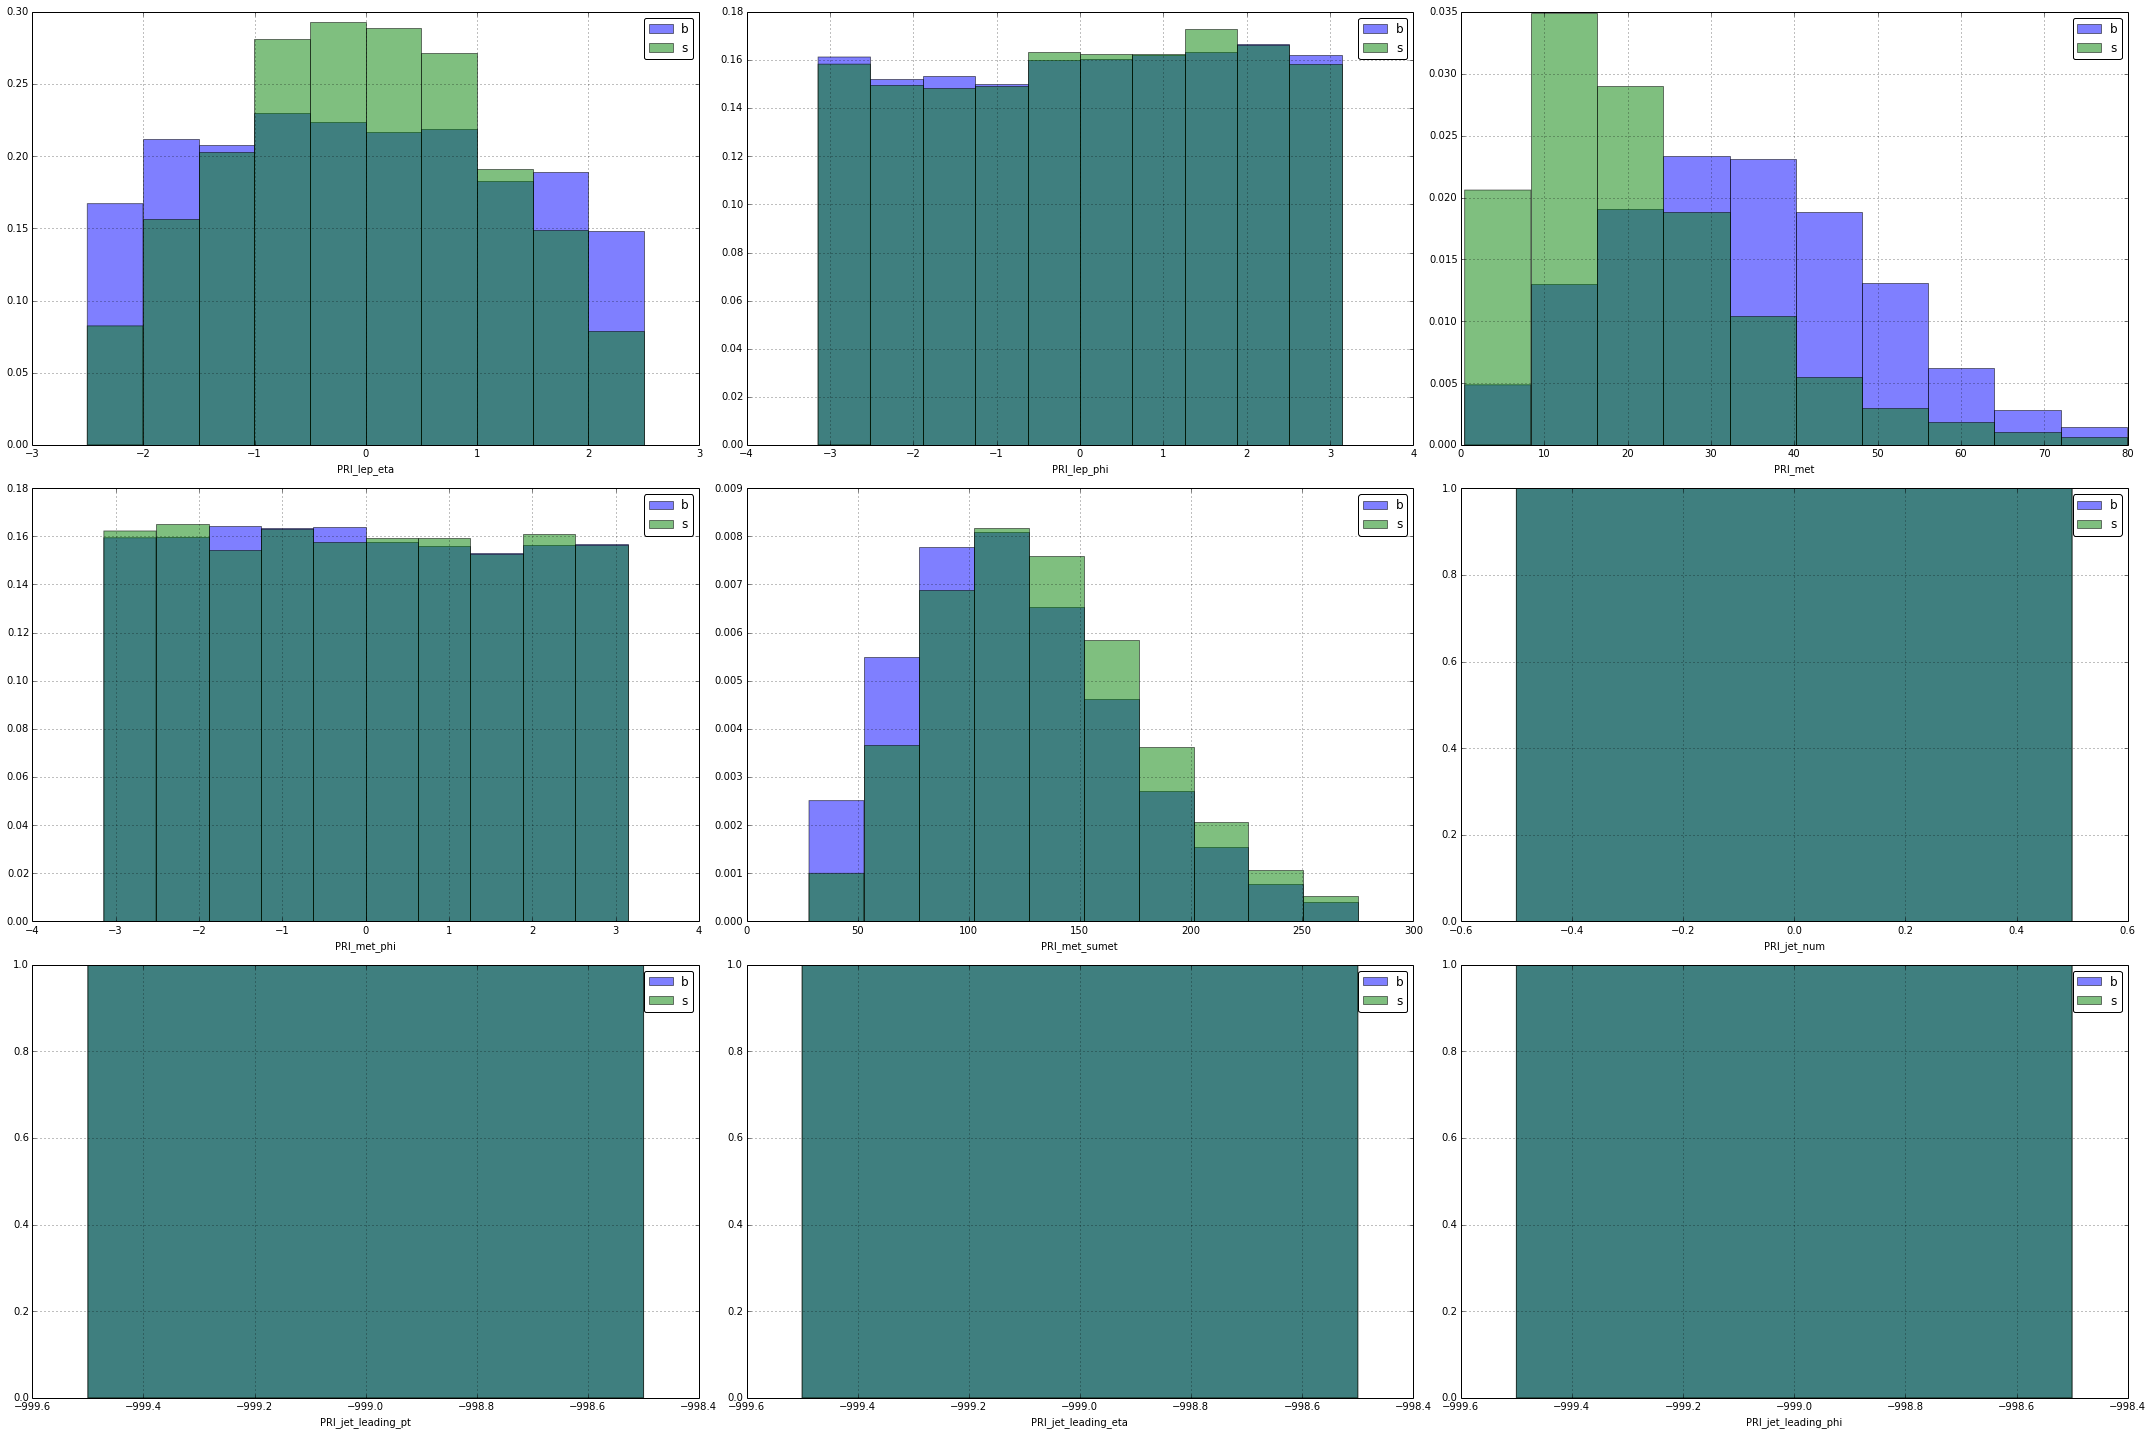

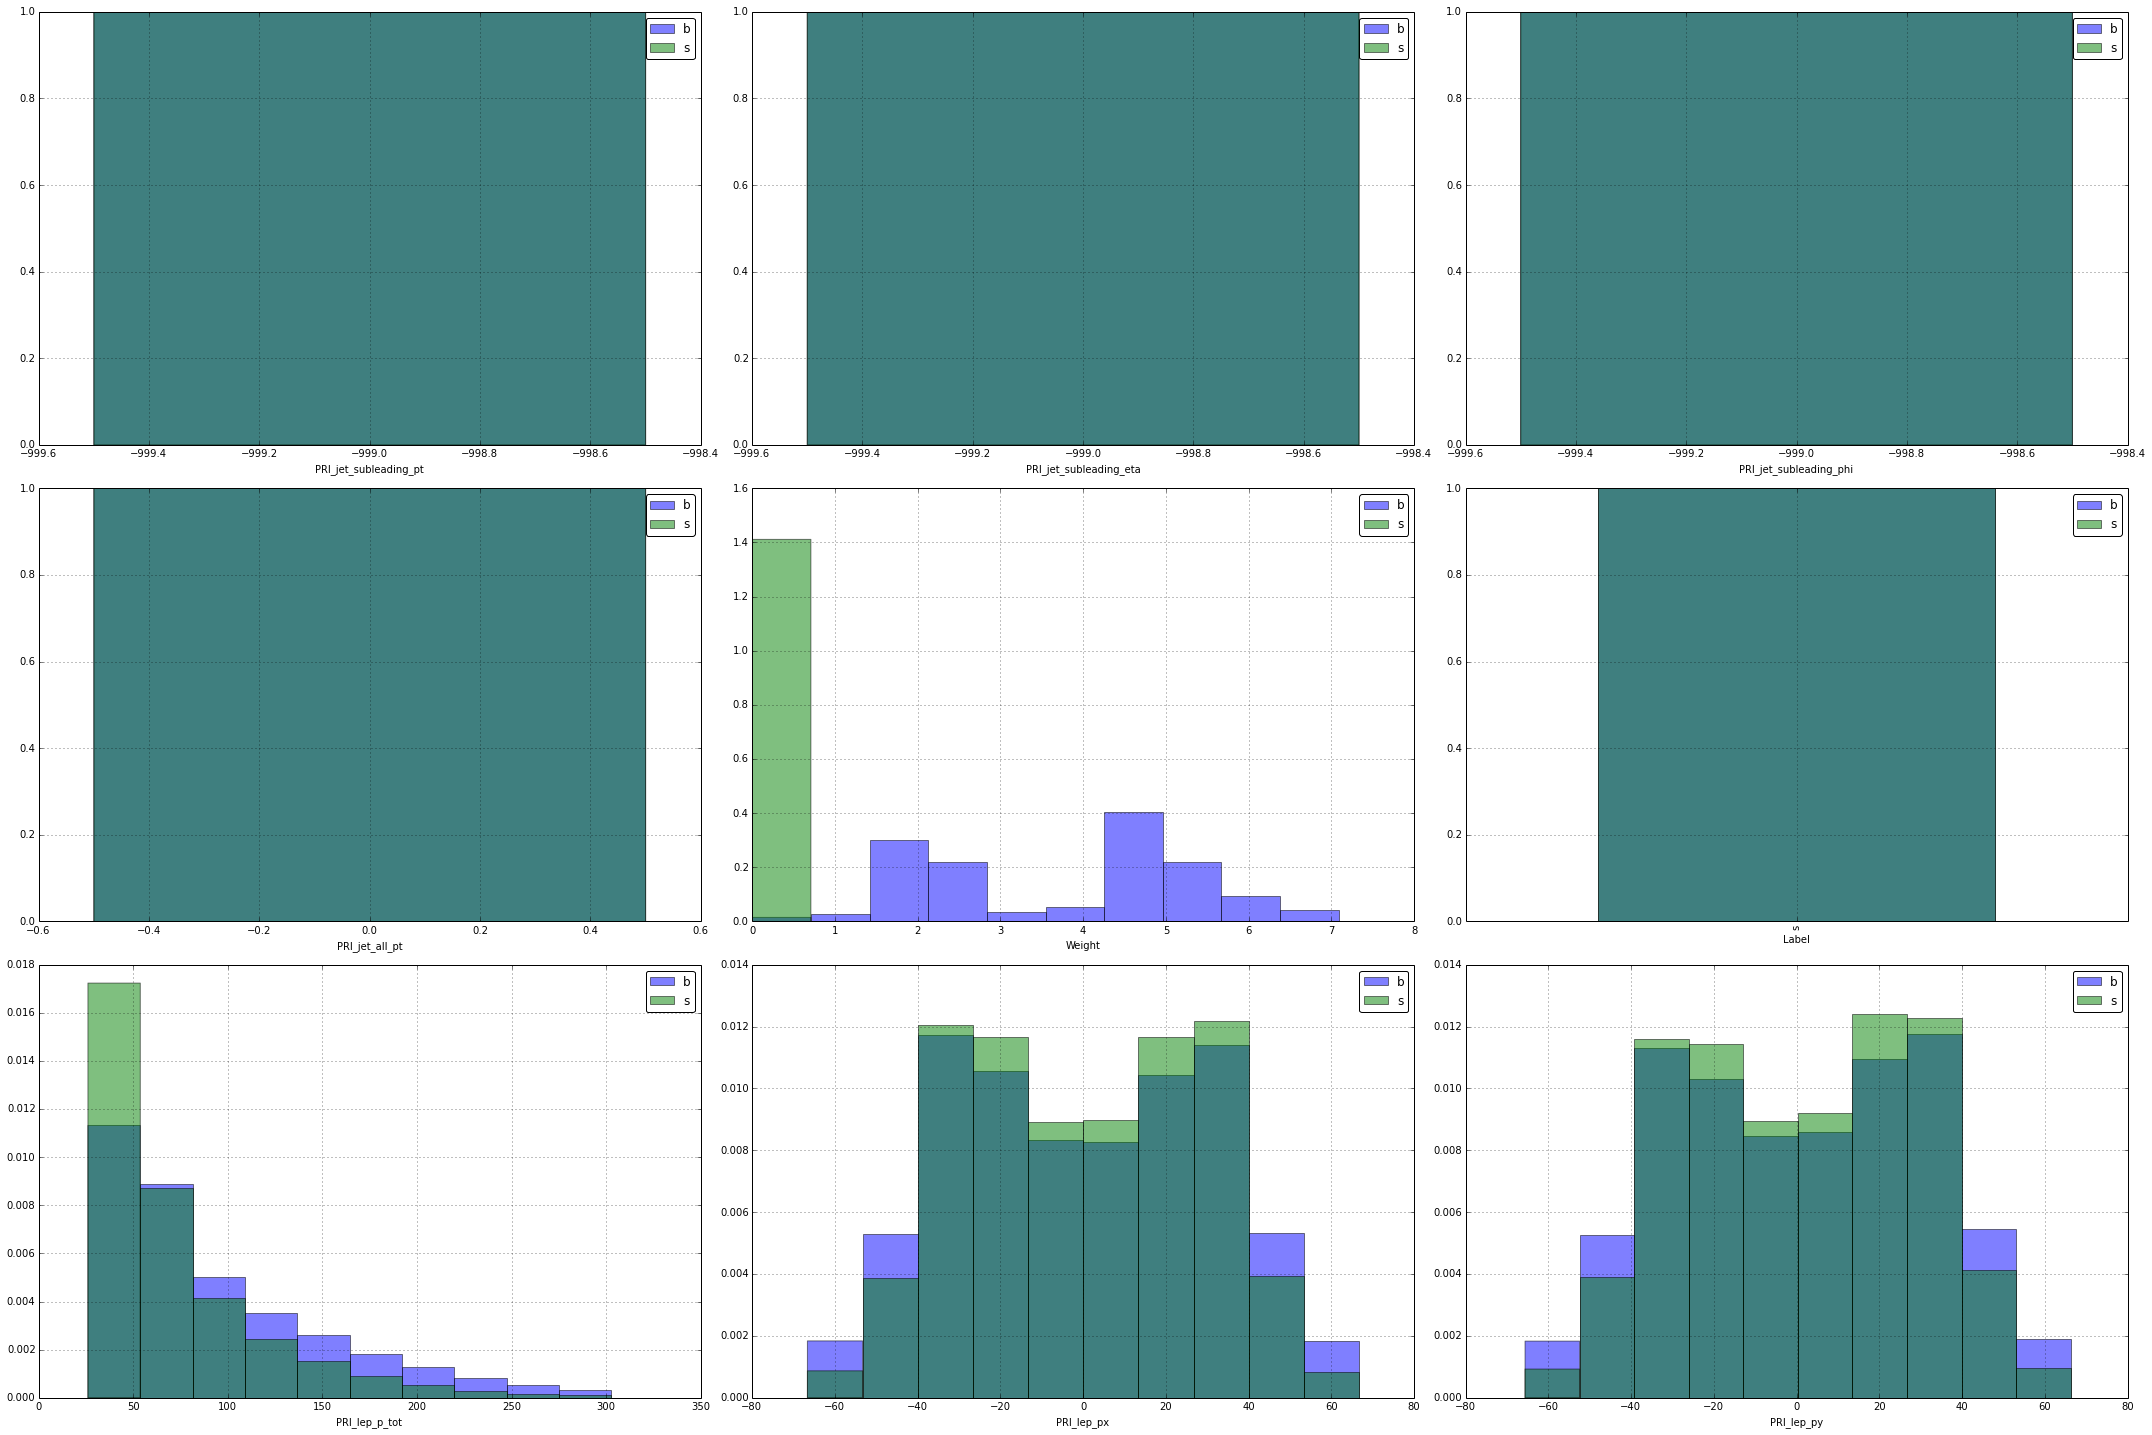

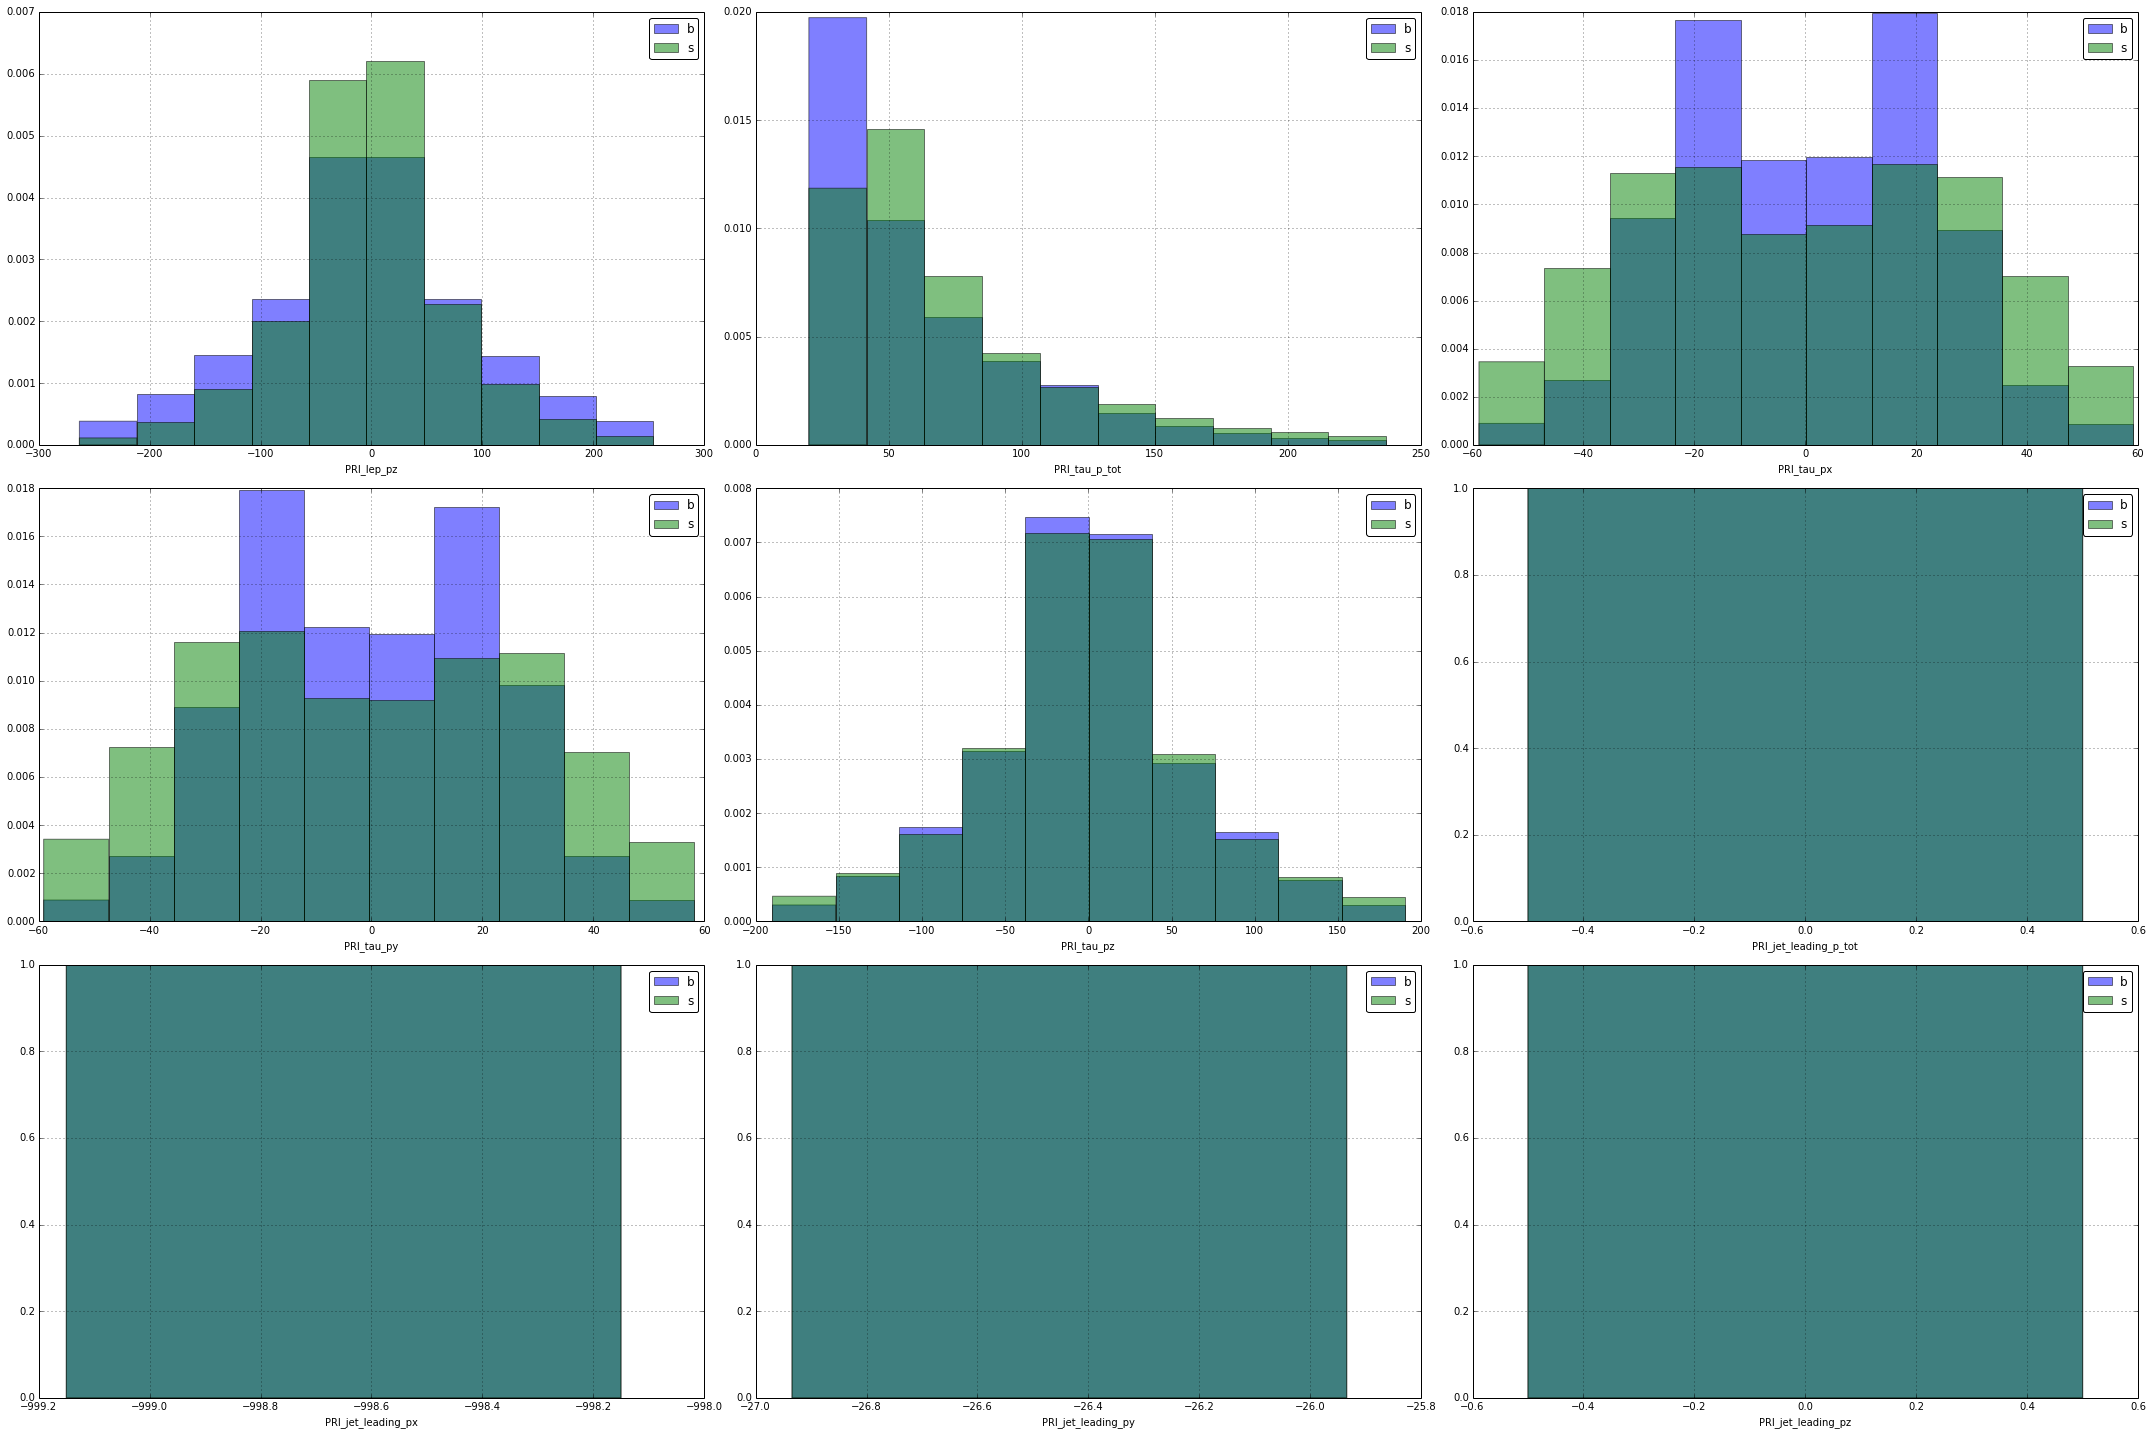

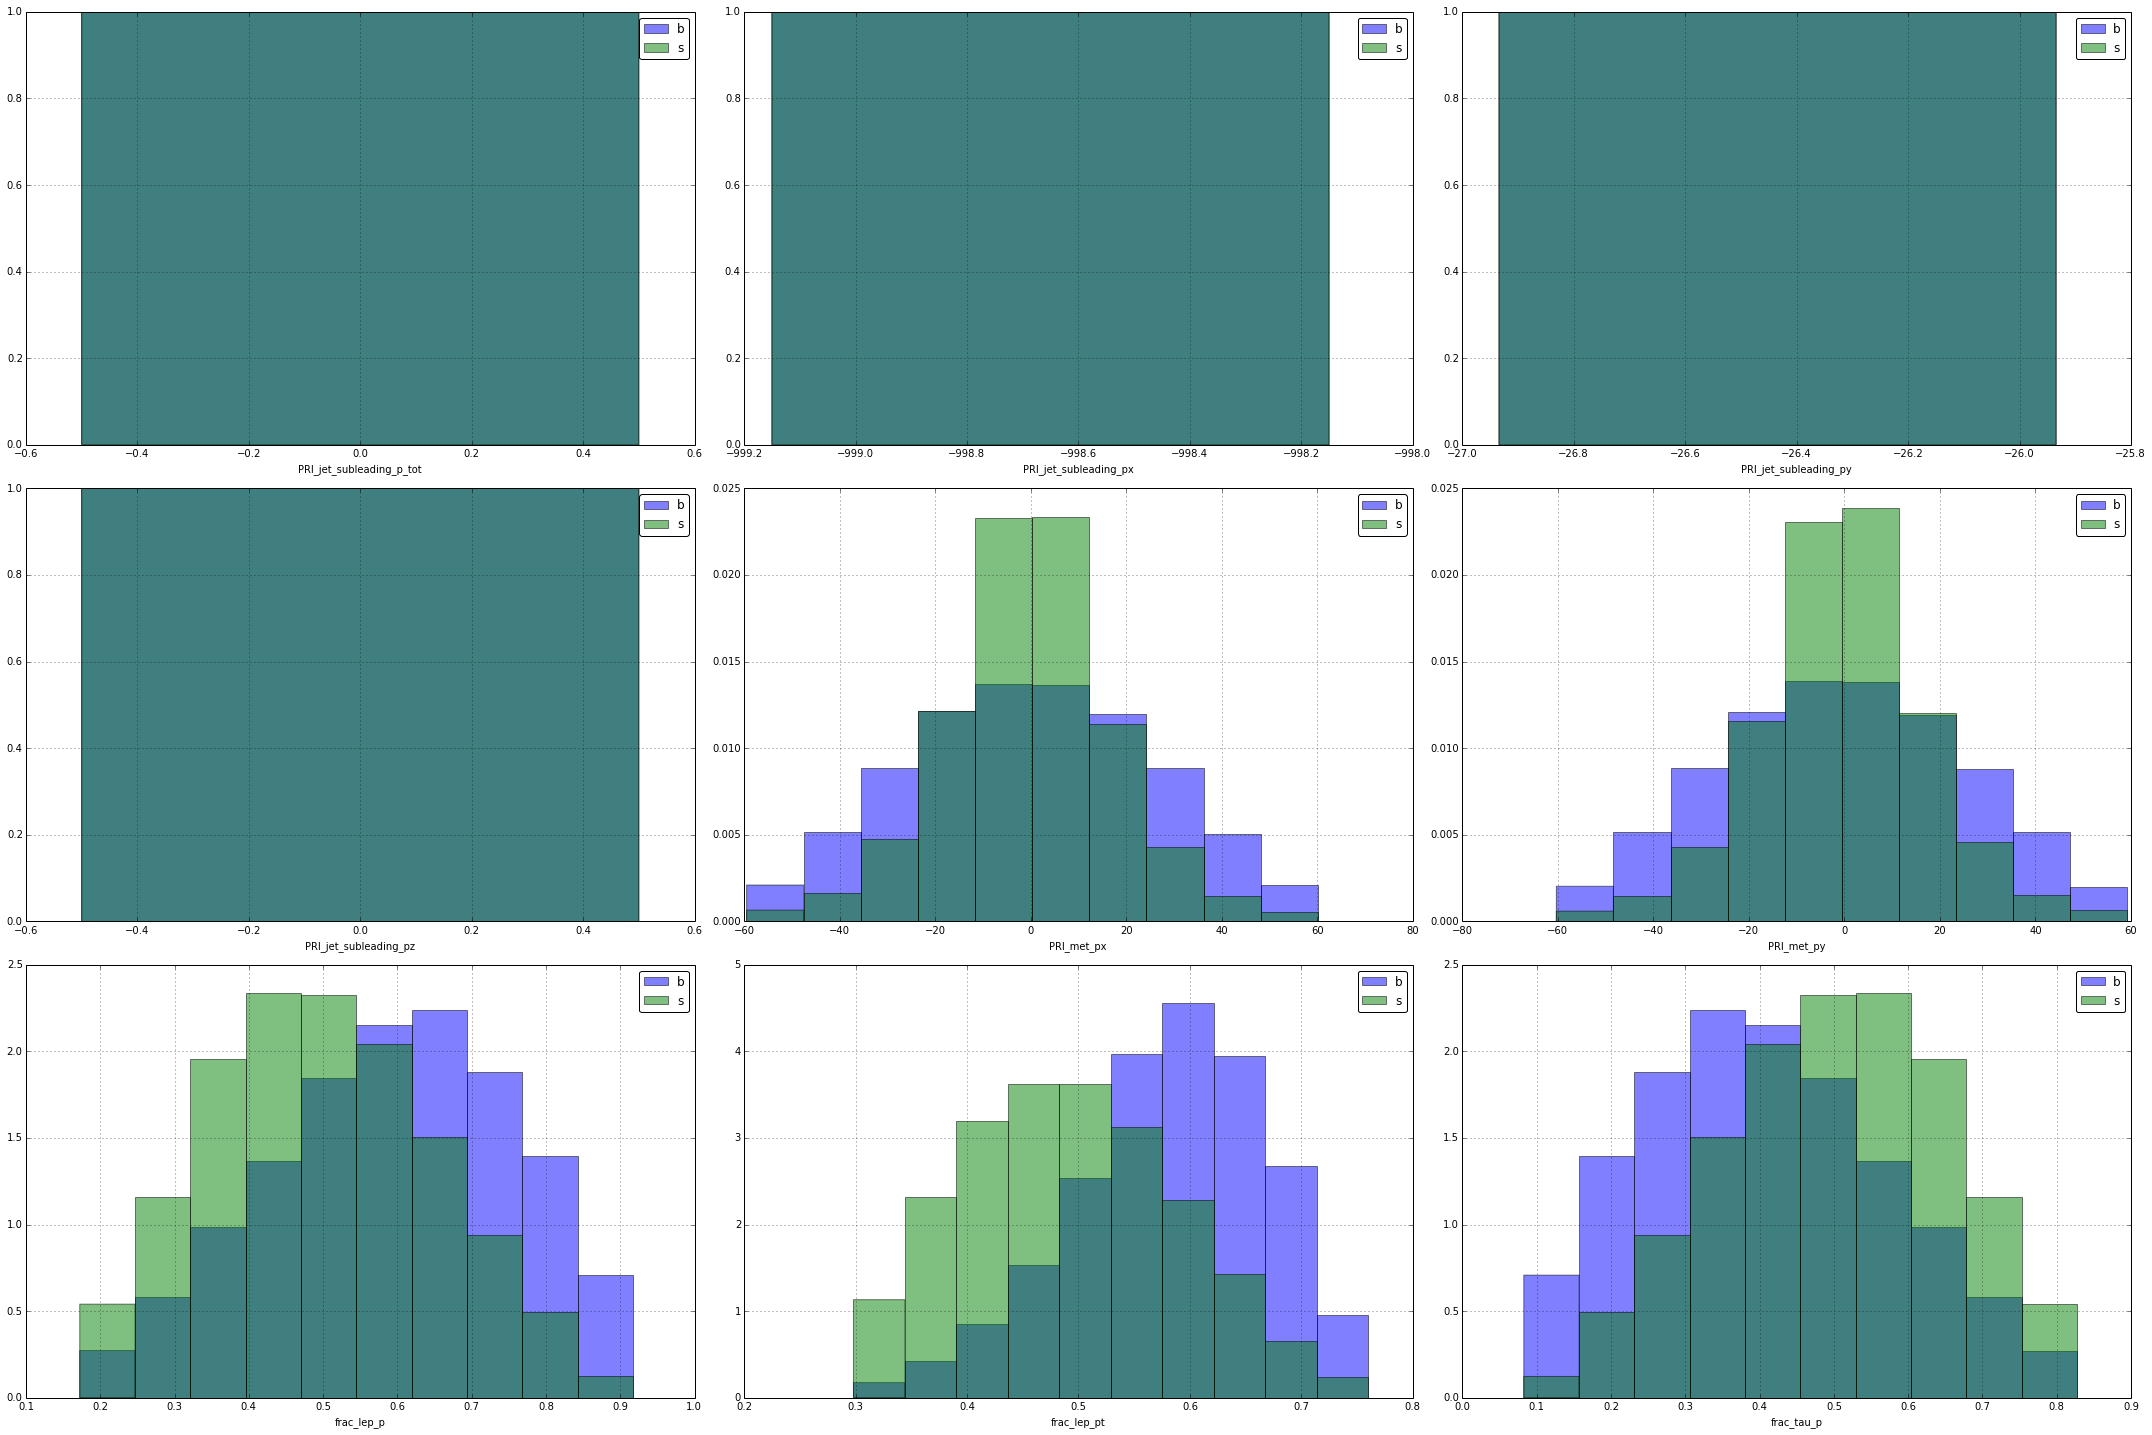

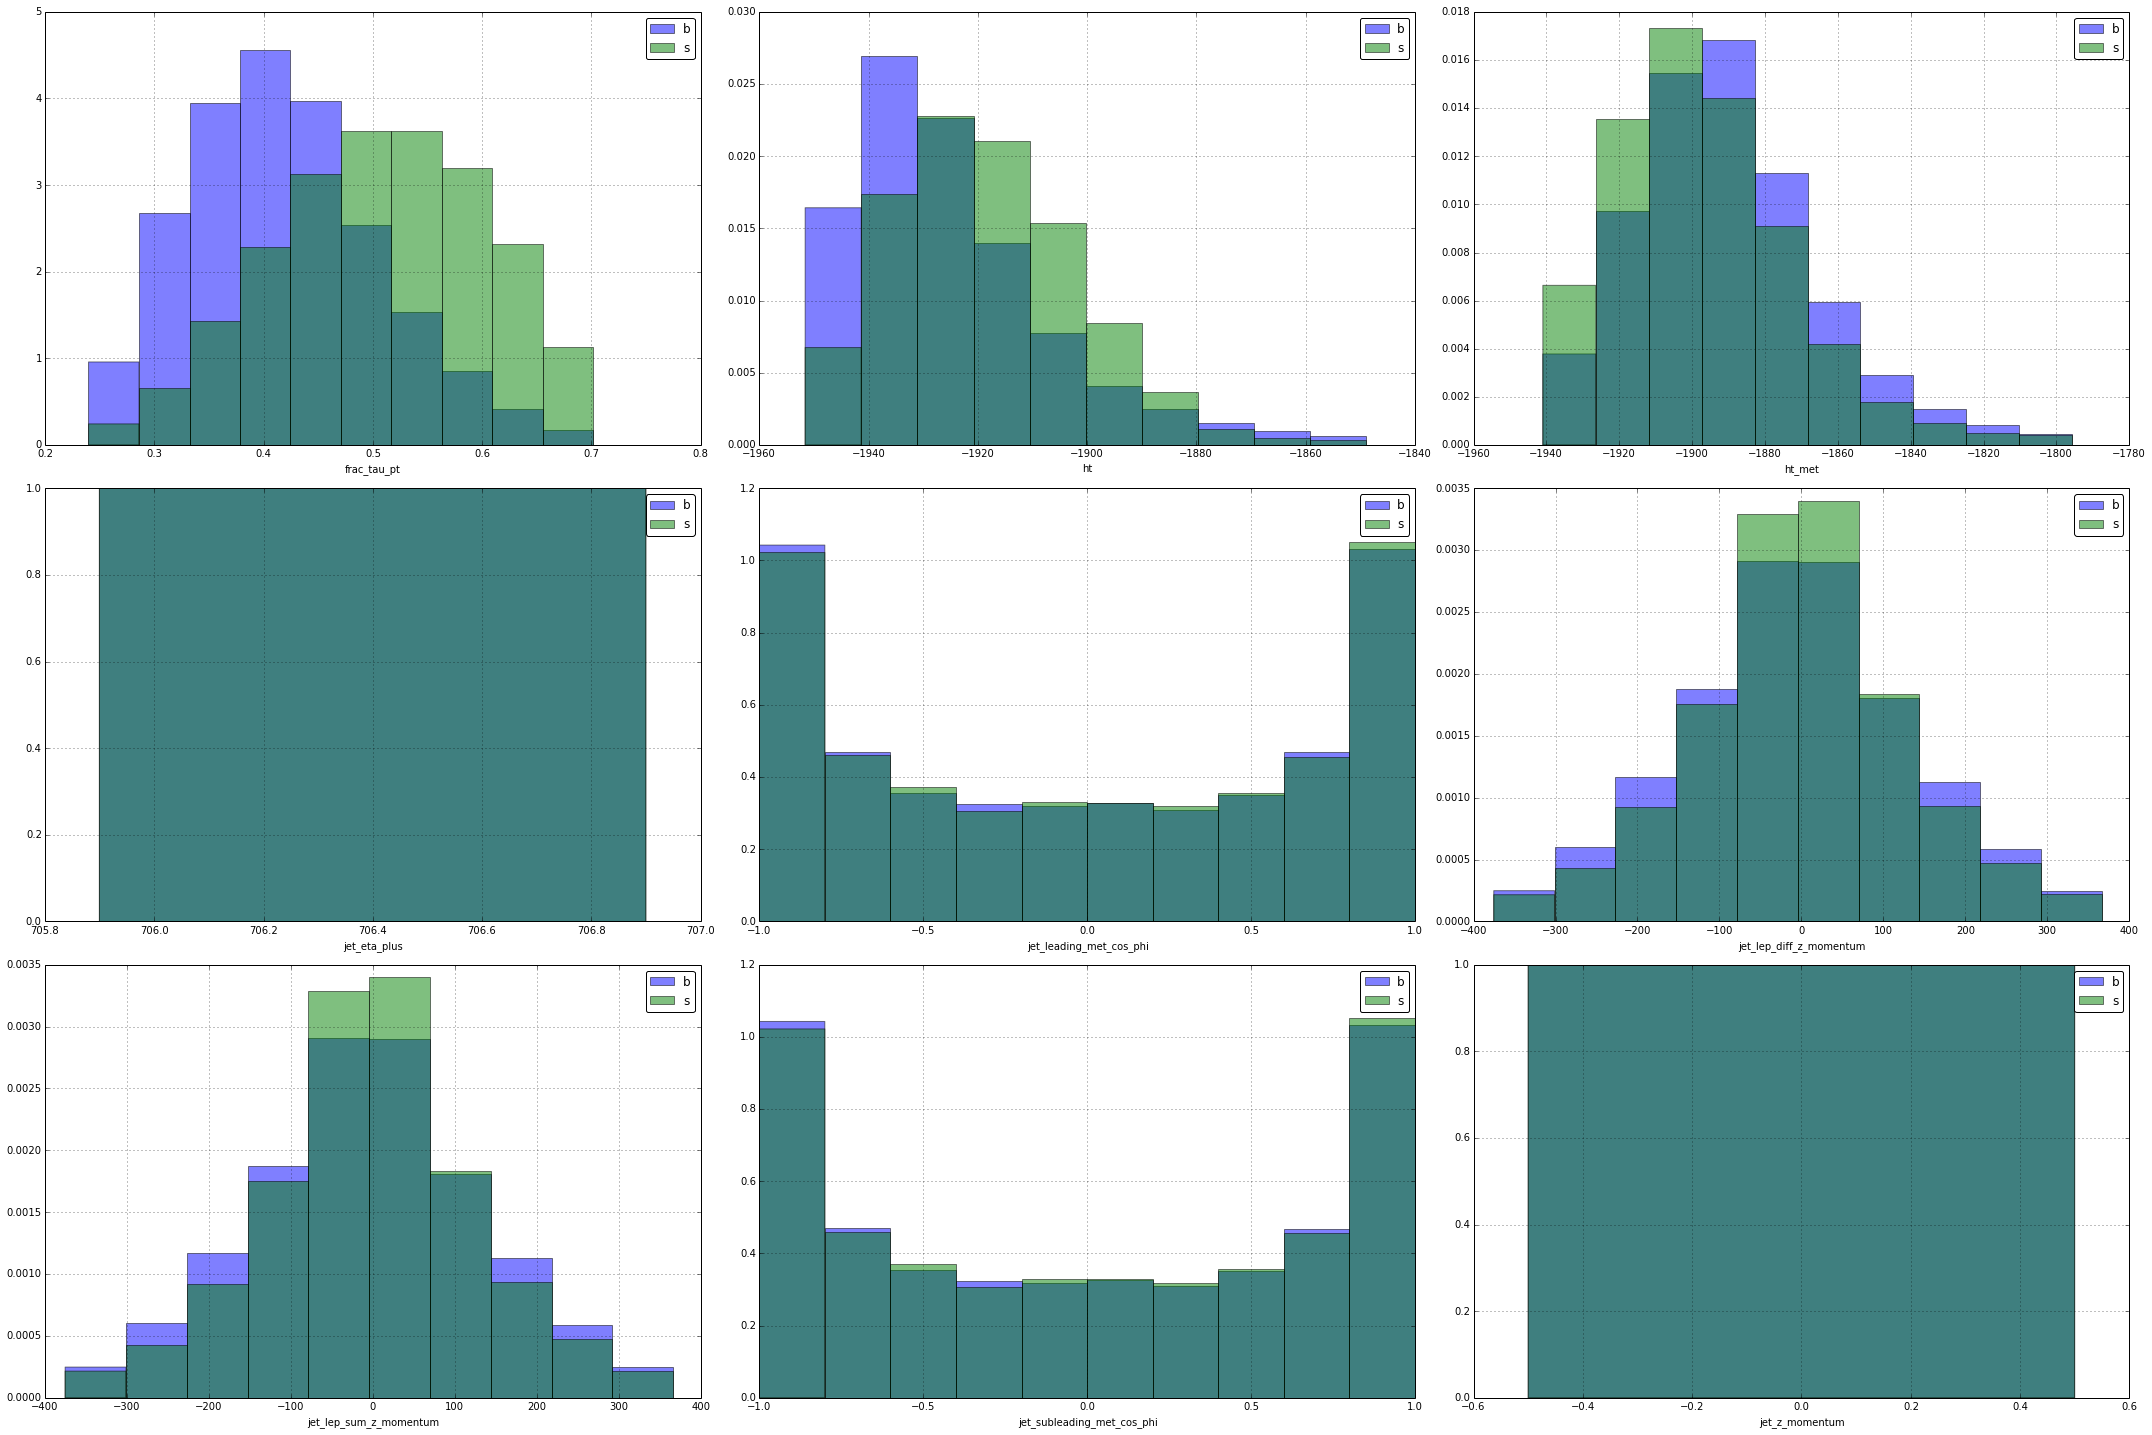

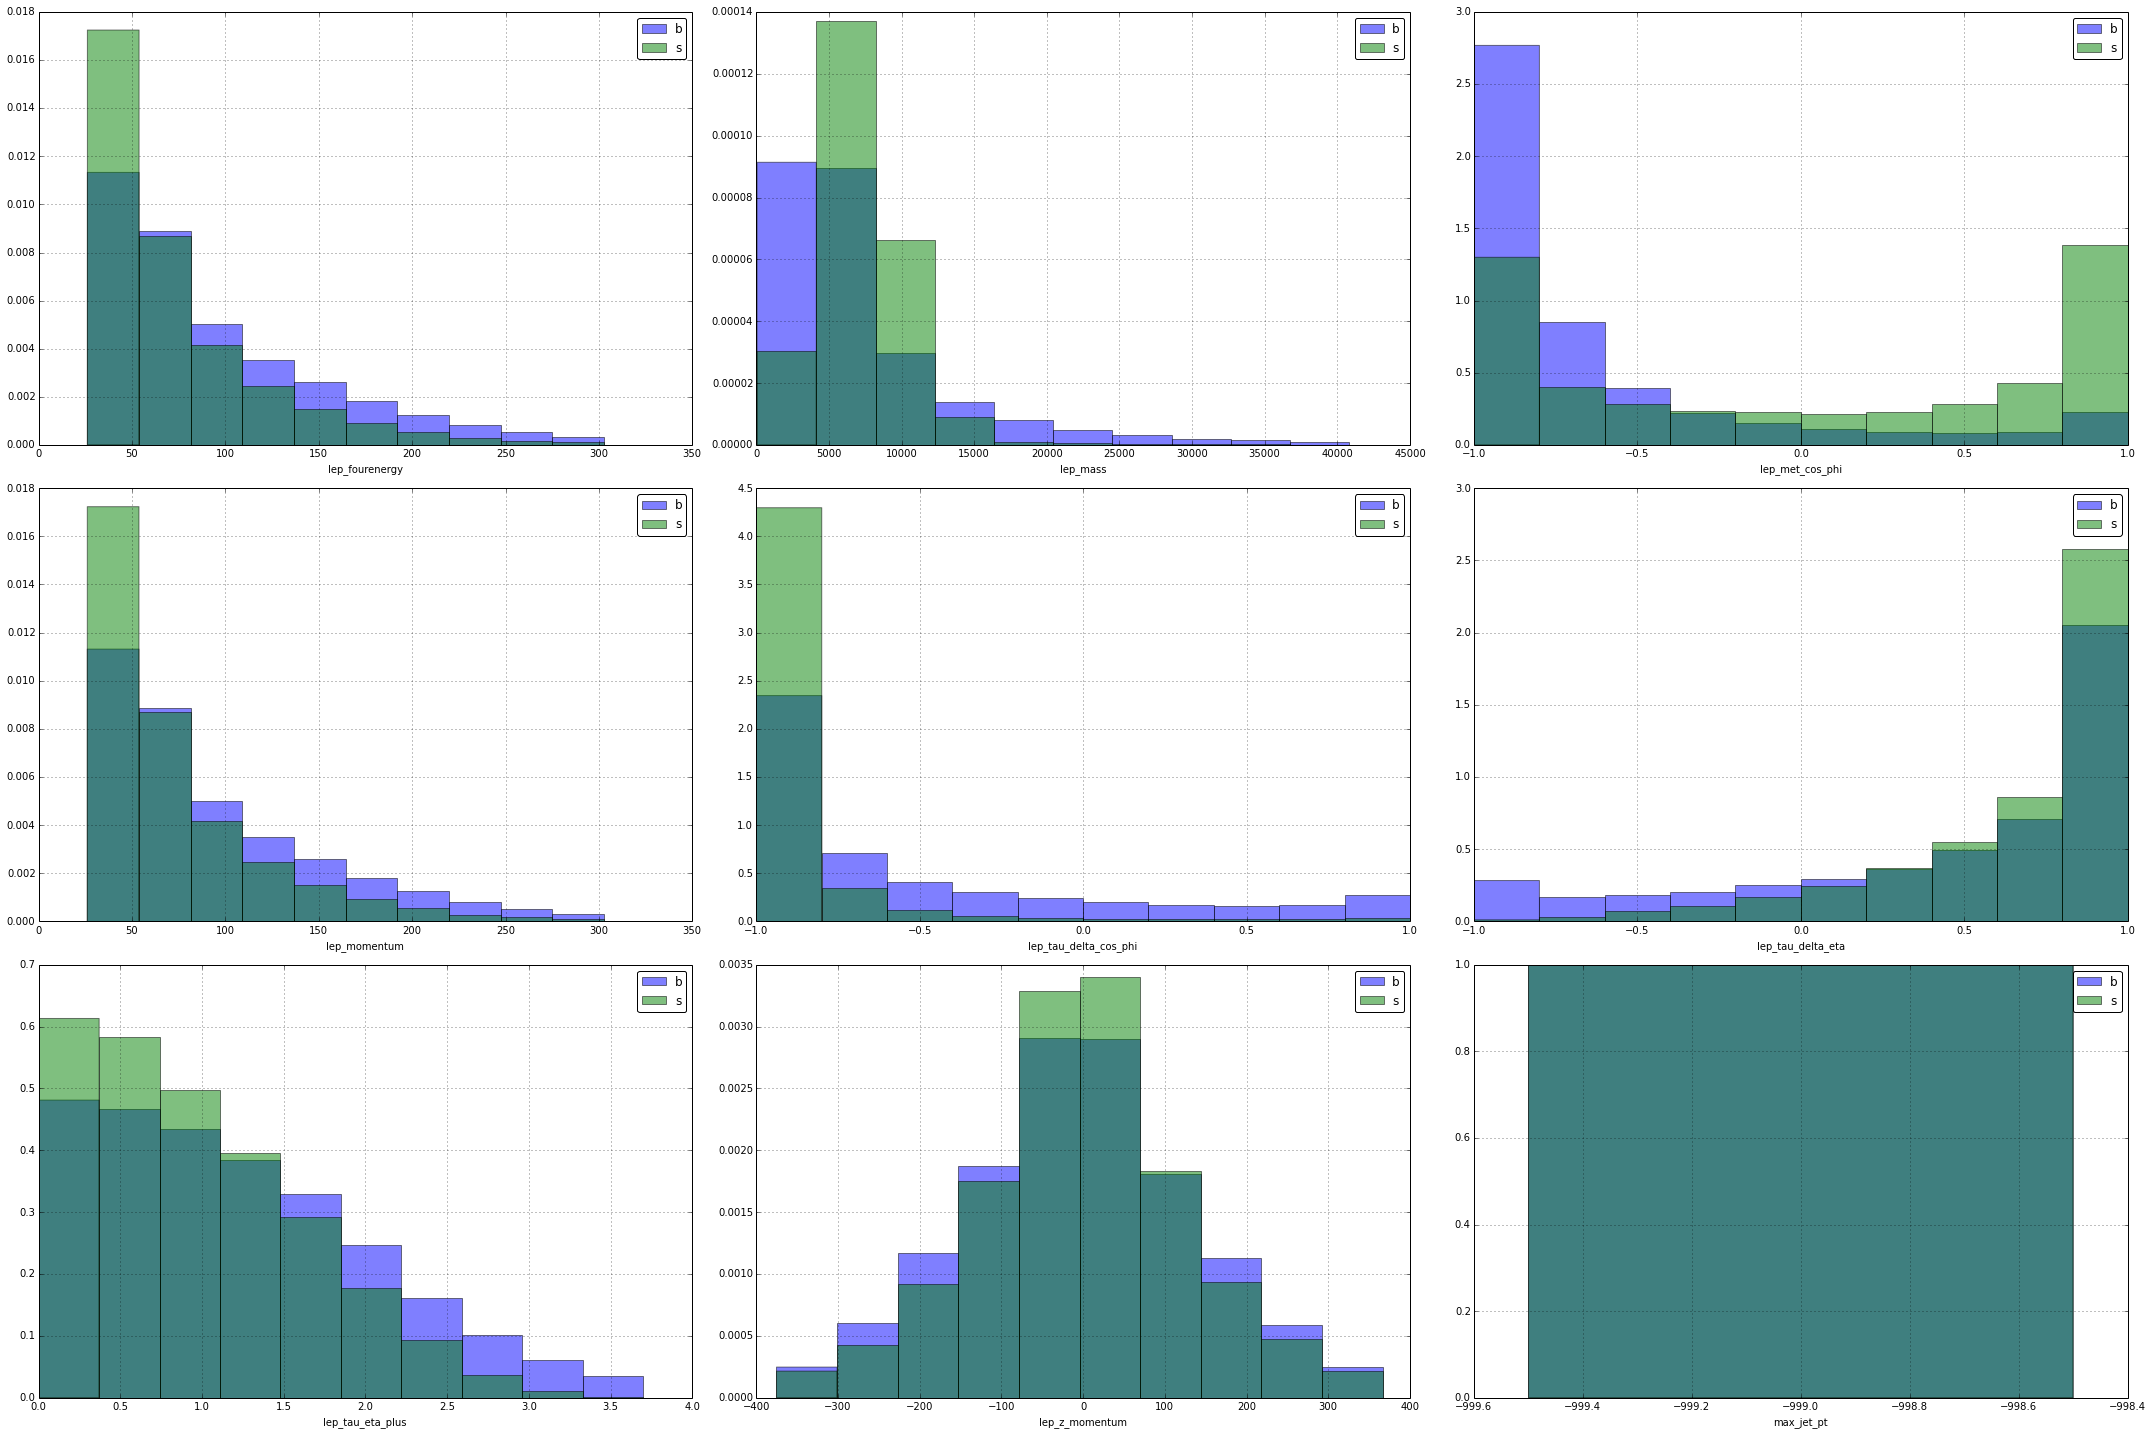

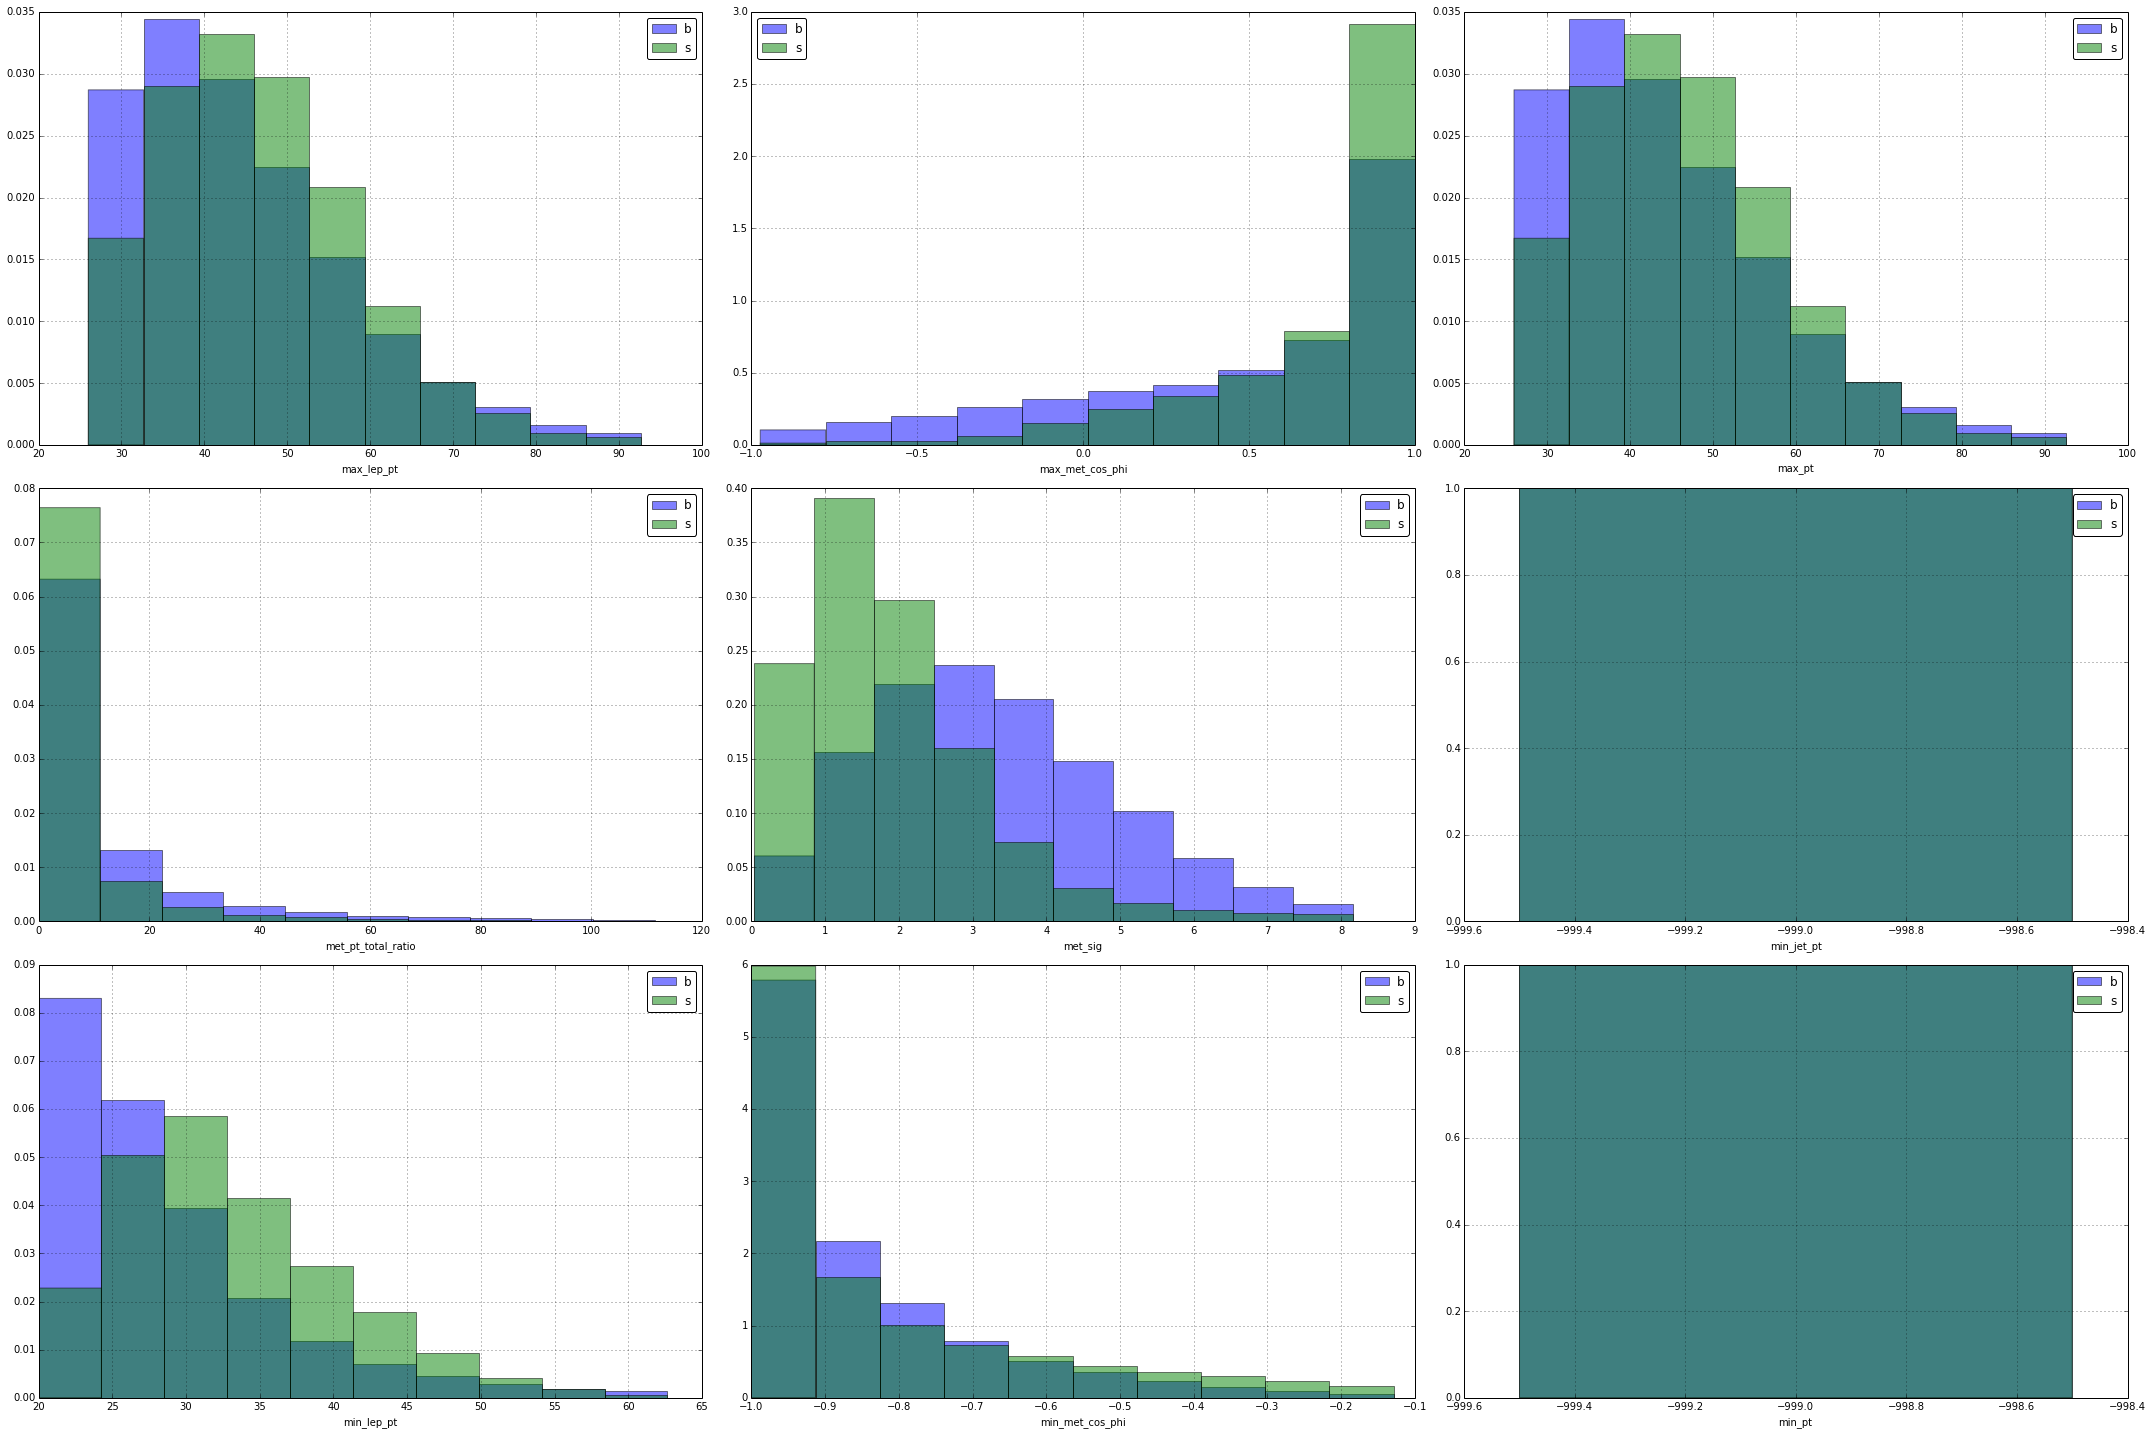

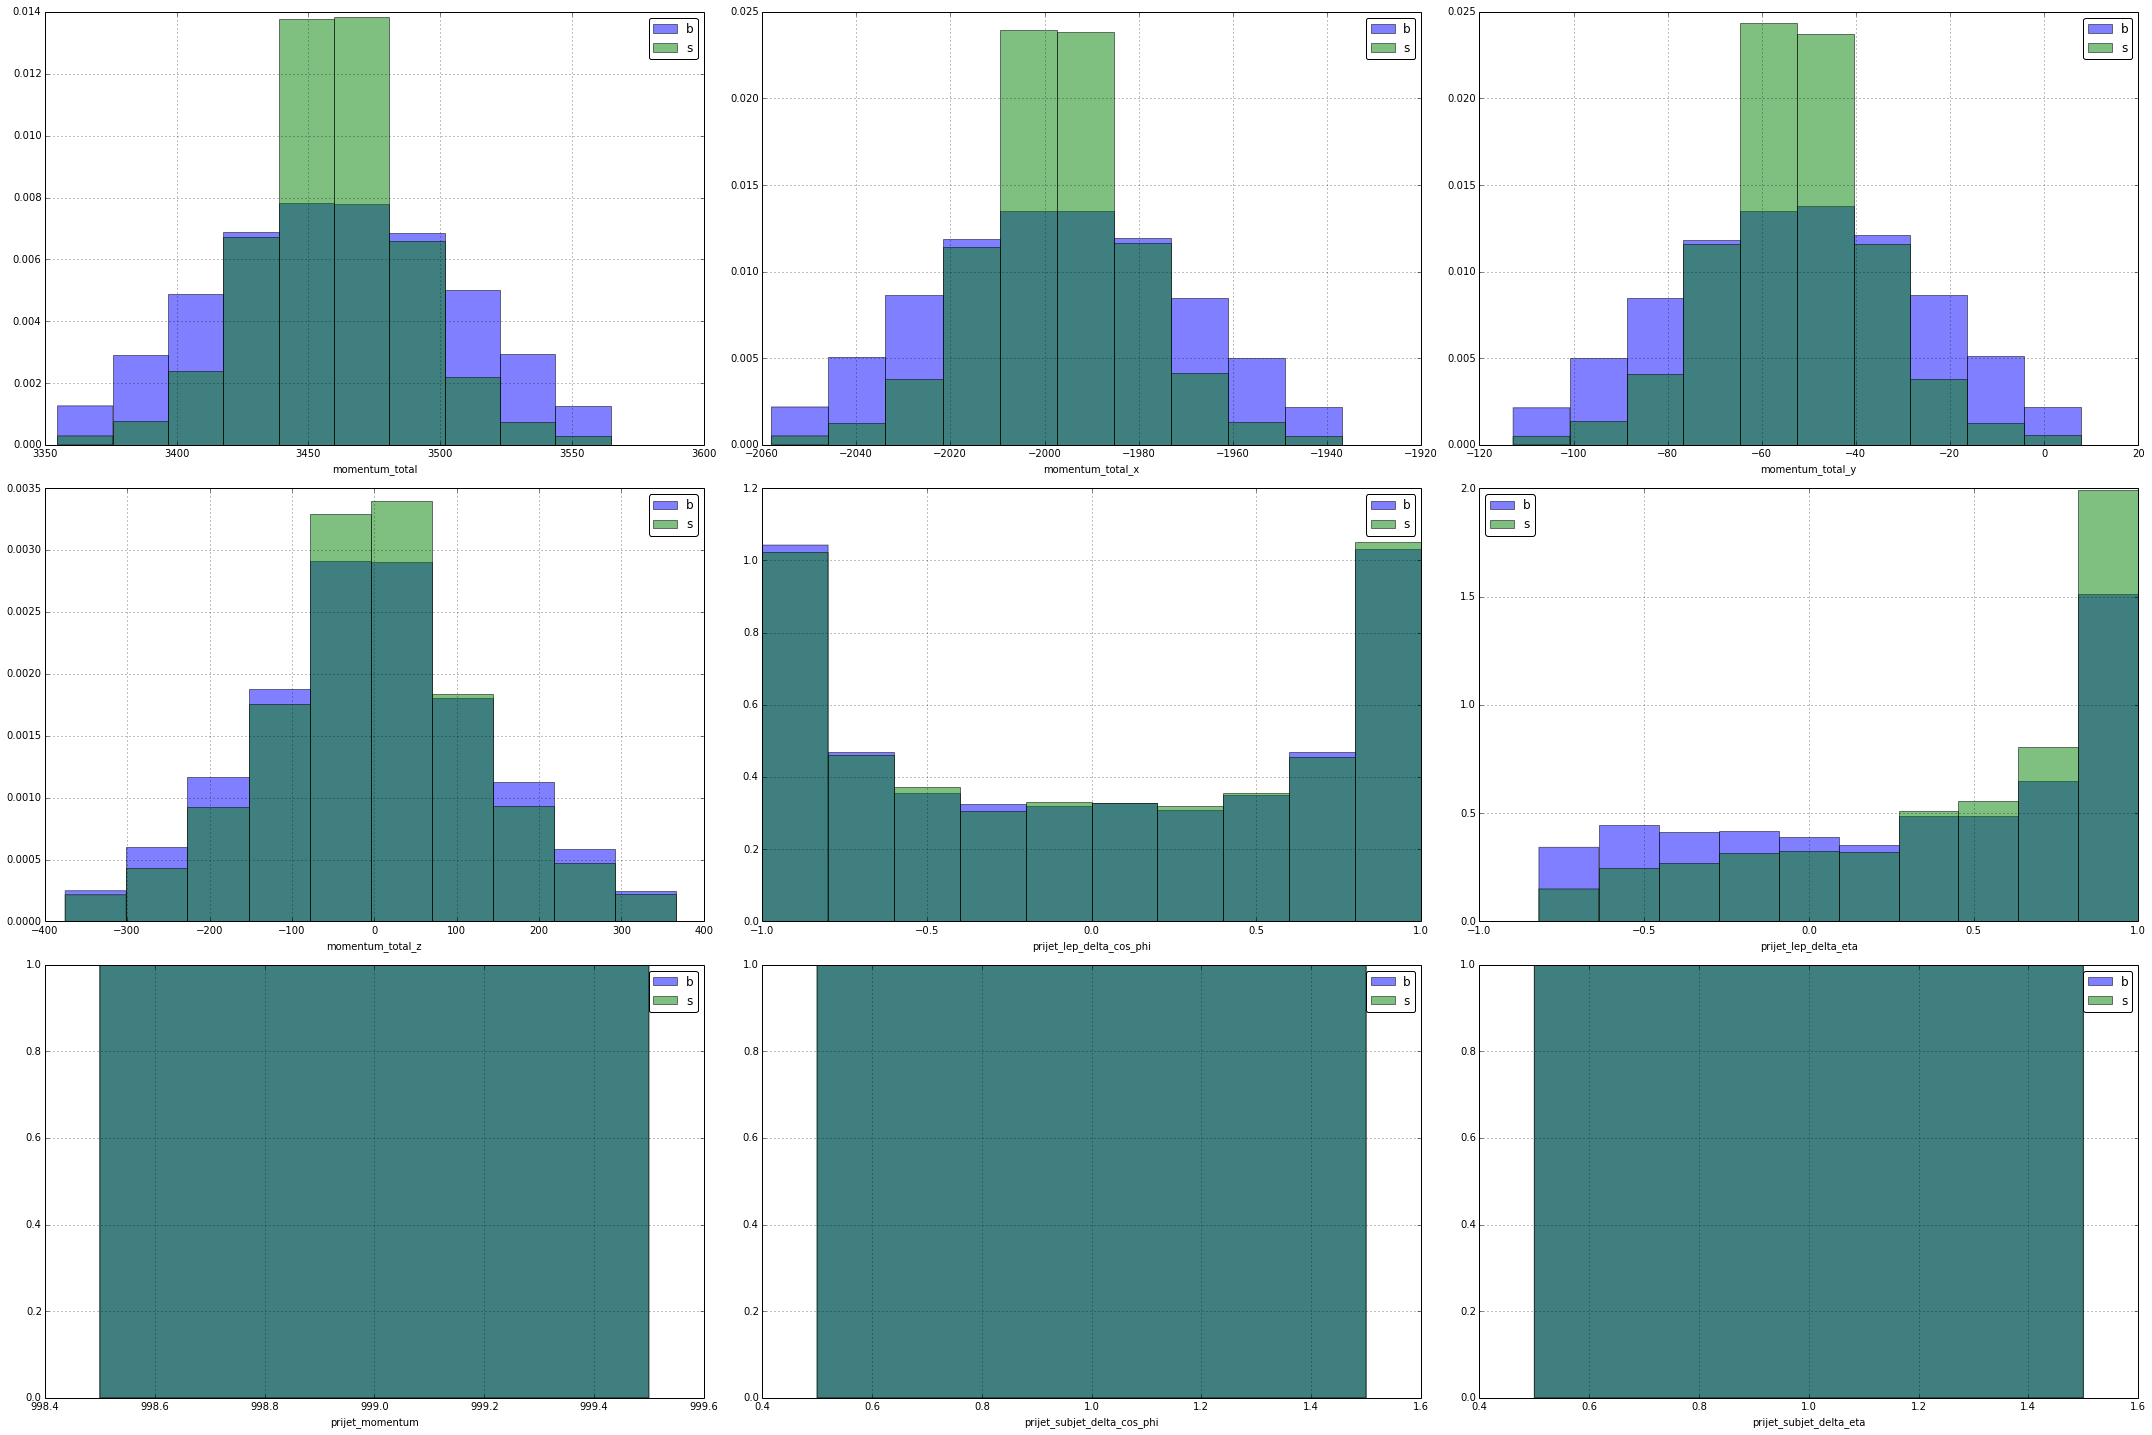

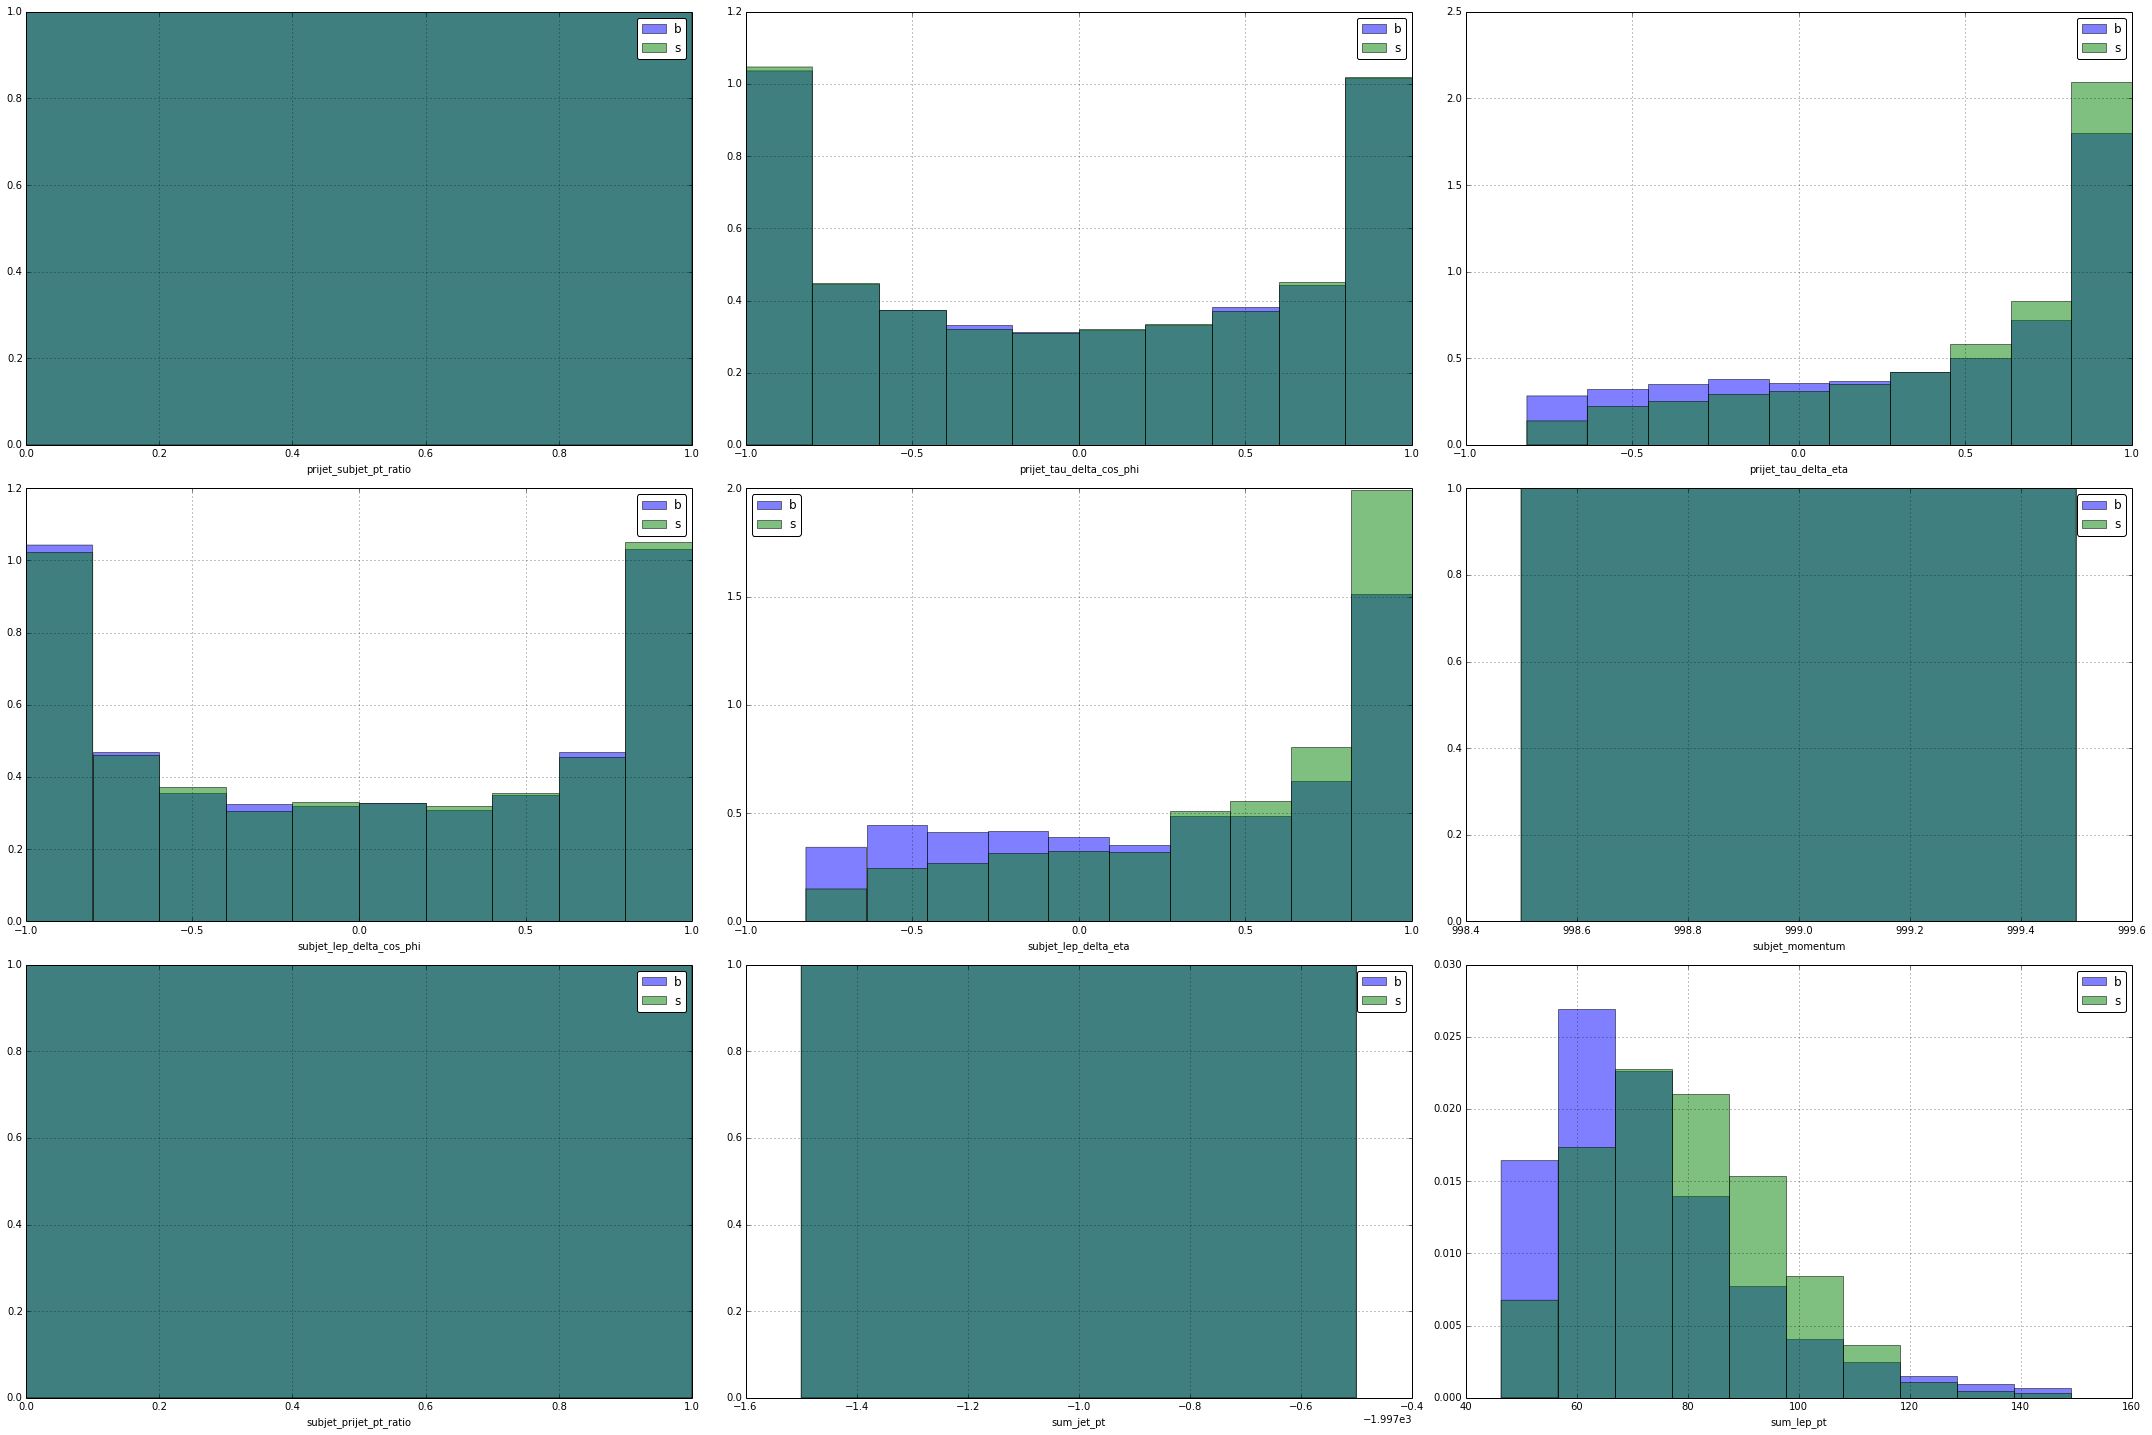

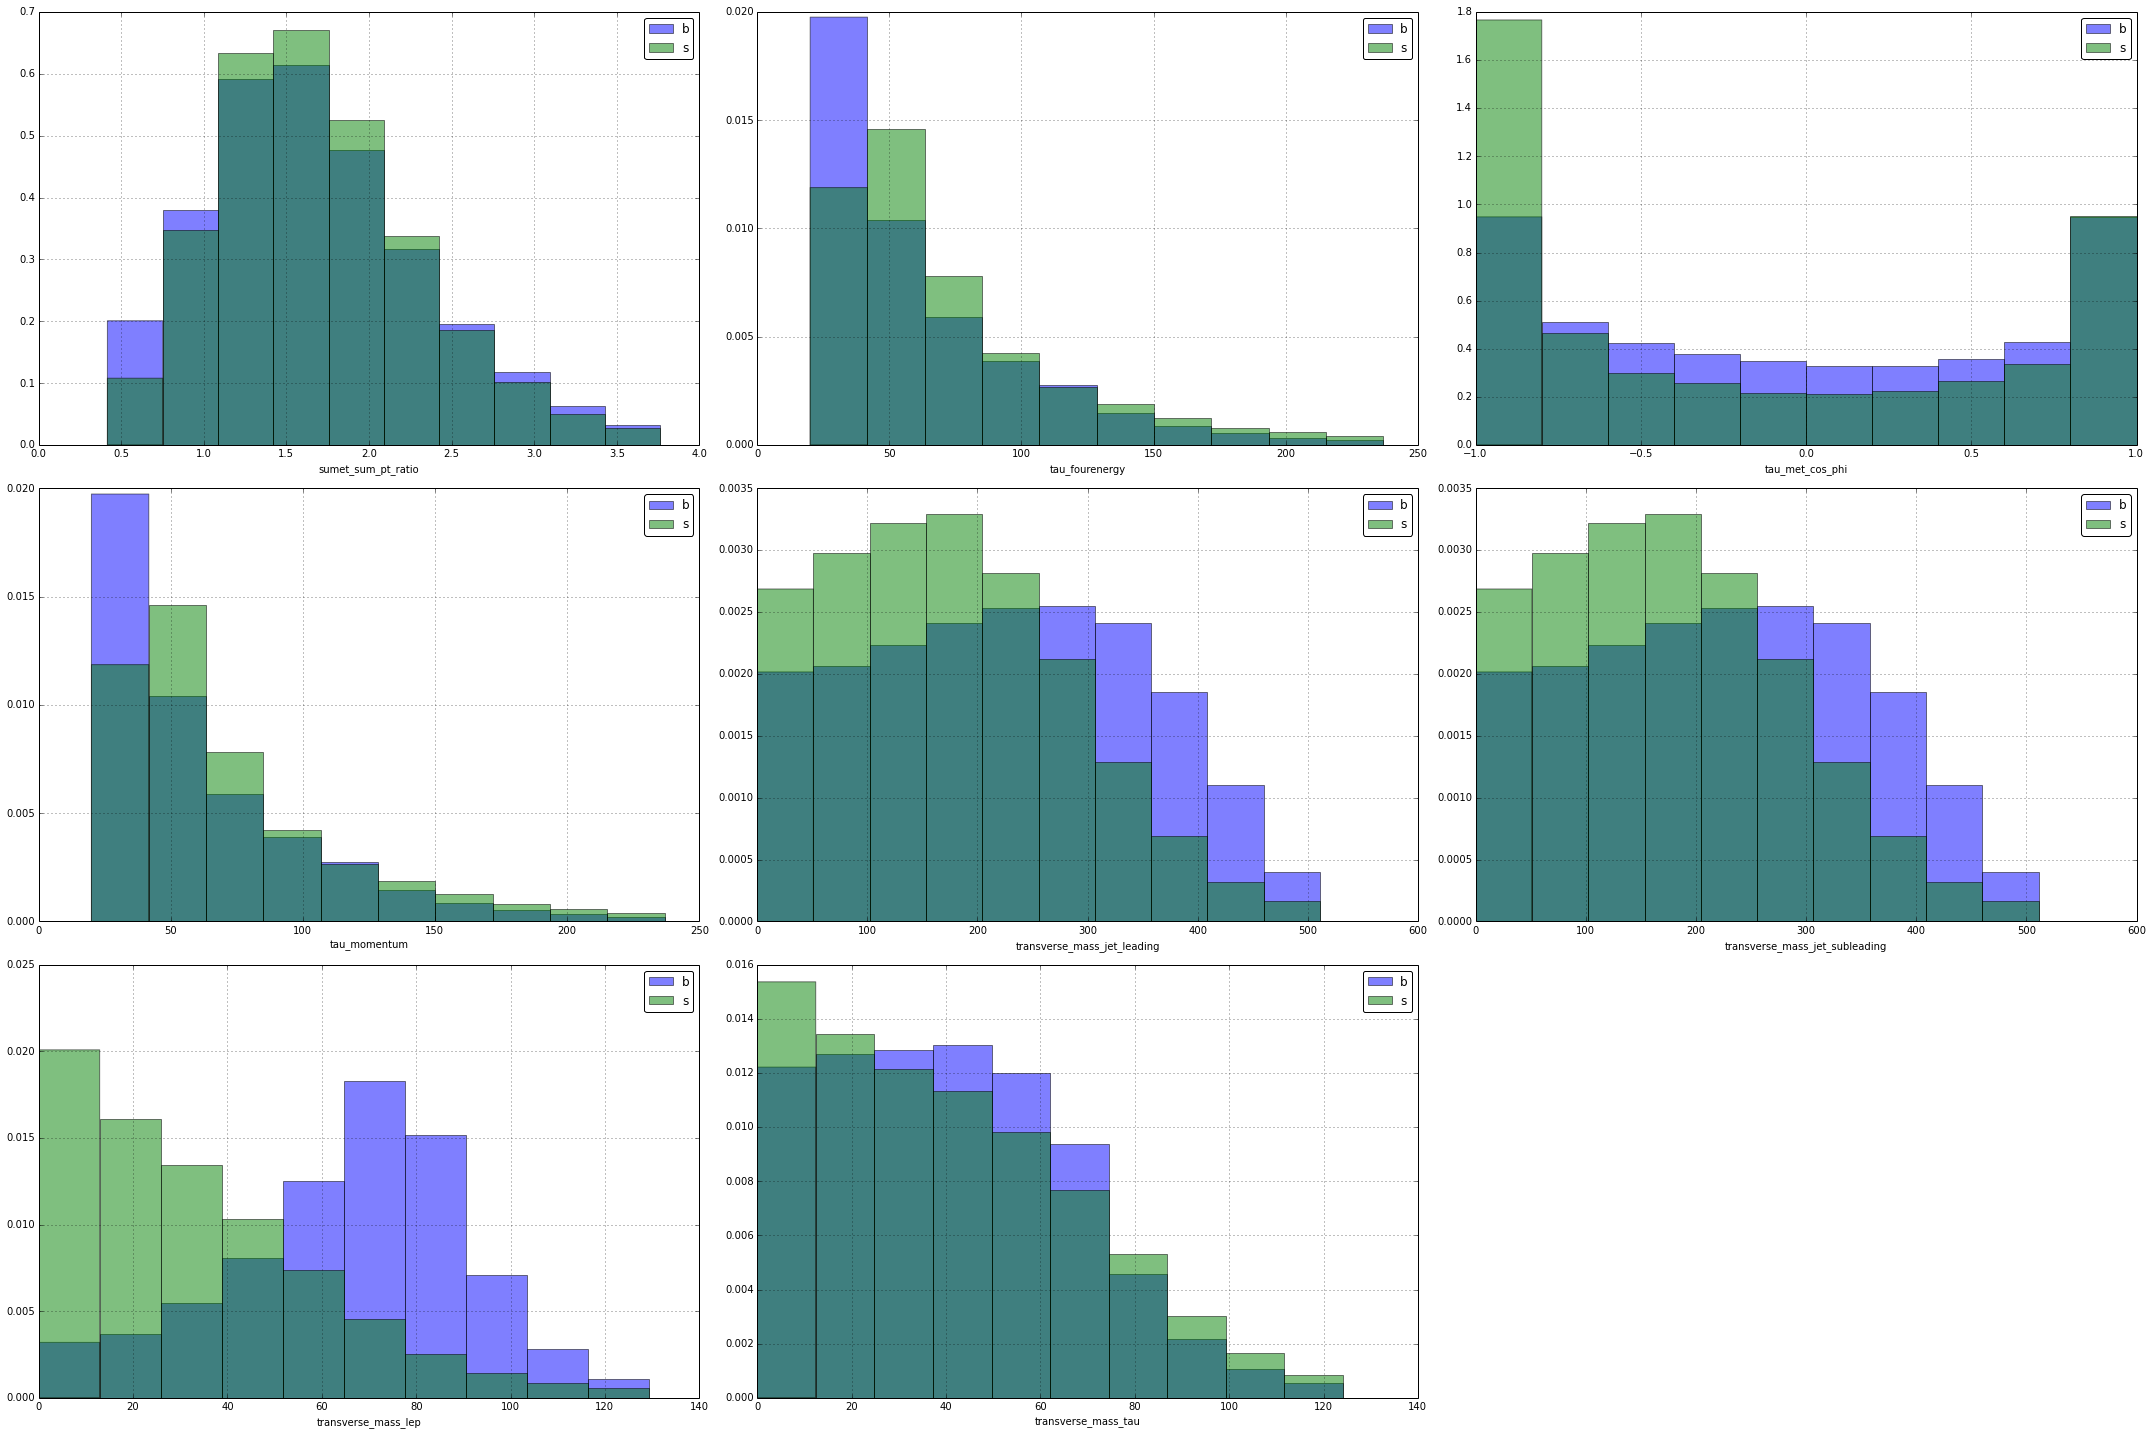

In [64]:
# And save to output file for viewing
for group, grouped in jet_partitioned:
    bamboo.plotting.save_grouped_hists(grouped.groupby('Label'),
                                   output_file='features_%s.pdf' % group, autobin=True, alpha=0.5, normed=True)

## Fitting all jets simultaneously

In [65]:
import sklearn.ensemble
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=200, n_jobs=-1)

In [66]:
print "Original Features"
score_summary(rf, features[::10], targets[::10], scoring=['accuracy', 'f1', 'roc_auc'], cv=5)

Original Features
Using 30 features and 25000 rows

----- accuracy -----
[ 0.834   0.8256  0.8294  0.8302  0.8314]
Accuracy: 0.83 (+/- 0.01)


----- f1 -----
[ 0.743125    0.73192296  0.7309774   0.73535093  0.73063436]
Accuracy: 0.73 (+/- 0.01)


----- roc_auc -----
[ 0.90165155  0.89402936  0.89285562  0.89530115  0.89867579]
Accuracy: 0.90 (+/- 0.01)




In [67]:
print "All Features"
score_summary(rf, all_features[::10], targets[::10], scoring=['accuracy', 'f1', 'roc_auc'], cv=5)

All Features
Using 104 features and 25000 rows

----- accuracy -----
[ 0.8362  0.824   0.8334  0.8298  0.8342]
Accuracy: 0.83 (+/- 0.01)


----- f1 -----
[ 0.74316253  0.71865054  0.72821175  0.73425896  0.73212583]
Accuracy: 0.73 (+/- 0.02)


----- roc_auc -----
[ 0.9010658   0.89280903  0.89450644  0.89568422  0.89645878]
Accuracy: 0.90 (+/- 0.01)




In [68]:
fitted = rf.fit(features[::10], targets[::10])
importance_summary(fitted, features)[:20]

[('DER_mass_MMC', 0.14760898265810615),
 ('DER_mass_transverse_met_lep', 0.10346610715723865),
 ('DER_mass_vis', 0.075688931575265683),
 ('PRI_tau_pt', 0.058514780010729836),
 ('DER_met_phi_centrality', 0.052421964677729964),
 ('DER_pt_ratio_lep_tau', 0.045443731898242794),
 ('DER_deltar_tau_lep', 0.044784681339308331),
 ('PRI_met', 0.039045408404044211),
 ('DER_pt_h', 0.030980786615069044),
 ('PRI_lep_pt', 0.030074456226410619),
 ('DER_sum_pt', 0.029994546673833125),
 ('DER_pt_tot', 0.029174278443015435),
 ('PRI_lep_eta', 0.0279965373273959),
 ('PRI_met_sumet', 0.027150751242927141),
 ('PRI_tau_eta', 0.026512773452858022),
 ('PRI_lep_phi', 0.024886969750068877),
 ('PRI_met_phi', 0.024444977366258117),
 ('PRI_tau_phi', 0.024391413913397525),
 ('DER_deltaeta_jet_jet', 0.021865375847299841),
 ('PRI_jet_leading_eta', 0.020200782048174847)]

In [69]:
fitted = rf.fit(all_features[::10], targets[::10])
importance_summary(fitted, all_features)[:20]

[('DER_mass_MMC', 0.084046834519244662),
 ('DER_mass_transverse_met_lep', 0.043031676098692163),
 ('transverse_mass_lep', 0.037982727423895246),
 ('DER_mass_vis', 0.035849930981586696),
 ('lep_mass', 0.035642181398317228),
 ('lep_met_cos_phi', 0.029948718640400388),
 ('DER_met_phi_centrality', 0.022766241264907533),
 ('PRI_tau_pt', 0.019412556635987302),
 ('DER_pt_ratio_lep_tau', 0.0178297349560195),
 ('frac_tau_pt', 0.016123939134892996),
 ('DER_deltar_tau_lep', 0.015943731197983507),
 ('lep_tau_delta_cos_phi', 0.015671361619889756),
 ('frac_lep_pt', 0.015292301137126129),
 ('min_lep_pt', 0.014891283014184844),
 ('met_sig', 0.014375812650557764),
 ('lep_tau_delta_eta', 0.014162293777407485),
 ('transverse_mass_tau', 0.013505402224982246),
 ('DER_deltaeta_jet_jet', 0.011743729410620452),
 ('sum_lep_pt', 0.011398378241621911),
 ('PRI_met', 0.010942064423370422)]

## Fitting Jets Individually

In [70]:
print "Zero Jet"
score_summary(rf, zero_jet_features[::10], zero_jet_targets[::10], scoring=['accuracy', 'f1', 'roc_auc'], cv=5)

Zero Jet
Using 104 features and 9992 rows

----- accuracy -----
[ 0.84592296  0.83141571  0.84784785  0.84884885  0.83983984]
Accuracy: 0.84 (+/- 0.01)


----- f1 -----
[ 0.66306695  0.62251656  0.66666667  0.68181818  0.65401786]
Accuracy: 0.66 (+/- 0.04)


----- roc_auc -----
[ 0.89091405  0.87890534  0.89156964  0.89615437  0.88549219]
Accuracy: 0.89 (+/- 0.01)




In [71]:
print "One Jet"
score_summary(rf, one_jet_features[::10], one_jet_targets[::10], scoring=['accuracy', 'f1', 'roc_auc'], cv=5)

One Jet
Using 104 features and 7755 rows

----- accuracy -----
[ 0.81495809  0.81302386  0.83558994  0.80335268  0.79754997]
Accuracy: 0.81 (+/- 0.03)


----- f1 -----
[ 0.72038835  0.71358749  0.75961538  0.69590643  0.69673704]
Accuracy: 0.72 (+/- 0.05)


----- roc_auc -----
[ 0.87838292  0.88040472  0.89769079  0.85622628  0.86845016]
Accuracy: 0.88 (+/- 0.03)




In [72]:
print "Multi Jet"
score_summary(rf, multi_jet_features[::10], multi_jet_targets[::10], scoring=['accuracy', 'f1', 'roc_auc'], cv=5)

Multi Jet
Using 104 features and 7255 rows

----- accuracy -----
[ 0.84011027  0.82701585  0.82977257  0.82081323  0.86009649]
Accuracy: 0.84 (+/- 0.03)


----- f1 -----
[ 0.81789639  0.81475788  0.80559876  0.80795715  0.84234577]
Accuracy: 0.82 (+/- 0.03)


----- roc_auc -----
[ 0.9146052   0.90652604  0.90751539  0.90049142  0.92616368]
Accuracy: 0.91 (+/- 0.02)




## Alternate Models

In [73]:
from sklearn.naive_bayes import GaussianNB 
gnb = GaussianNB()

In [75]:
# Try it on the multi-jet case
score_summary(gnb, all_features[::10], targets[::10], scoring=['accuracy', 'f1', 'roc_auc'], cv=5)

Using 104 features and 25000 rows

----- accuracy -----
[ 0.7022  0.6796  0.6834  0.6874  0.6848]
Accuracy: 0.69 (+/- 0.02)


----- f1 -----
[ 0.57200345  0.5451448   0.54340929  0.54656223  0.54790591]
Accuracy: 0.55 (+/- 0.02)


----- roc_auc -----
[ 0.76880511  0.74081246  0.73910601  0.75380335  0.75099055]
Accuracy: 0.75 (+/- 0.02)




In [76]:
from sklearn.ensemble import AdaBoostClassifier
bdt = AdaBoostClassifier(n_estimators=100)

In [77]:
score_summary(bdt, all_features[::10], targets[::10], scoring=['accuracy', 'f1', 'roc_auc'], cv=5)

Using 104 features and 25000 rows

----- accuracy -----
[ 0.8218  0.8212  0.8146  0.8154  0.8086]
Accuracy: 0.82 (+/- 0.01)




KeyboardInterrupt: 

# Using Event Weights

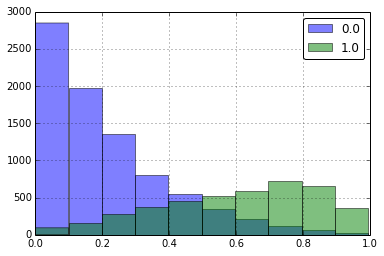

In [80]:
from bamboo.modeling import plot_distribution

rf = sklearn.ensemble.RandomForestClassifier(n_estimators=200, n_jobs=-1)
plot_distribution(rf, all_features[::10], targets[::10], fit_params={'sample_weight': df['Weight'][::10]},
                   autobin=True, alpha=0.5)

In [81]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100, n_jobs=-1)
score_summary(rf, all_features[::10], targets[::10],
              scoring=['accuracy', 'f1', 'roc_auc'], cv=5, fit_params={'sample_weight': df['Weight'][::10]})

Using 104 features and 25000 rows

----- accuracy -----
[ 0.8116  0.799   0.7994  0.798   0.792 ]
Accuracy: 0.80 (+/- 0.01)


----- f1 -----
[ 0.72039859  0.69935785  0.70077335  0.70136014  0.70011737]
Accuracy: 0.70 (+/- 0.02)


----- roc_auc -----
[ 0.87311087  0.86041376  0.85922855  0.86147416  0.86146861]
Accuracy: 0.86 (+/- 0.01)




In [88]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100)
fitted = rf.fit(features[0:10000], targets[0:10000], sample_weight=df['Weight'][0:10000].values)

In [89]:
#evaluate_ams(fitted, features[10000:], truth_dict)

signal = 222.574770843, background = 131976.149864
AMS = 0.61247696716
('b', 's') 54827
('s', 'b') 52625
('b', 'b') 105148
('s', 's') 27400


# Metrics

## Baseline using nominal features

In [82]:
training_features, training_targets = get_features_and_targets(df[:10000])
testing_features, testing_targets = get_features_and_targets(df[10000:])

In [83]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100)
fitted = rf.fit(training_features, training_targets)

In [84]:
prediction = bamboo.modeling.get_prediction(fitted, testing_features, testing_targets)

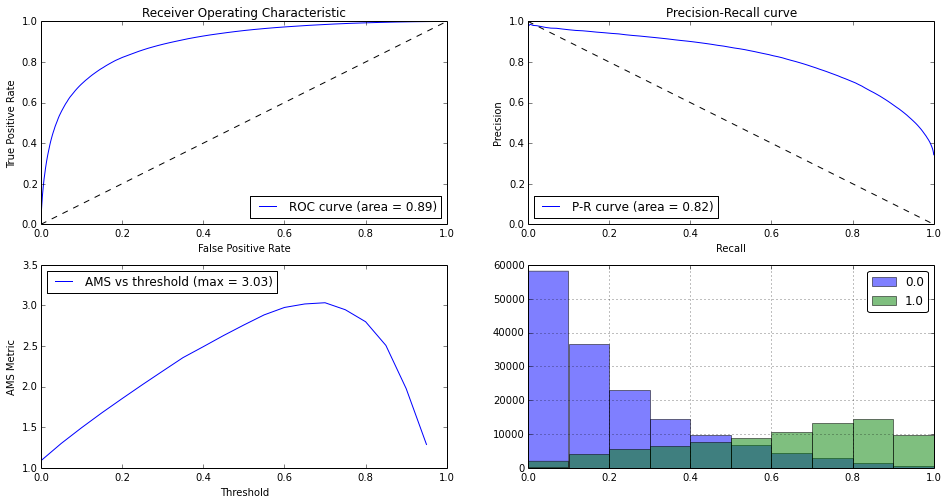

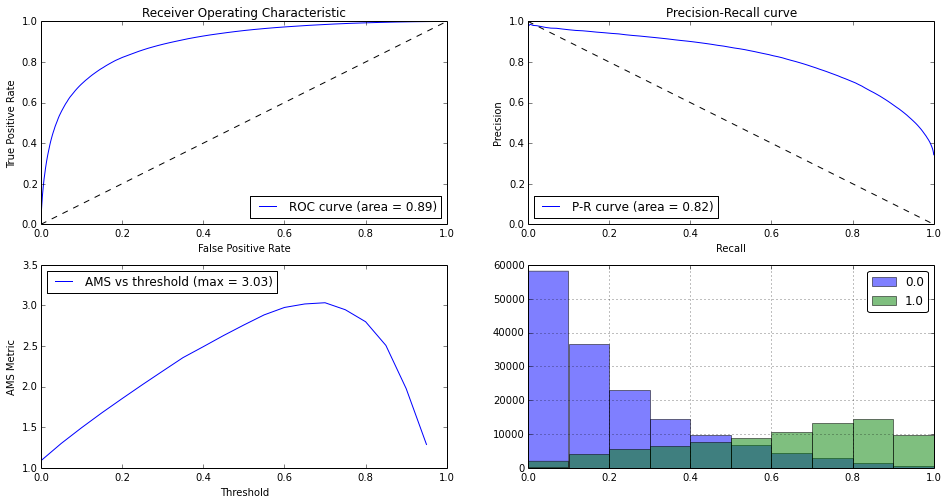

In [90]:
prediction_plots(prediction)

## Using my new Features

In [91]:
training_all_features, training_all_targets = get_features_and_targets(df_all_features[:10000])
testing_all_features, testing_all_targets = get_features_and_targets(df_all_features[10000:])

In [93]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100)
fitted_all = rf.fit(training_all_features, training_all_targets)

In [94]:
prediction_all = bamboo.modeling.get_prediction(fitted_all, testing_all_features, testing_all_targets)

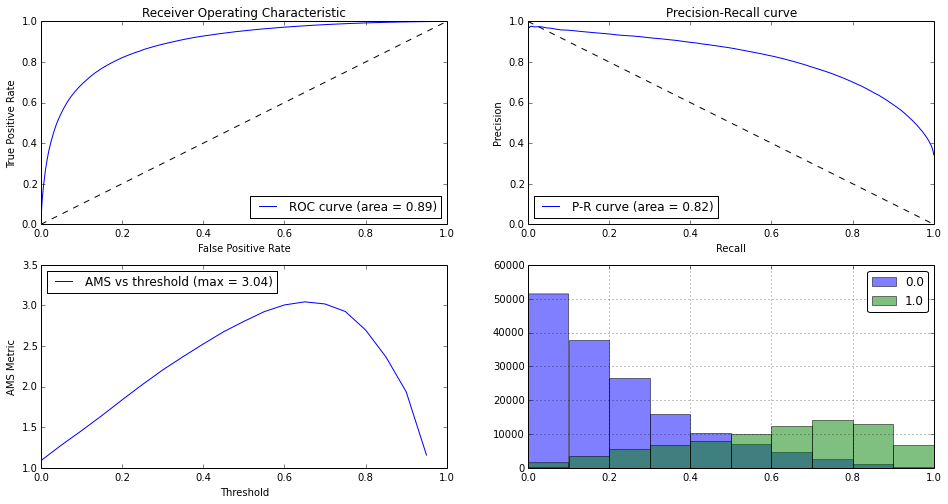

In [96]:
plotted = prediction_plots(prediction_all)

## Extra Trees Classifier

In [315]:
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier(n_estimators=100)
fitted_extra = et.fit(training_features, training_targets)

In [316]:
prediction_extra = bamboo.modeling.get_prediction(fitted_extra, testing_features, testing_targets)

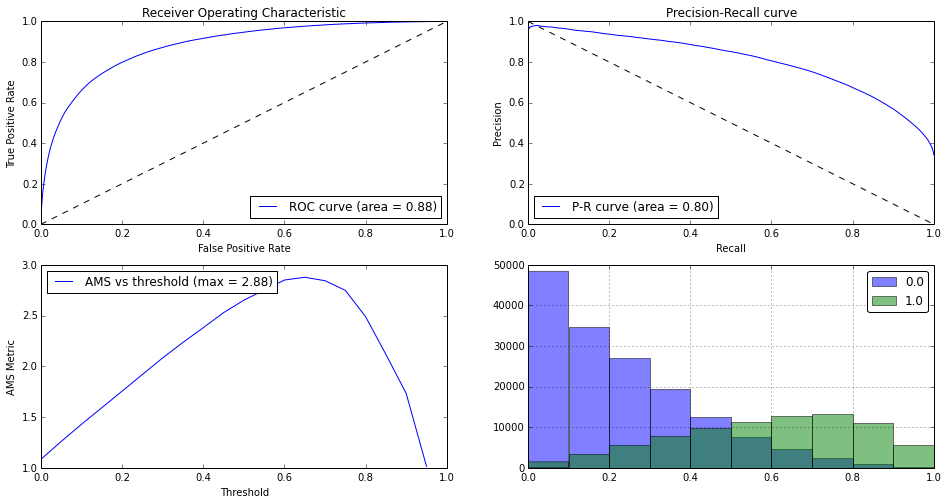

In [317]:
prediction_plots(prediction_extra)

## MOAR TREES!

In [309]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=1000, n_jobs=-1)
fitted_moar = rf.fit(training_features, training_targets)

In [310]:
prediction_moar = bamboo.modeling.get_prediction(fitted_moar, testing_features, testing_targets)

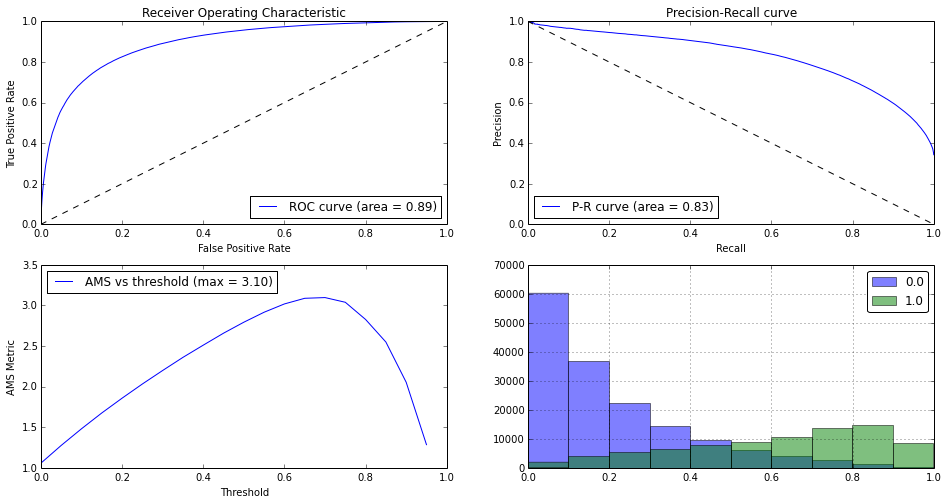

In [311]:
prediction_plots(prediction_moar)

## MOAR TREES, MOAR FEATURES

In [342]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=1000, n_jobs=-1)
fitted_moar_moar = rf.fit(training_all_features, training_all_targets)

In [343]:
prediction_moar_moar = bamboo.modeling.get_prediction(fitted_moar_moar, testing_all_features, testing_all_targets)

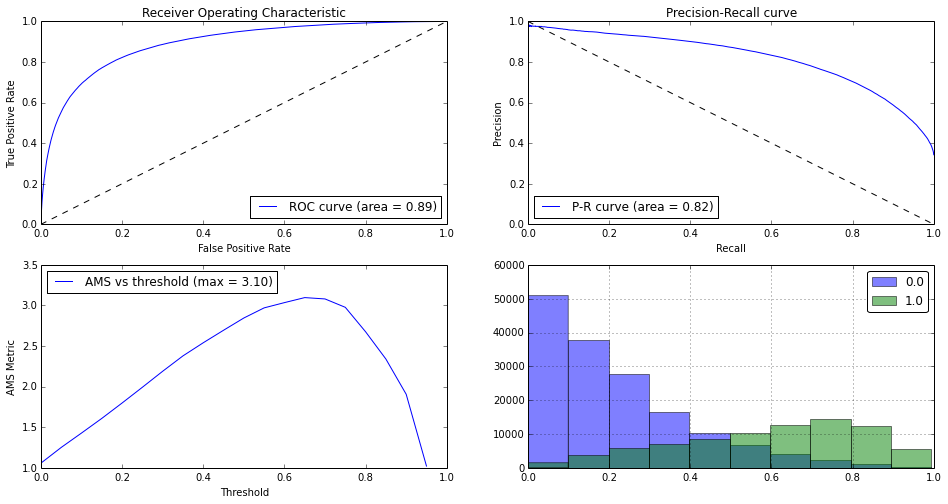

In [344]:
prediction_plots(prediction_moar_moar)

## Boosted Decision Trees

In [318]:
from sklearn.ensemble import AdaBoostClassifier

bdt = AdaBoostClassifier(n_estimators=100)
fitted_bdt = bdt.fit(training_features, training_targets)

In [319]:
prediction_bdt = bamboo.modeling.get_prediction(fitted_bdt, testing_features, testing_targets)

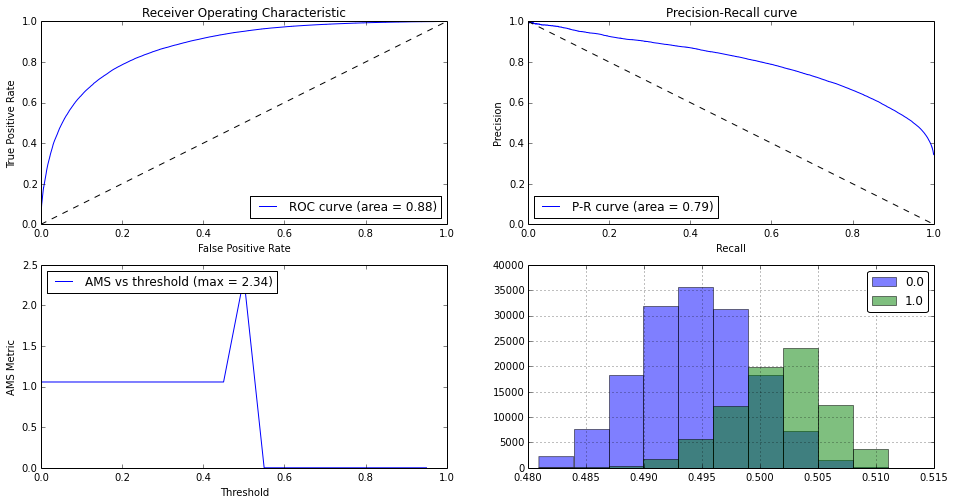

In [320]:
prediction_plots(prediction_bdt)

## Multi-Jet Only

In [325]:
multi_jet = bamboo.data.partition(df, jet_partition).get_group('multi_jet')

training_multi_features, training_multi_targets = get_features_and_targets(multi_jet[:10000])
testing_multi_features, testing_multi_targets = get_features_and_targets(multi_jet[10000:])

In [326]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100)
fitted_multi = rf.fit(training_multi_features, training_multi_targets)

In [328]:
prediction_multi = bamboo.modeling.get_prediction(fitted_multi, testing_multi_features, testing_multi_targets)

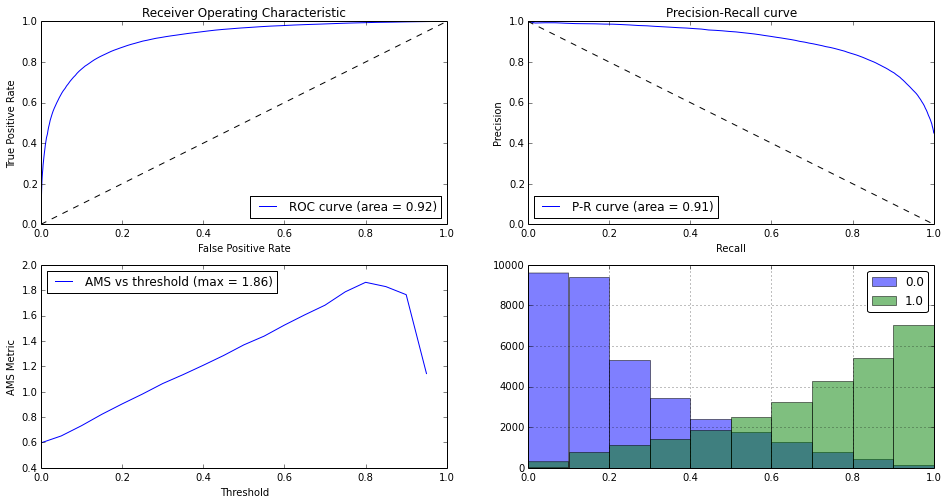

In [329]:
prediction_plots(prediction_multi)

## Using training Weights

In [331]:
training_all_features, training_all_targets = get_features_and_targets(df_all_features[:10000])
training_weights = df['Weight'][:10000]

testing_all_features, testing_all_targets = get_features_and_targets(df_all_features[10000:])

In [334]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100)
fitted_weight = rf.fit(training_features, training_targets, sample_weight = training_weights.values)

In [335]:
prediction_weight = bamboo.modeling.get_prediction(fitted_weight, testing_features, testing_targets)

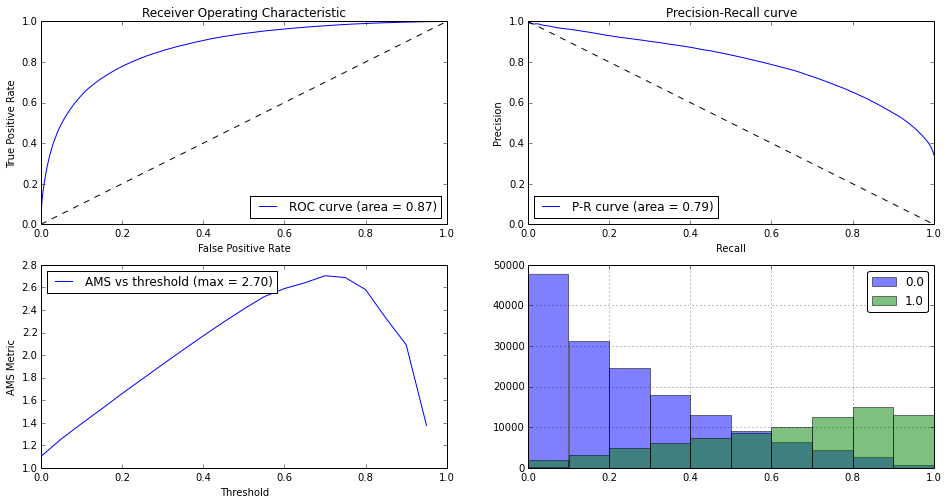

In [336]:
prediction_plots(prediction_weight)

## MOAR DATA

In [346]:
training_features, training_targets = get_features_and_targets(df[:150000])
testing_features, testing_targets = get_features_and_targets(df[150000:])

In [347]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=1000, n_jobs=-1)
fitted_data = rf.fit(training_features, training_targets)

In [348]:
prediction_data = bamboo.modeling.get_prediction(fitted_data, testing_features, testing_targets)

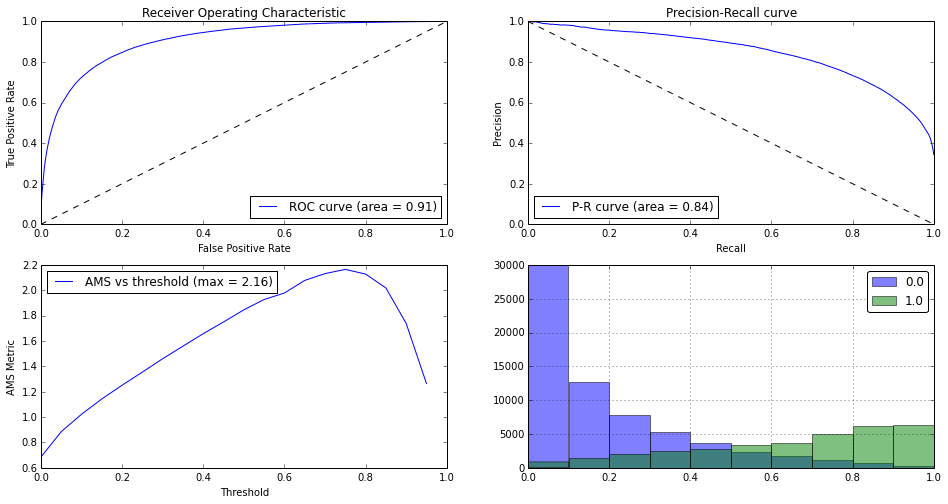

In [349]:
prediction_plots(prediction_data)

## Max data and features

In [360]:
training_max_features, training_max_targets = get_features_and_targets(df_all_features[:150000])
testing_max_features, testing_max_targets = get_features_and_targets(df_all_features[150000:])

In [361]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=1000, n_jobs=-1)
fitted_max = rf.fit(training_max_features, training_max_targets)

In [363]:
prediction_max = bamboo.modeling.get_prediction(fitted_max, testing_max_features, testing_max_targets)

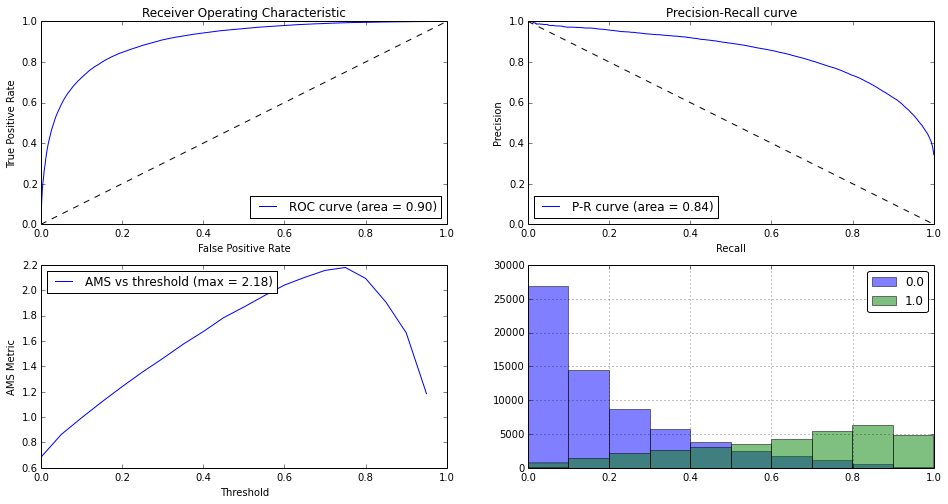

In [364]:
prediction_plots(prediction_max)